# Uncertainty Estimates 

Our hypotheses are: 

1. The higher the exploitation, the worse the approximation of the partial dependence plot. 
2. The higher the exploitation, the higher the confidence intervals. 
3. Subsetting reduces the effect of this bias, and improves the shape of the partial dependence plots. 

In [77]:
library("ggplot2")
library("ParamHelpers")
library("data.table")
library("BBmisc")
library("iml")
library("philentropy")

theme_set(theme_bw())

source("../R/mbo_helpers.R")
source("../R/pdp_helpers.R")

## 1. Hypothesis - Higher Exploitation means worse PDPs 

#### Synthetic functions

We have 4 different values of lambda: 0.1, 1, 2, 10. 

In [3]:
compute_width_ci = function(dimension, lambda_vals, breaks) {
    # read all synthetic functions

    path = "../data/runs/synthetic/StyblinskiTang/"

    diffs = lapply(lambda_vals, function(lambda) {
        datapath = file.path(path, paste0(dimension, "D"), paste0("mlrmbo_run_lambda_", lambda, ".rds"))

        run = readRDS(datapath)
        obj = readRDS(file.path(path, paste0(dimension, "D"), "objective.rds"))
        ps = readRDS(file.path(path, paste0(dimension, "D"), "ps.rds"))

        opdf = as.data.frame(run$opt.path)
        
        model = run$models
        model = model[[length(model)]] 

        df = generateRandomDesign(n = 1000, par.set = ps)
        
        res = lapply(model$features, function(feature) {
            me = marginal_effect(obj = obj, feature = feature, data = df, model = model, grid.size = 20)
            pme = marginal_effect_sd_over_mean(model = model, feature = feature, data = df, grid.size = 20, method = "pdp_var_gp")

            md = mean(abs(me$mean - pme$mean))
            neg_loglik = mean(unlist(lapply(seq_row(pme), function(i) {
                dnorm(me[i, ]$mean, mean = pme[i, ]$mean, sd = pme[i, ]$sd, log = FALSE) 
            })))
            mean_sd = mean(pme$sd)
            sd_upper_q90 = quantile(x = pme$sd, probs = 0.9)
            sd_lower_q10 = quantile(x = pme$sd, probs = 0.1)

            # compute the kullback-leibler distance 
            myhist = hist(opdf[, c(feature)], breaks = breaks)
            P = myhist$density
            Q = 1 / length(myhist$density)
            
            cbind(md = md, mean_sd = mean_sd, kld = sum(P * log(P / Q), na.rm = TRUE), sd_upper_q90 = sd_upper_q90, sd_lower_q10 = sd_lower_q10, feature = feature, lambda = lambda, dim = dimension)
        })

        do.call(rbind, res)
    })
    
    diffs = do.call(rbind, diffs)
    diffs = as.data.table(diffs)
    
    return(diffs)
} 

In [234]:
lambda_vals = c(0.1, 1, 2, 5, 10)

In [235]:
diffs = list()

In [ ]:
diffs[["2D"]] = compute_width_ci(2, lambda_vals, breaks = 15)

In [237]:
diffs[["2D"]]

md               kld feature lambda dim
1  20.2648386392811 NaN x1      0.1    2  
2  25.1085289052056 NaN x2      0.1    2  
3  8.85129593662747 NaN x1      1      2  
4  17.5890657457196 NaN x2      1      2  
5  9.27511865130917 NaN x1      2      2  
6  8.81199791706629 NaN x2      2      2  
7  4.42544476365444 NaN x1      5      2  
8  4.33463238983161 NaN x2      5      2  
9  2.43470455758086 NaN x1      10     2  
10 2.34081093285065 NaN x2      10     2

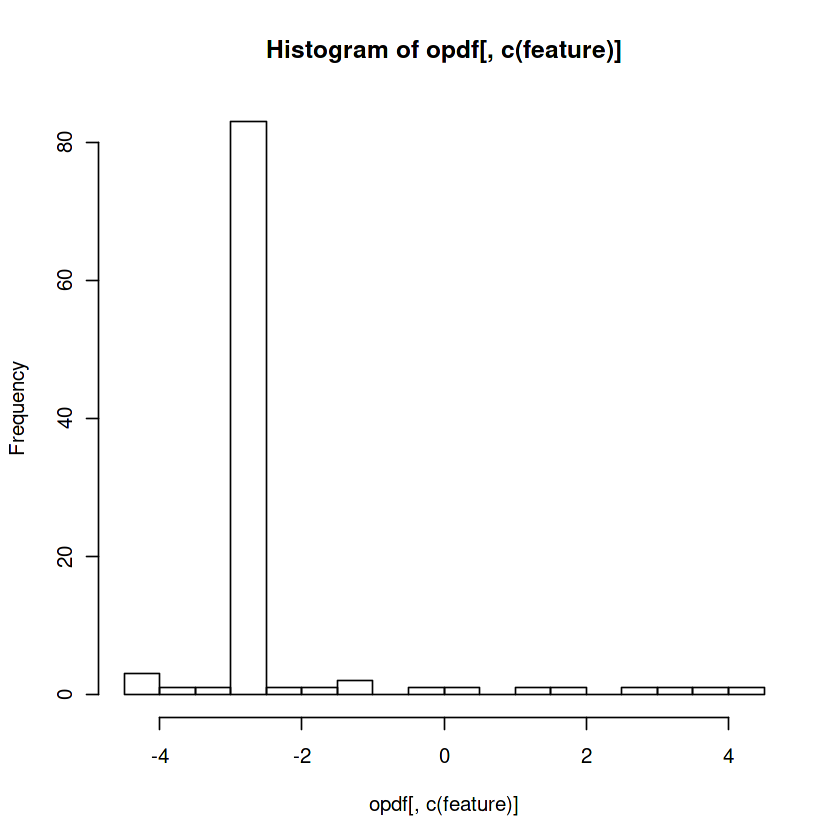

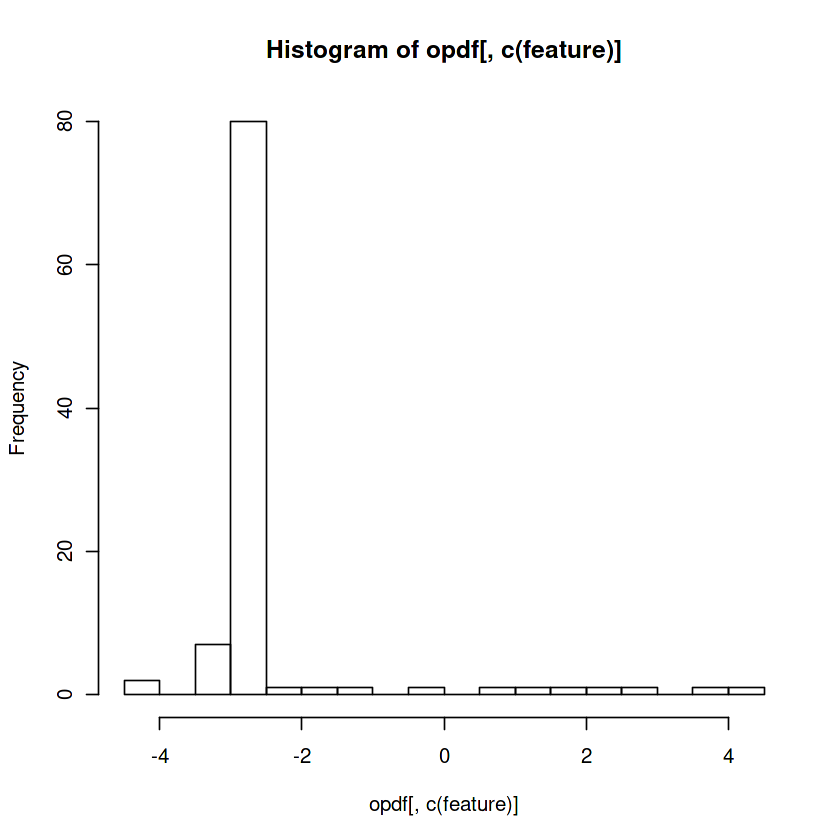

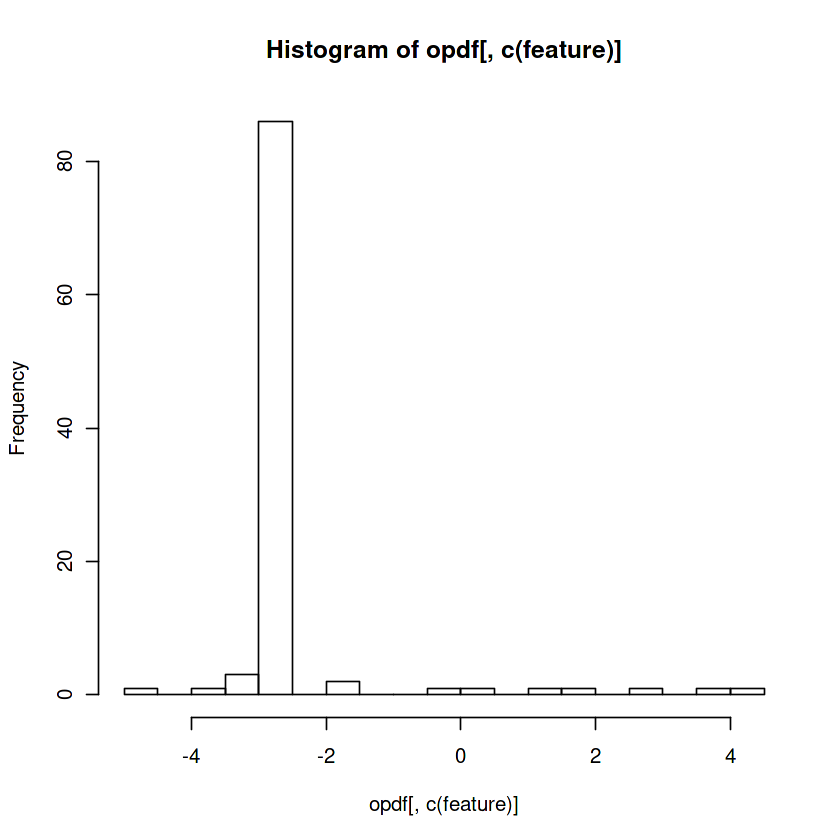

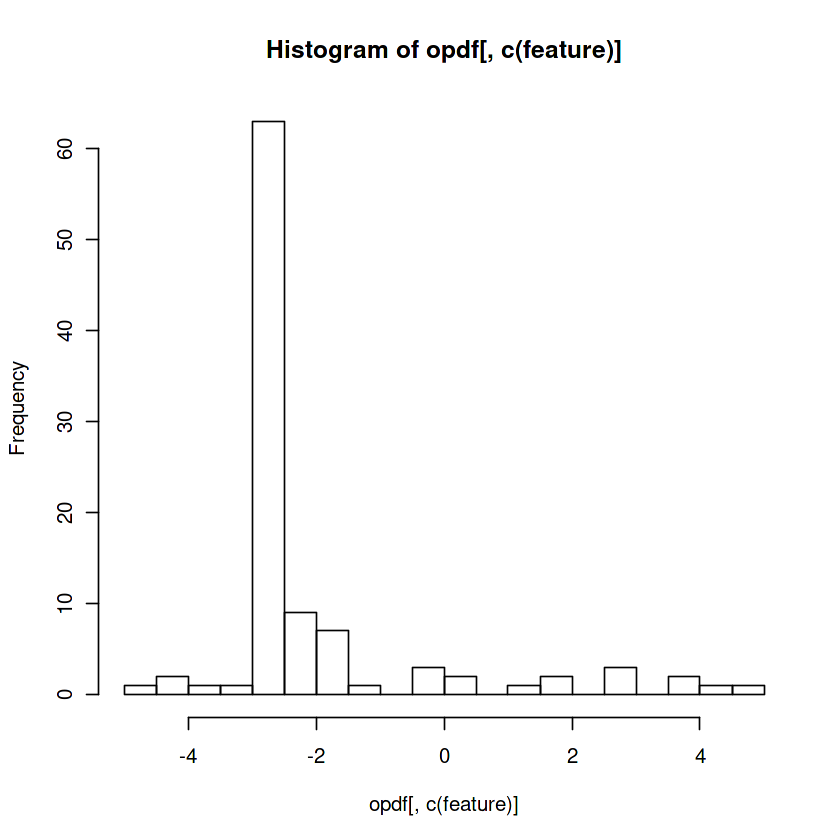

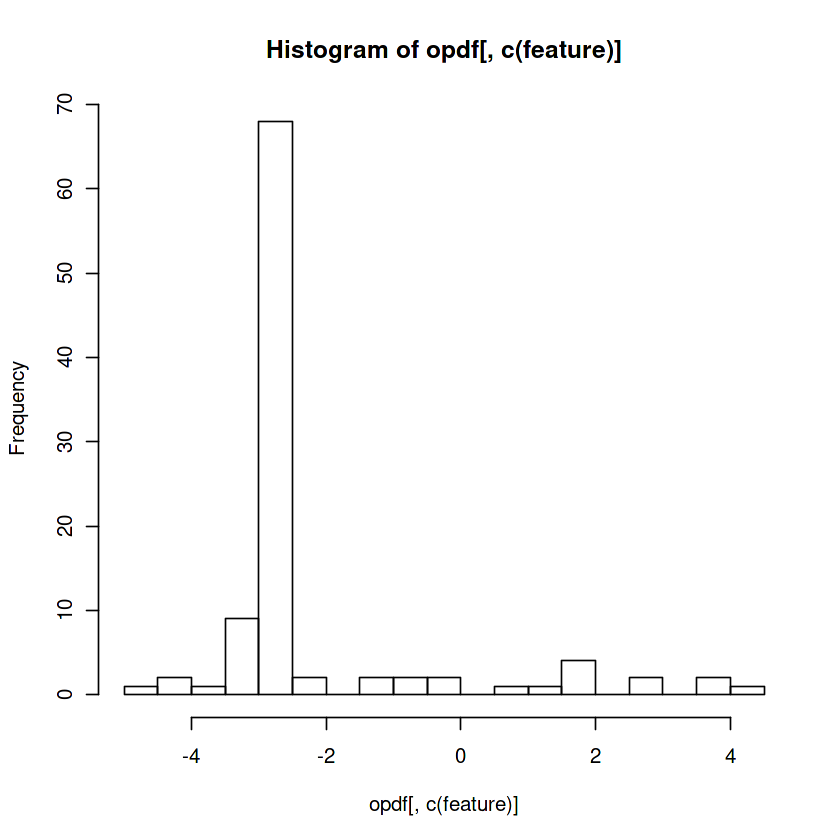

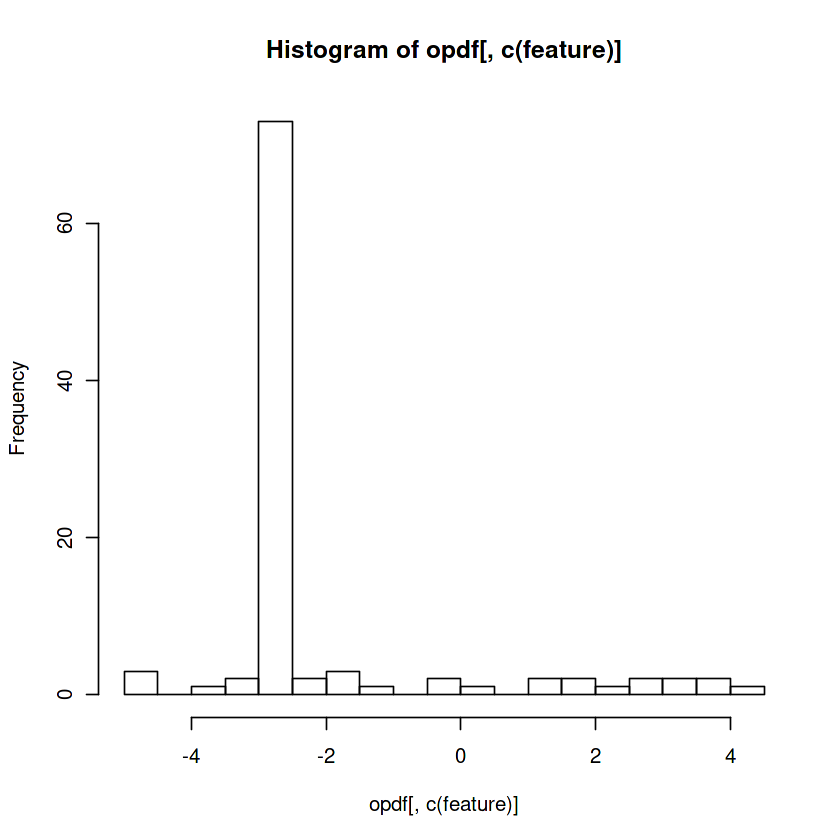

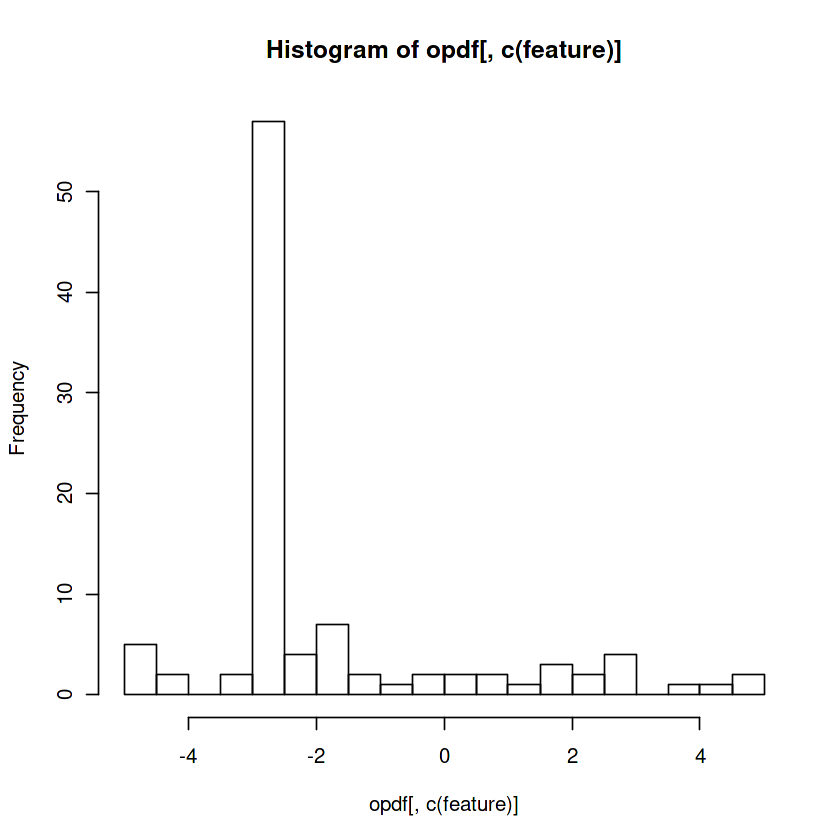

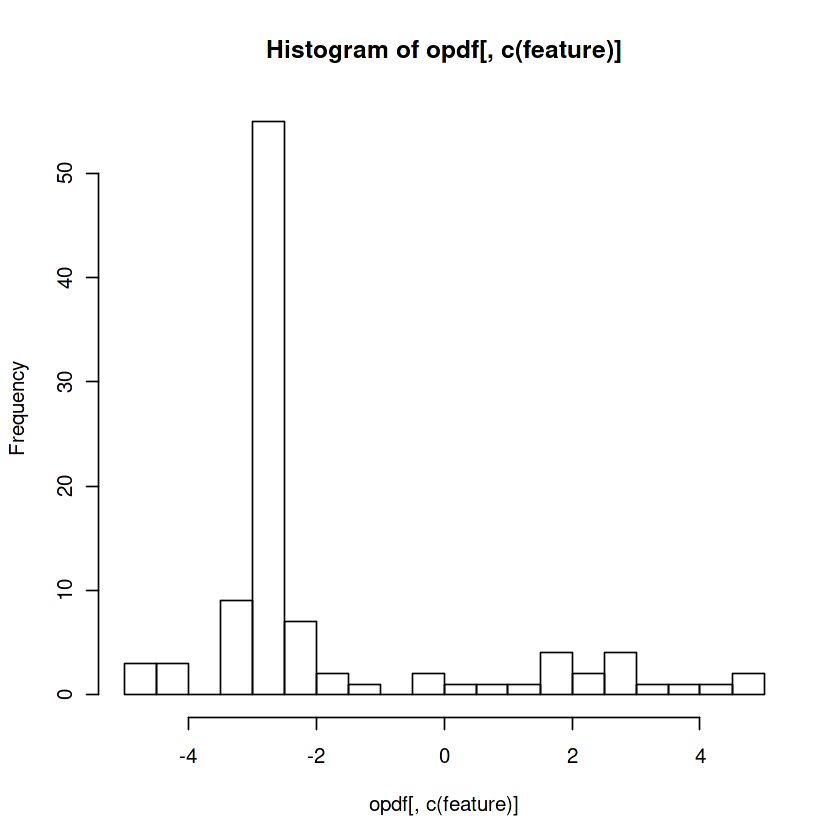

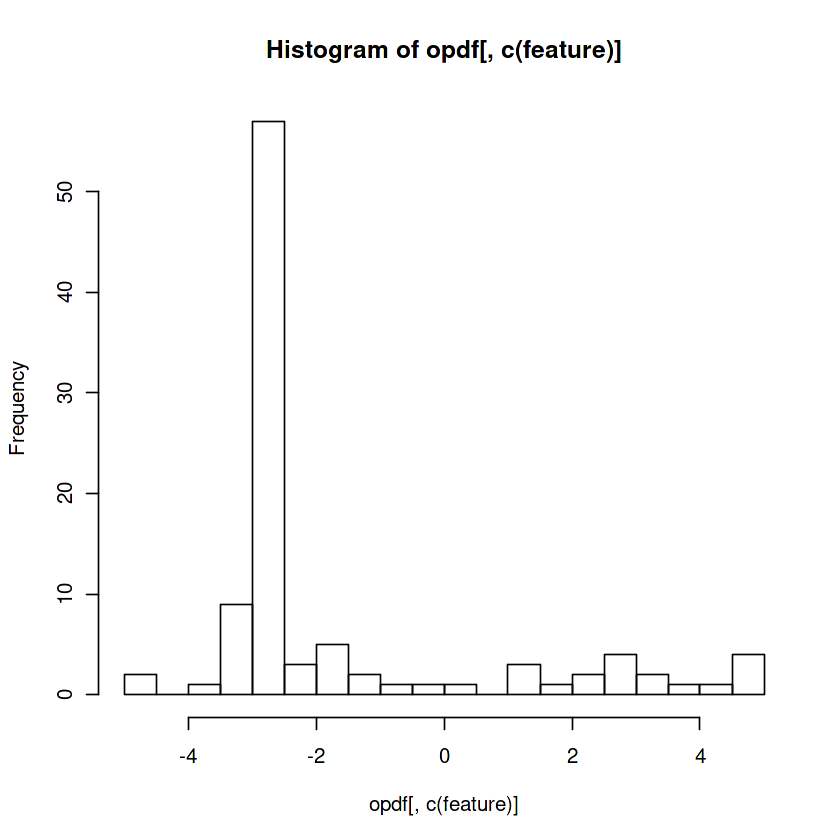

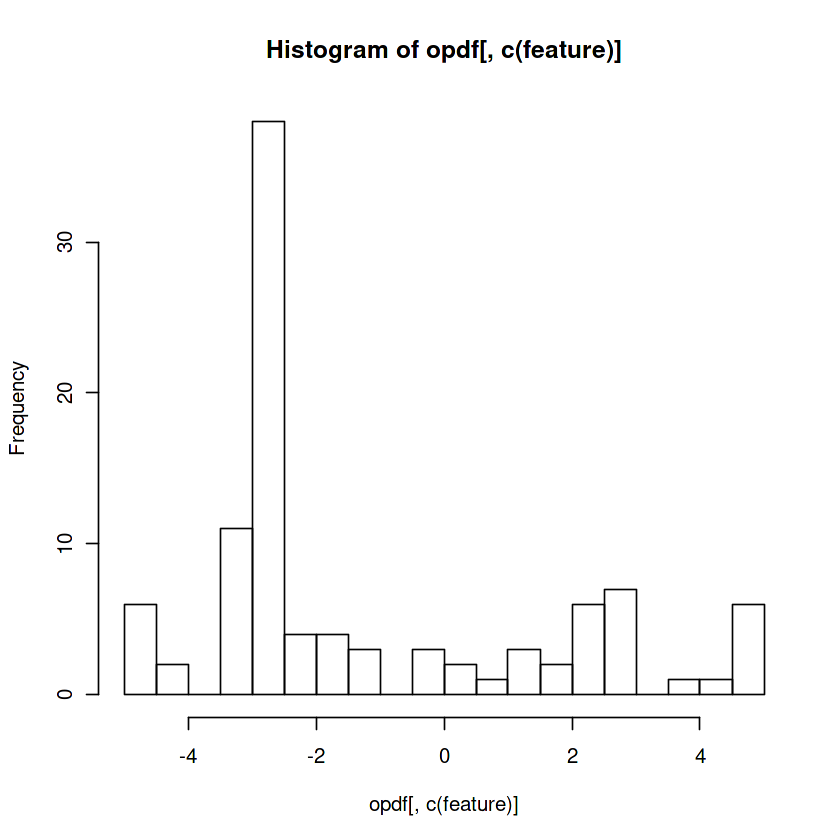

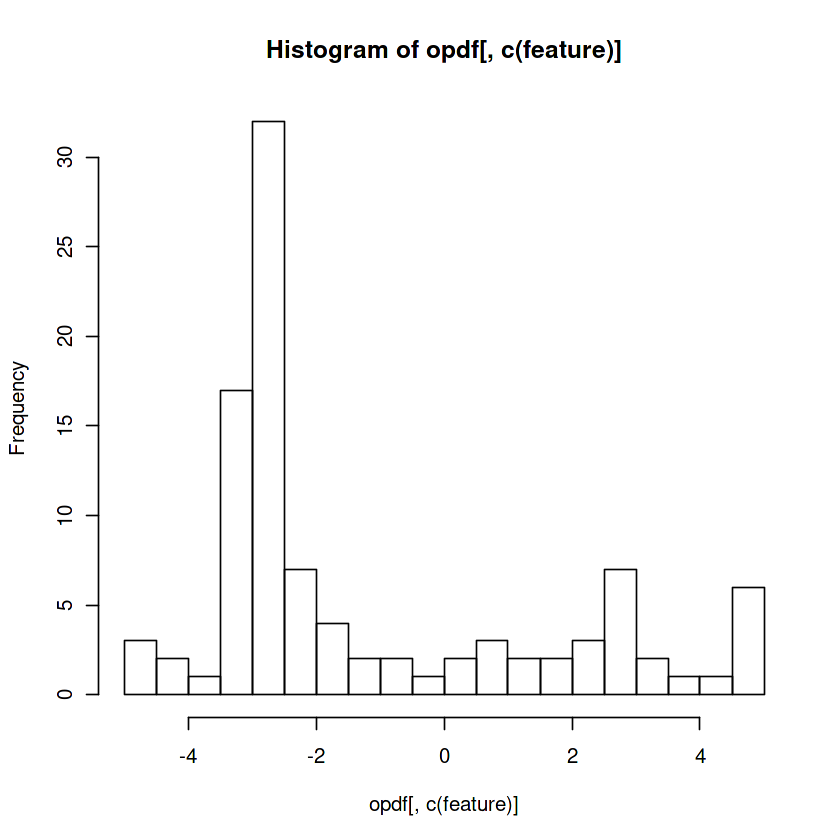

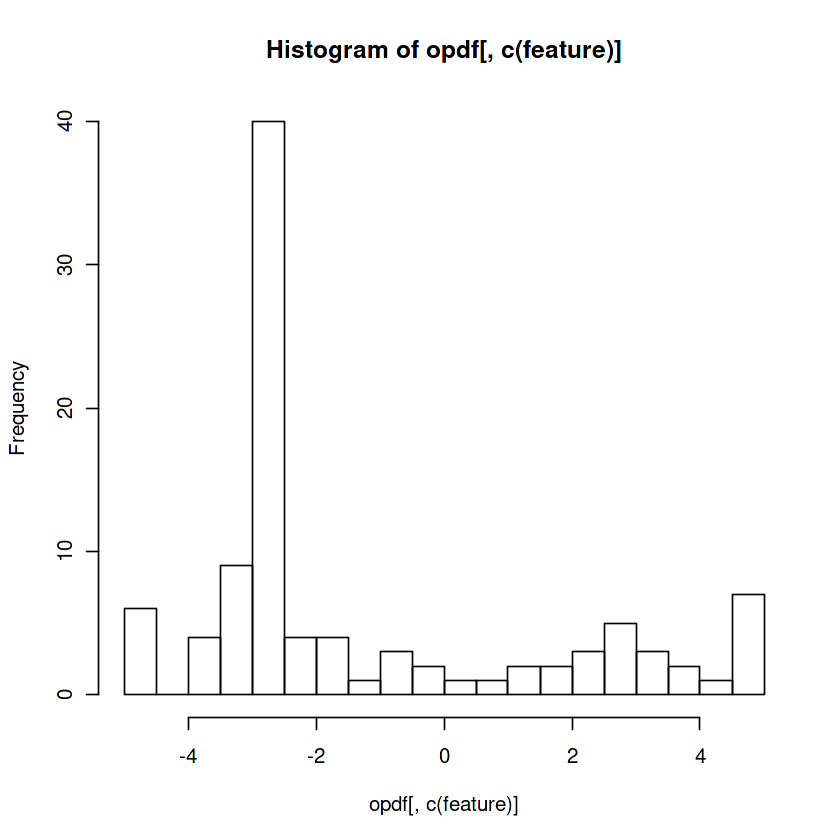

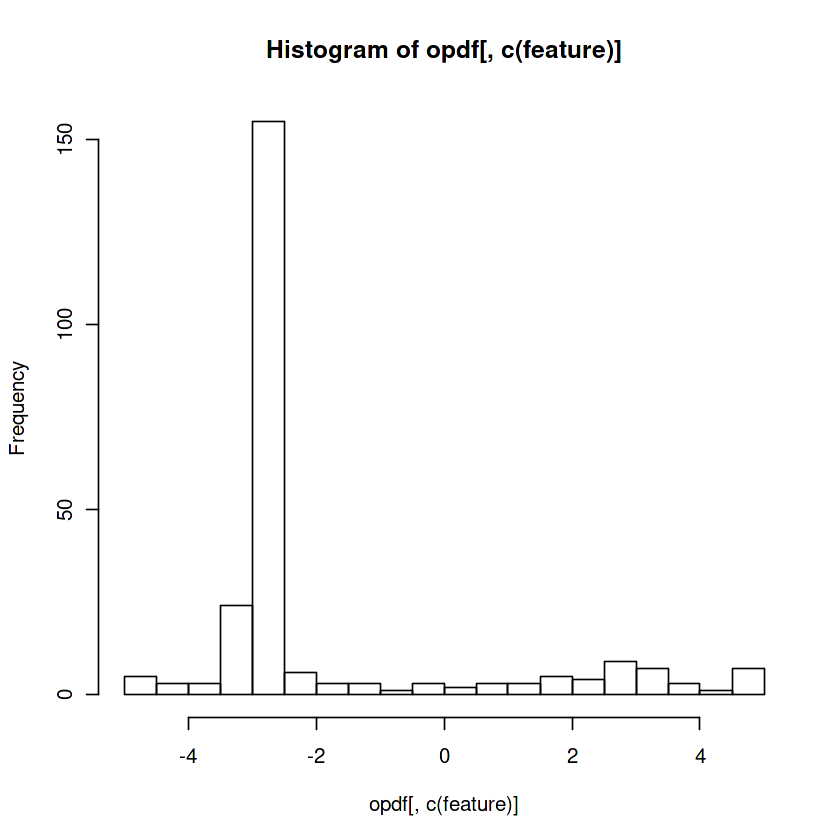

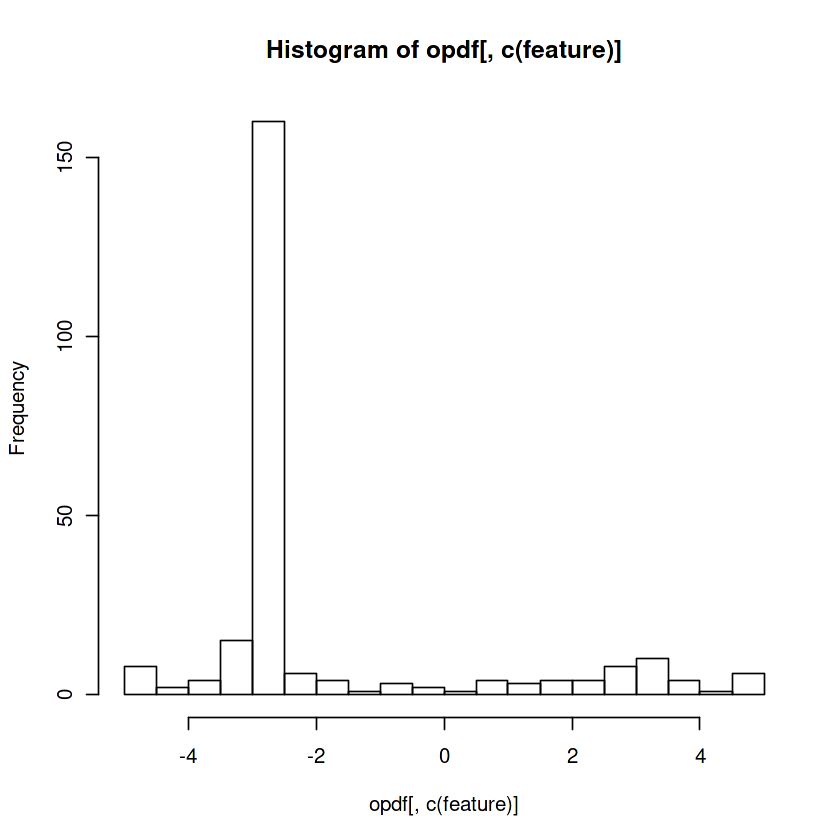

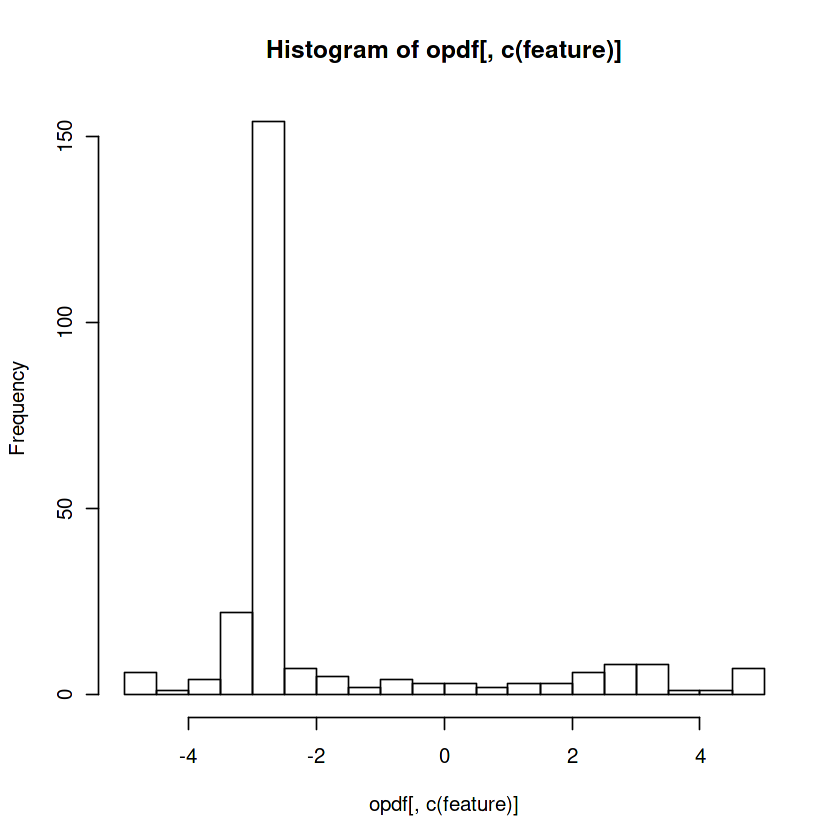

In [221]:
diffs[["3D"]] = compute_mean_difference_synthetic(3, lambda_vals, breaks = 20)

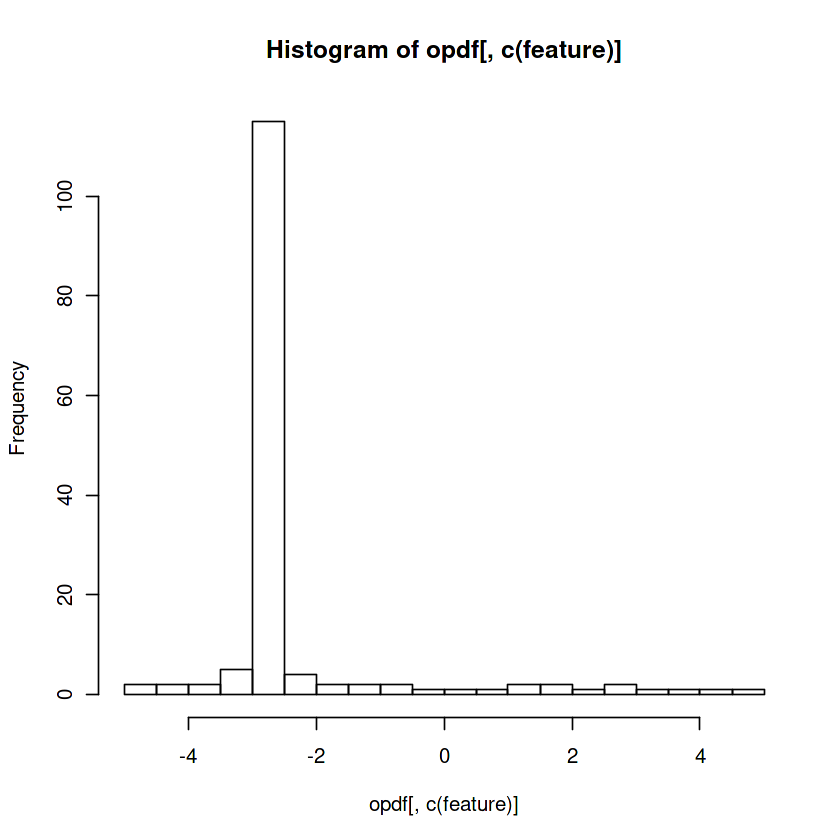

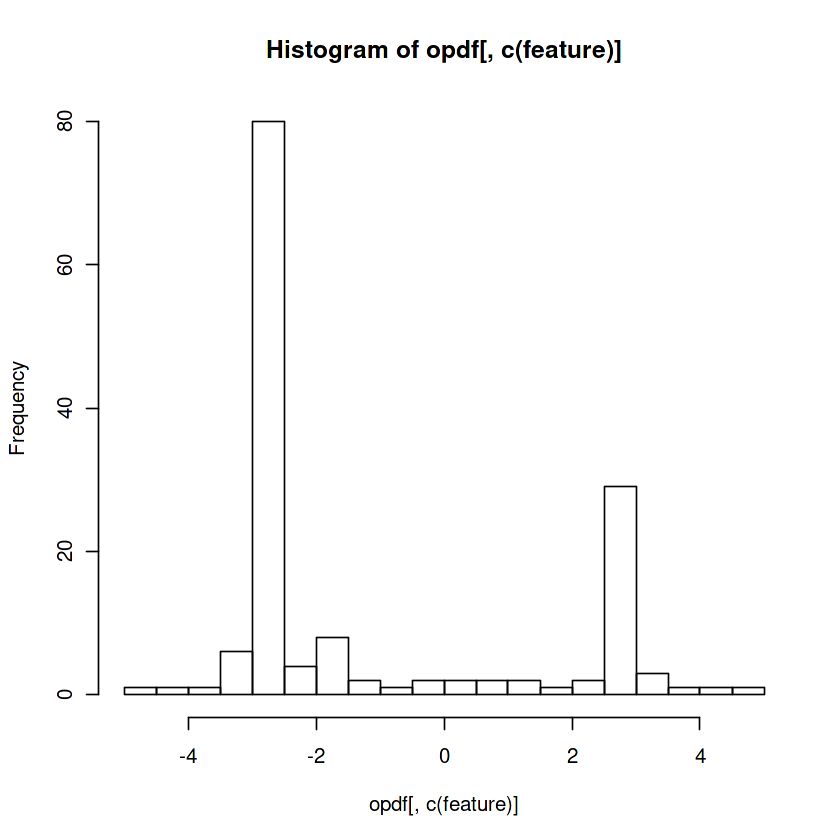

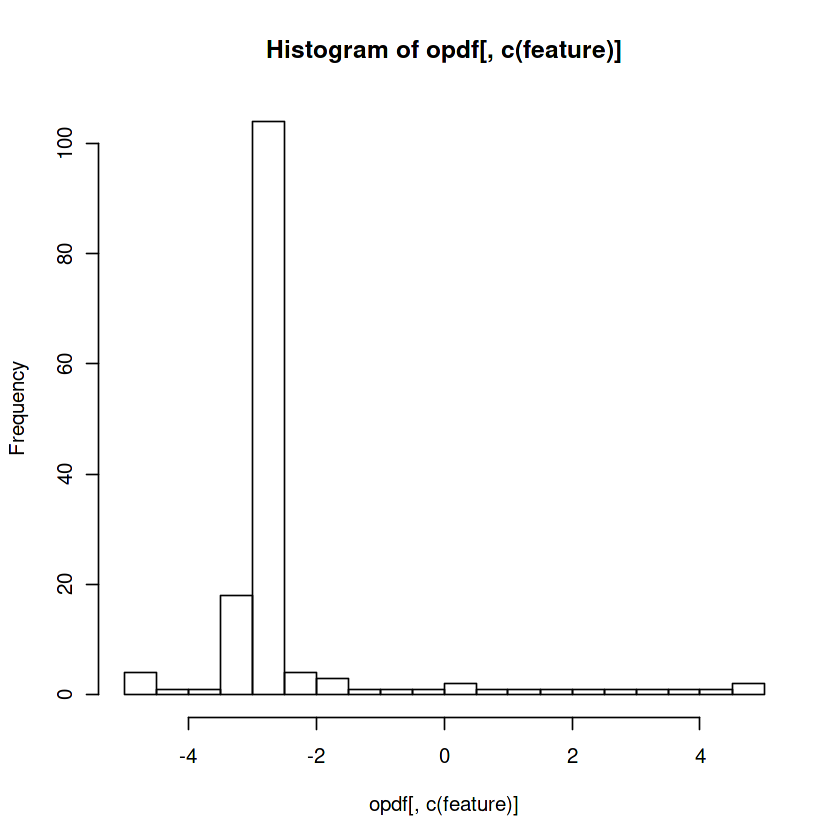

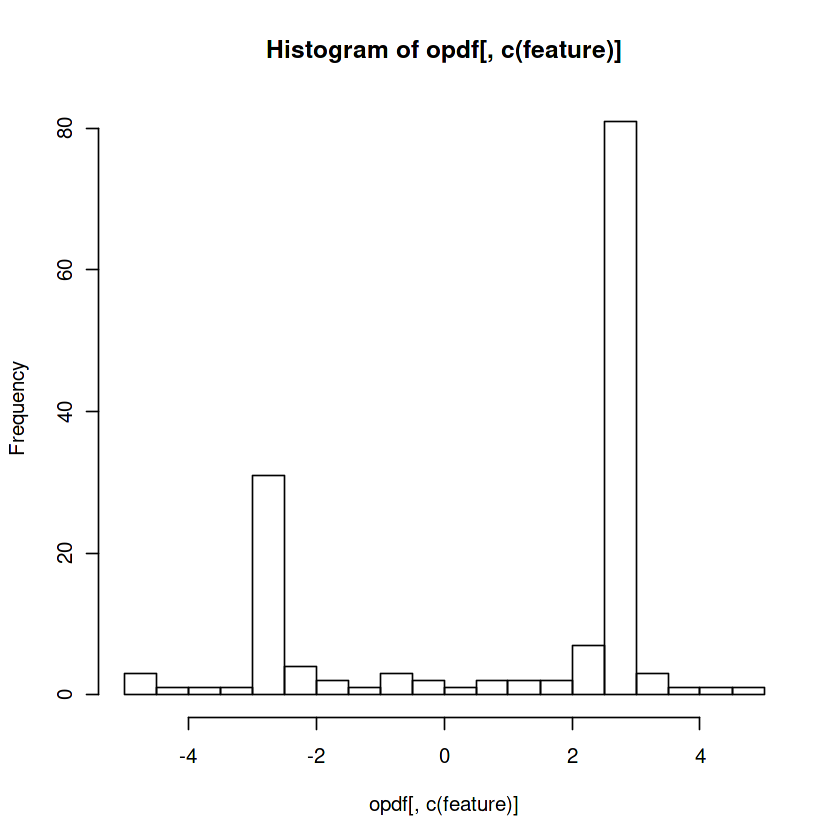

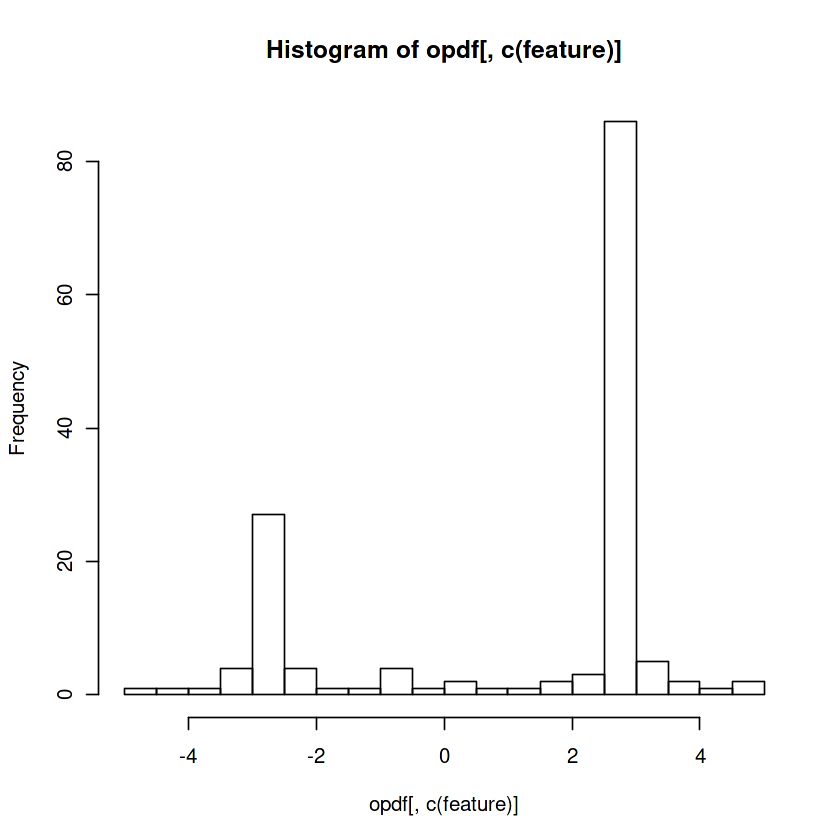

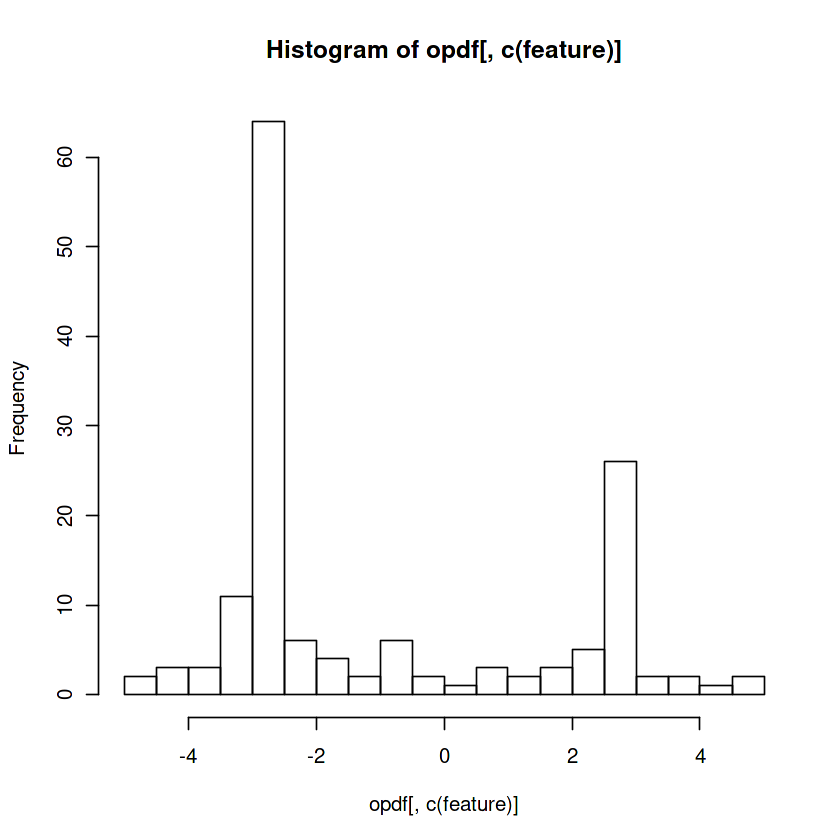

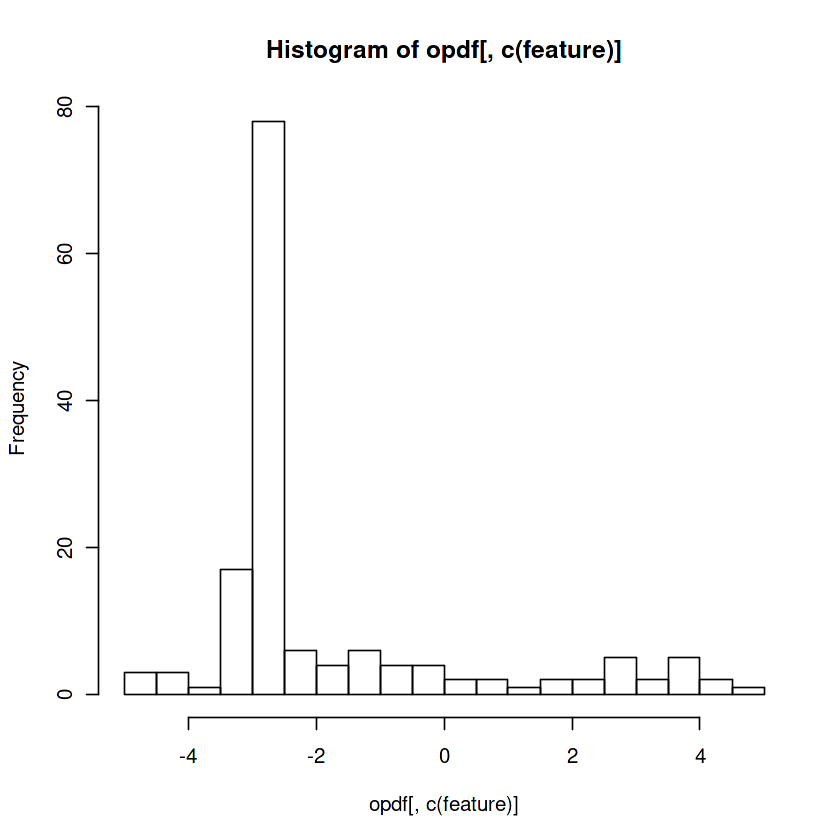

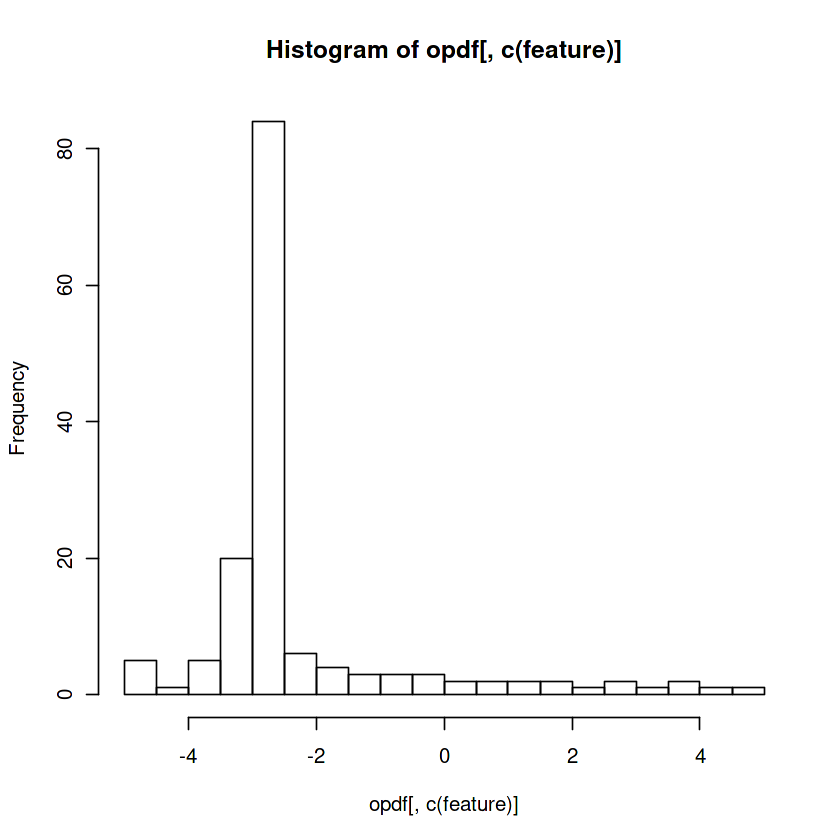

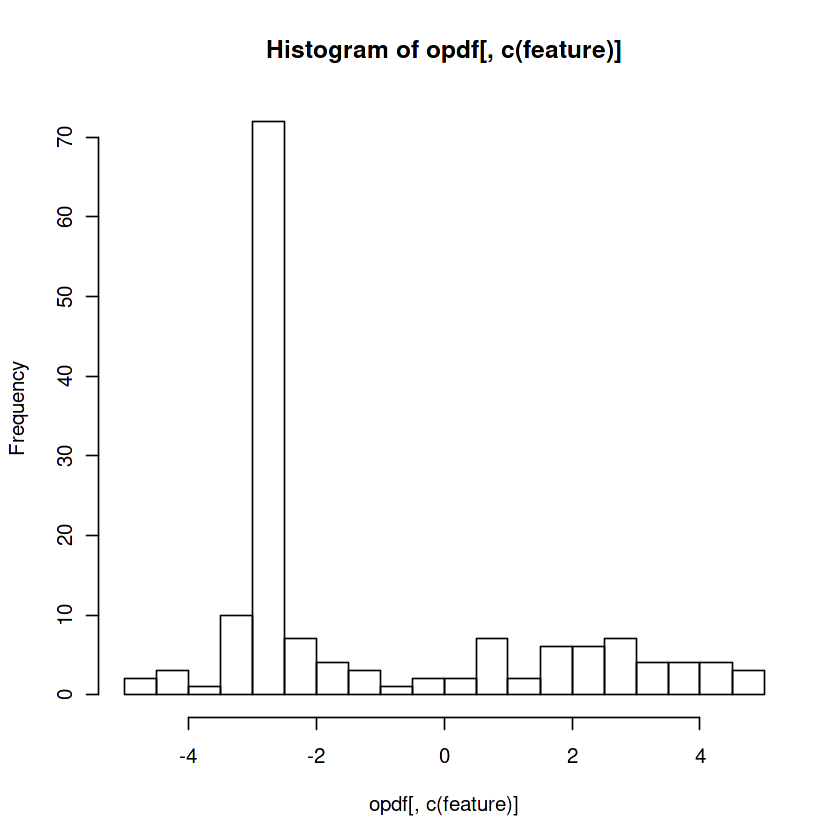

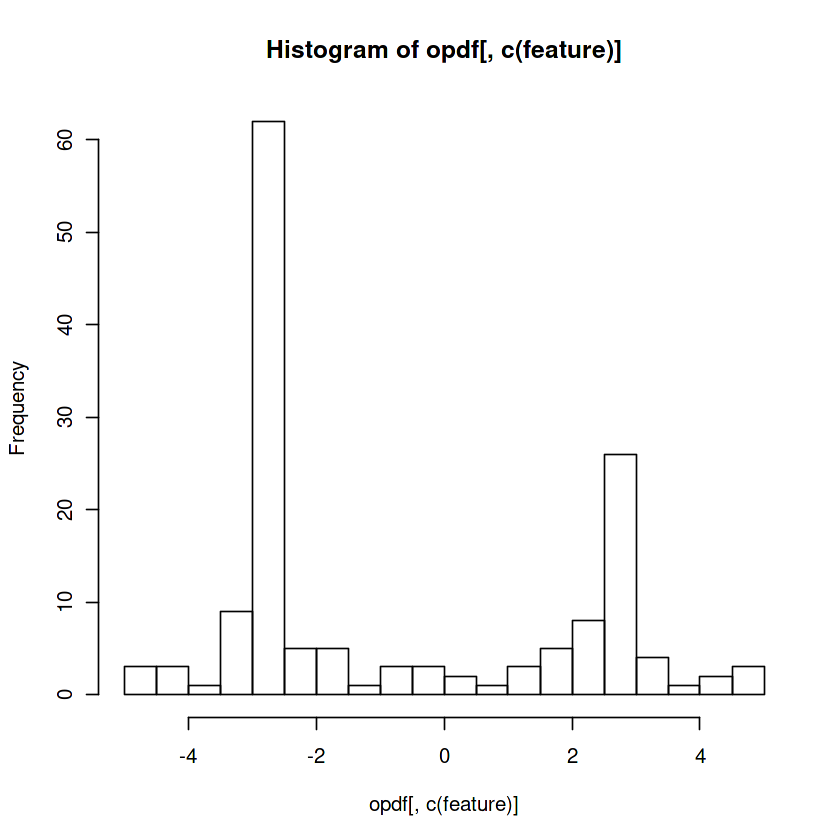

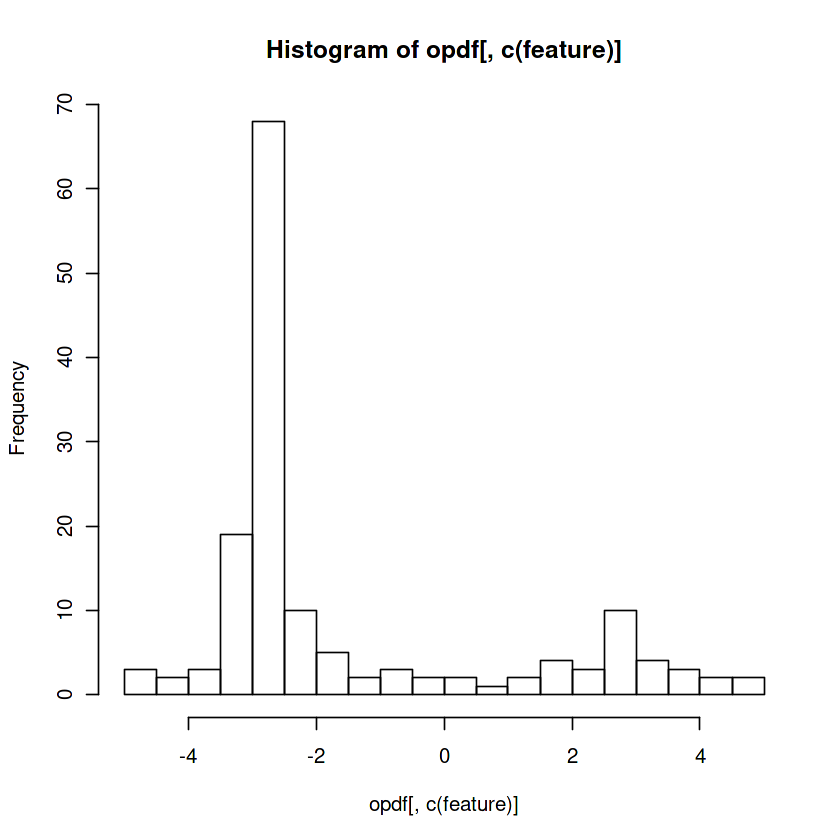

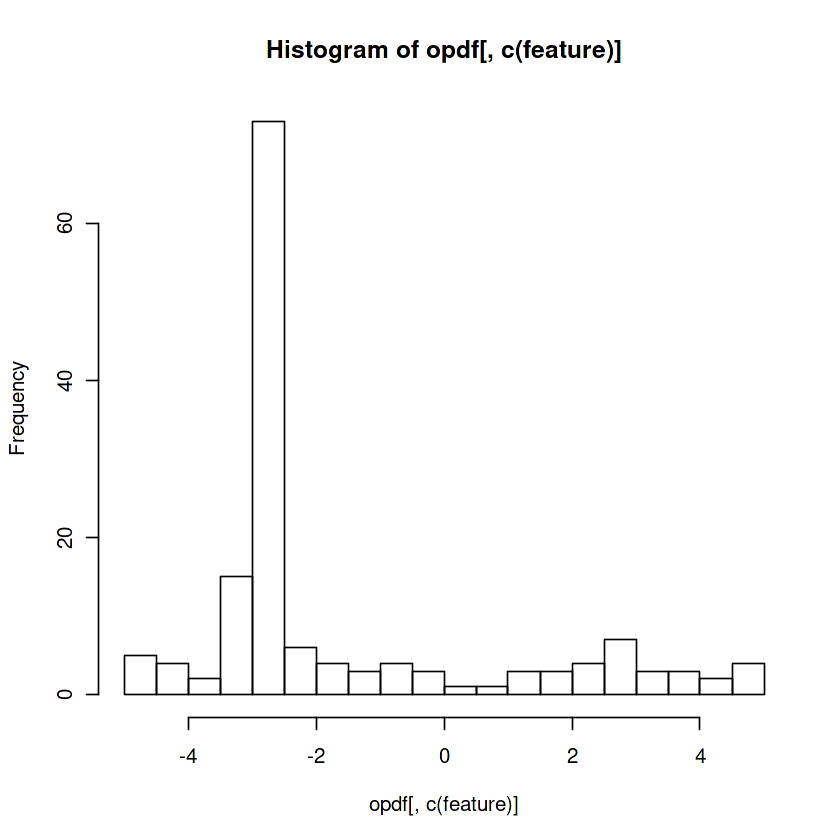

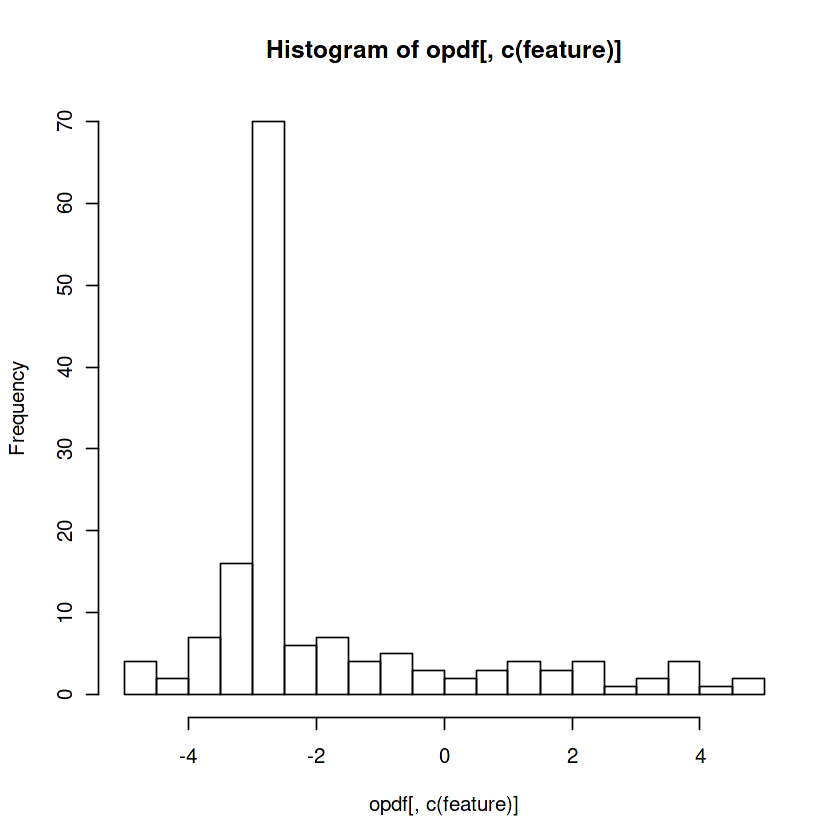

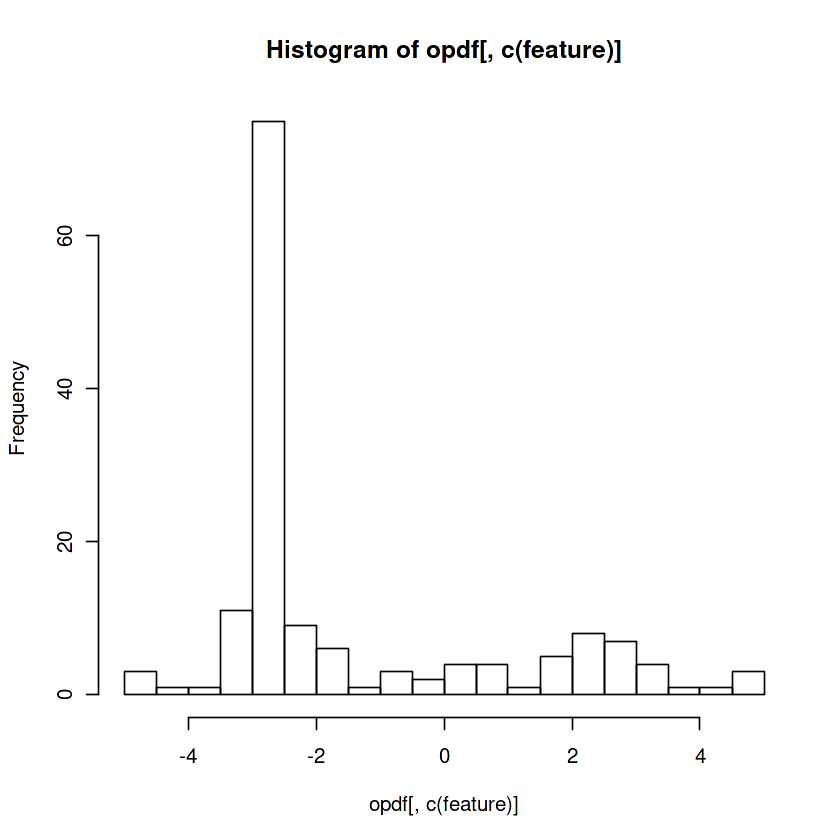

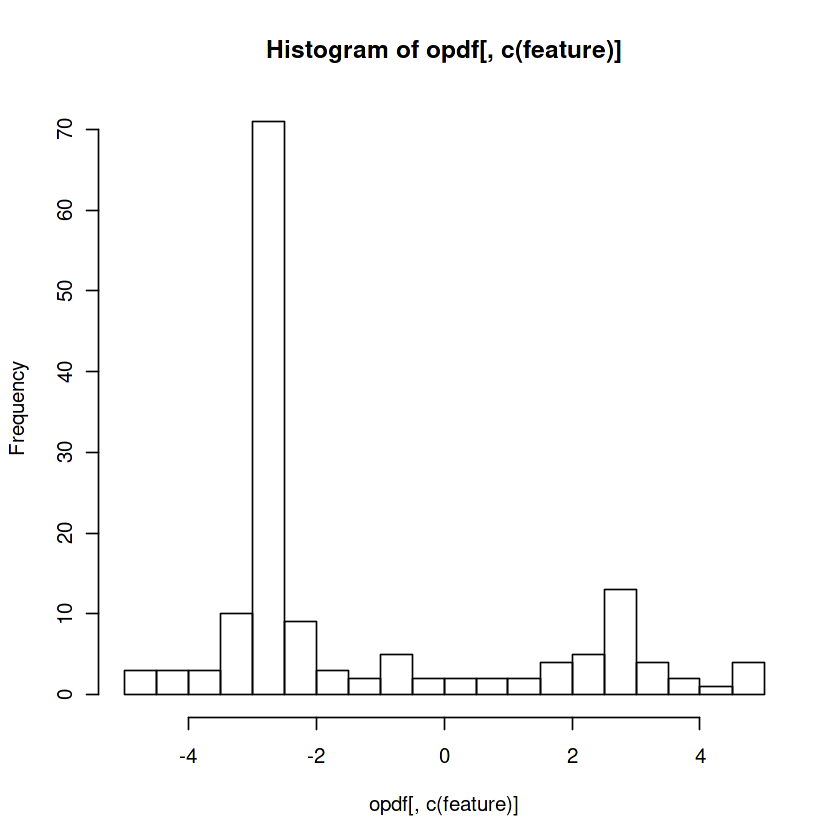

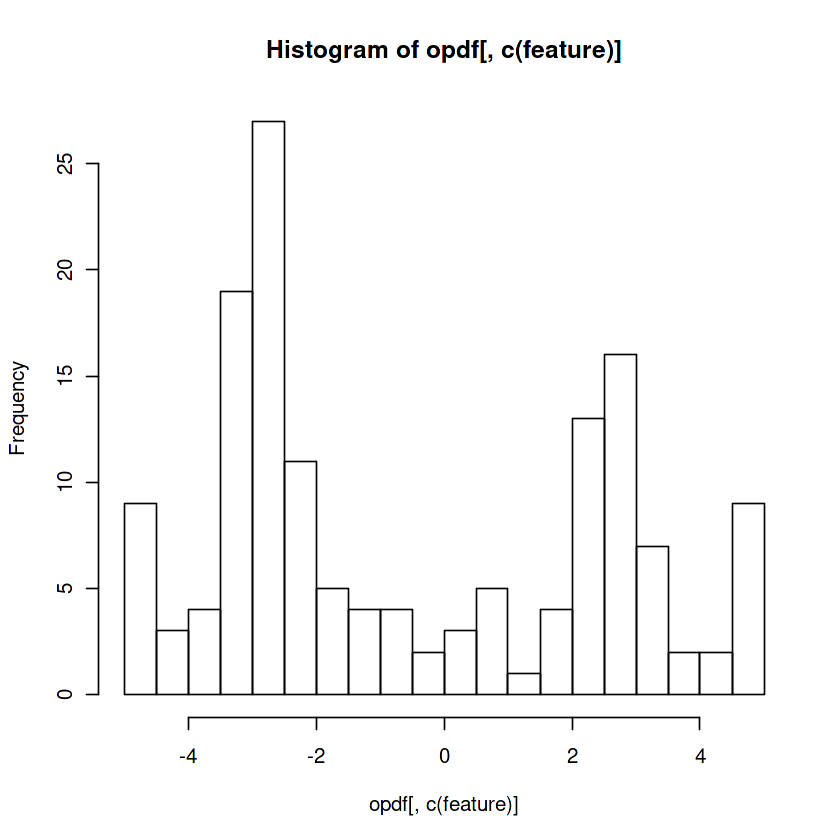

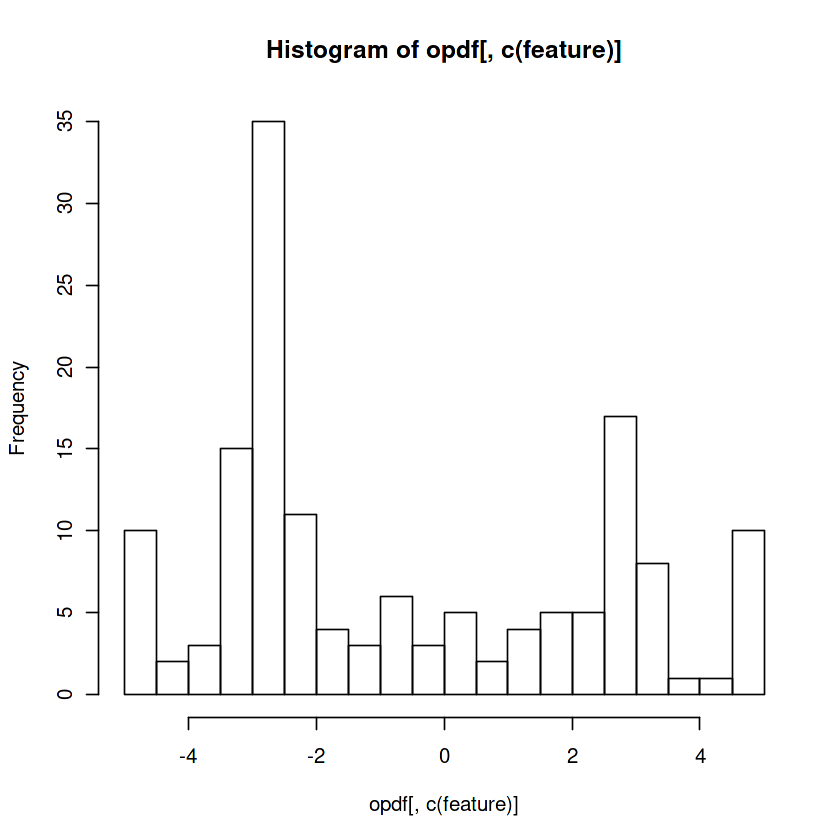

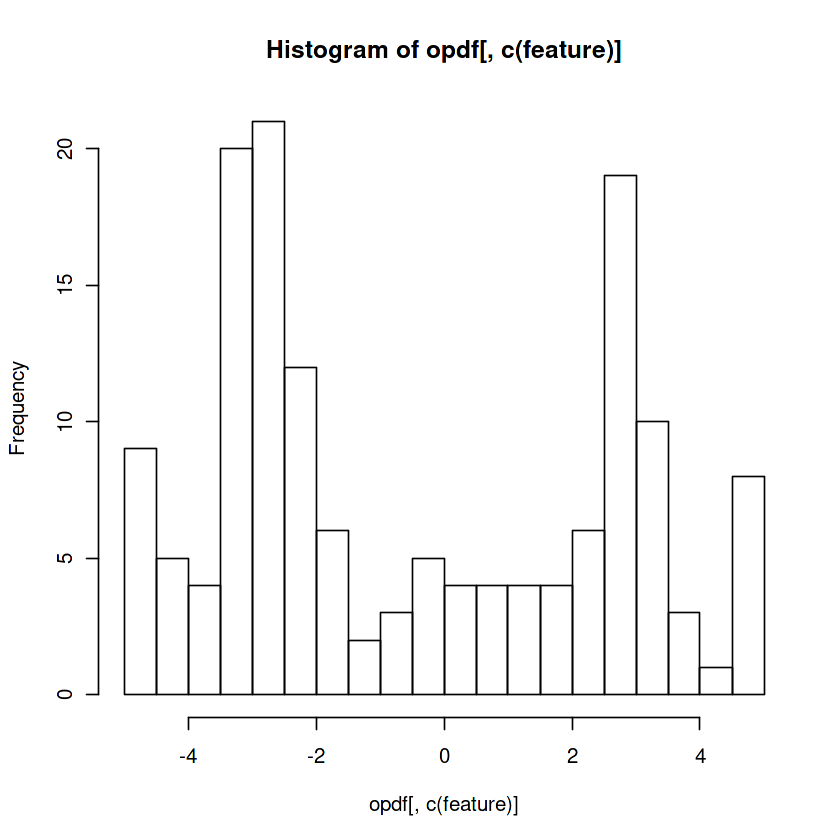

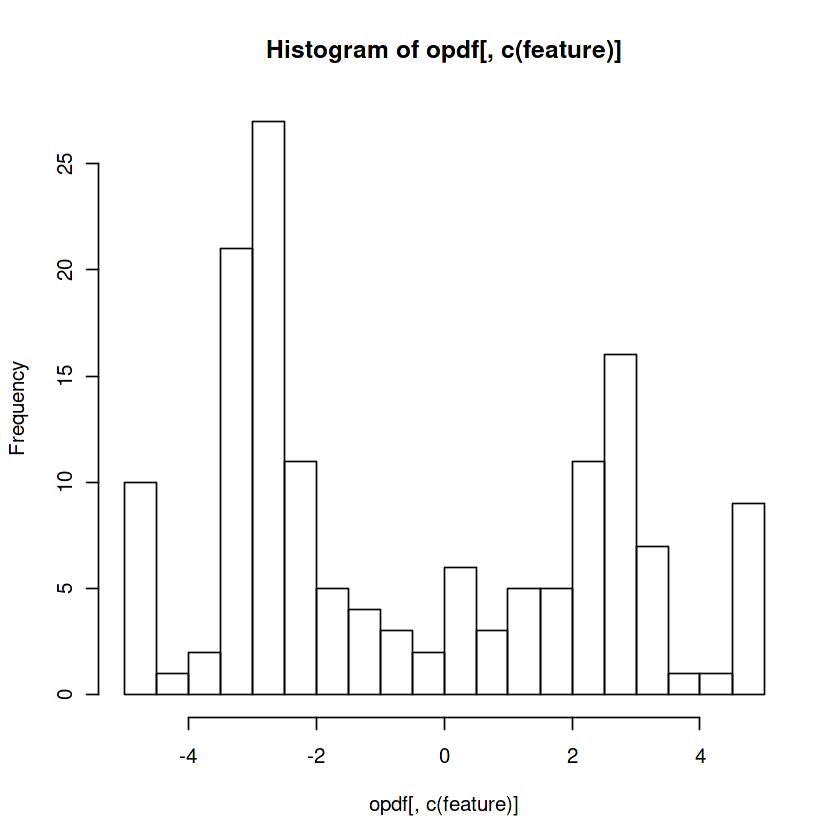

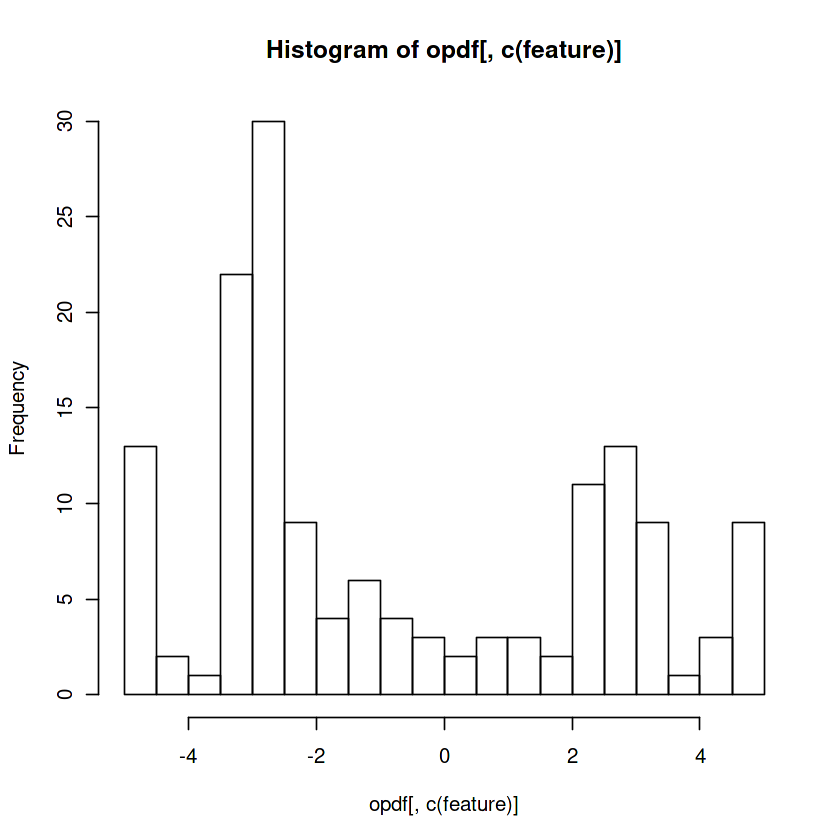

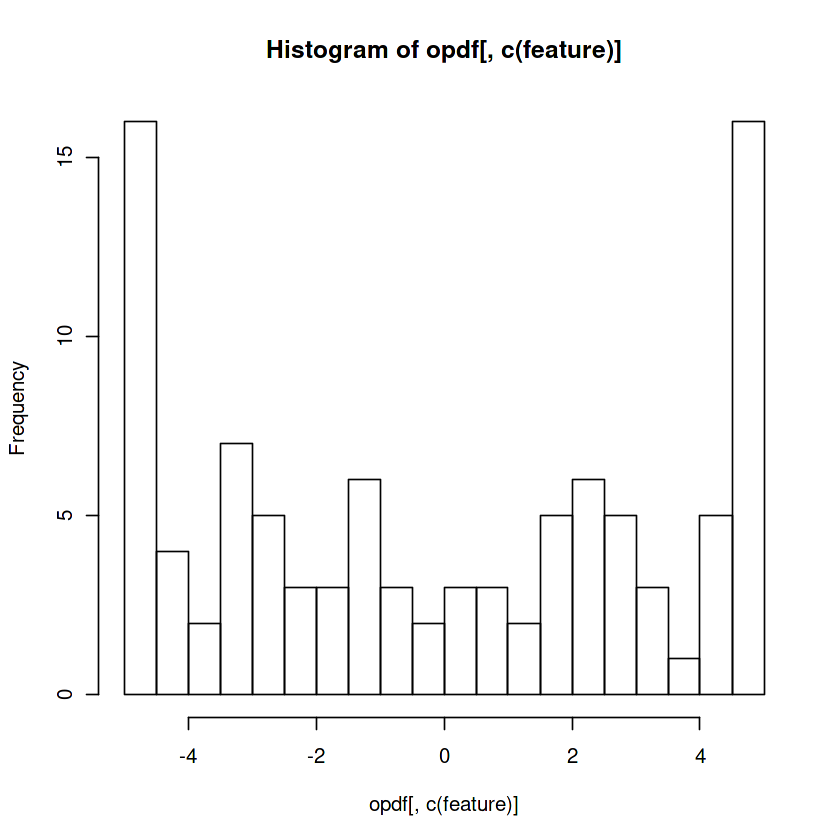

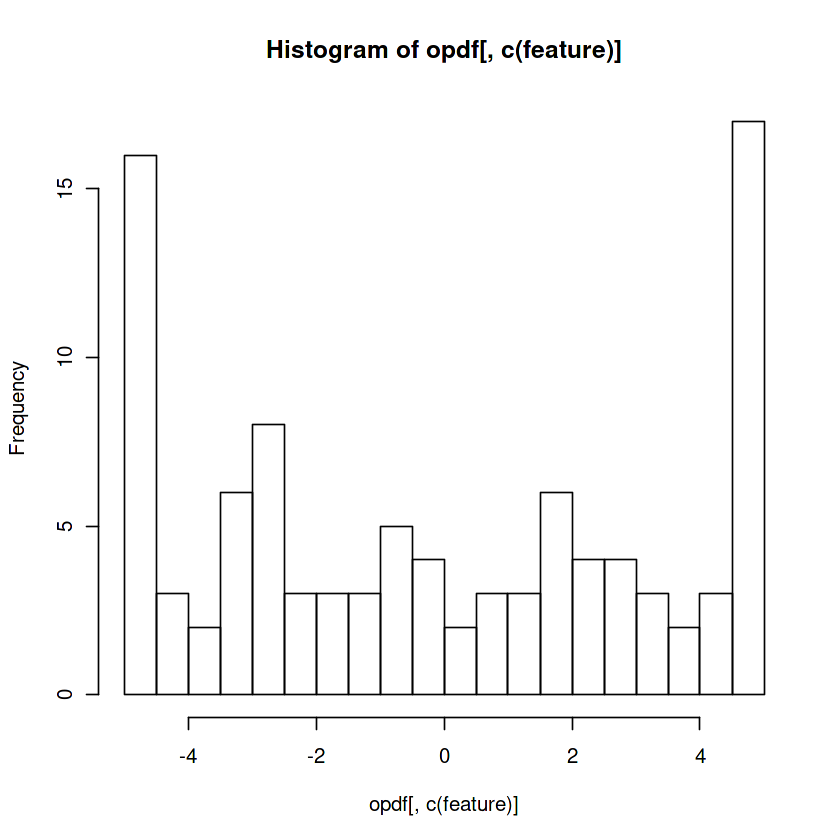

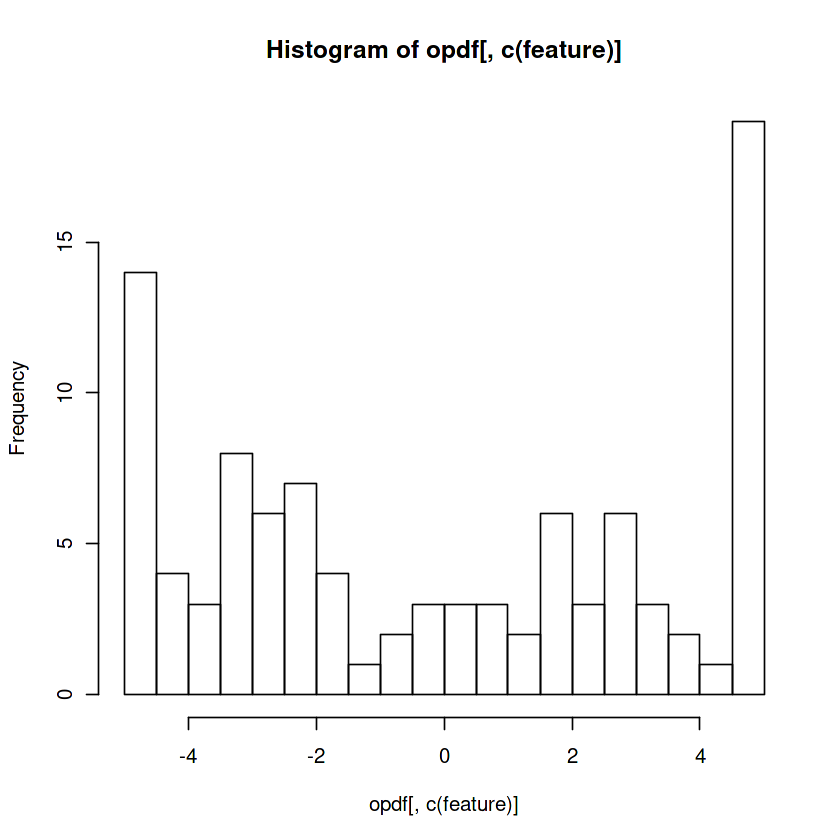

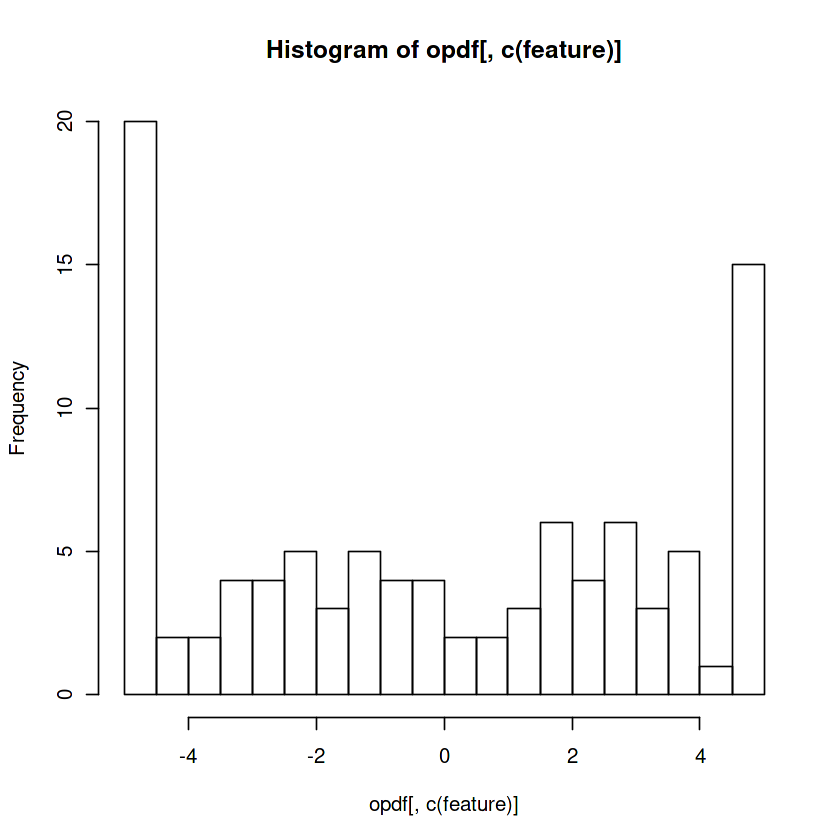

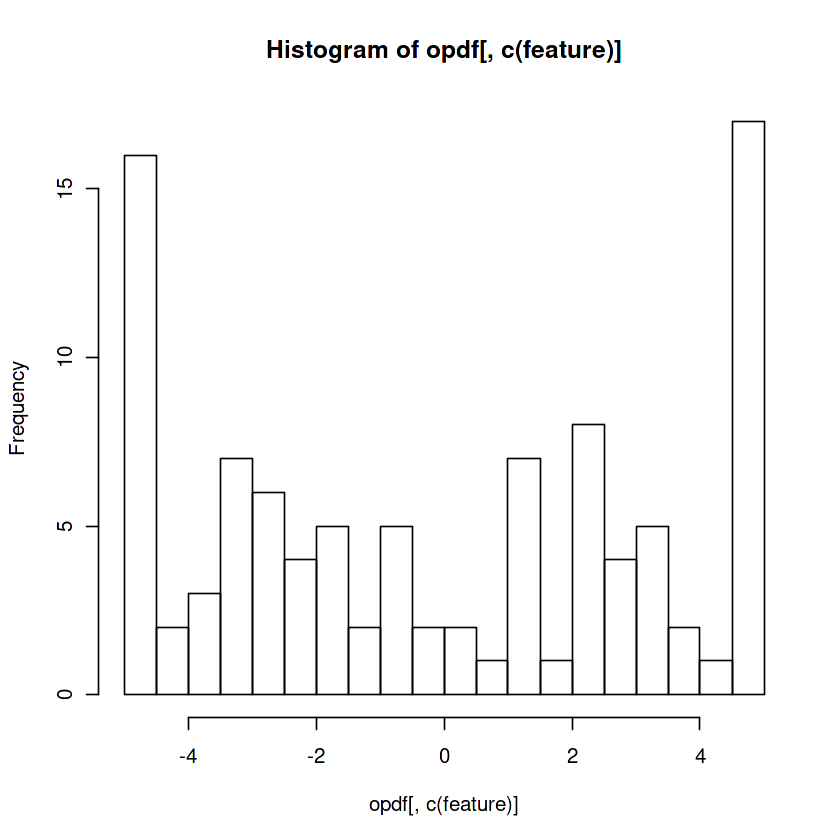

In [222]:
diffs[["5D"]] = compute_mean_difference_synthetic(5, lambda_vals, breaks = 30)

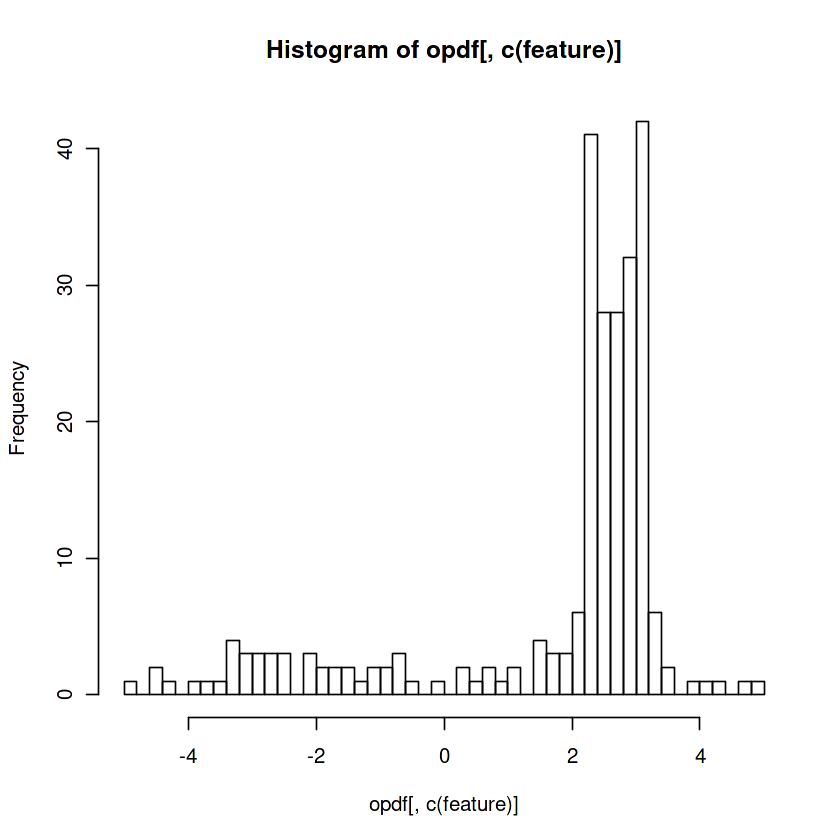

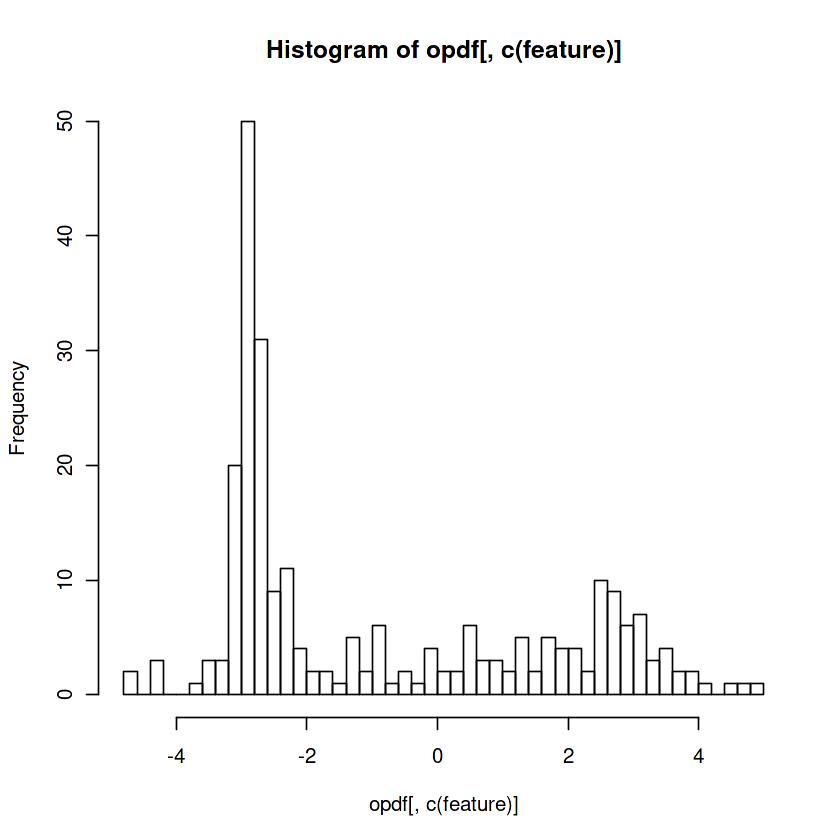

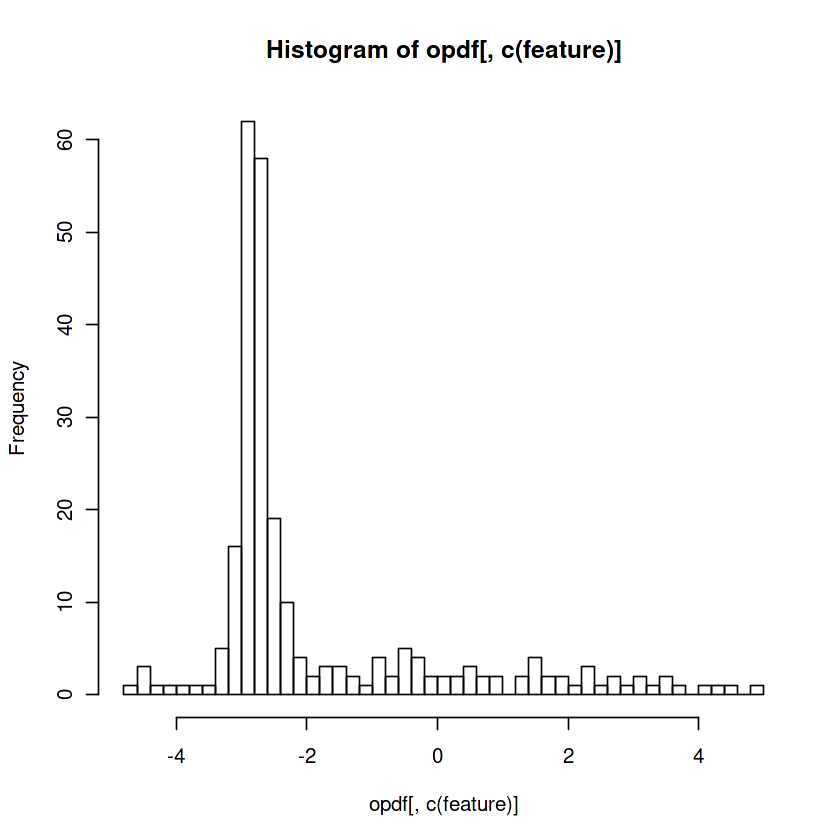

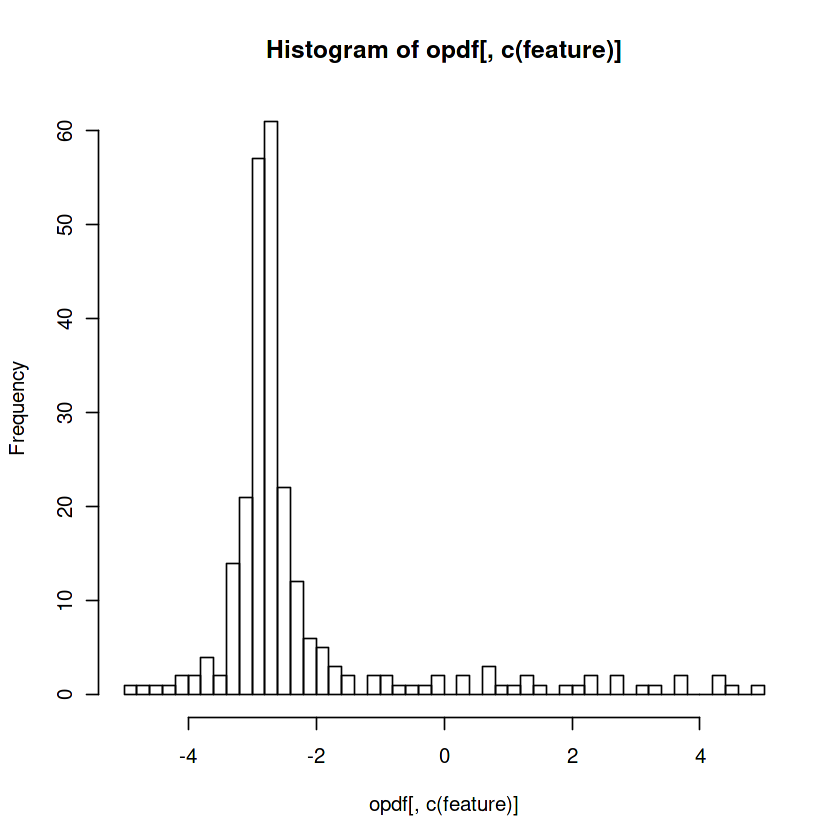

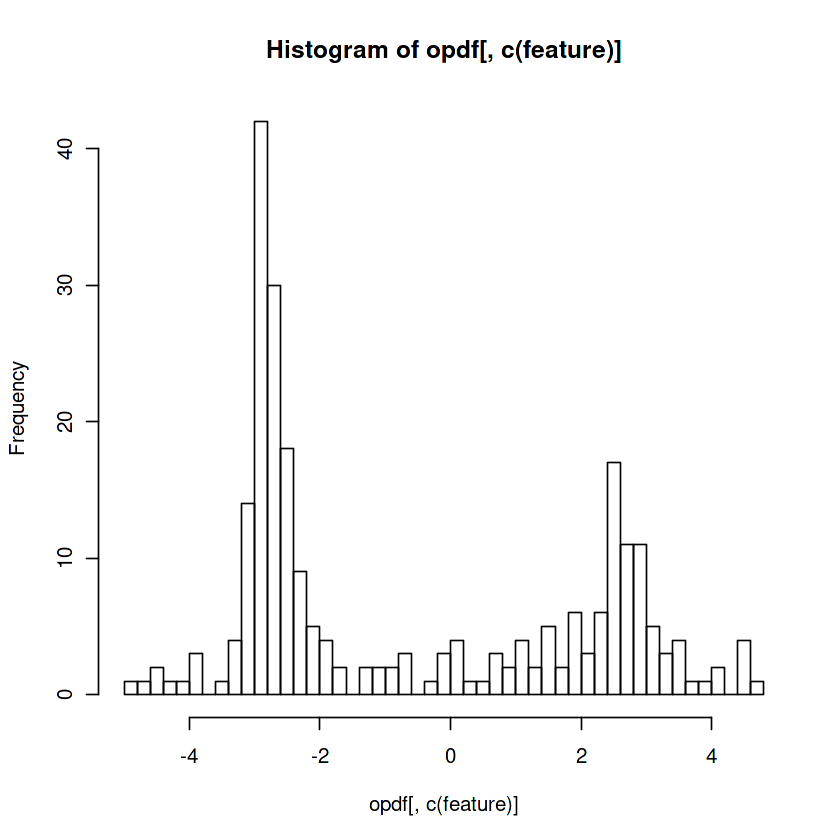

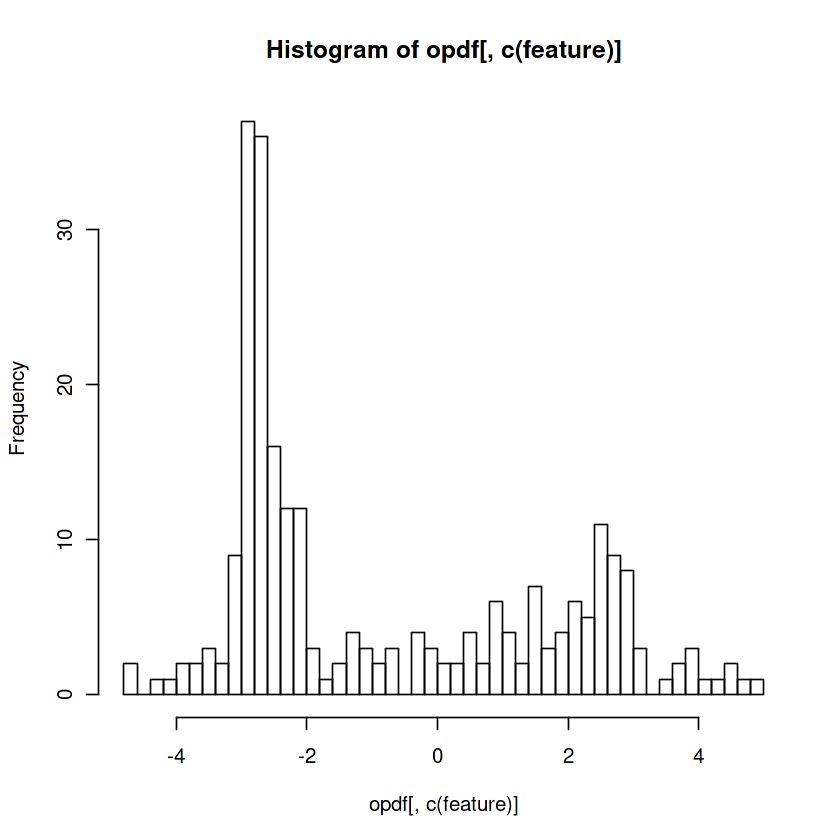

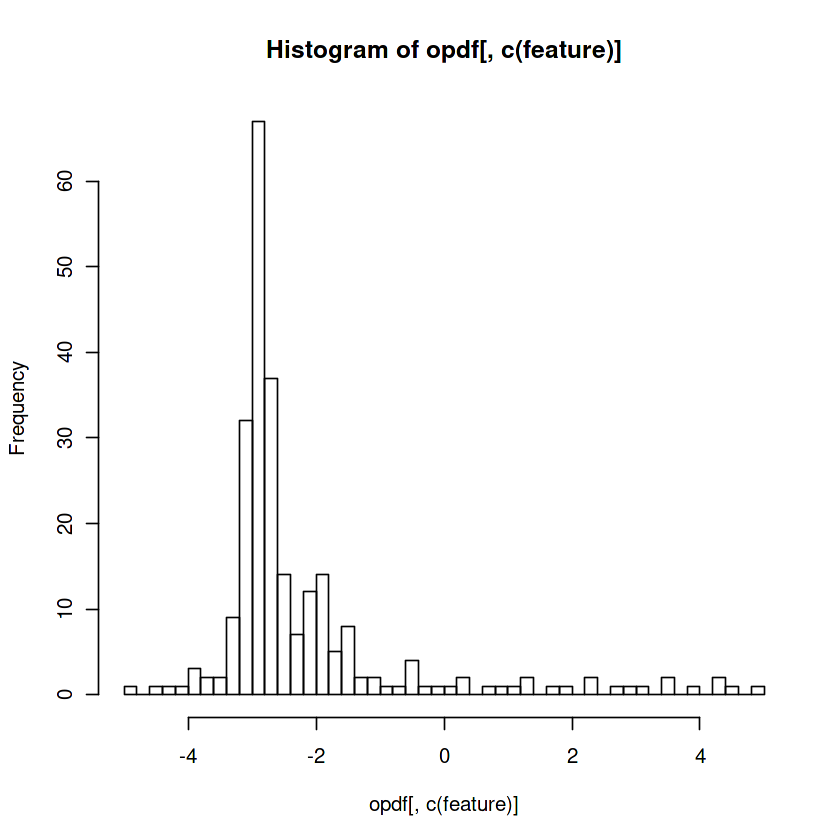

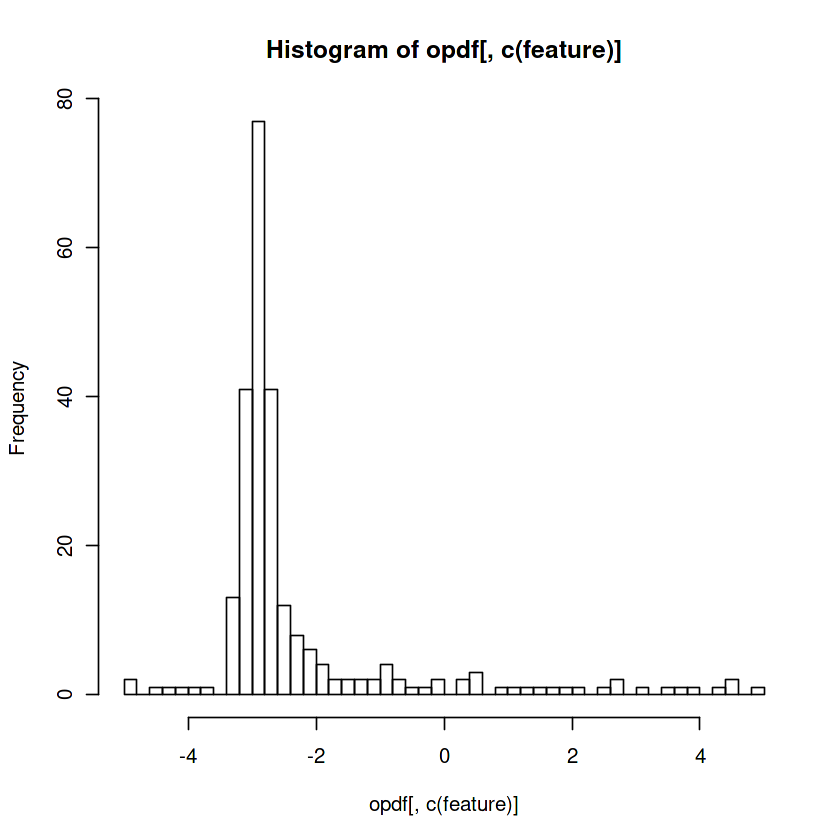

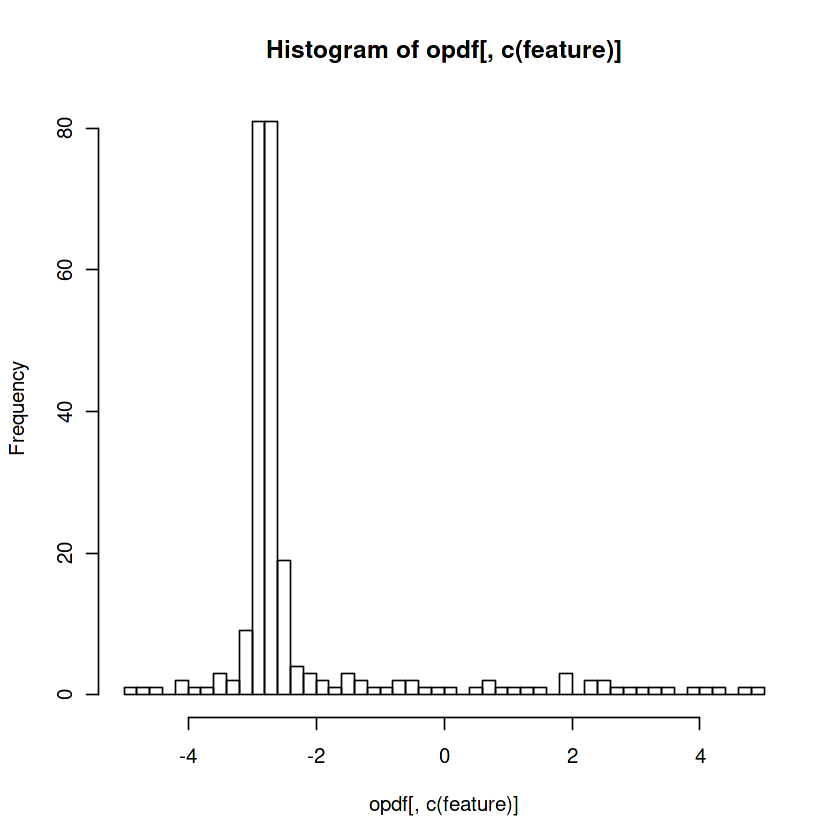

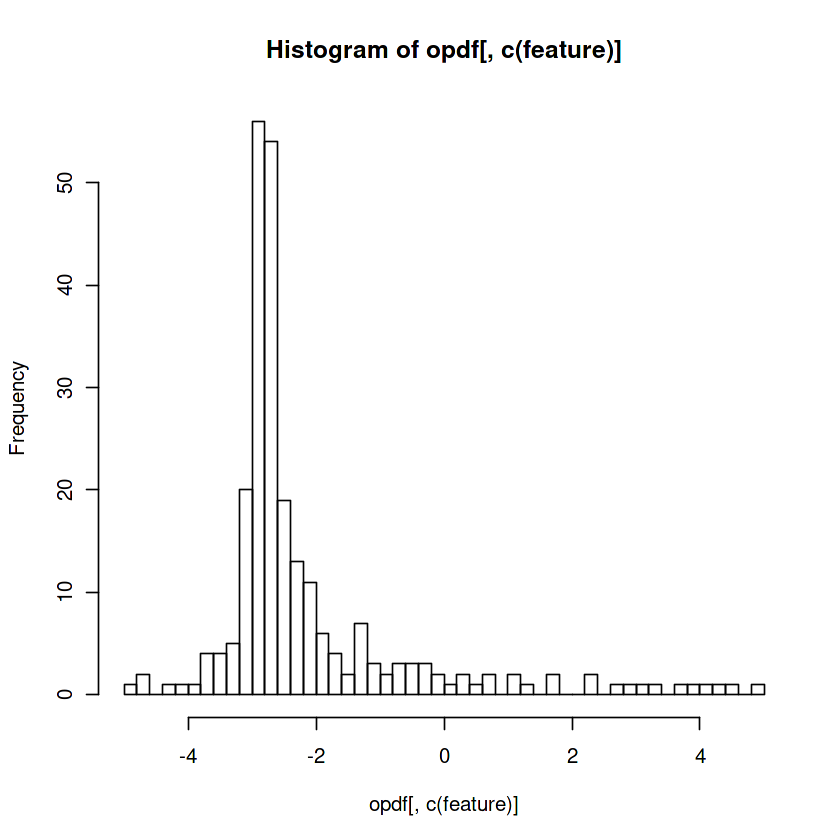

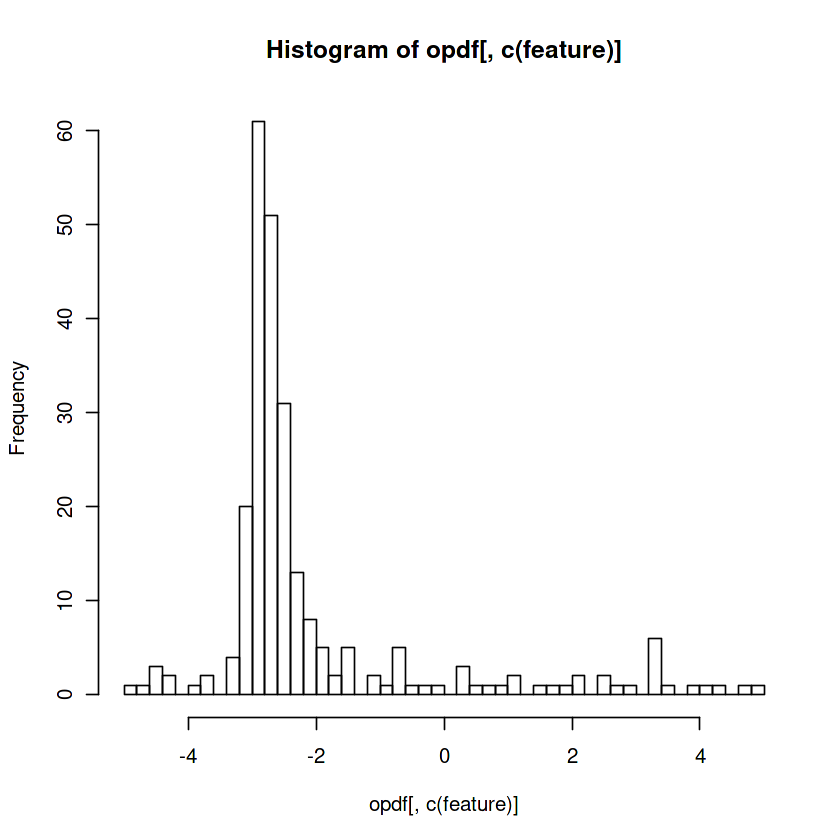

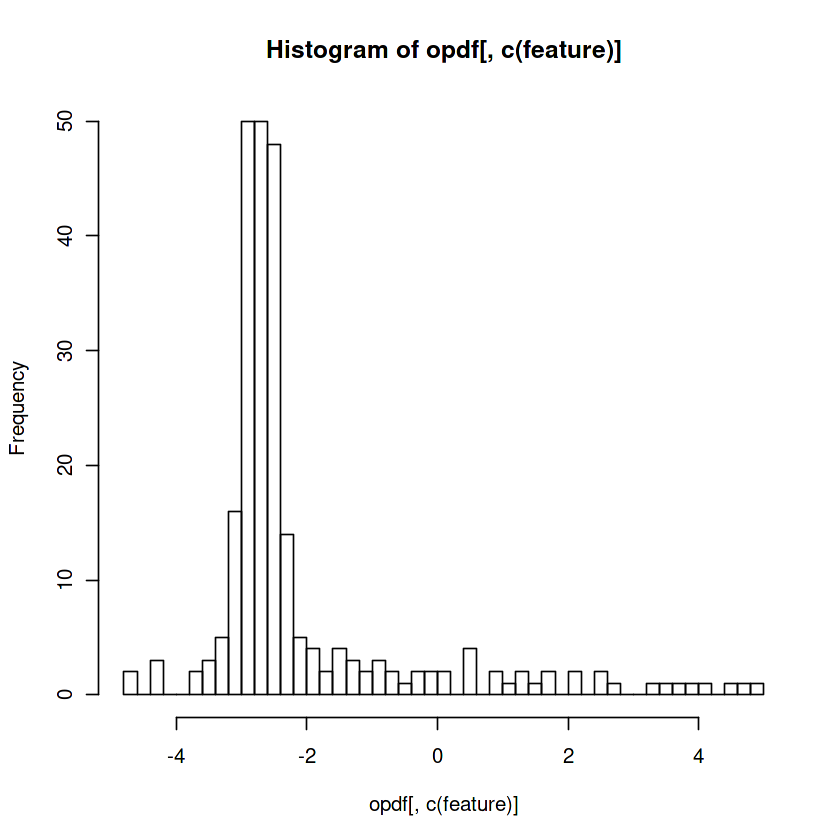

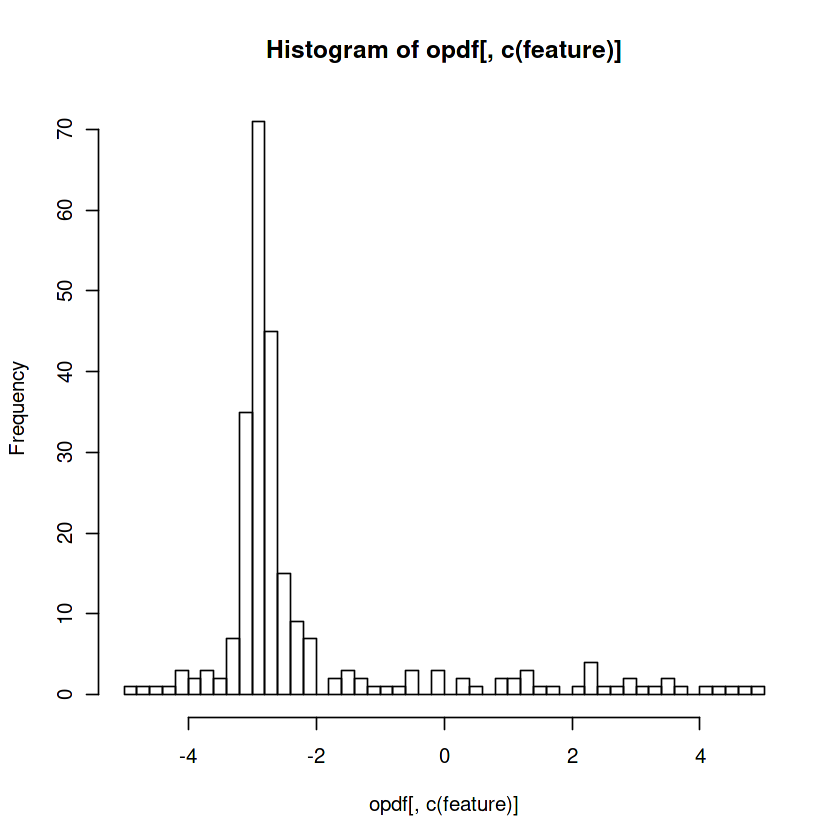

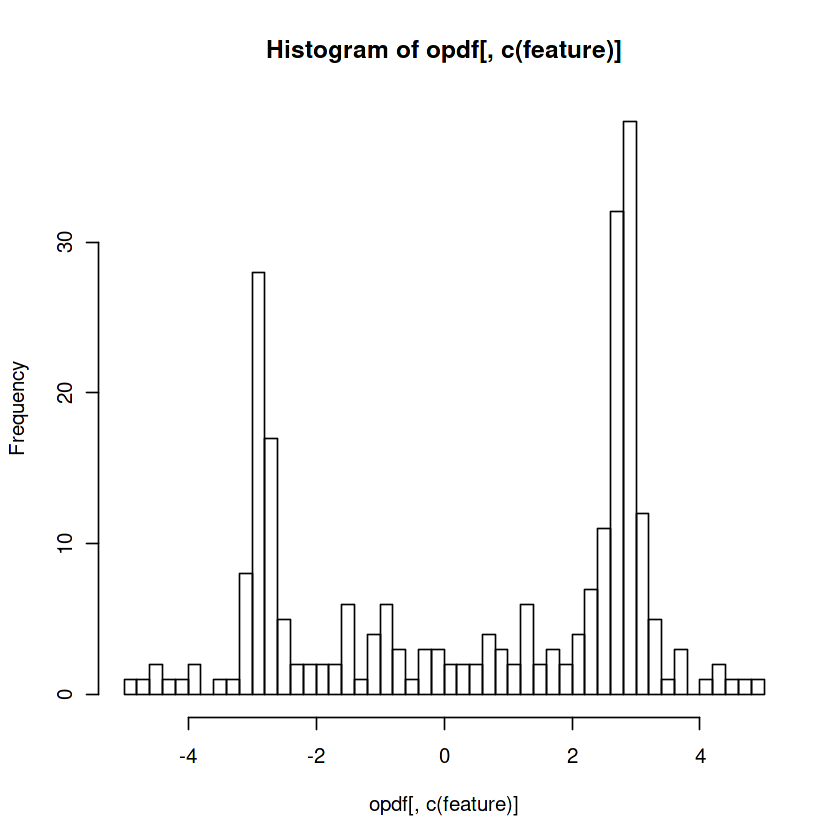

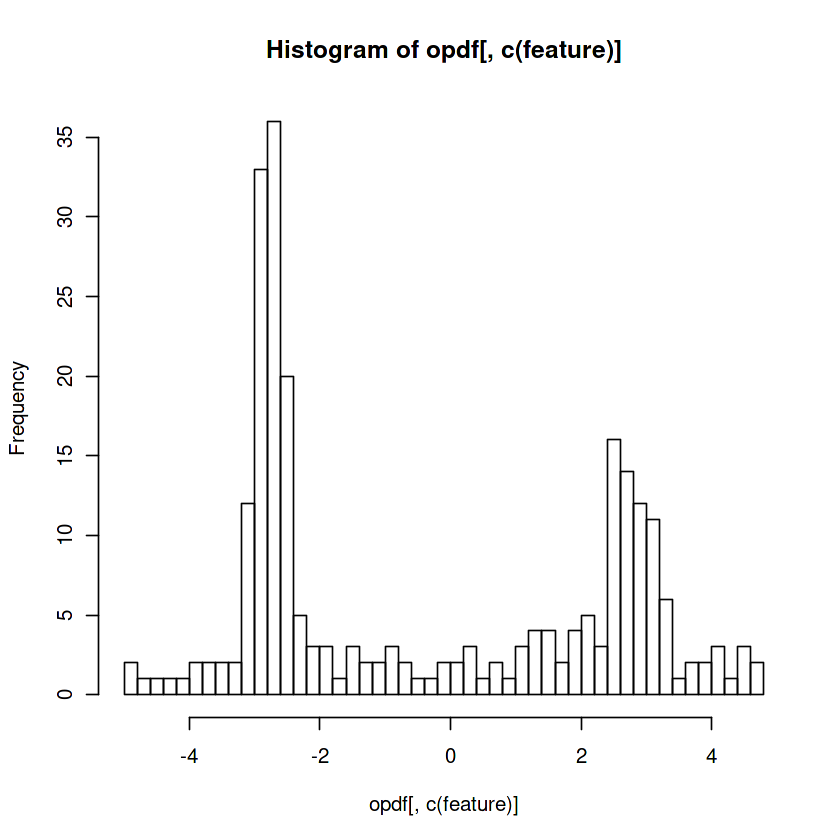

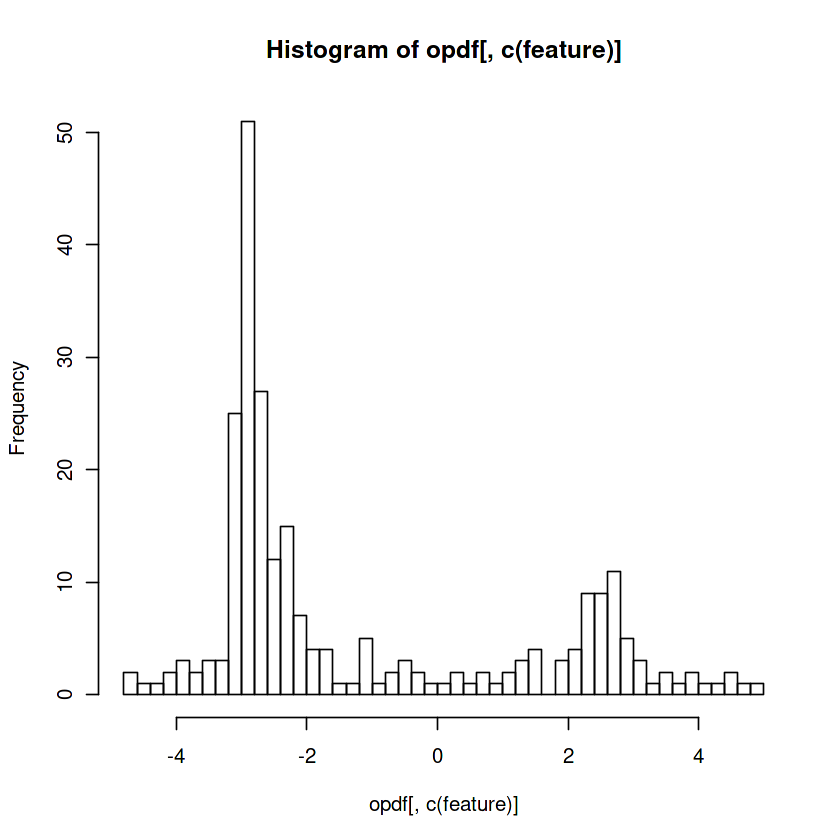

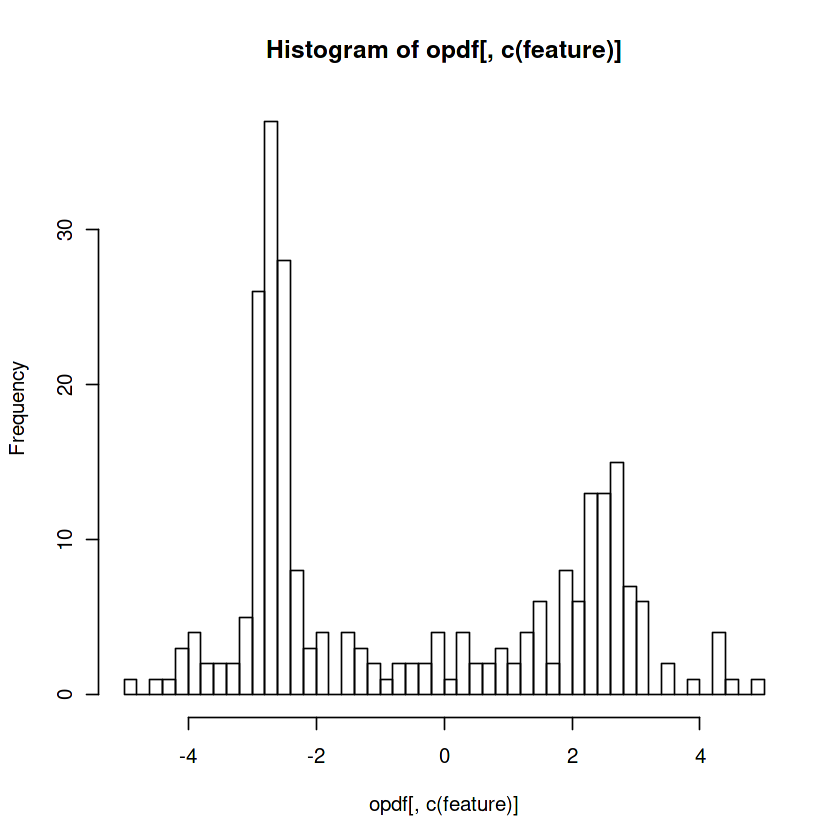

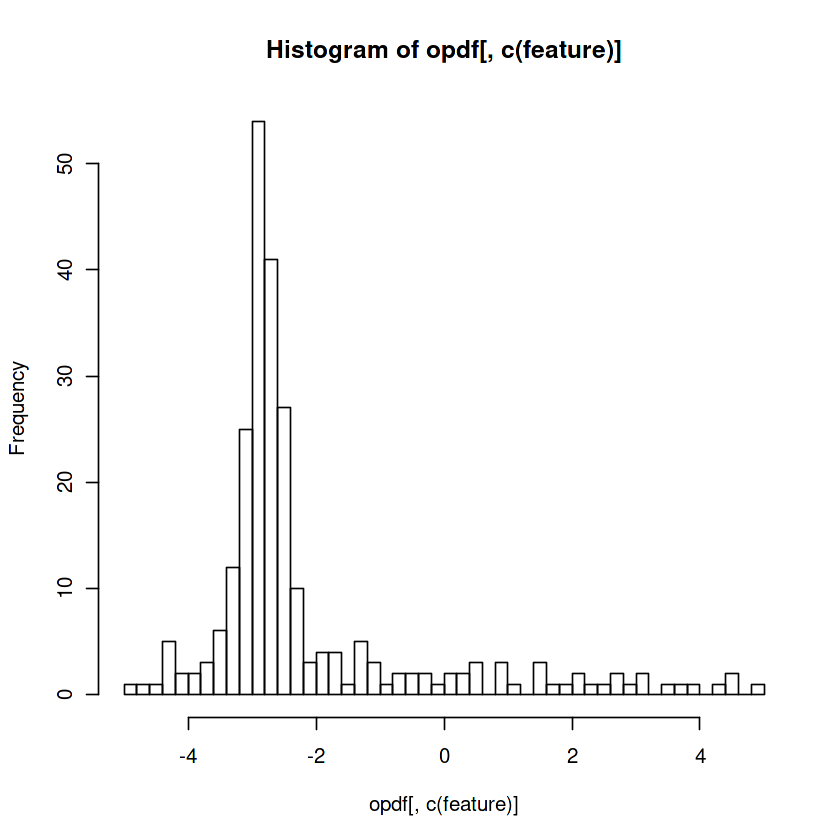

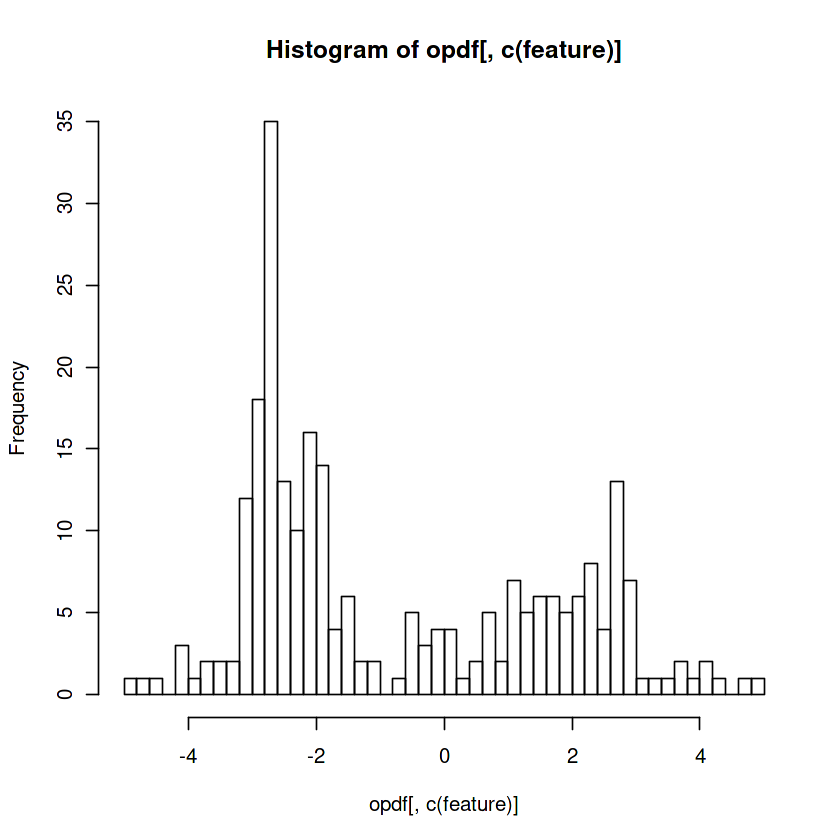

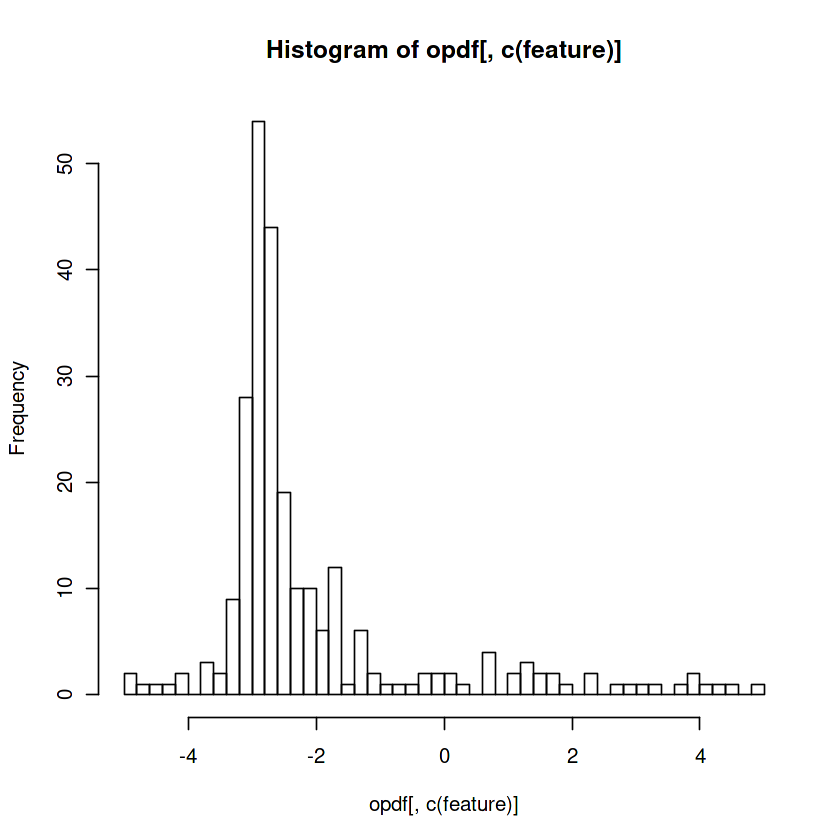

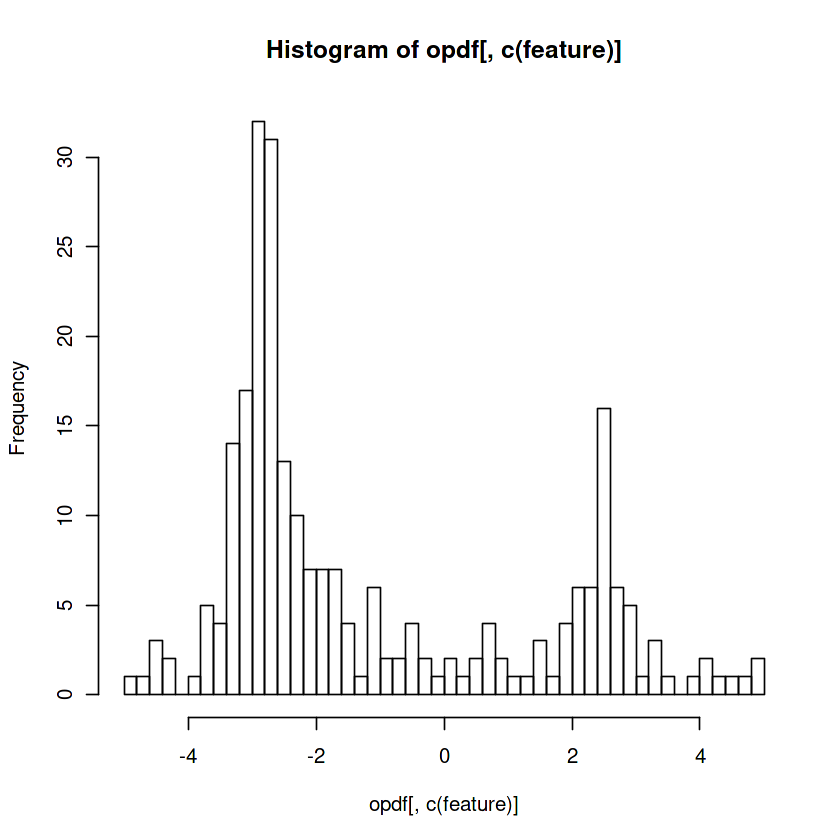

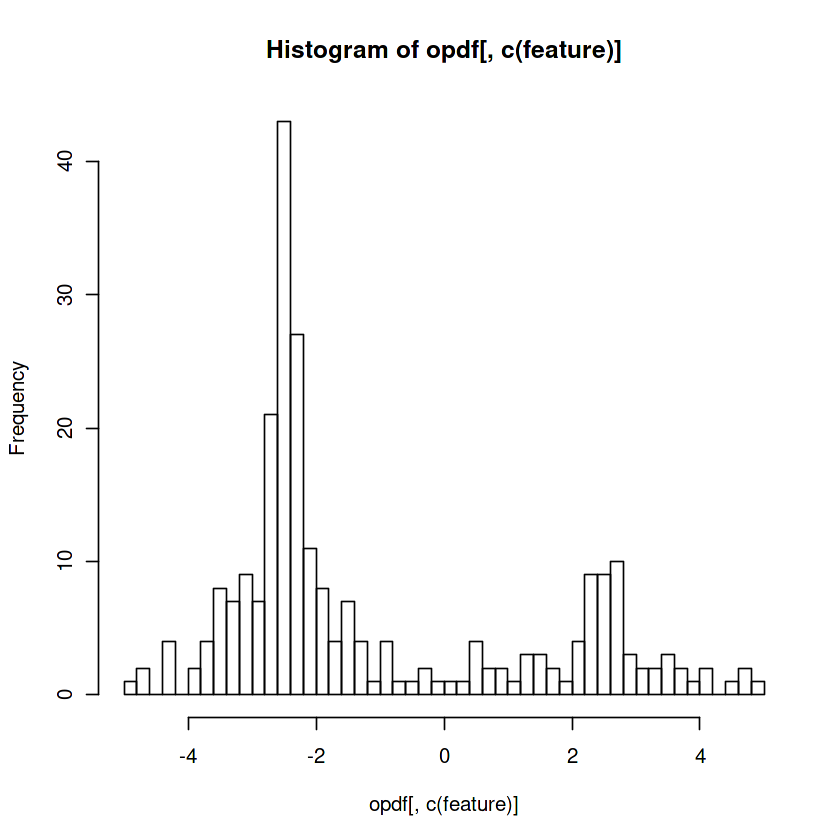

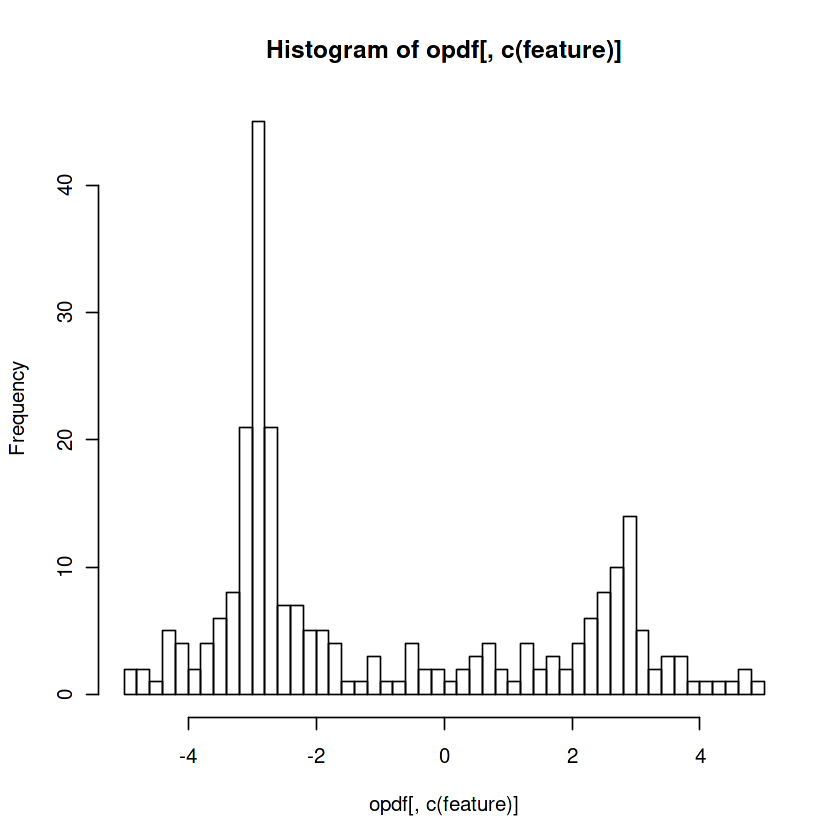

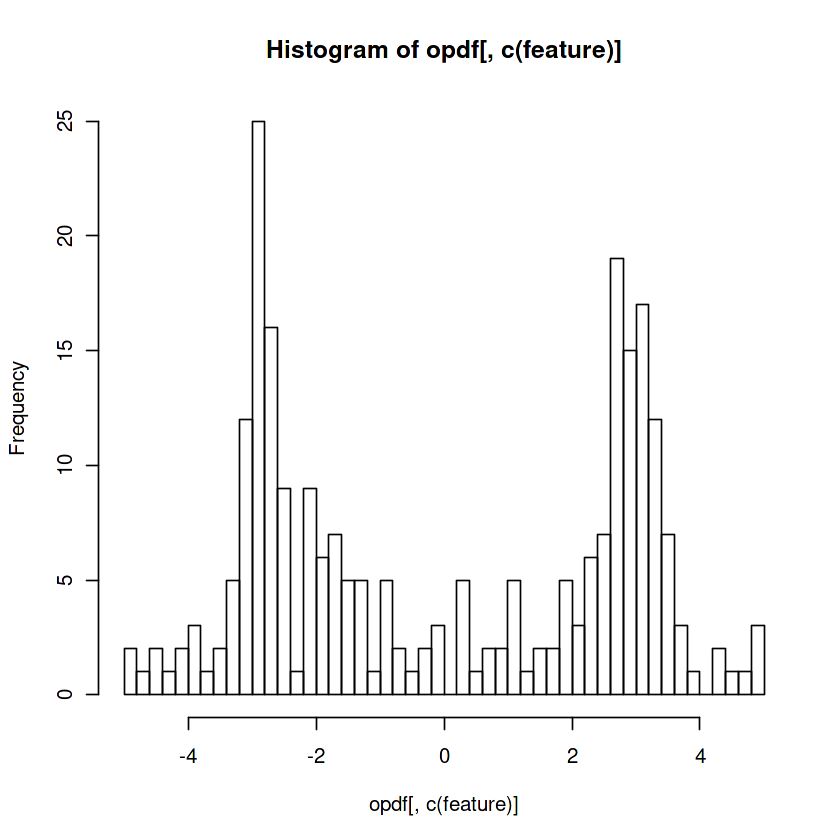

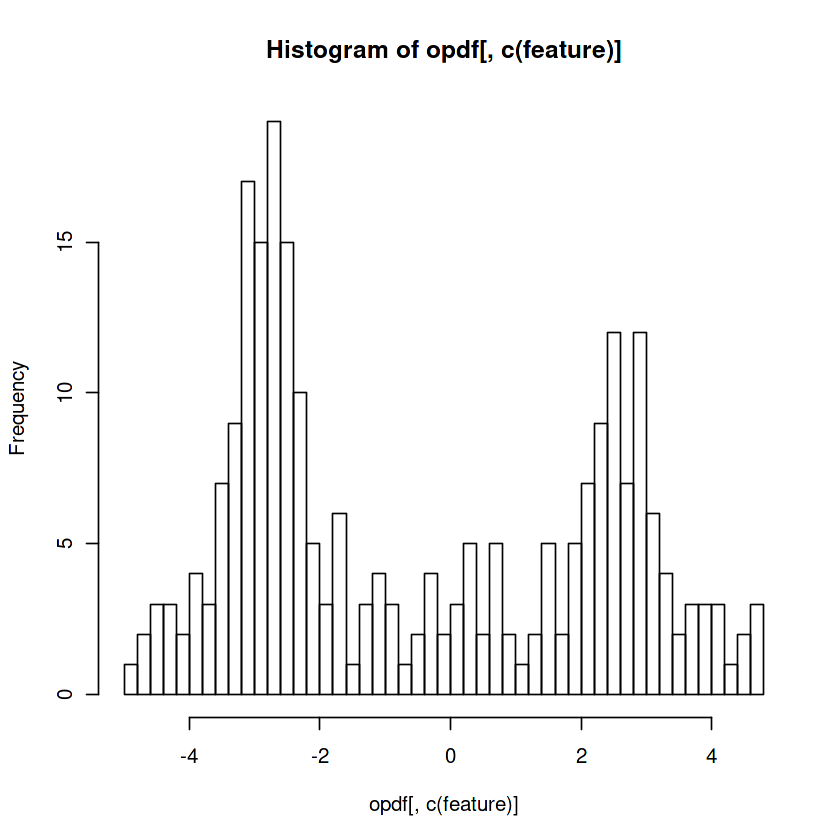

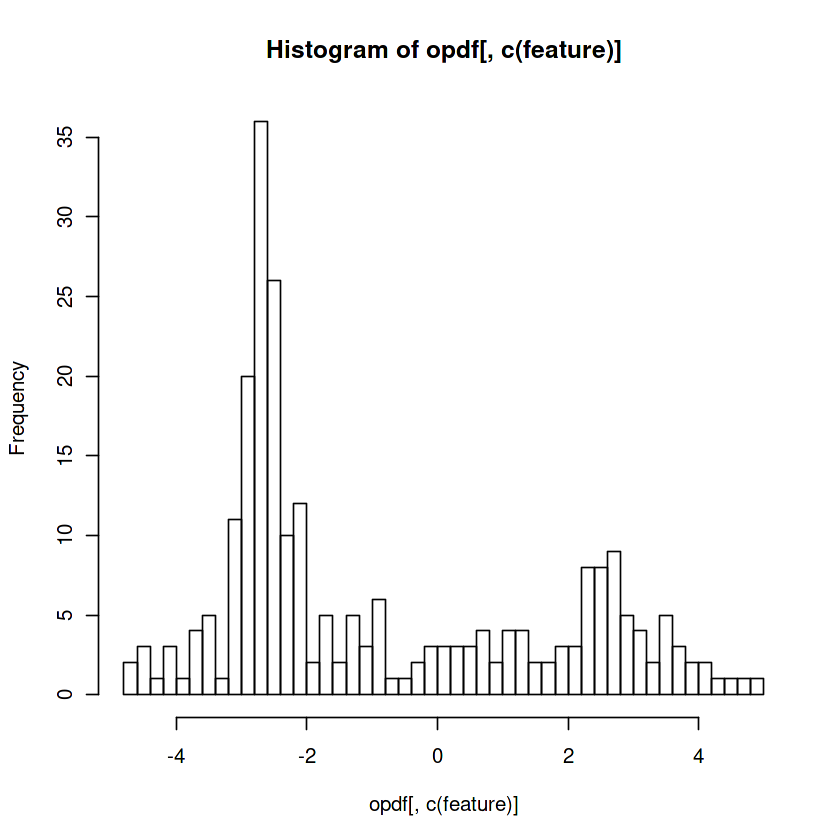

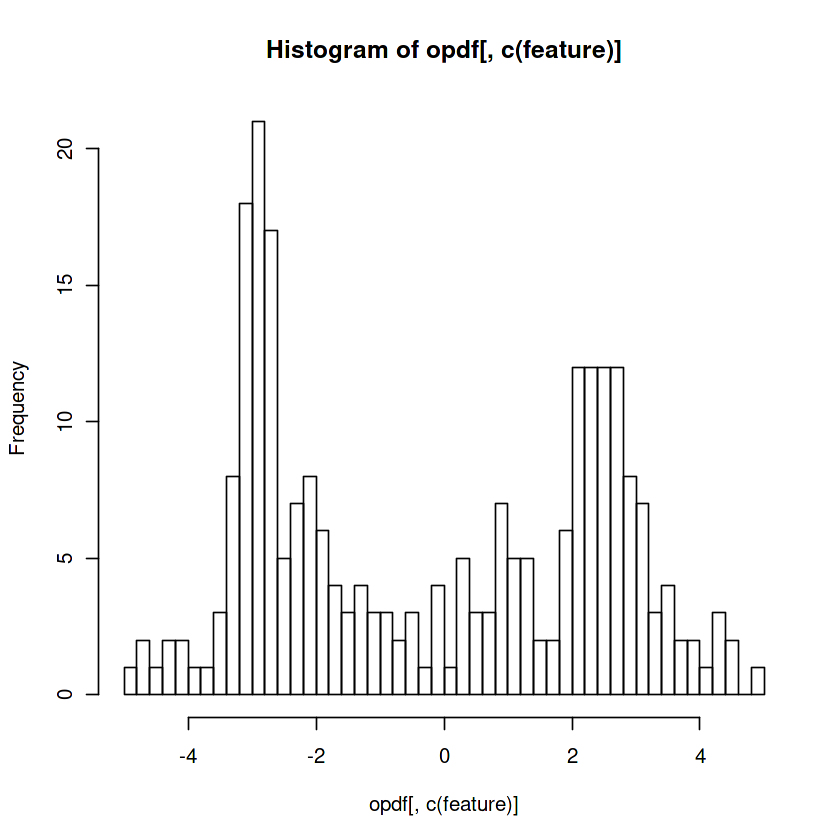

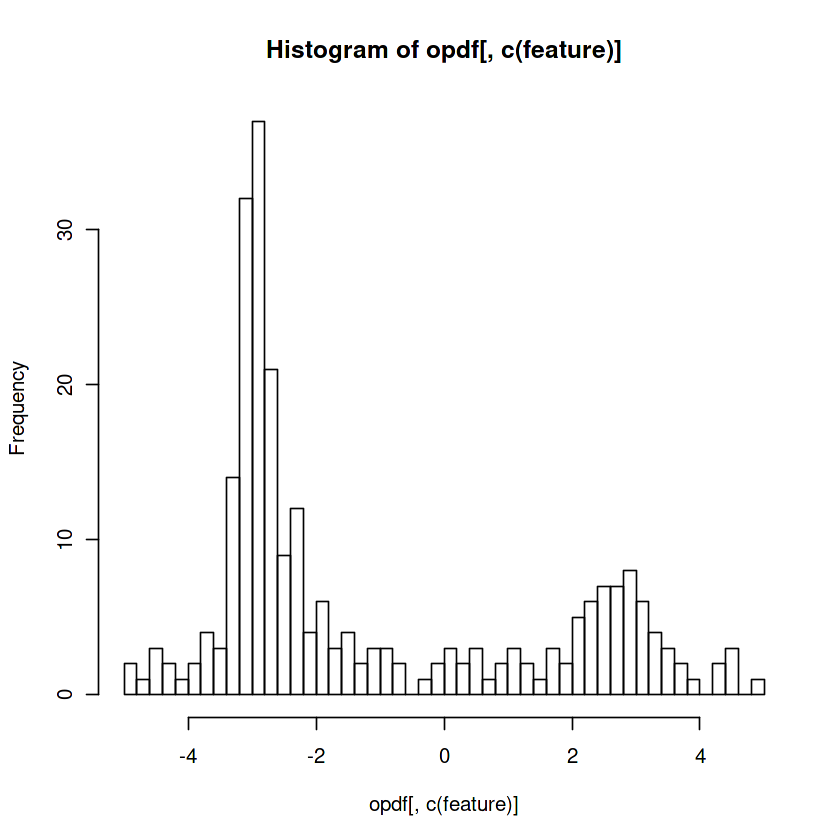

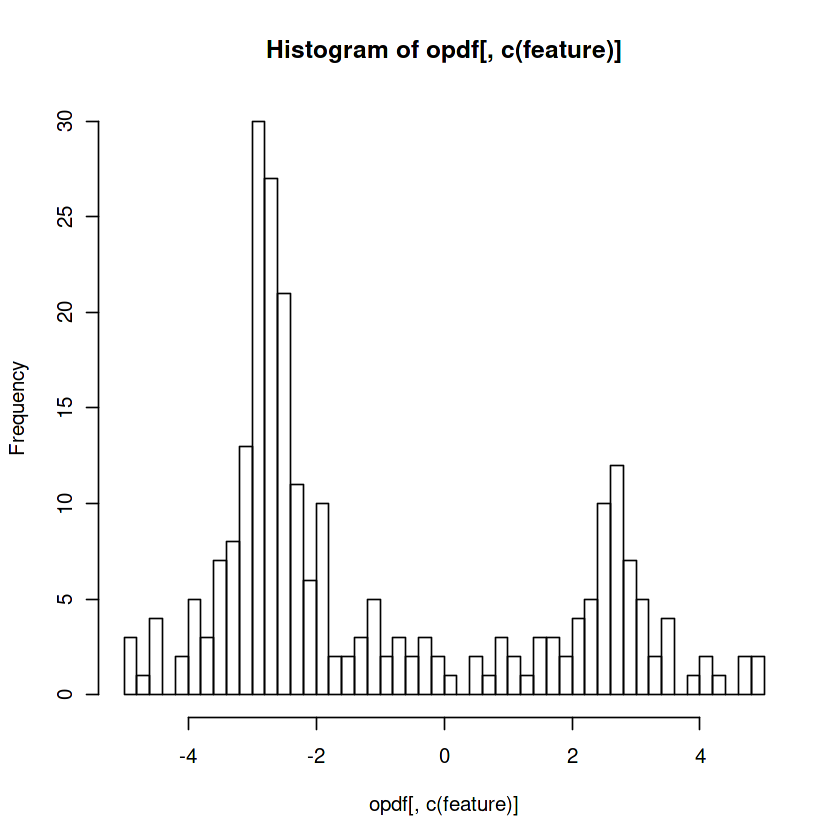

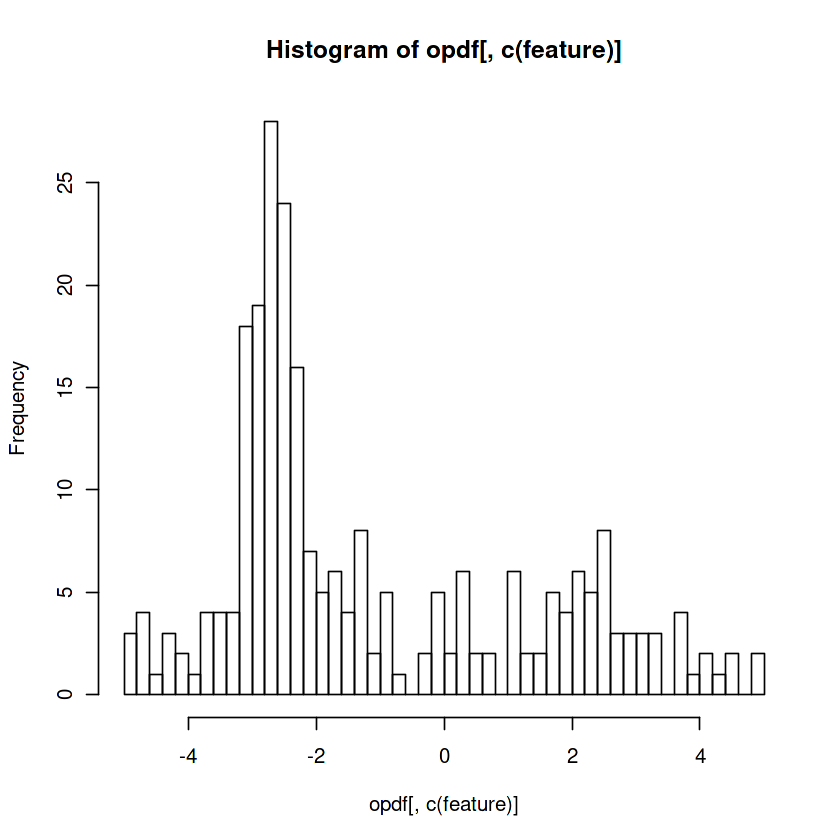

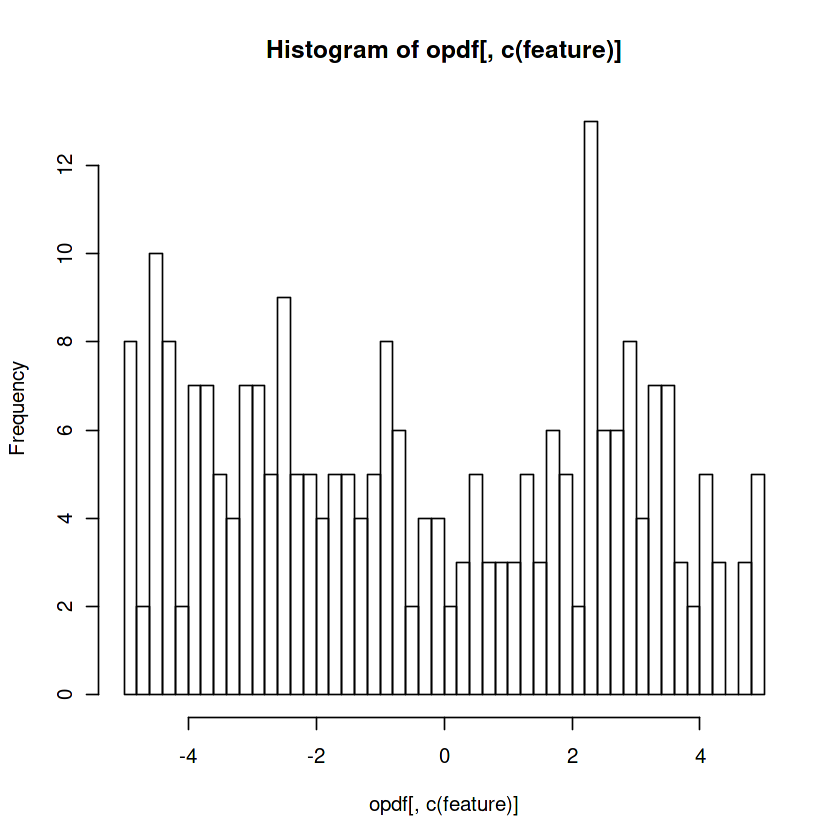

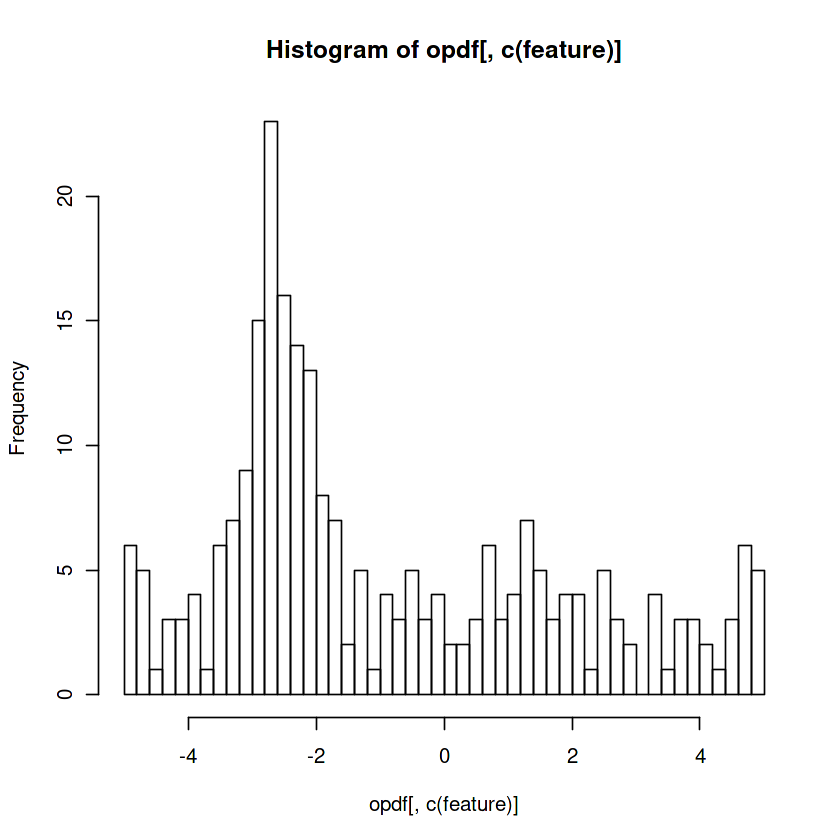

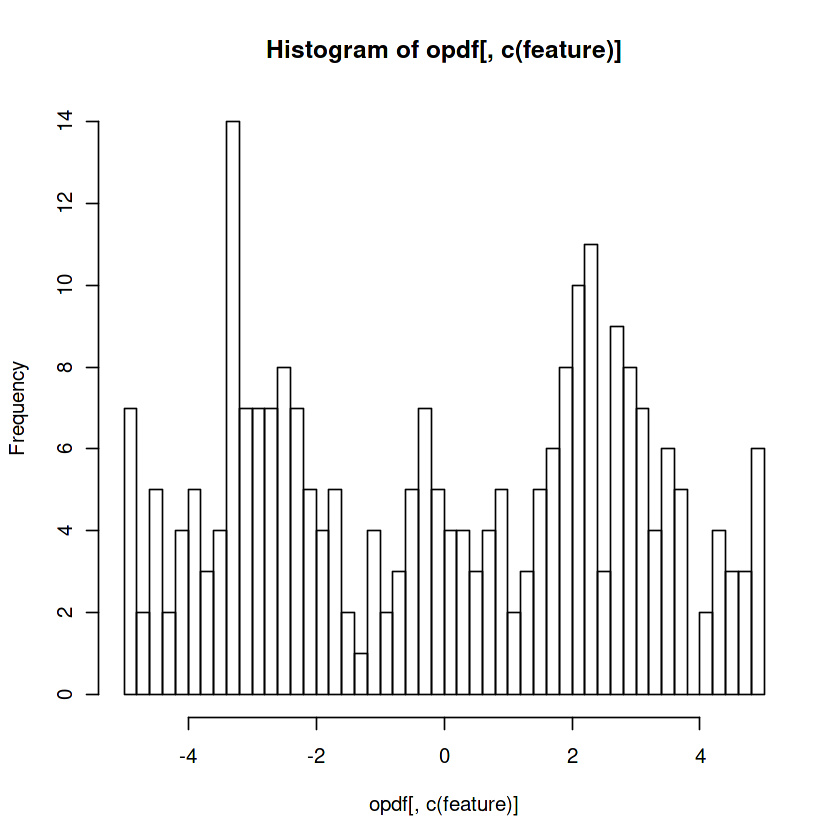

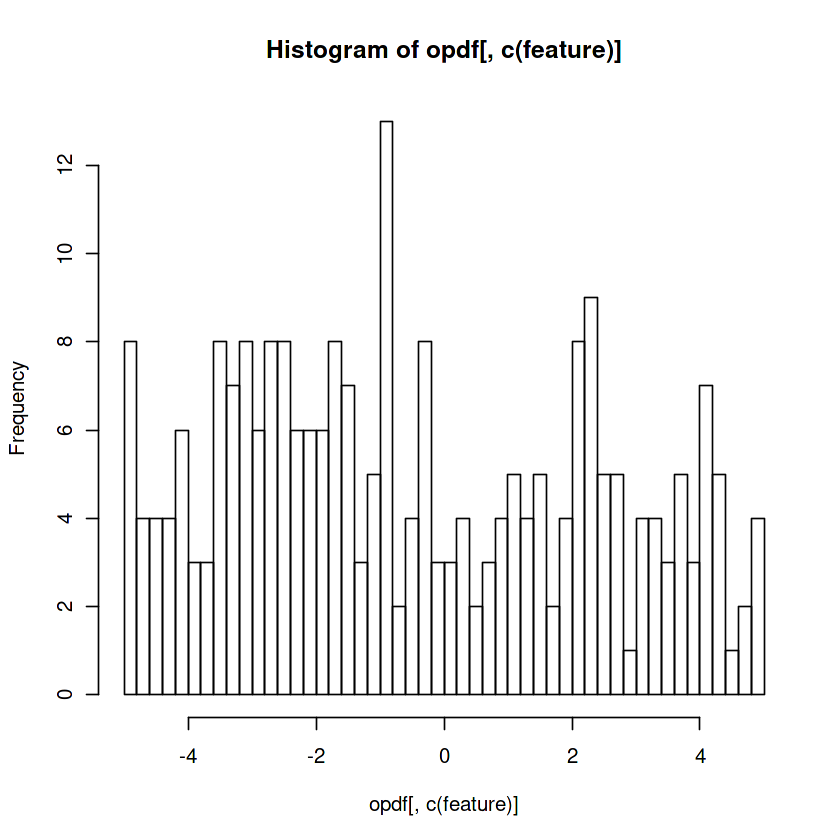

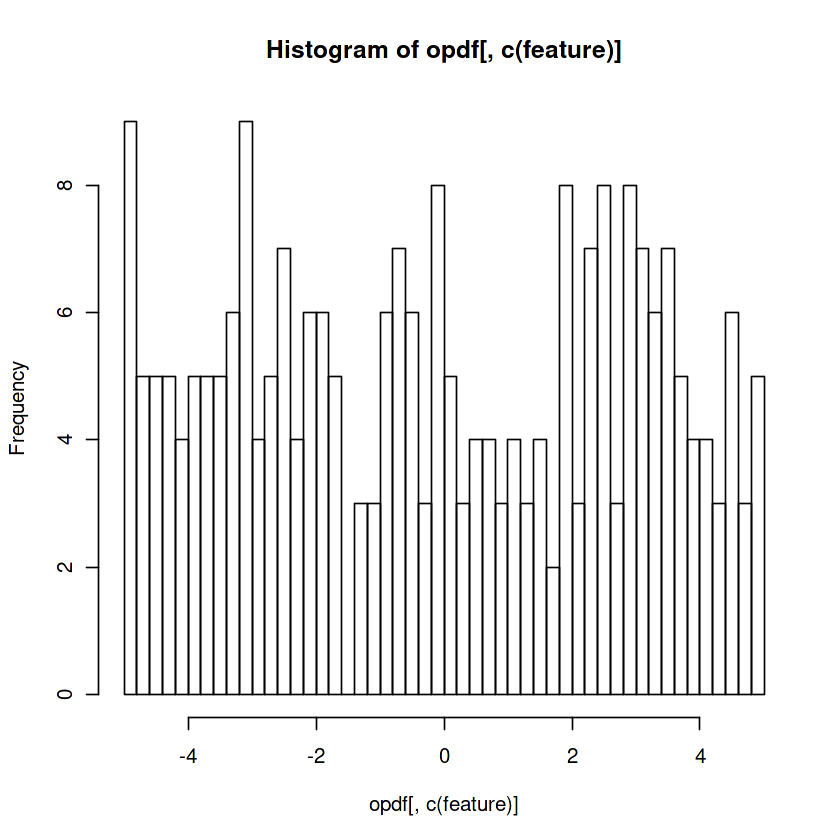

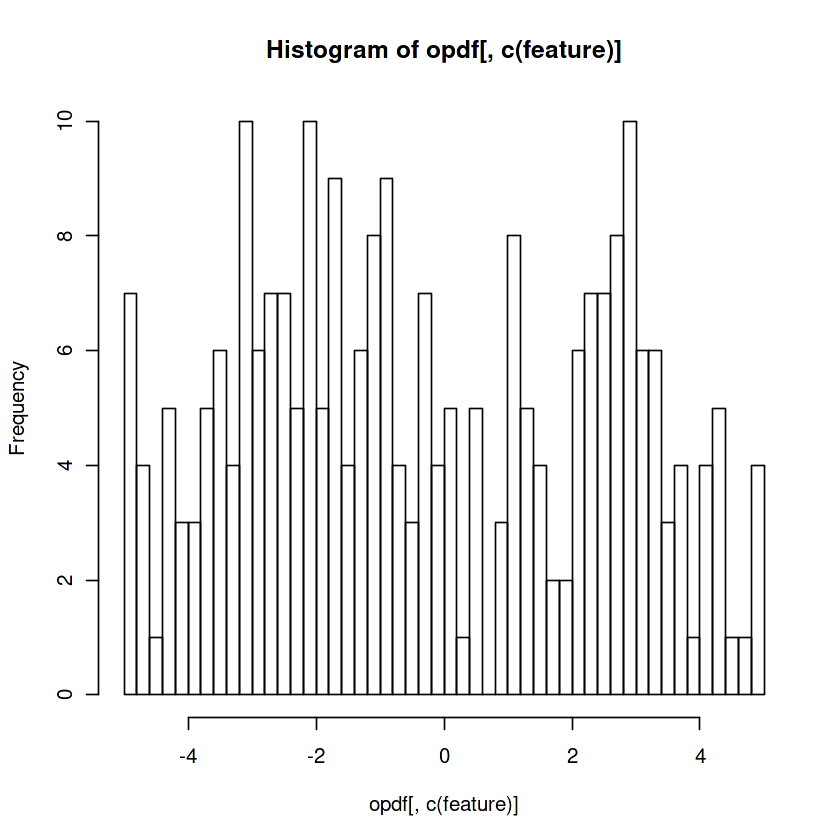

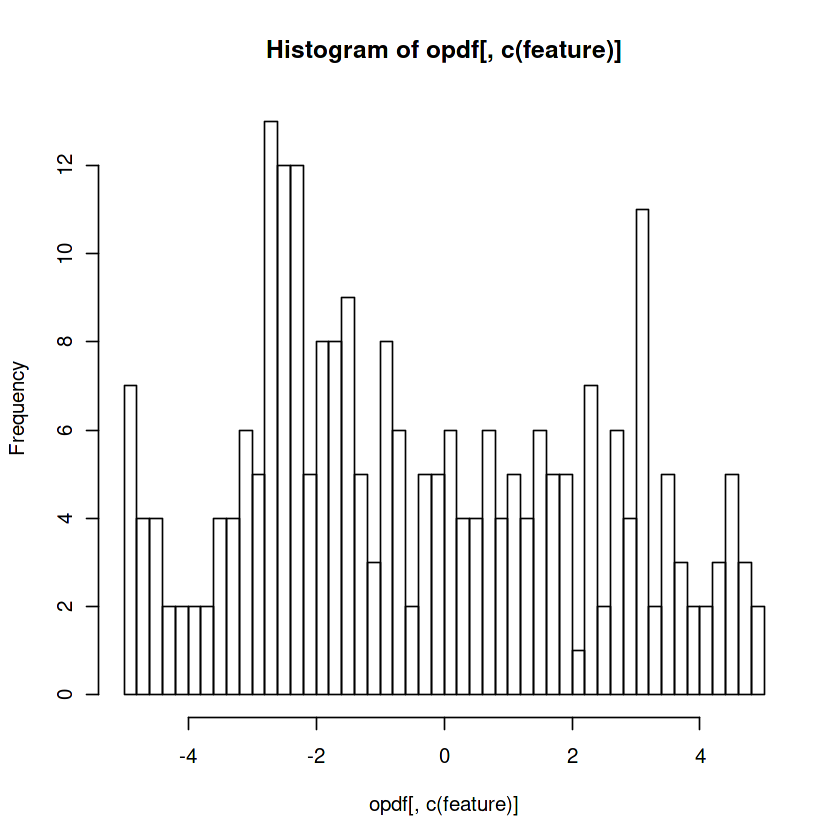

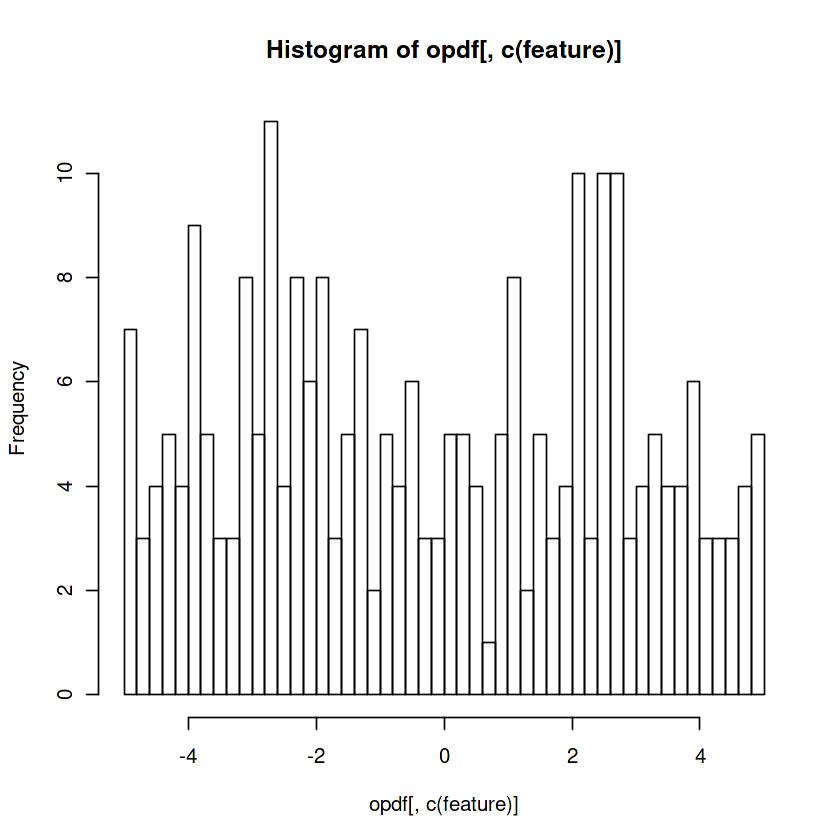

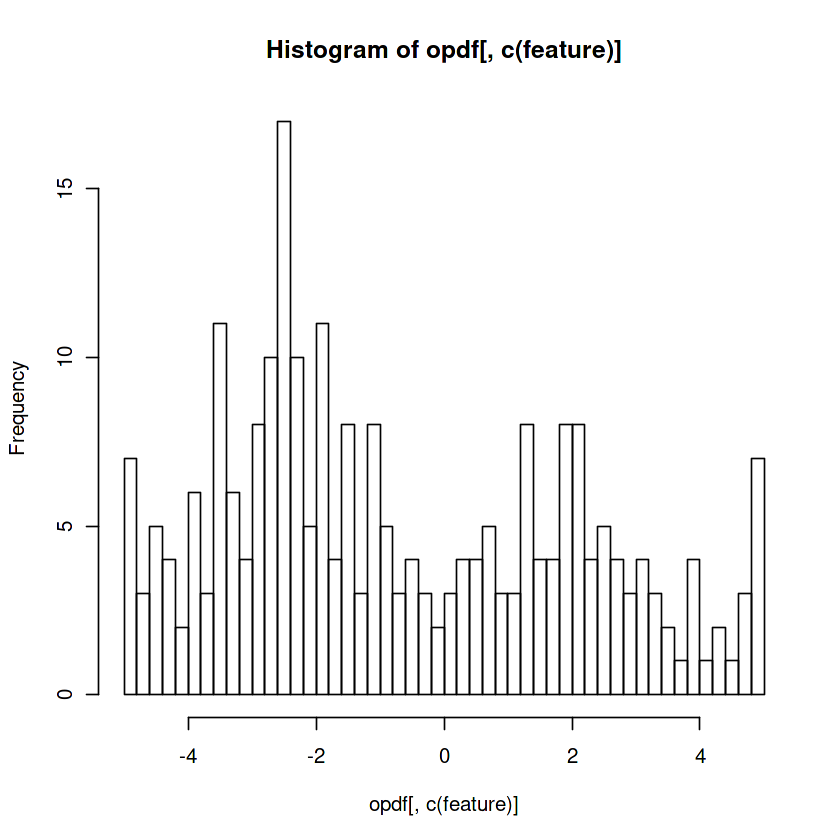

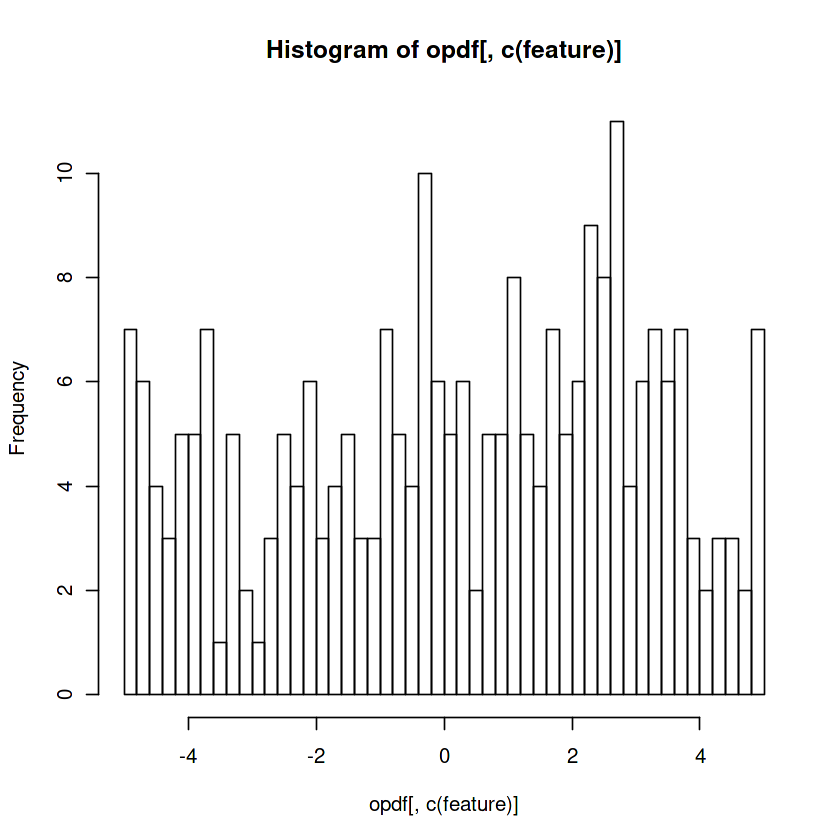

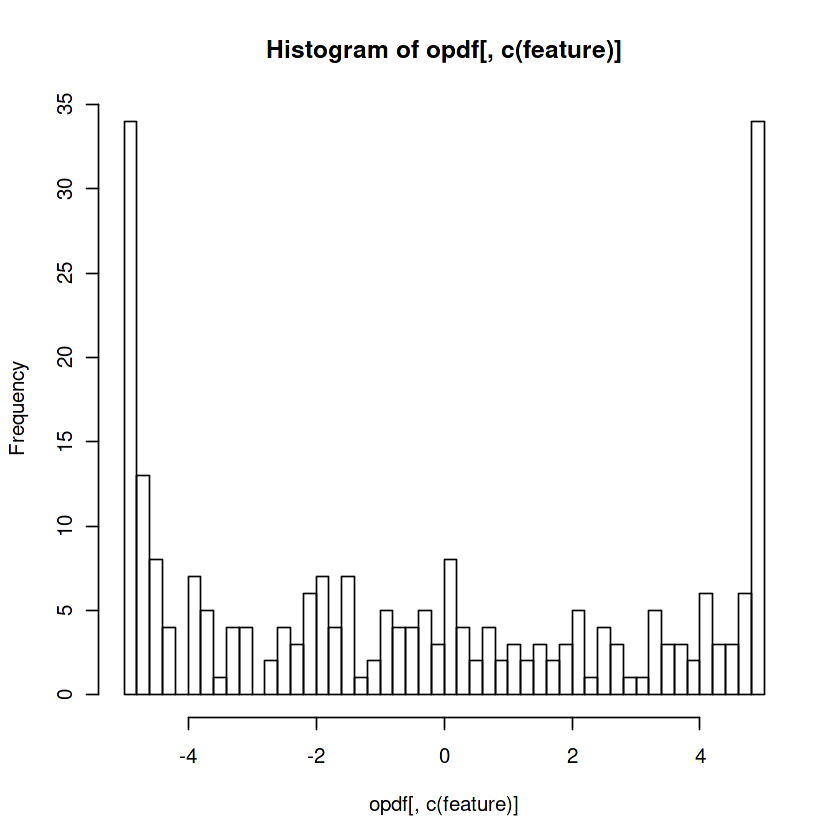

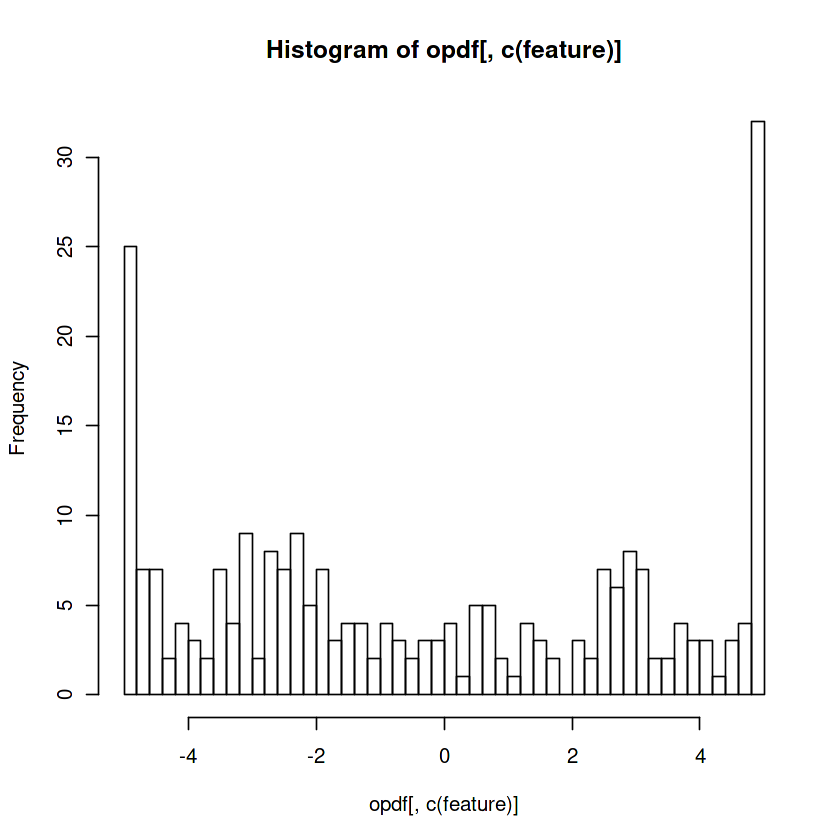

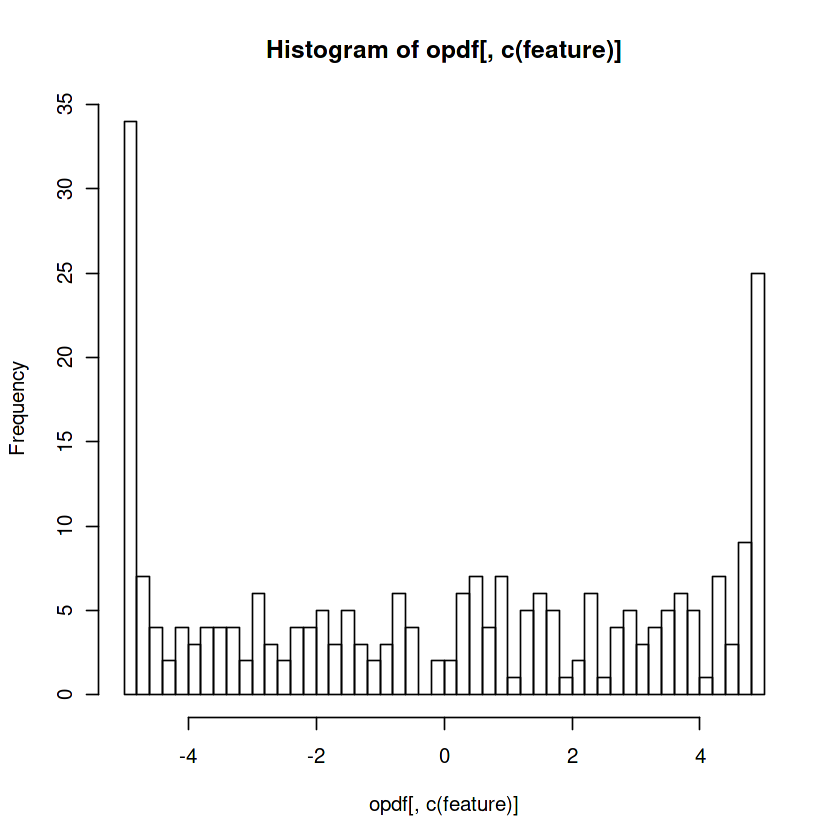

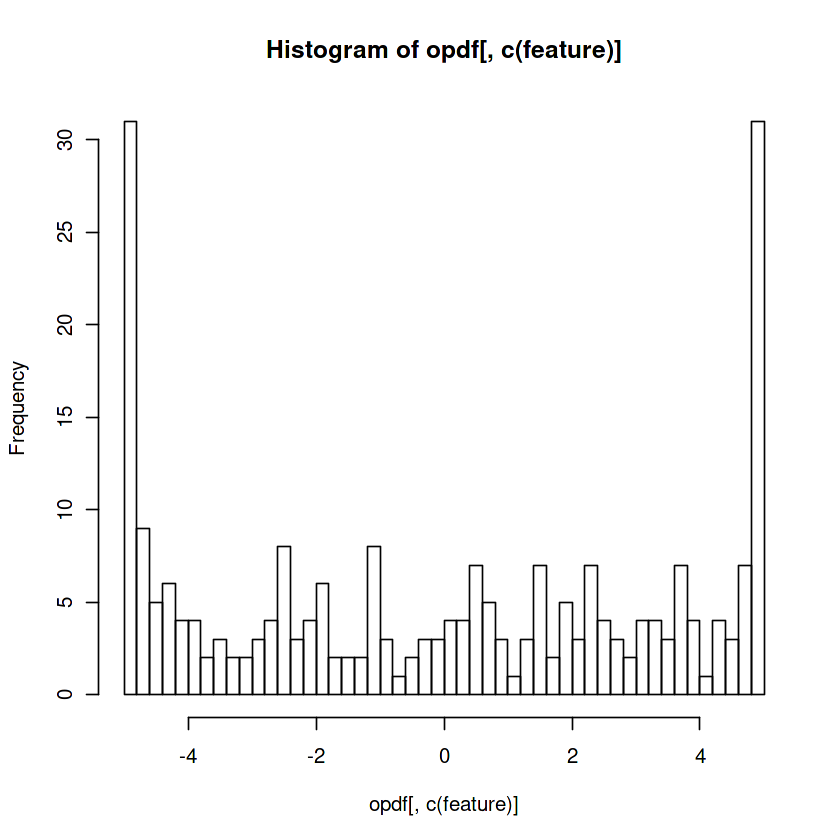

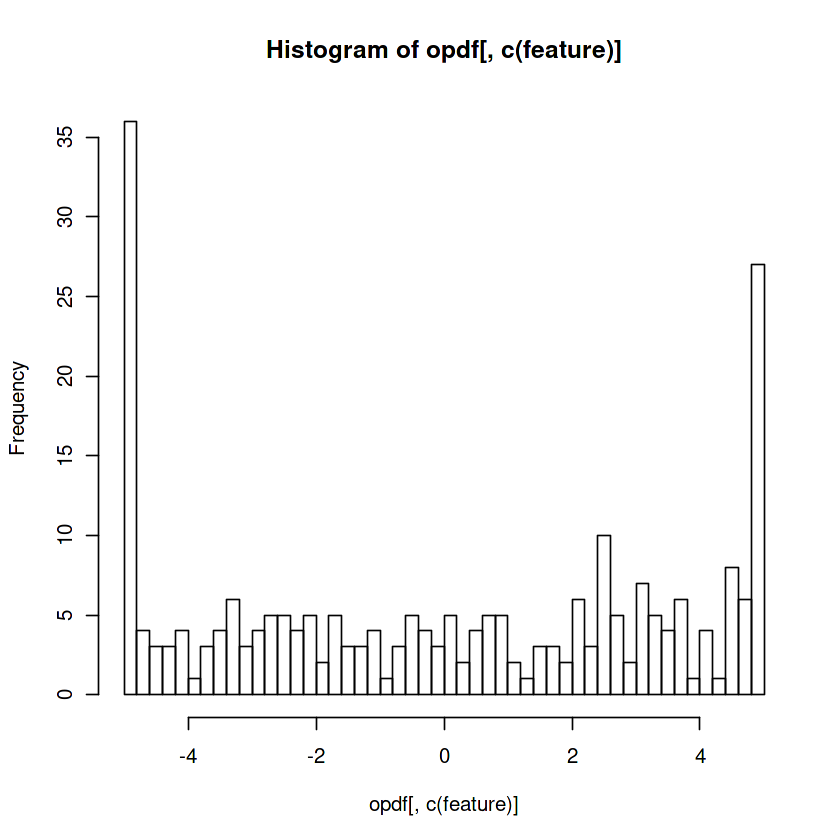

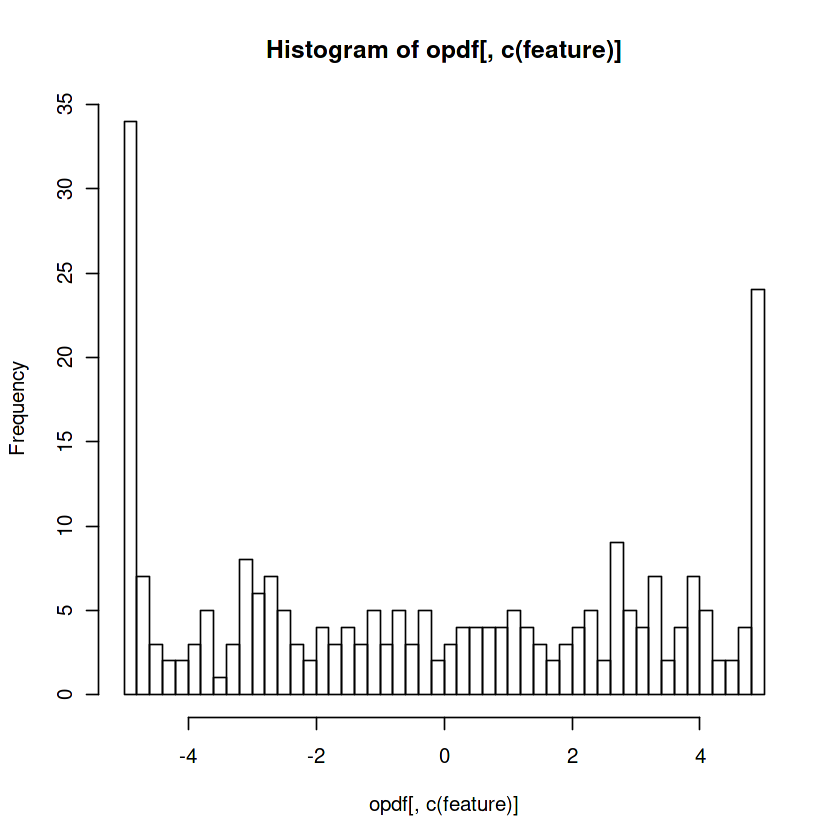

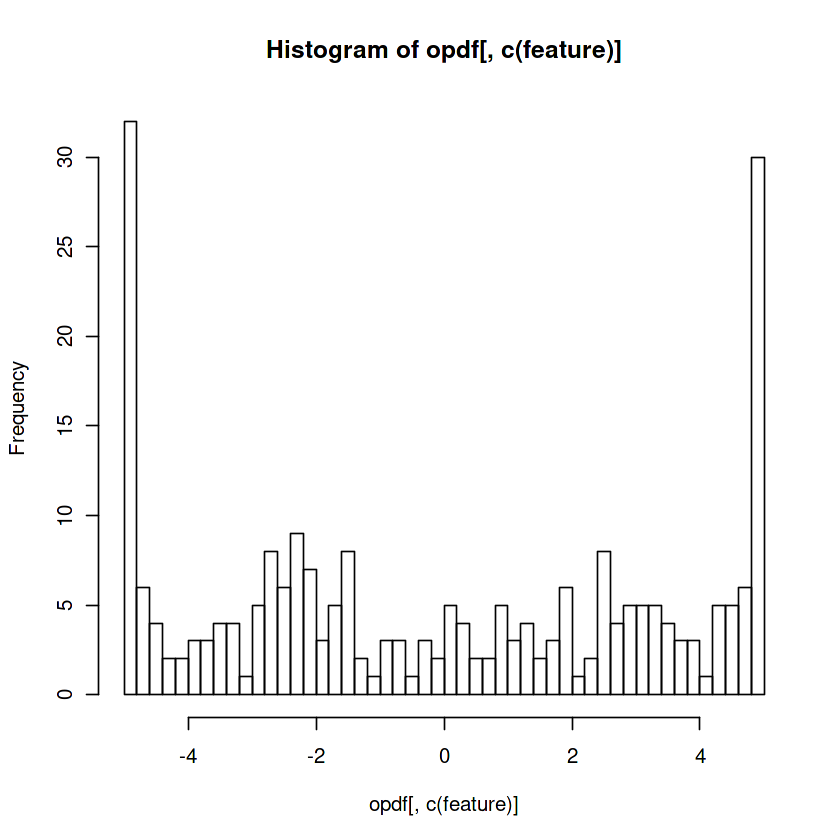

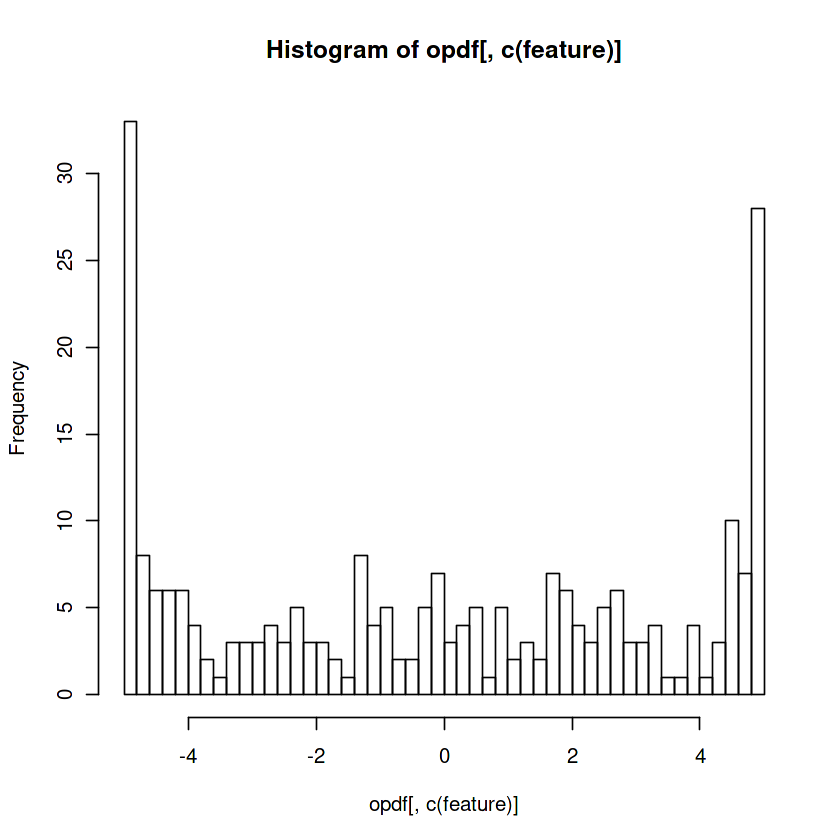

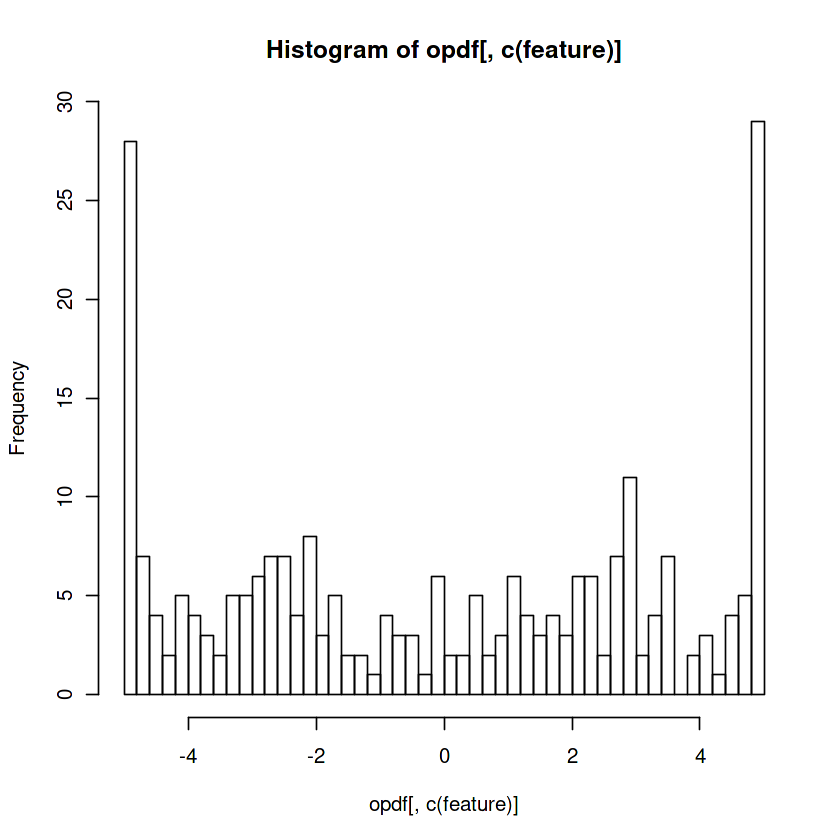

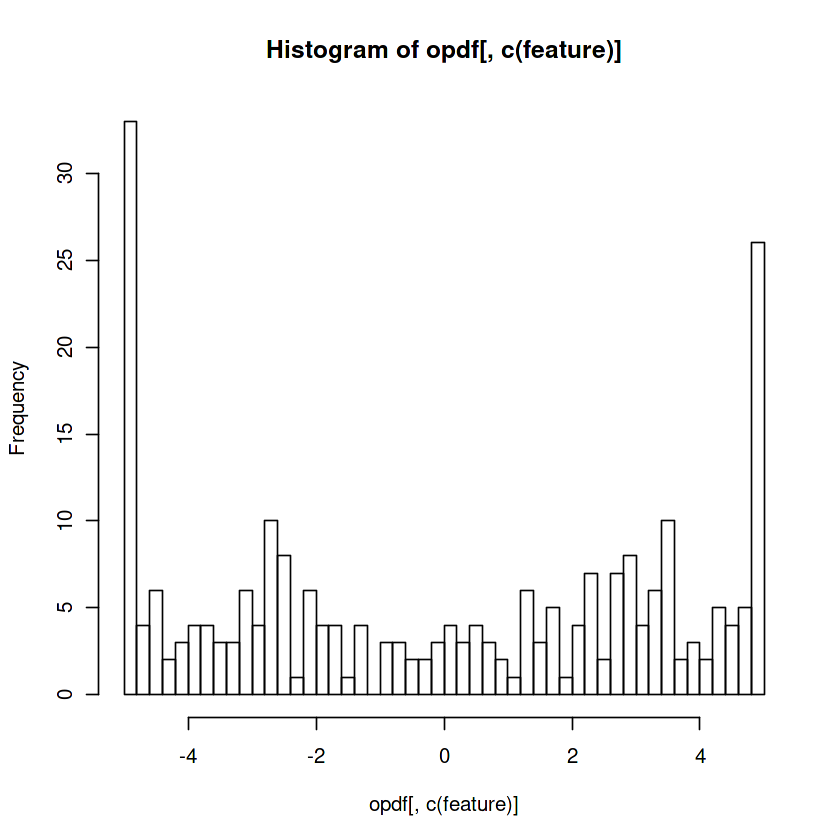

In [223]:
diffs[["10D"]] = compute_mean_difference_synthetic(10, lambda_vals, breaks = 40)

In [224]:
diffs2 = do.call(rbind, diffs)

In [225]:
diffs2$md = as.numeric(diffs2$md)
diffs2$kld = as.numeric(diffs2$kld)
diffs2$feature = as.factor(diffs2$feature)
diffs2$lambda = as.numeric(diffs2$lambda)
diffs2$dim = as.factor(diffs2$dim)

In [226]:
diffs2_summary = diffs2[, .(mean_kld = mean(kld), mean_error_pdp = mean(md)), by = c("dim", "lambda")]

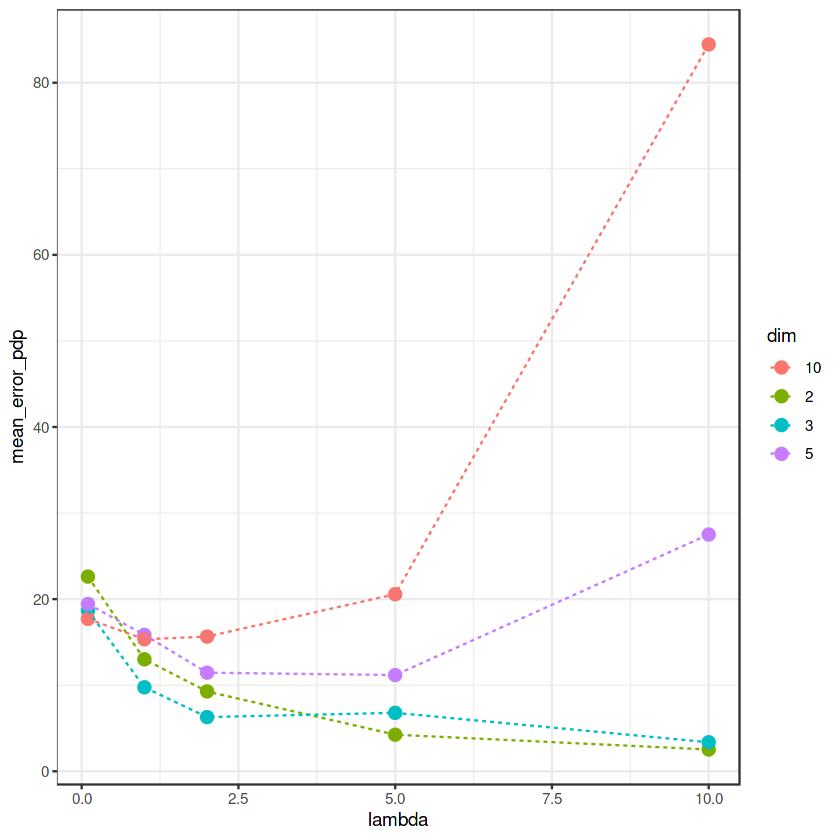

In [230]:
p = ggplot(diffs2_summary, aes(x = lambda, y = mean_error_pdp, colour = dim)) + geom_point(size = 3) + geom_line(lty = 2)
p

The hypothesis is only partially correct. In particular in high dimensions, a higher lambda can mean a worse partial dependence plot, because we have a sampling bias towards the border of the search space in the beginning. 

## 2. The width of the confidence intervals is correlated with the quality of a PDP 

In [232]:
diffs[["2D"]]

md               kld feature lambda dim
1  19.8181427414363 NaN x1      0.1    2  
2  25.4174446882382 NaN x2      0.1    2  
3  8.45819190207918 NaN x1      1      2  
4  17.5598519094899 NaN x2      1      2  
5  9.77410073669068 NaN x1      2      2  
6  8.77617179690251 NaN x2      2      2  
7  4.51551093324703 NaN x1      5      2  
8  3.98232572414836 NaN x2      5      2  
9  2.58117563087657 NaN x1      10     2  
10 2.47908830276581 NaN x2      10     2

In [200]:
feature = "x1"
me = marginal_effect(obj = obj, feature = feature, data = df, model = model, grid.size = 20)
pme = marginal_effect_sd_over_mean(model = model, feature = feature, data = df, grid.size = 20, method = "pdp_var_gp")


In [206]:
            mean_sd = mean(pme$sd)
            sd_upper_q90 = quantile(x = pme$sd, probs = 0.9)
            sd_lower_q10 = quantile(x = pme$sd, probs = 0.1)
sd_lower_q10

10% 
4.191937

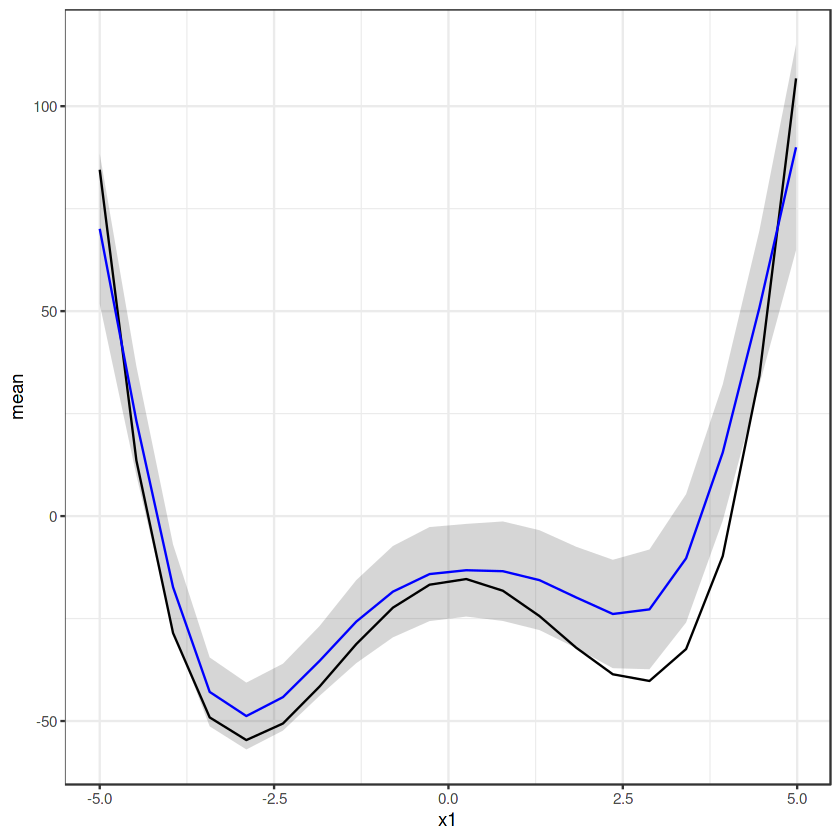

In [202]:
p = ggplot() + geom_ribbon(data = pme, aes(x = x1, ymin = mean - 2 * sd, ymax = mean + 2 * sd), alpha = 0.2) 
p = p + geom_line(data = me, aes(x = x1, y = mean)) + geom_line(data = pme, aes(x = x1, y = mean), colour = "blue")
p

In [40]:
dimension = 5
lambda = 10
path = "../data/runs/synthetic/StyblinskiTang/"
datapath = file.path(path, paste0(dimension, "D"), paste0("mlrmbo_run_lambda_", lambda, ".rds"))

run = readRDS(datapath)
obj = readRDS(file.path(path, paste0(dimension, "D"), "objective.rds"))
ps = readRDS(file.path(path, paste0(dimension, "D"), "ps.rds"))

opdf = as.data.frame(run$opt.path)

In [50]:
P = opdf$x1
Q = runif(n = length(P), min = ps$pars$x$lower, max = ps$pars$x$upper)

In [54]:
KL(rbind(P, Q), est.prob = "empirical")

Metric: 'kullback-leibler' using unit: 'log2'; comparing: 2 vectors.



kullback-leibler 
             NaN

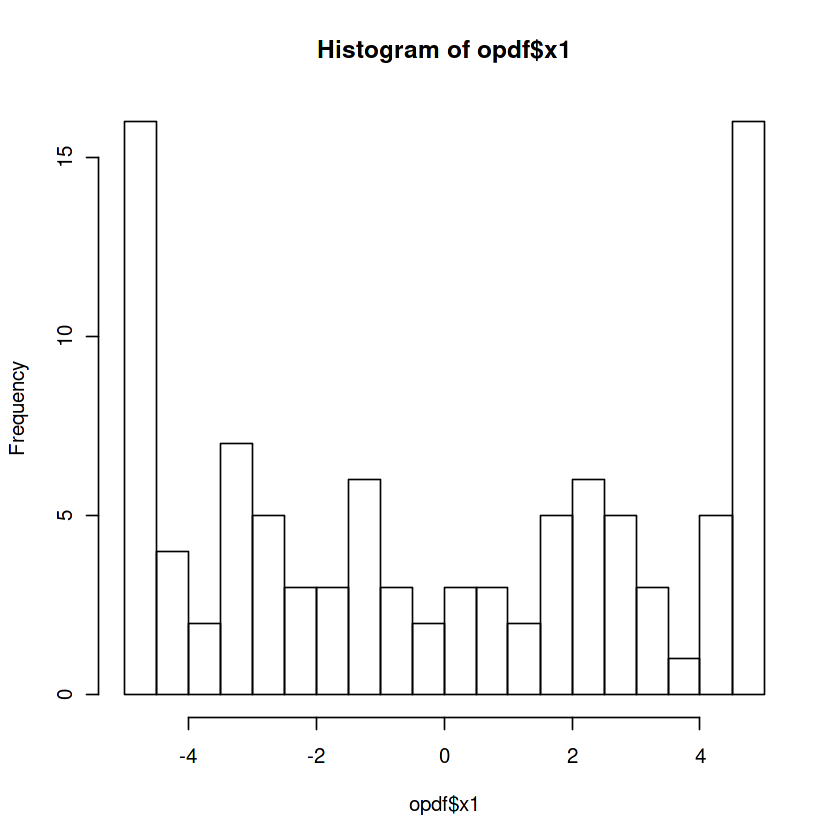

In [81]:
myhist = hist(opdf$x1, breaks = 30)

In [82]:
P = myhist$density
Q = 1 / length(myhist$density)

In [83]:
sum(P * log(P / Q))

[1] 1.877682

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



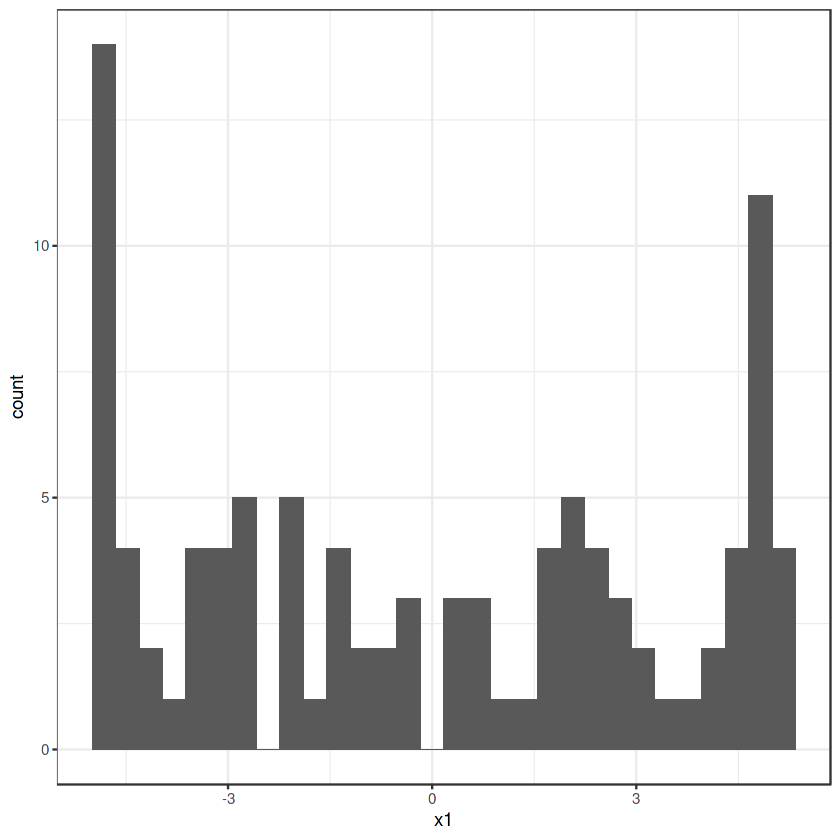

In [61]:
ggplot(data = opdf, aes(x = x1)) + geom_histogram() + geom_line(aes(x = yintercept = )

#### MLP Data

We have 4 different values of lambda: 0.5, 1, 2, 10. For each run, we have 30 replications

In [22]:
dataset = "kc1"

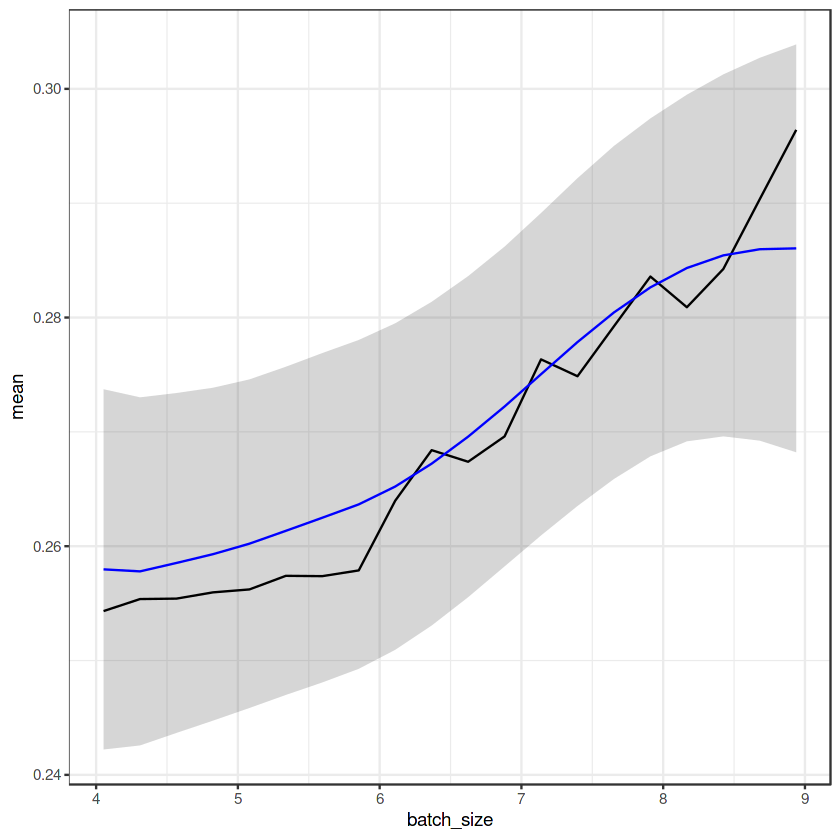

In [72]:
p = ggplot() + geom_ribbon(data = pme, aes(x = batch_size, ymin = mean - 2 * sd, ymax = mean + 2 * sd), alpha = 0.2) 
p = p + geom_line(data = me, aes(x = batch_size, y = mean)) + geom_line(data = pme, aes(x = batch_size, y = mean), colour = "blue")
p

In [175]:
compute_width_ci = function(dataset, lambda_vals, breaks, feature) {

    path = file.path("../data/runs/mlp_new", dataset)
    df = generateRandomDesign(n = 100, par.set = ps)

    obj = readRDS(file.path(path, "obj.rds"))
    ps = getParamSet(obj)
    # Is needed within the objective 
    surr_val = readRDS(file.path(path, "surrogate.rds"))$result[[1]]$model_val_balanced_acc
    
    # Compute the ground-truth PDP once 
    me = marginal_effect_mlp(obj = obj, feature = feature, data = df, model = model, grid.size = 20)
    
    diffs = lapply(lambda_vals, function(lambda) {
        
        datapath = file.path(path, paste0("mlrmbo_run_lambda_", lambda, "_30repls.rds"))
        runs = readRDS(datapath)

        res = lapply(1:5, function(i) {
            run = runs$result[[i]]
            opdf = as.data.frame(run$opt.path)

            model = run$models
            model = model[[length(model)]] 
            
            pme = marginal_effect_sd_over_mean(model = model, feature = feature, data = df, grid.size = 20, method = "pdp_var_gp")

            md = mean(abs(me$mean - pme$mean))
            neg_loglik = sum(unlist(lapply(seq_row(pme), function(i) {
                dnorm(me[i, ]$mean, mean = pme[i, ]$mean, sd = pme[i, ]$sd, log = FALSE) 
            })))
            mean_sd = mean(pme$sd)
            sd_upper_q90 = quantile(x = pme$sd, probs = 0.9)
            sd_lower_q10 = quantile(x = pme$sd, probs = 0.1)

            # compute the kullback-leibler distance 
            myhist = hist(opdf[, c(feature)], breaks = breaks, main = paste0("lambda = ", lambda))
            P = myhist$density 
            P = P / sum(P)
            Q = rep(1 / length(myhist$density), length(myhist$density))
            els = Q * log(Q / P)
            
            cbind(md = md, mean_sd = mean_sd, kld = sum(els[is.finite(els)], na.rm = TRUE), sd_upper_q90 = sd_upper_q90, sd_lower_q10 = sd_lower_q10, feature = feature, lambda = lambda, dataset = dataset)
        })

        do.call(rbind, res)
    })
    
    diffs = do.call(rbind, diffs)
    diffs = as.data.table(diffs)
    
    return(diffs)
} 

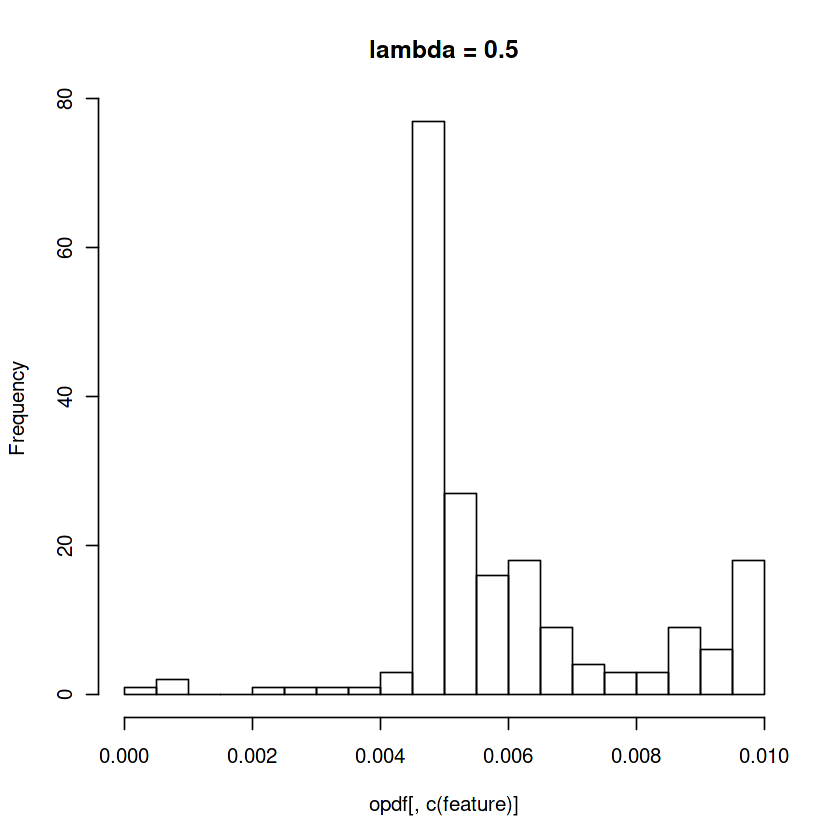

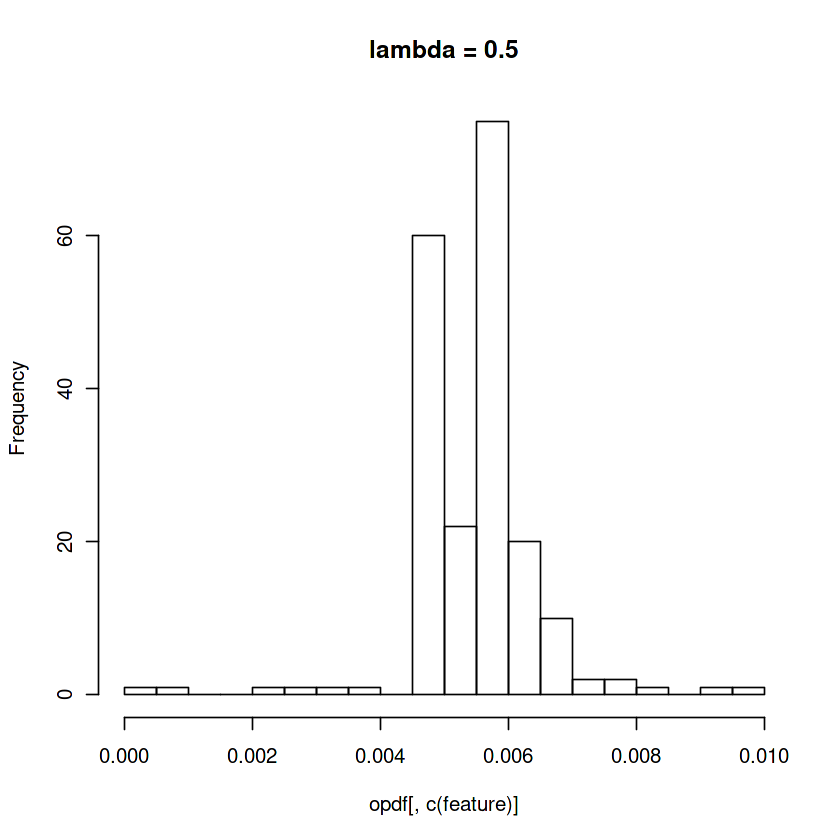

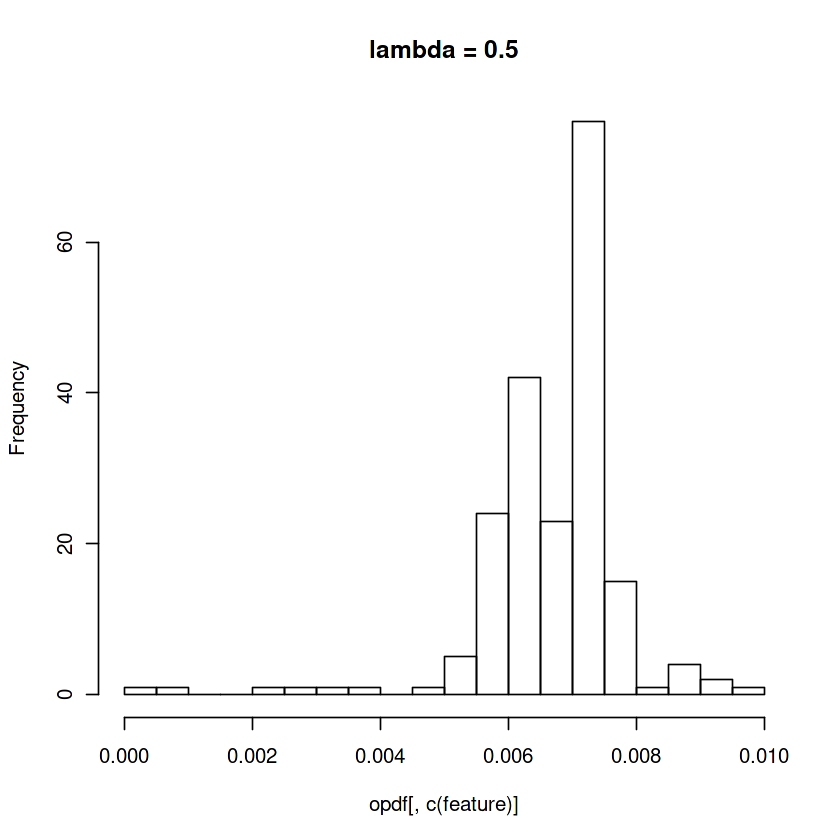

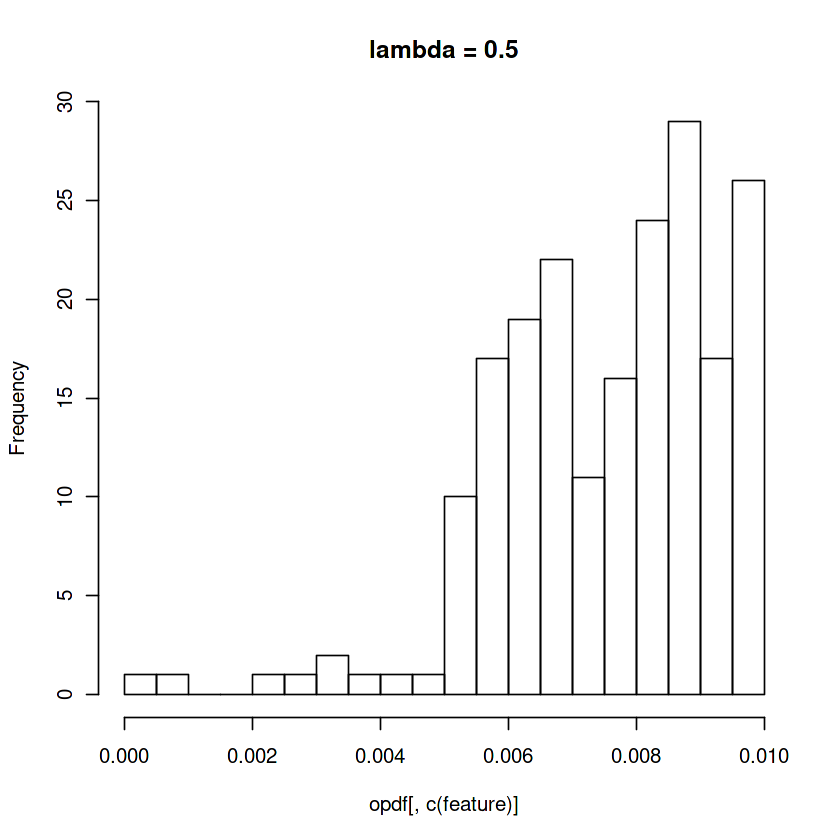

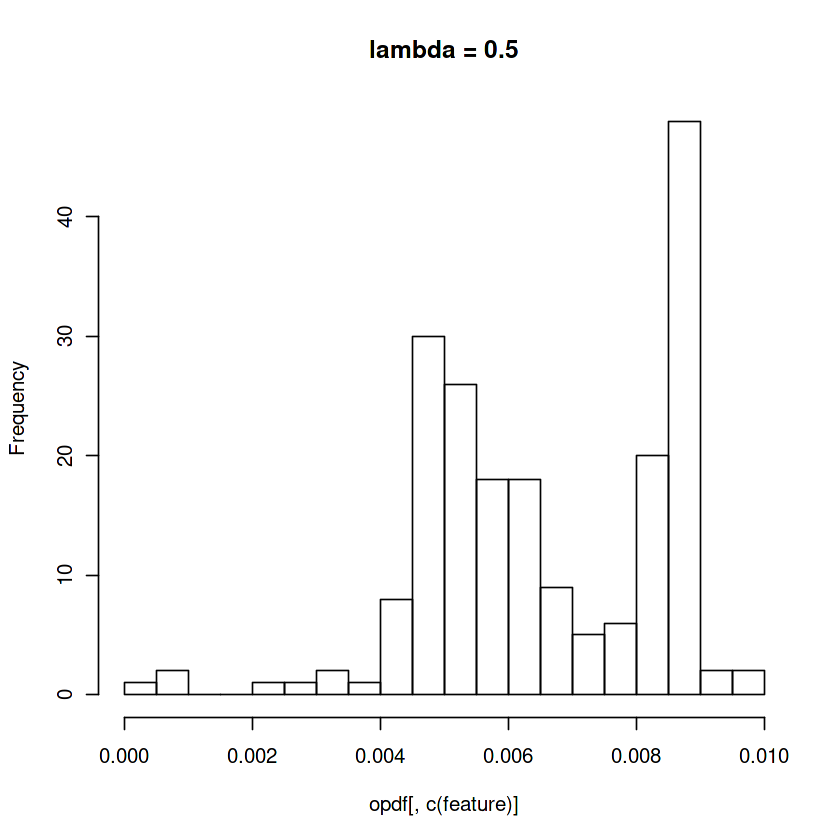

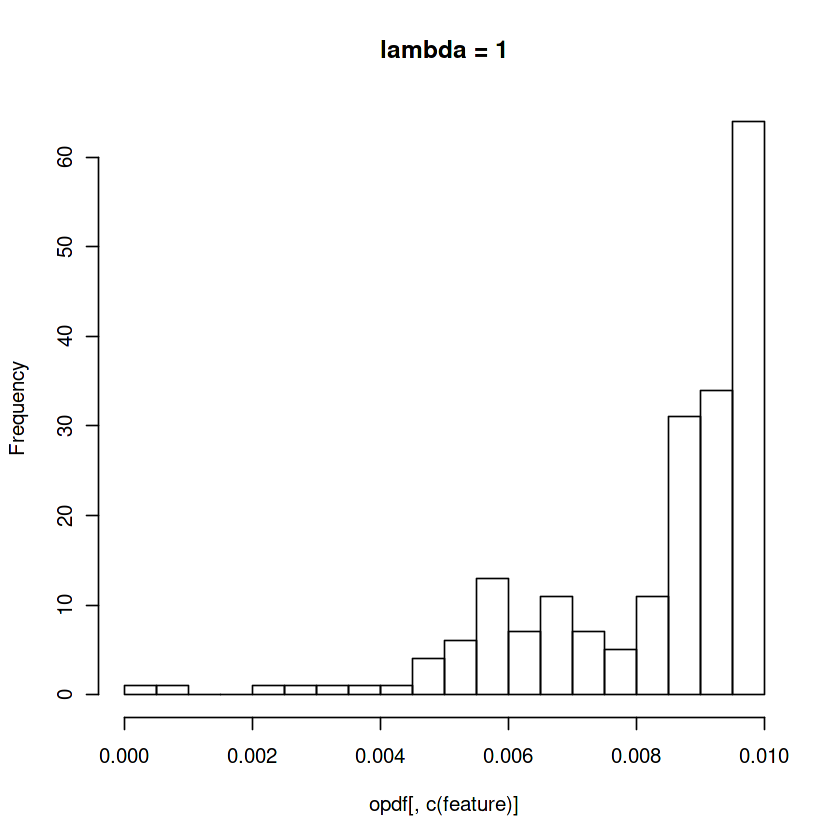

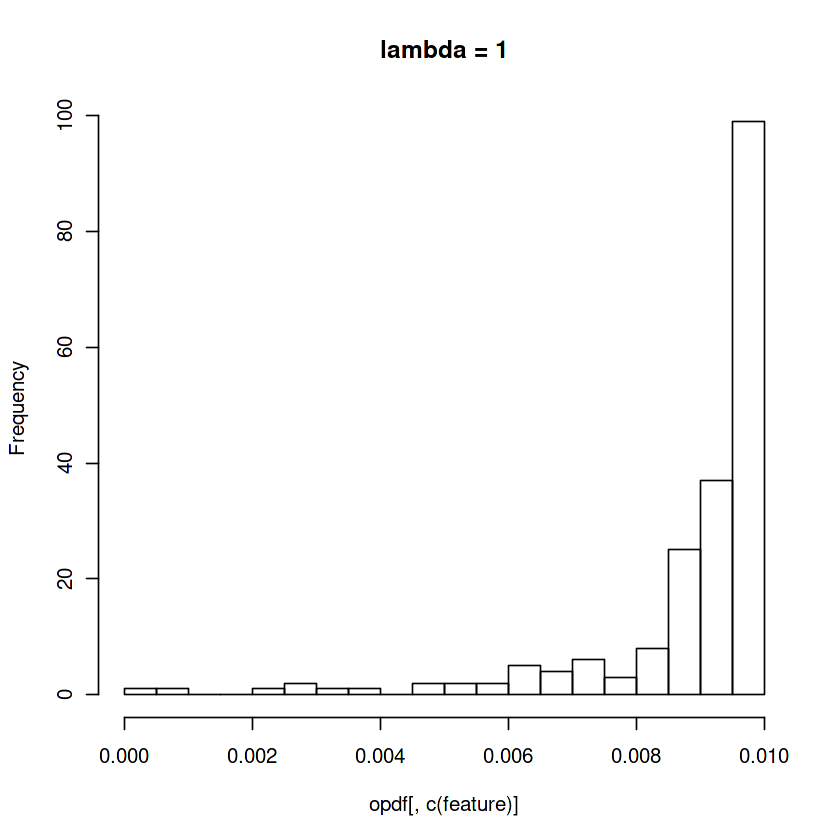

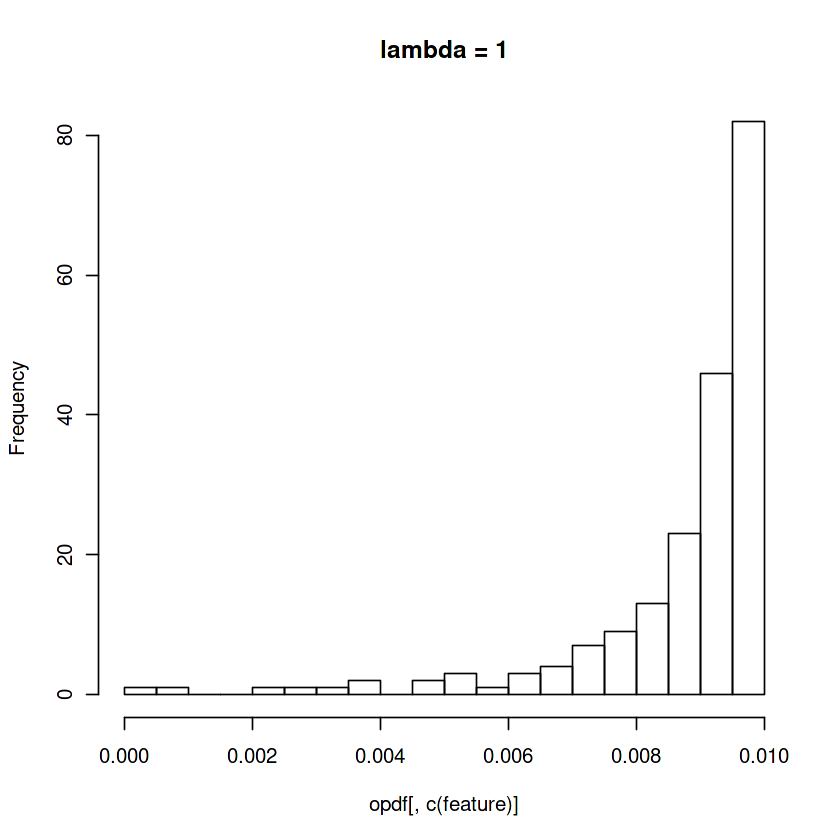

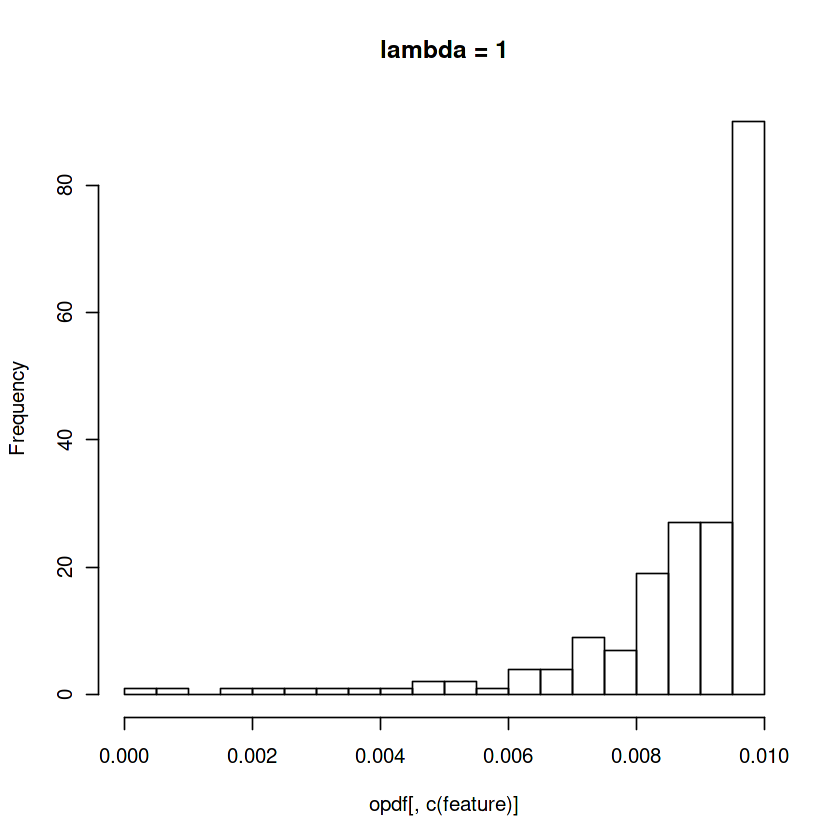

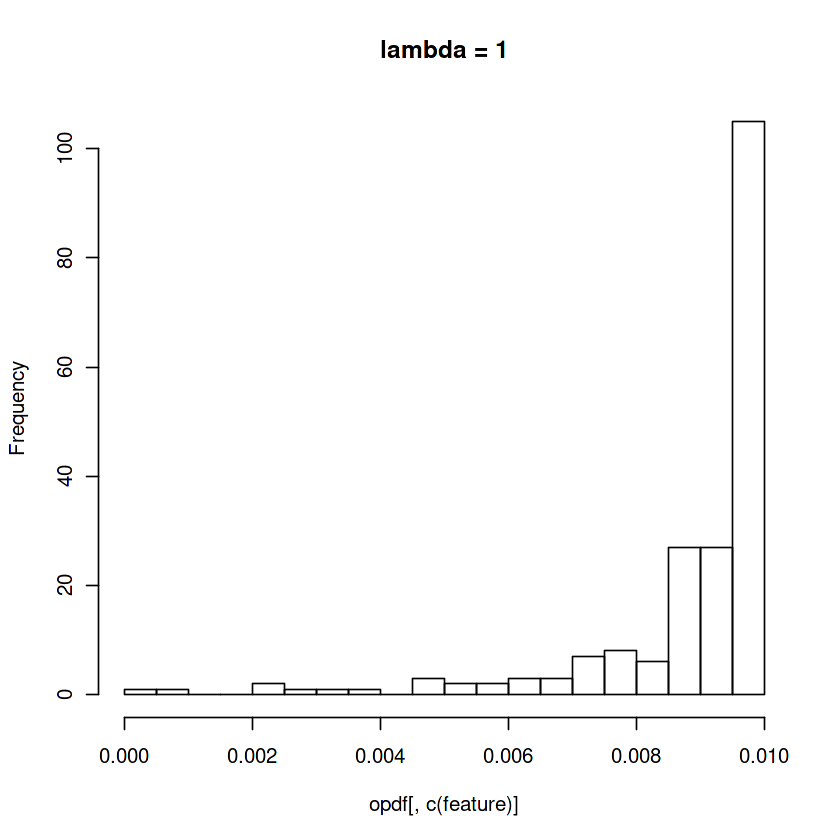

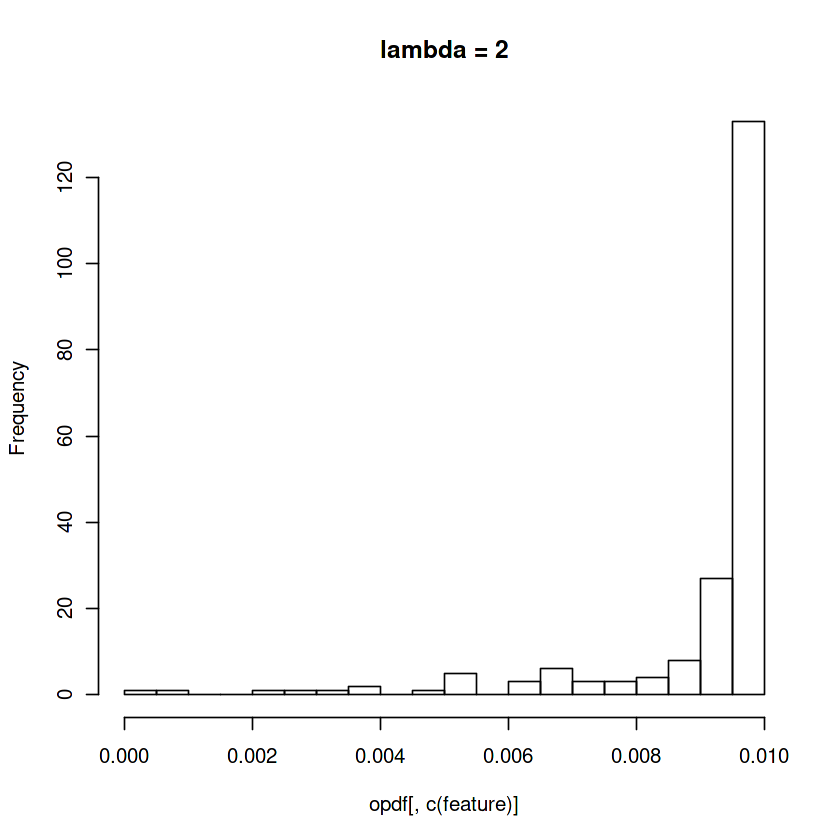

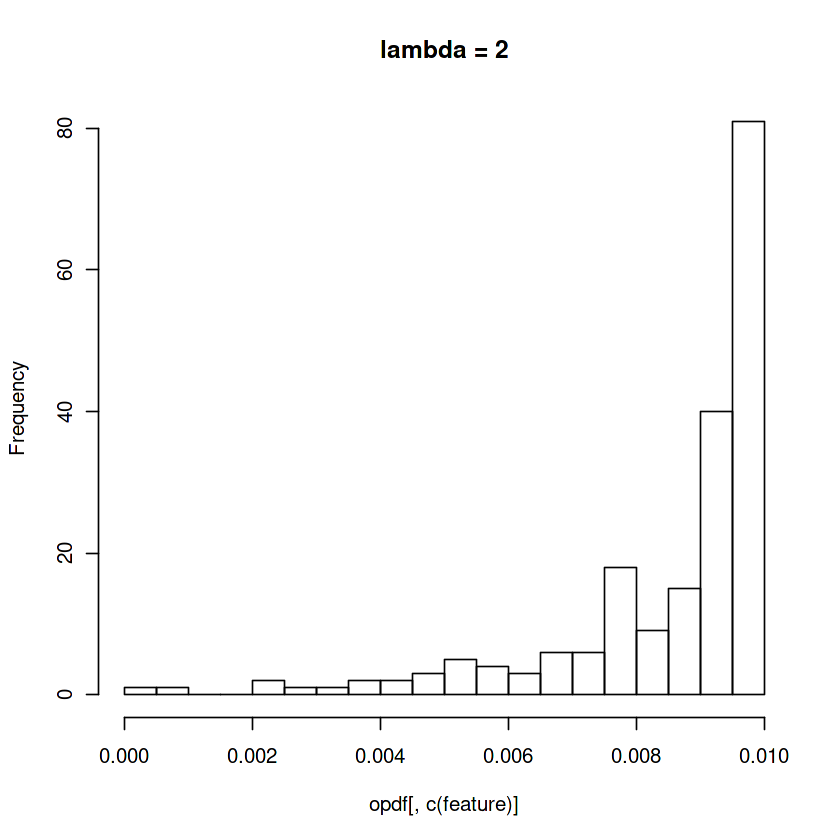

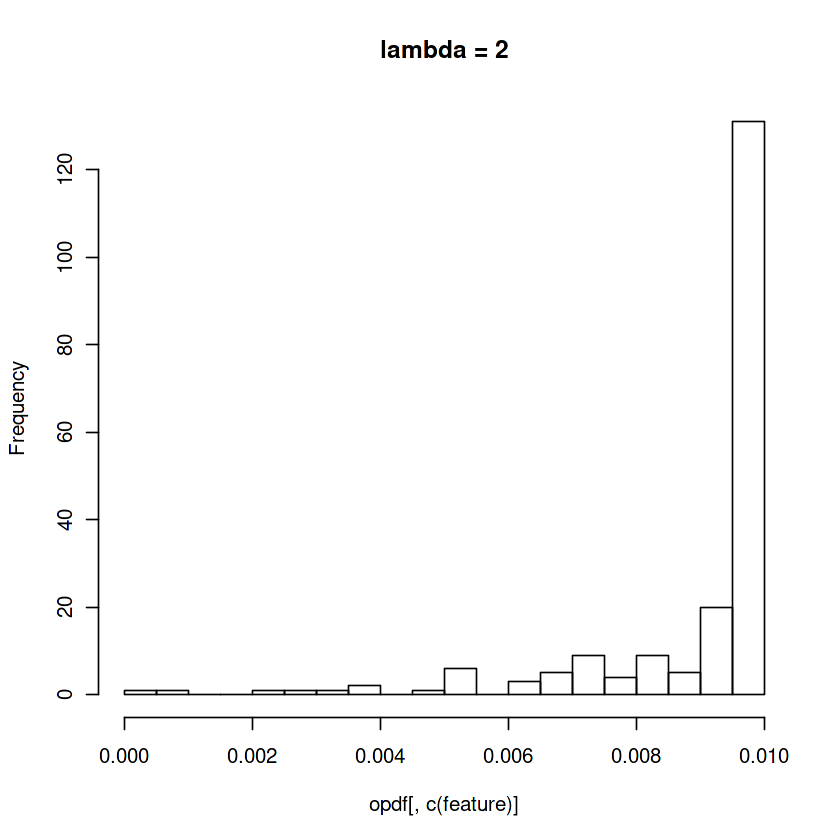

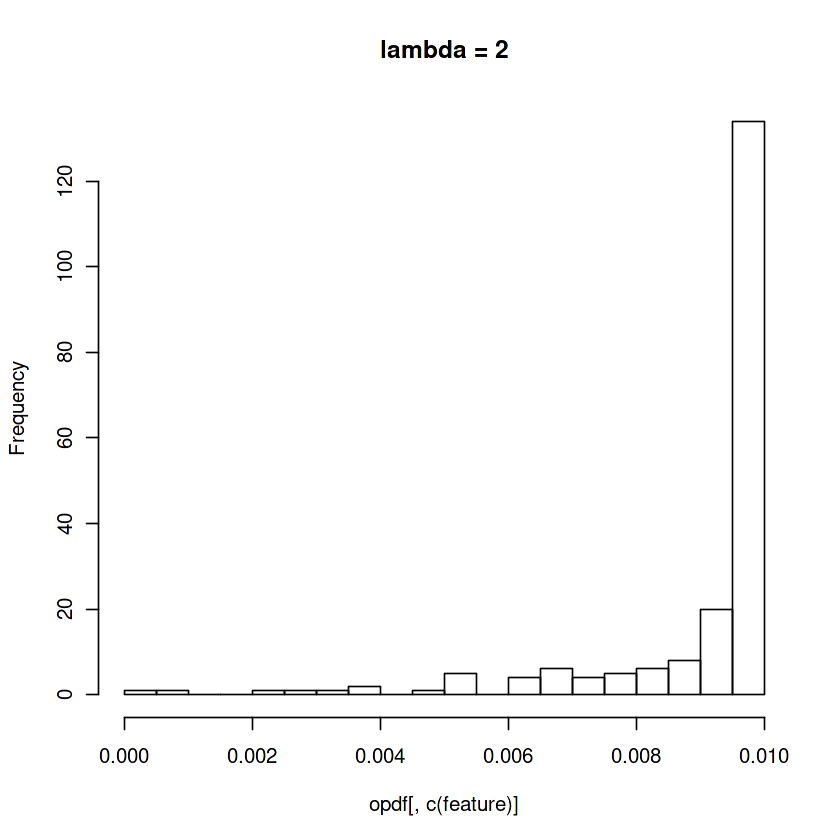

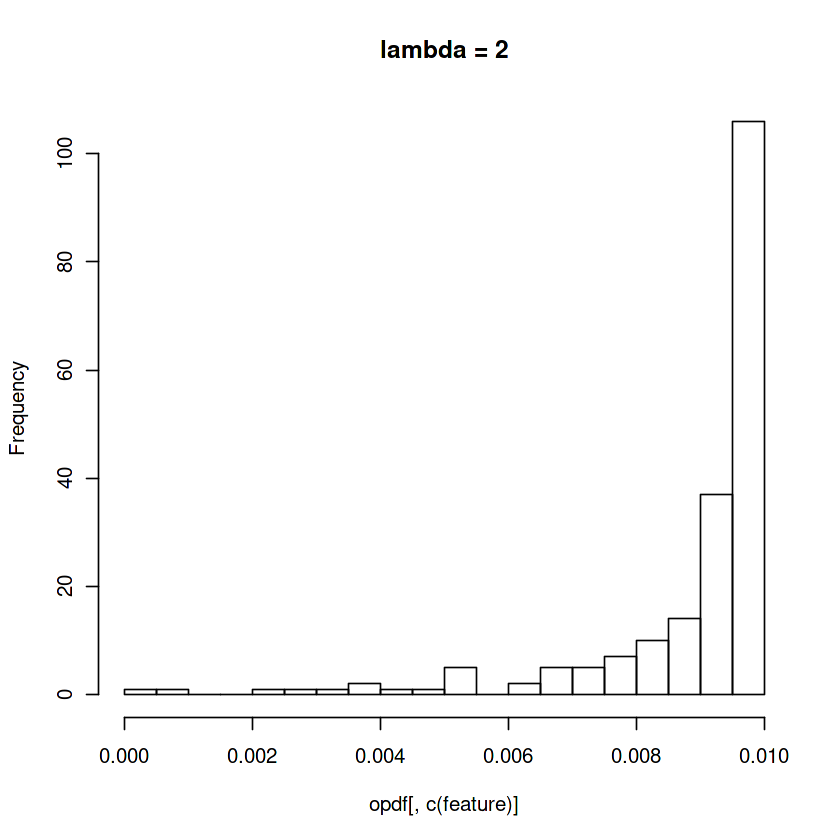

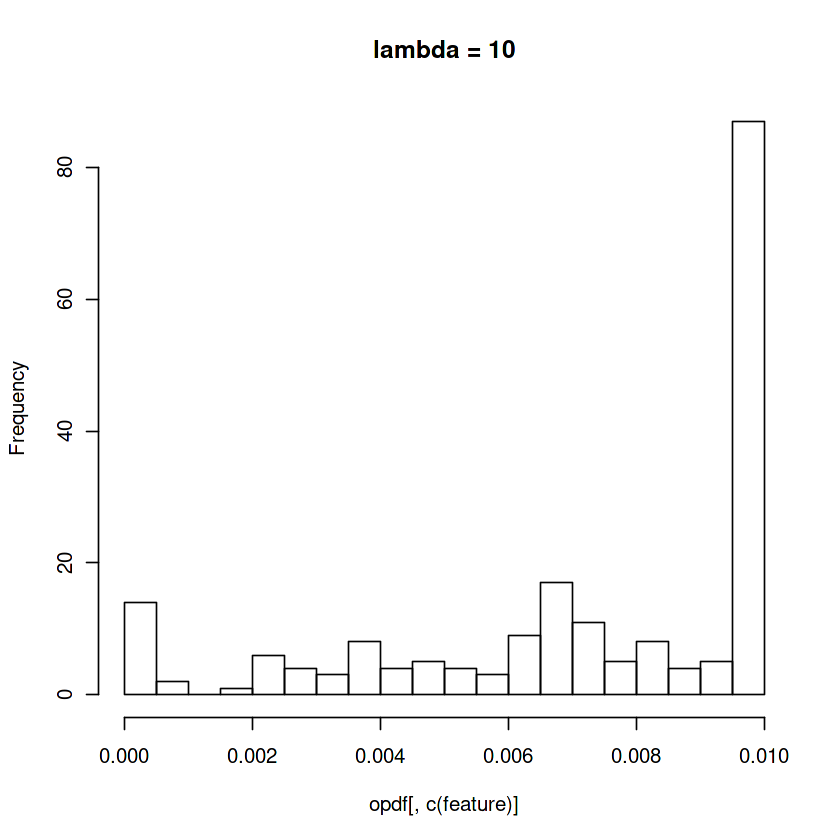

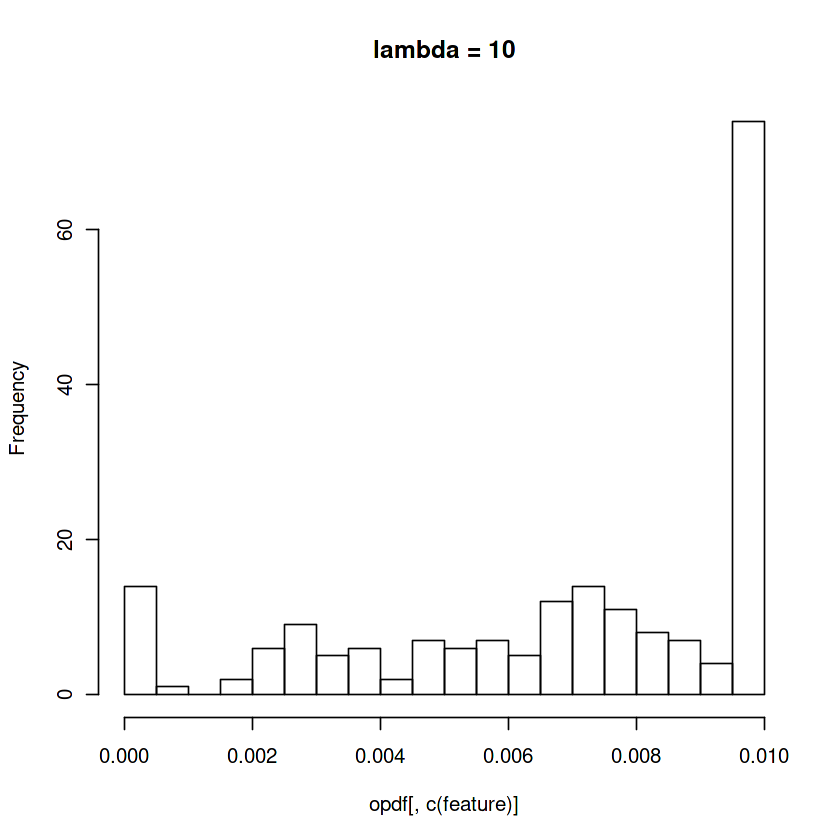

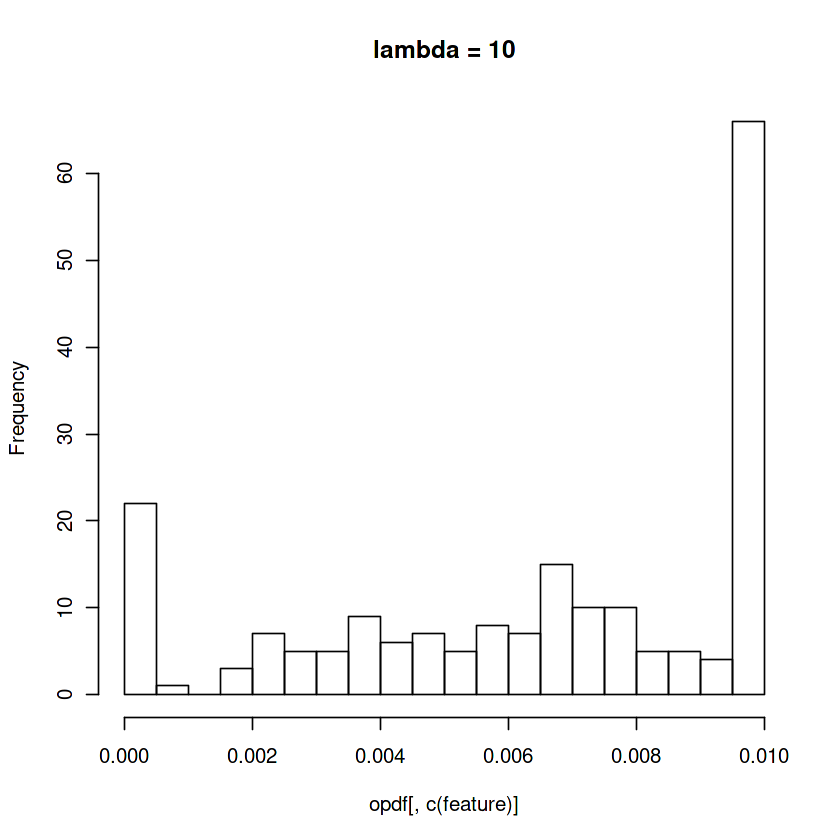

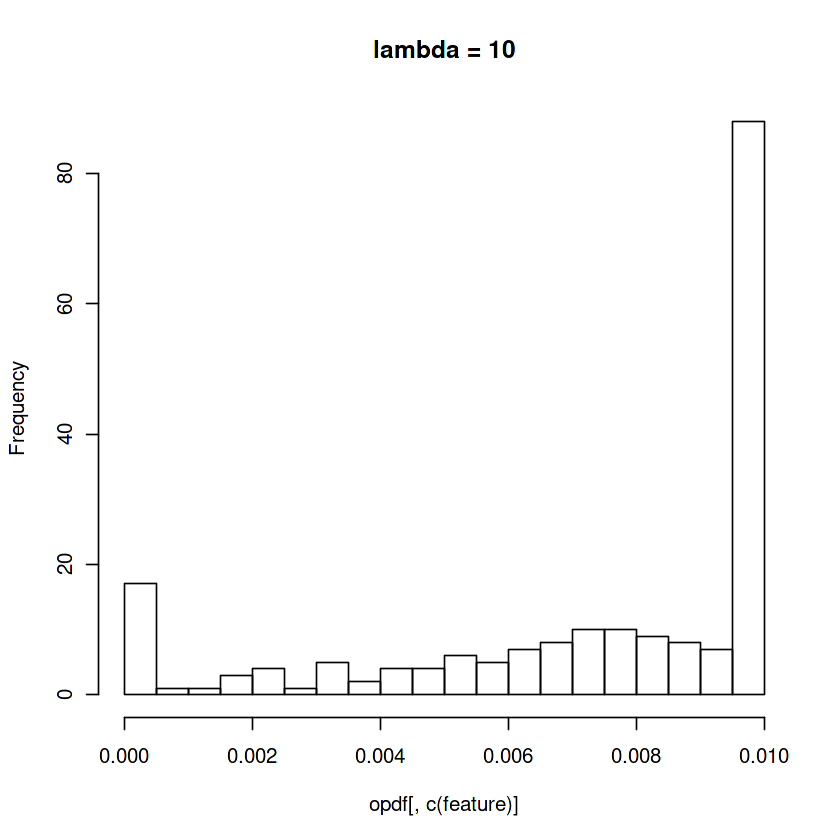

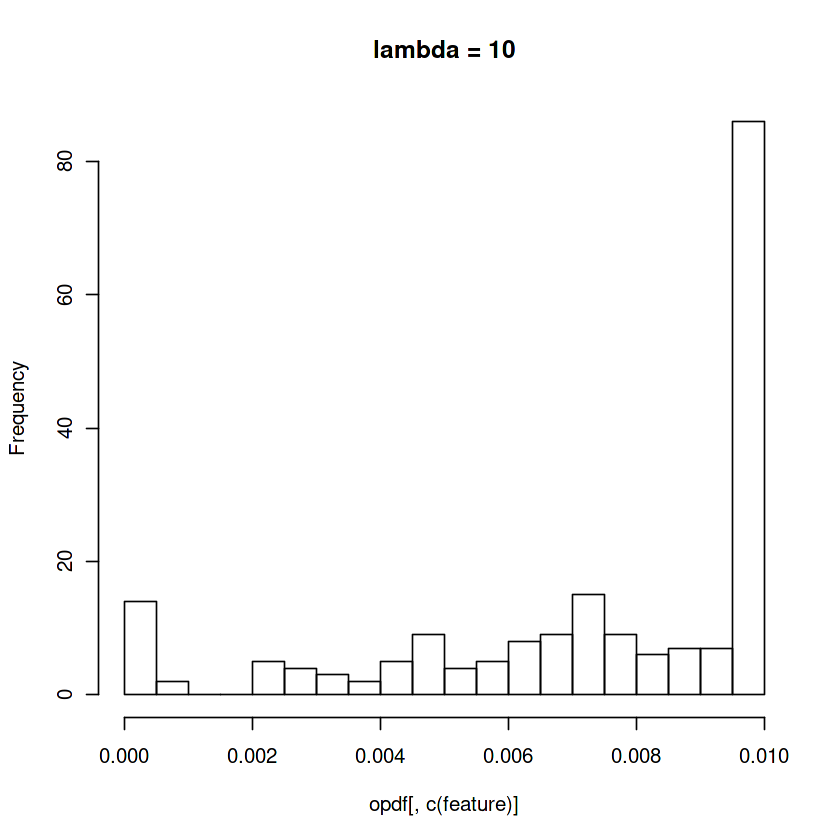

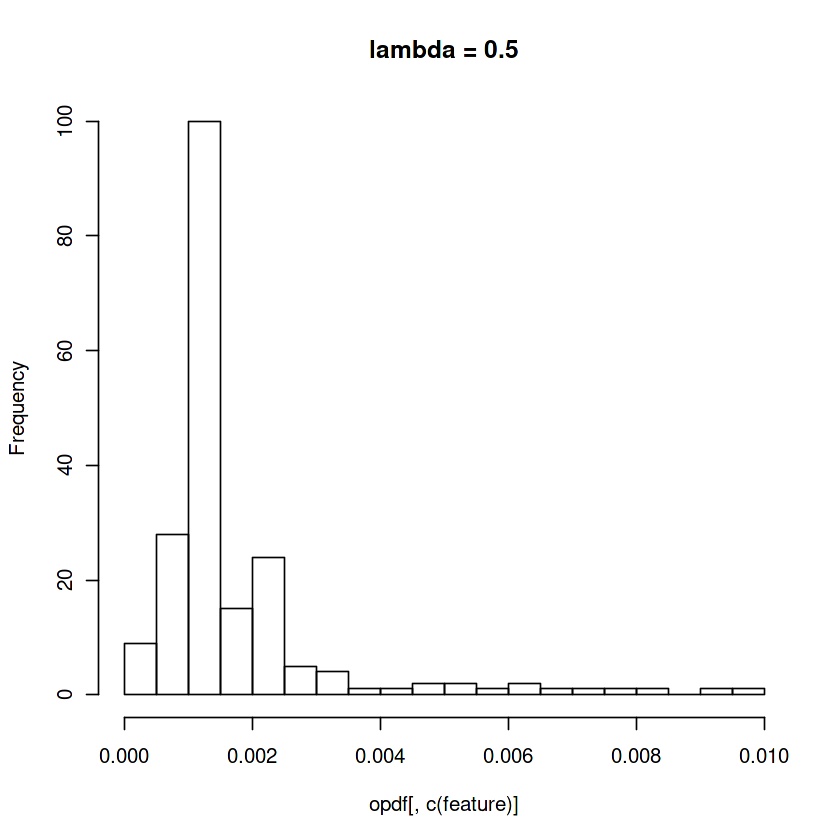

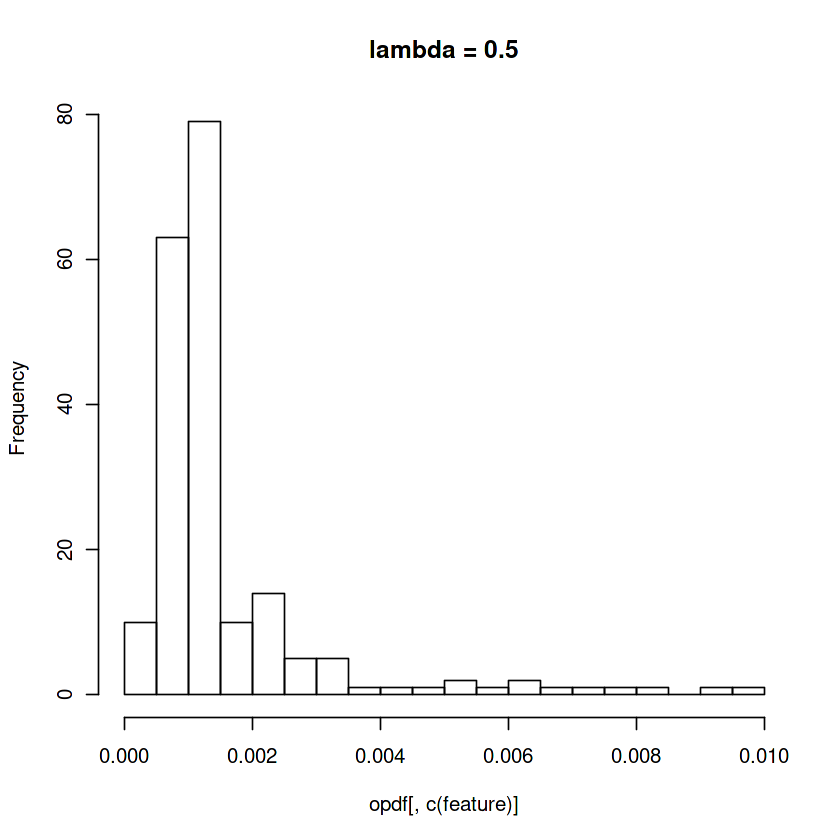

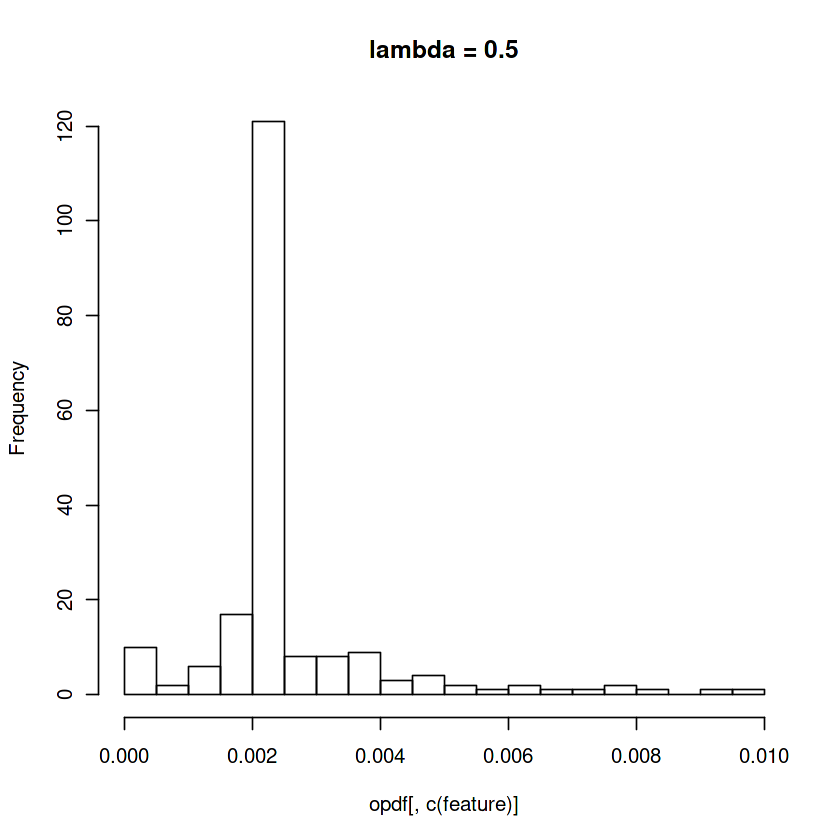

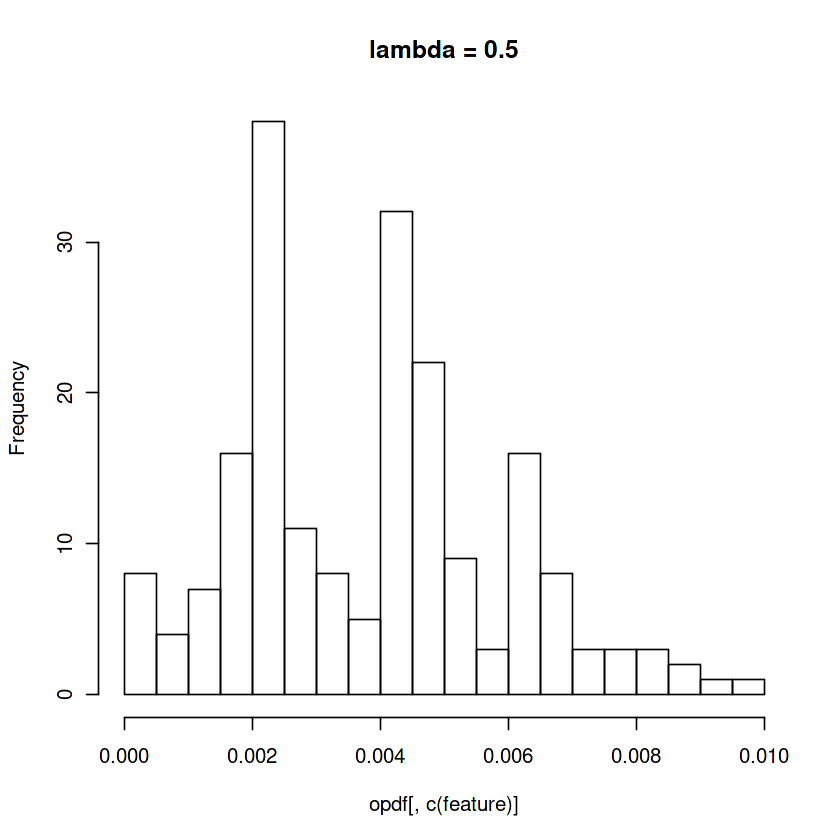

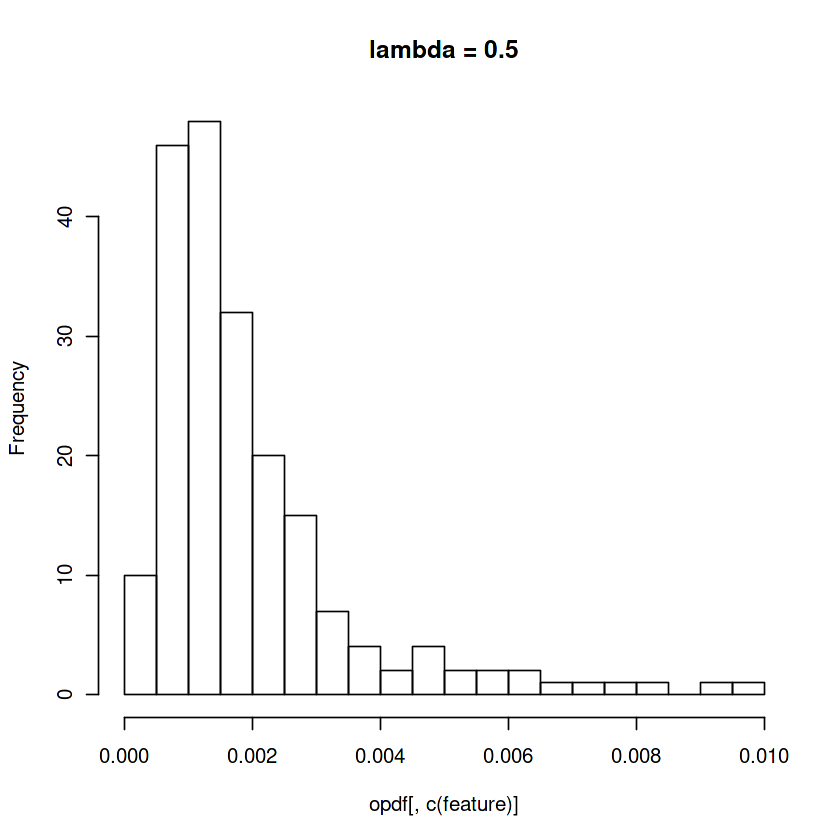

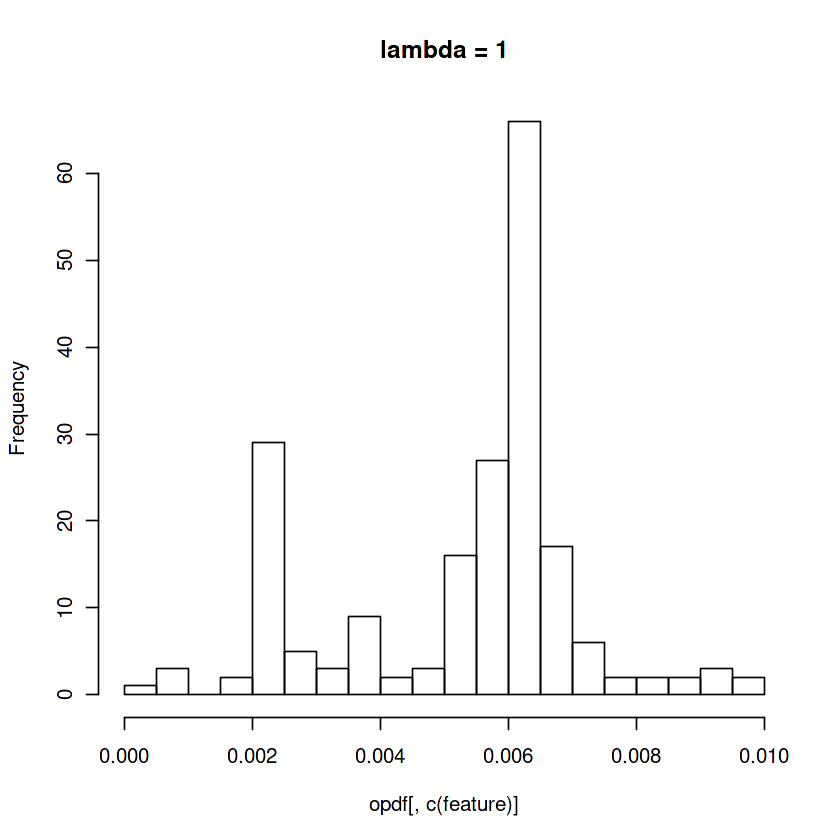

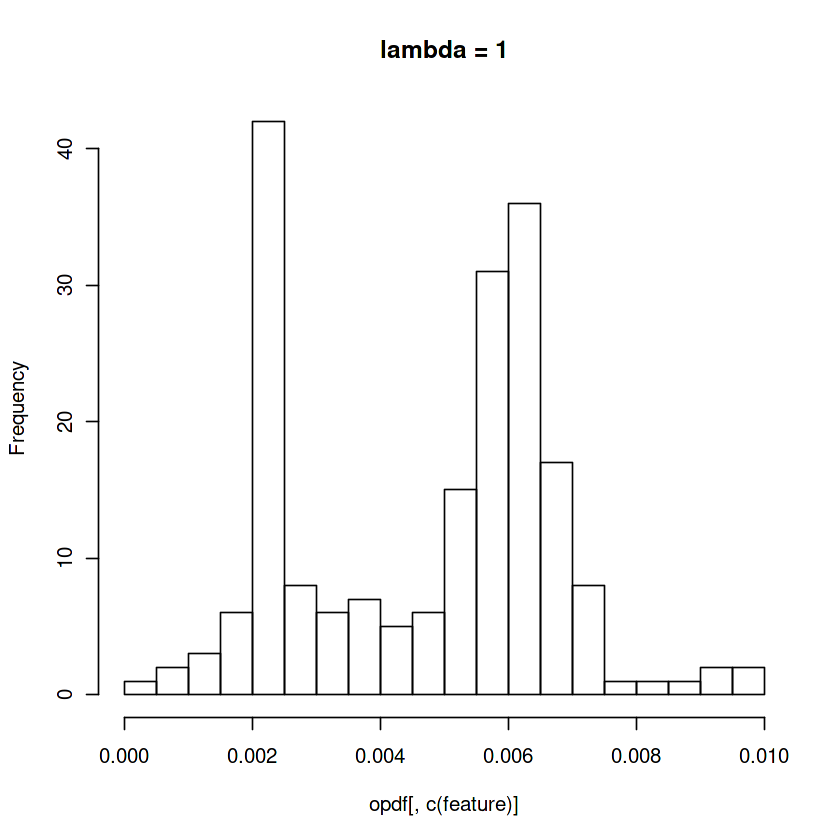

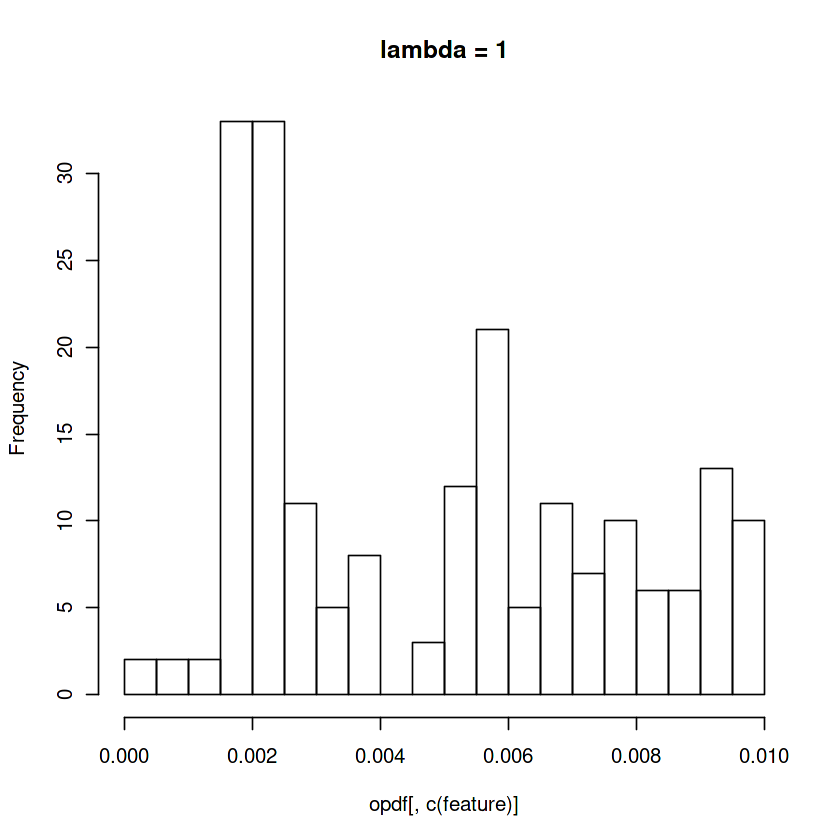

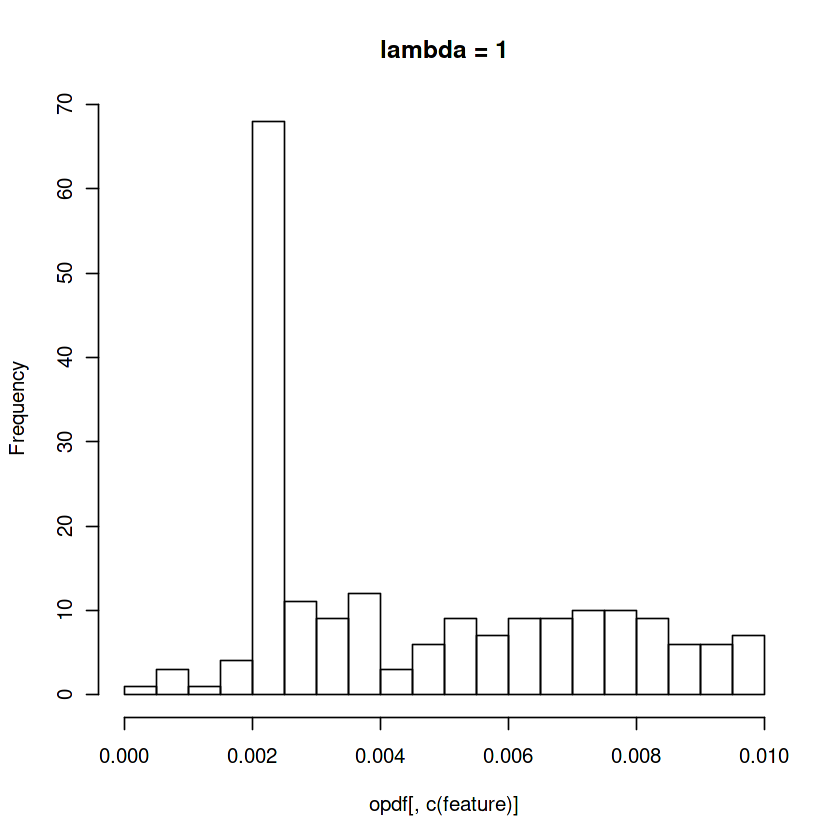

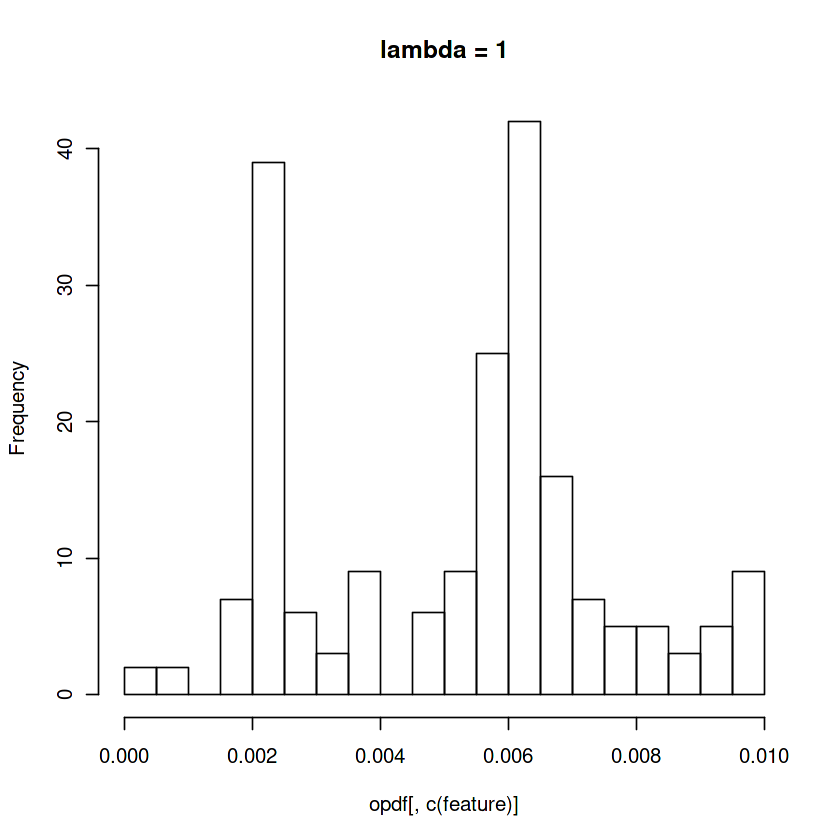

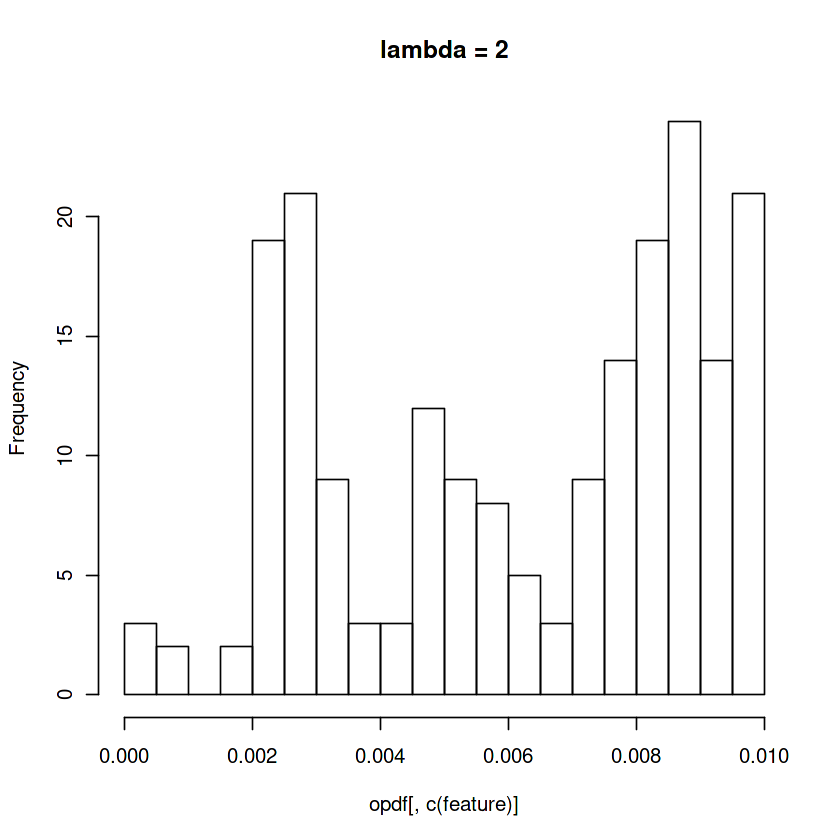

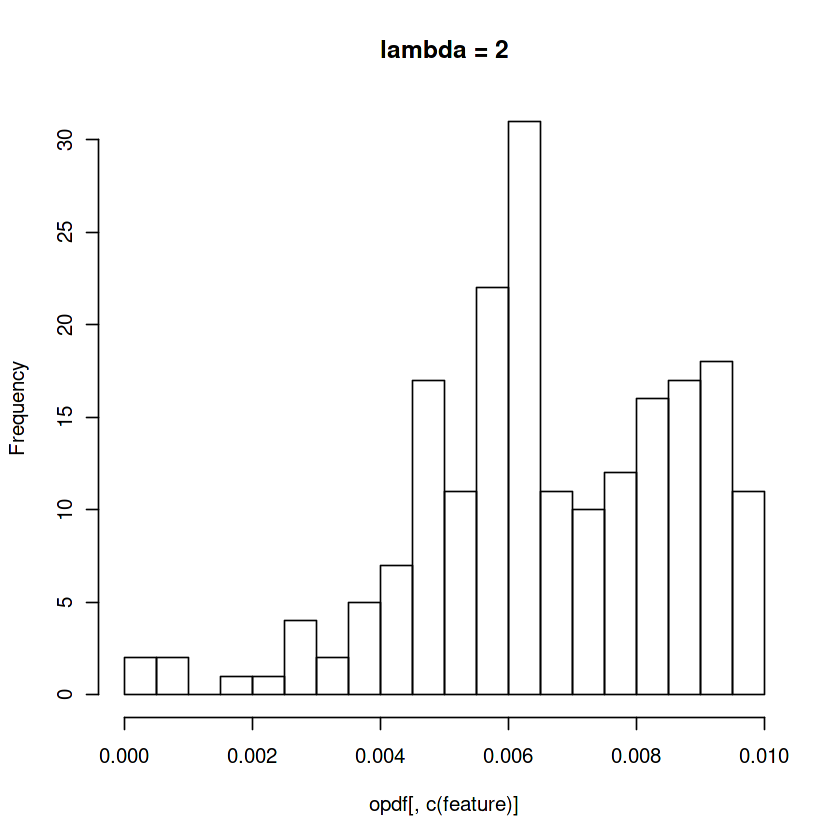

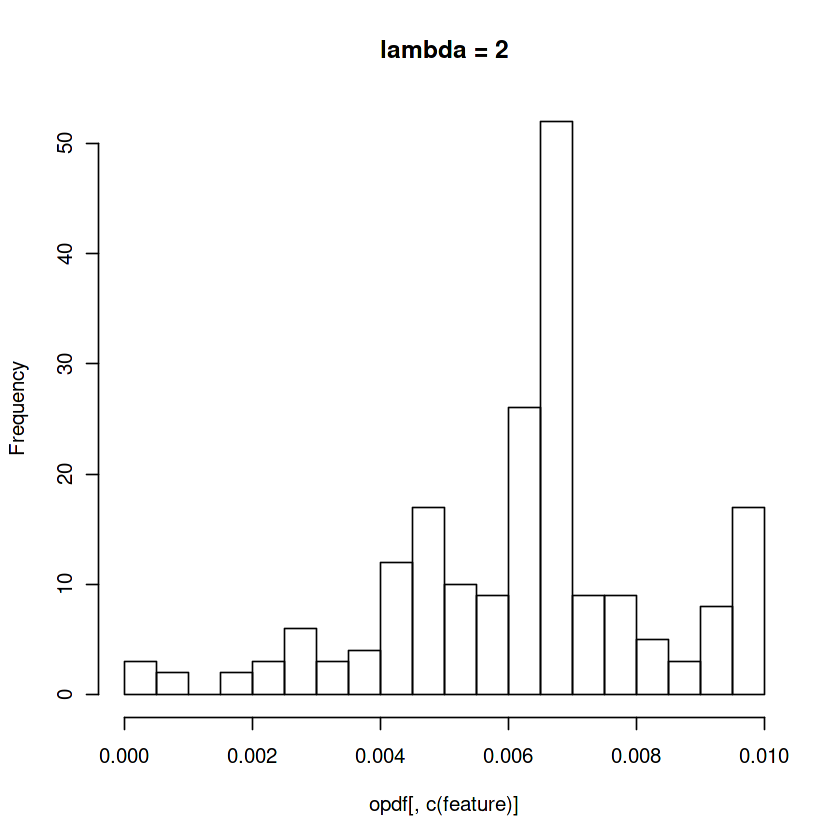

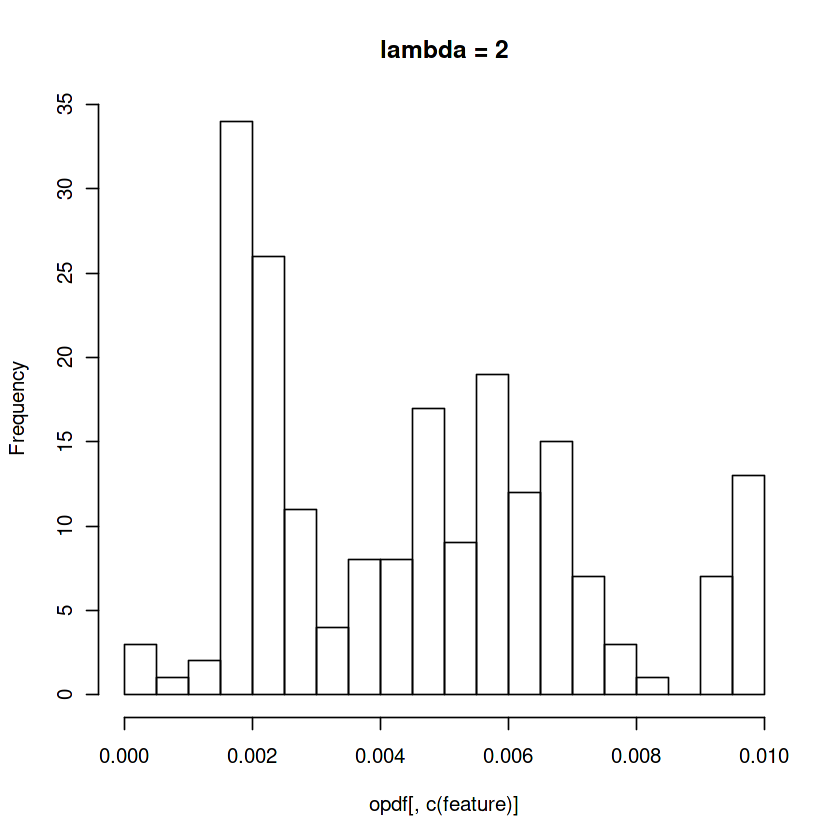

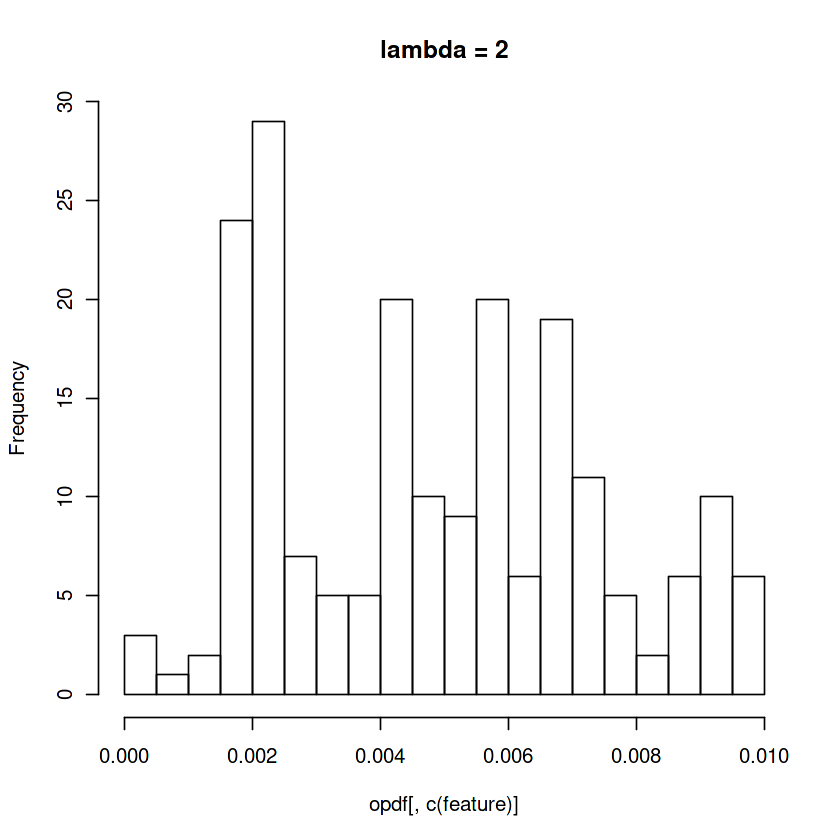

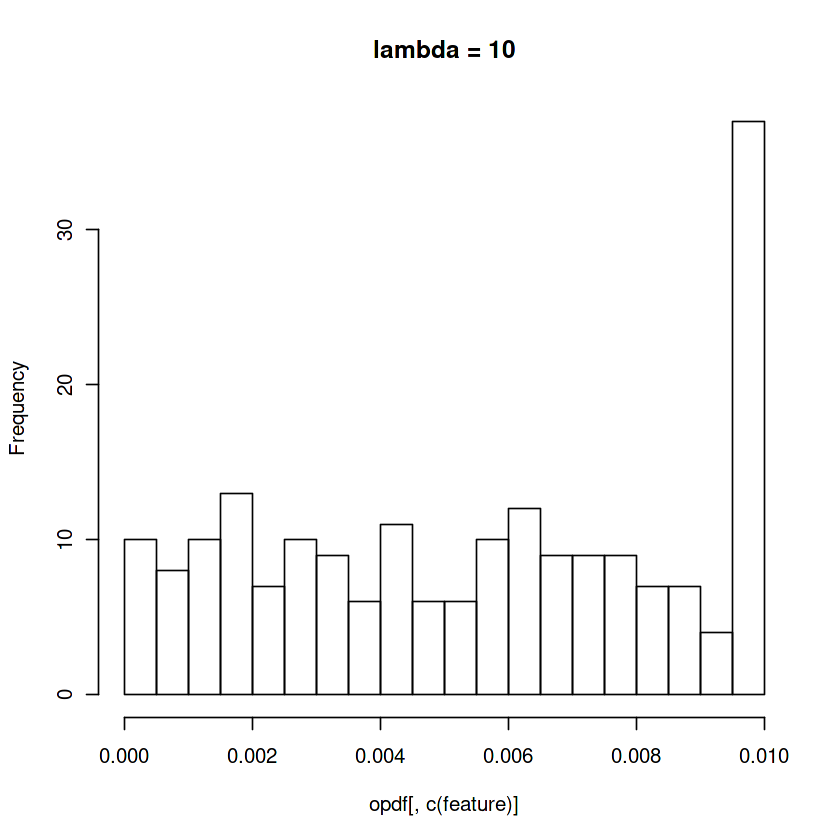

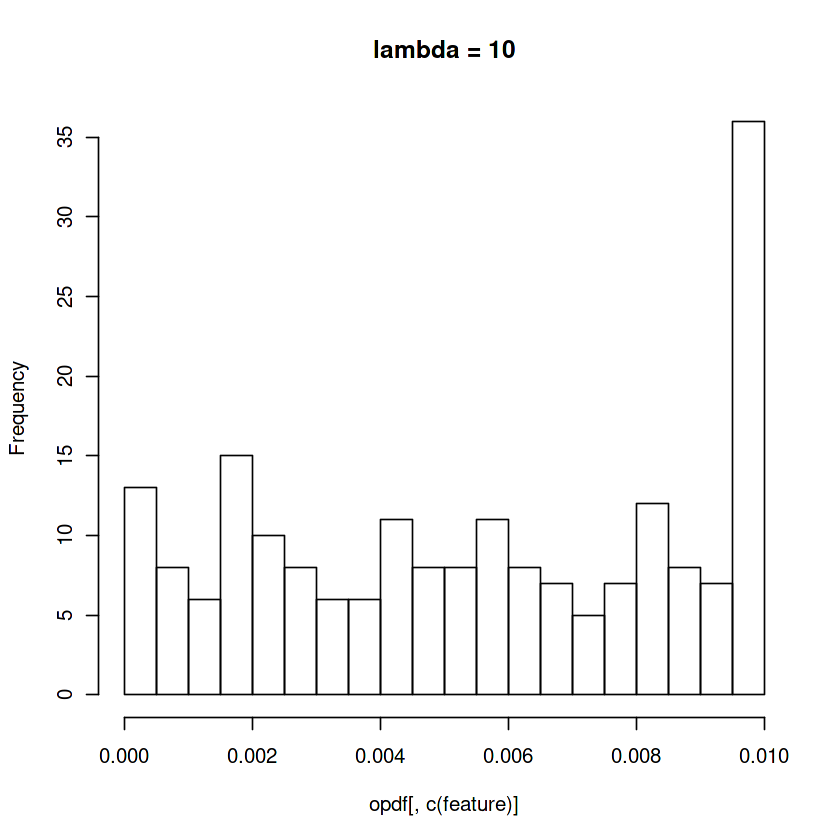

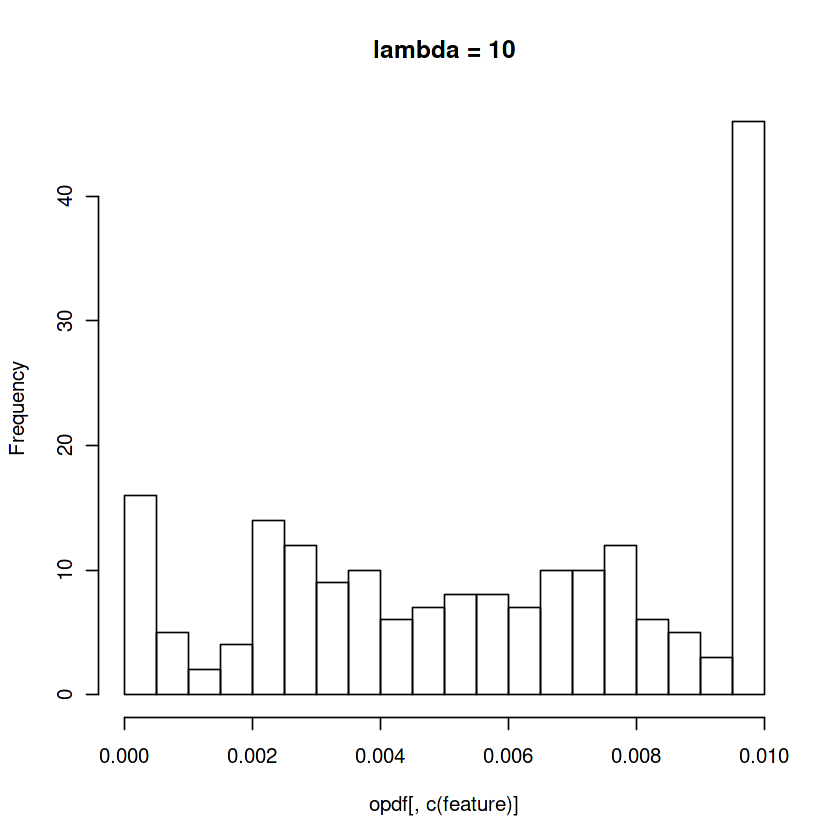

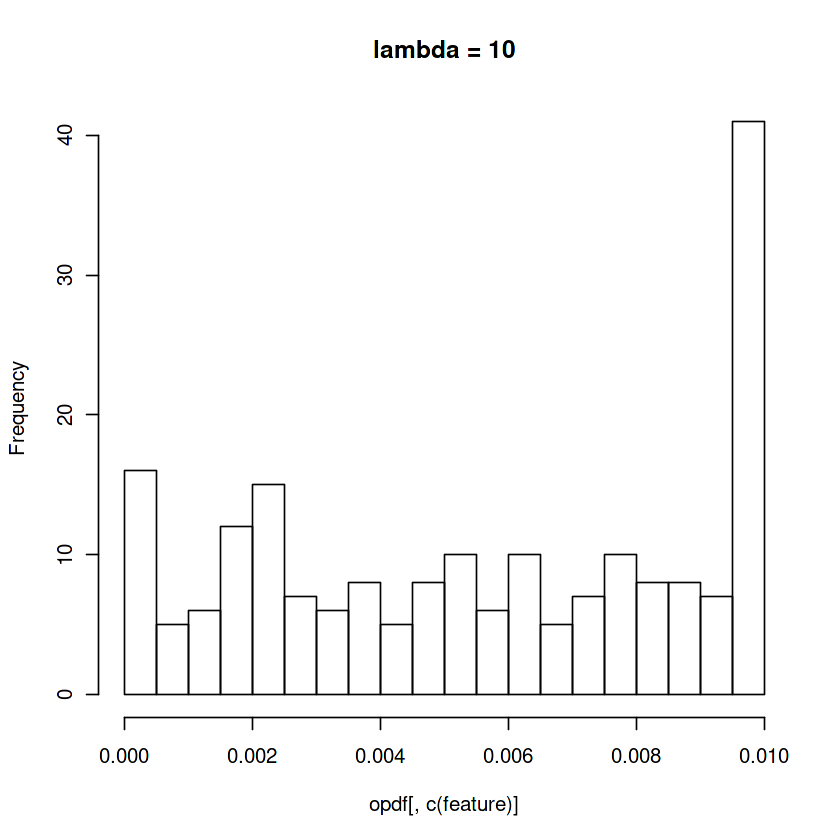

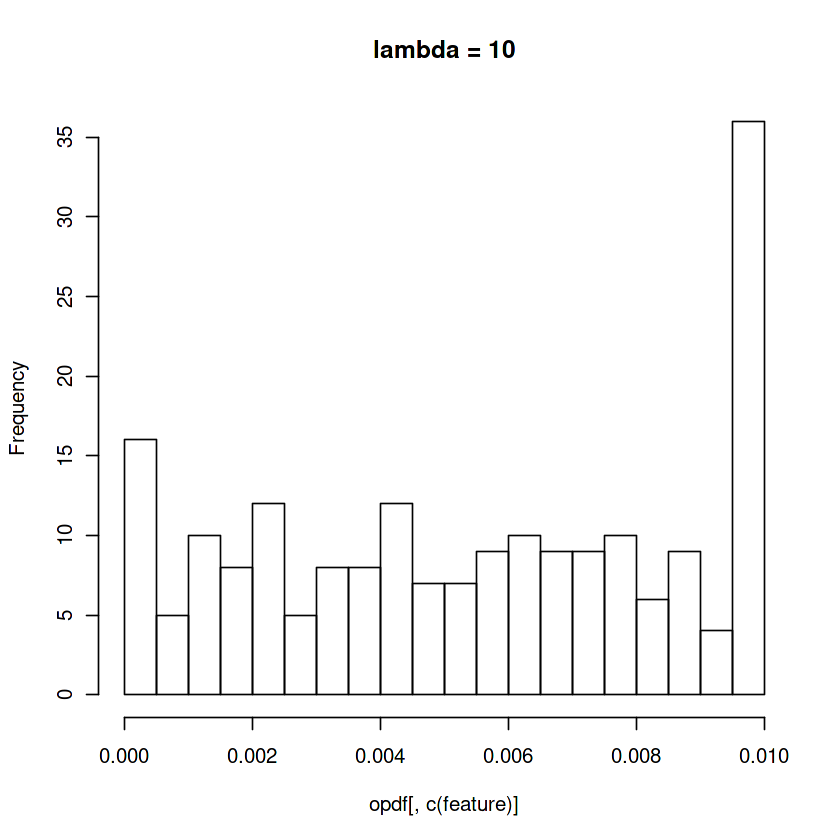

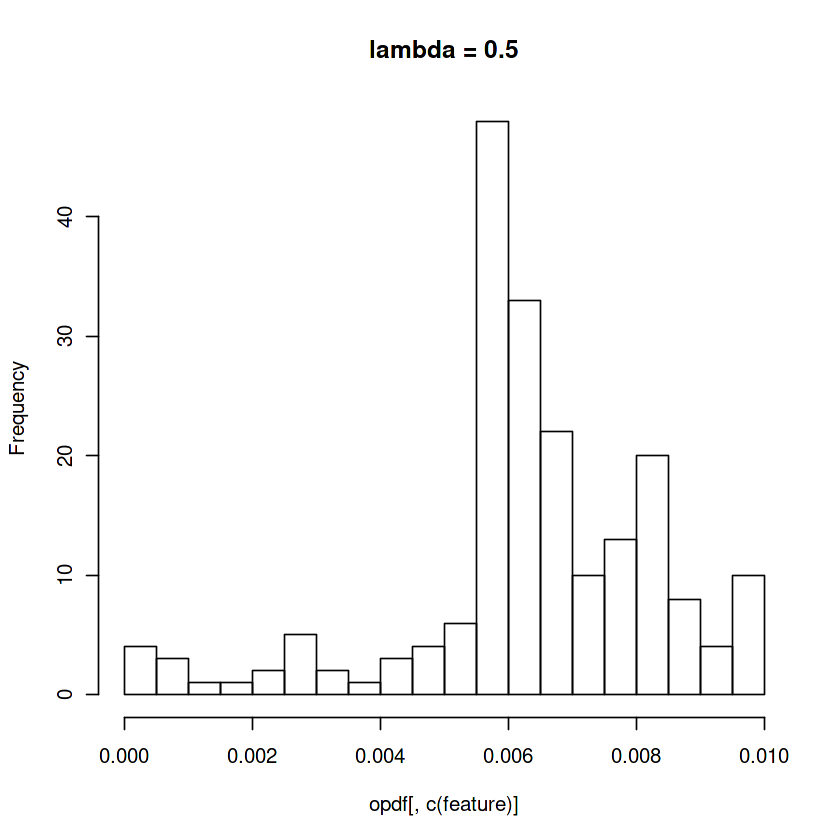

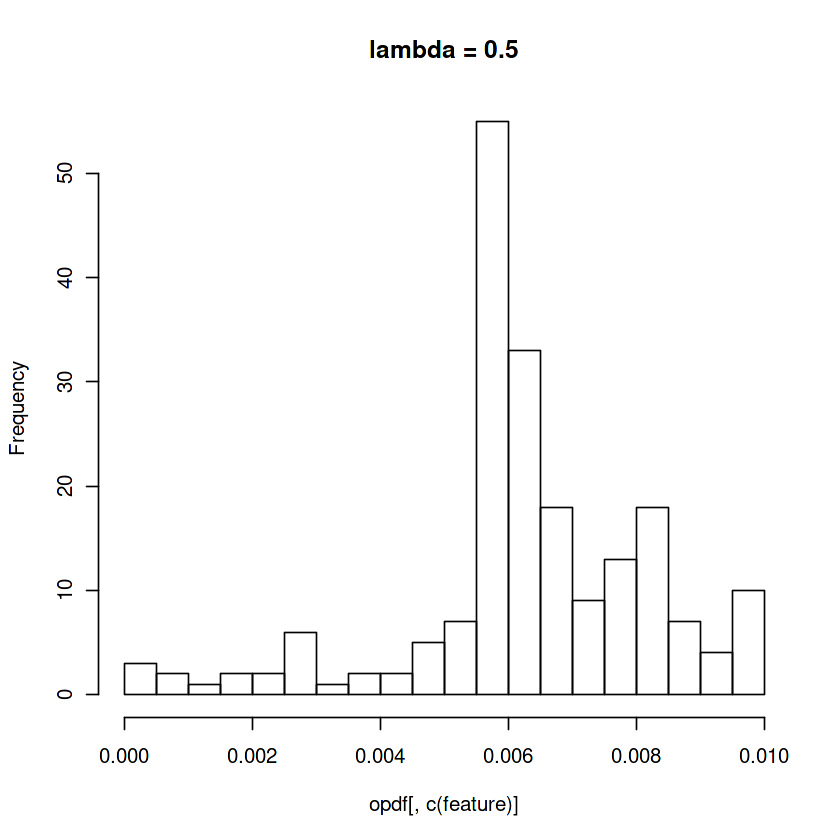

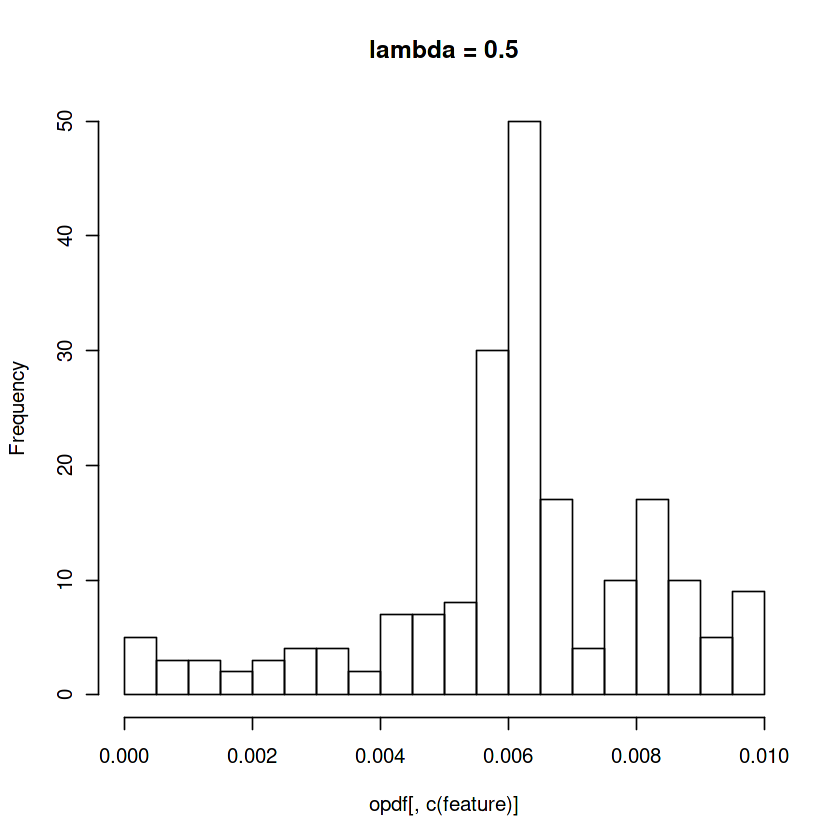

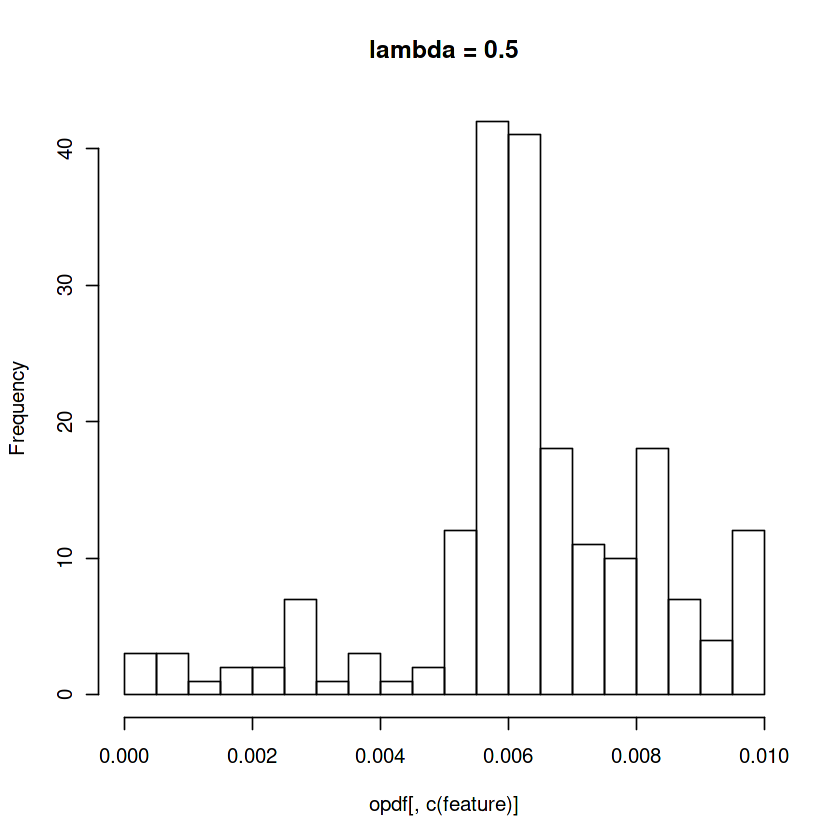

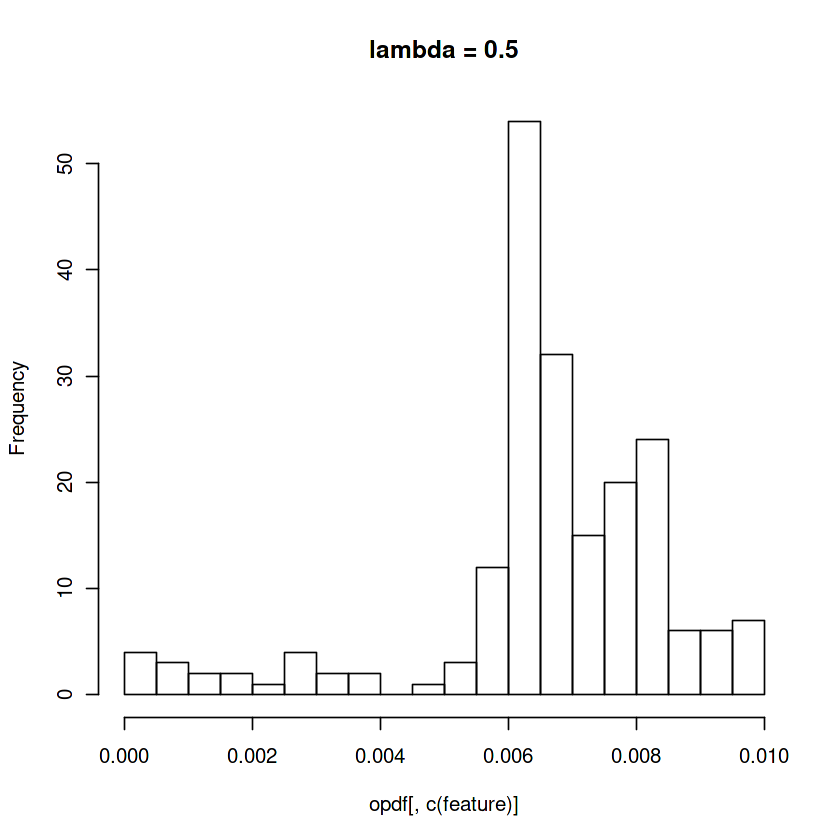

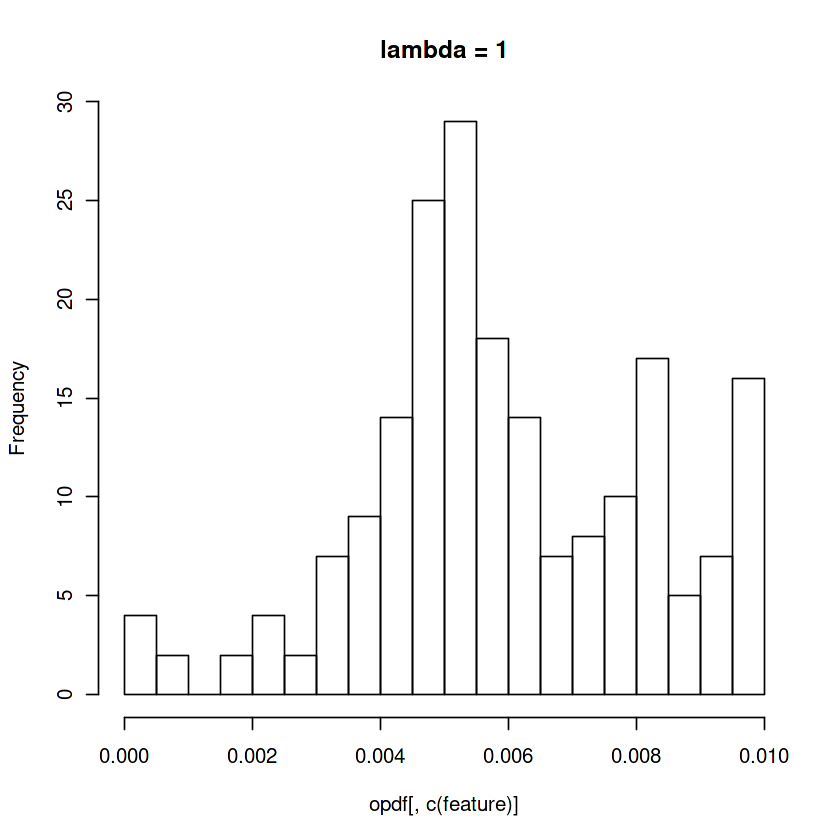

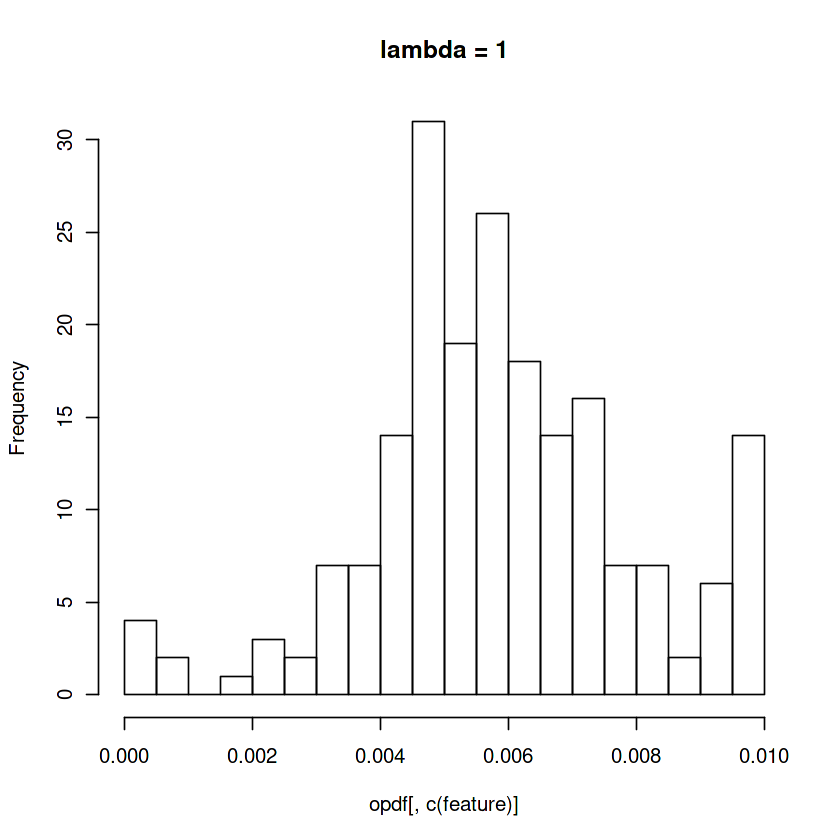

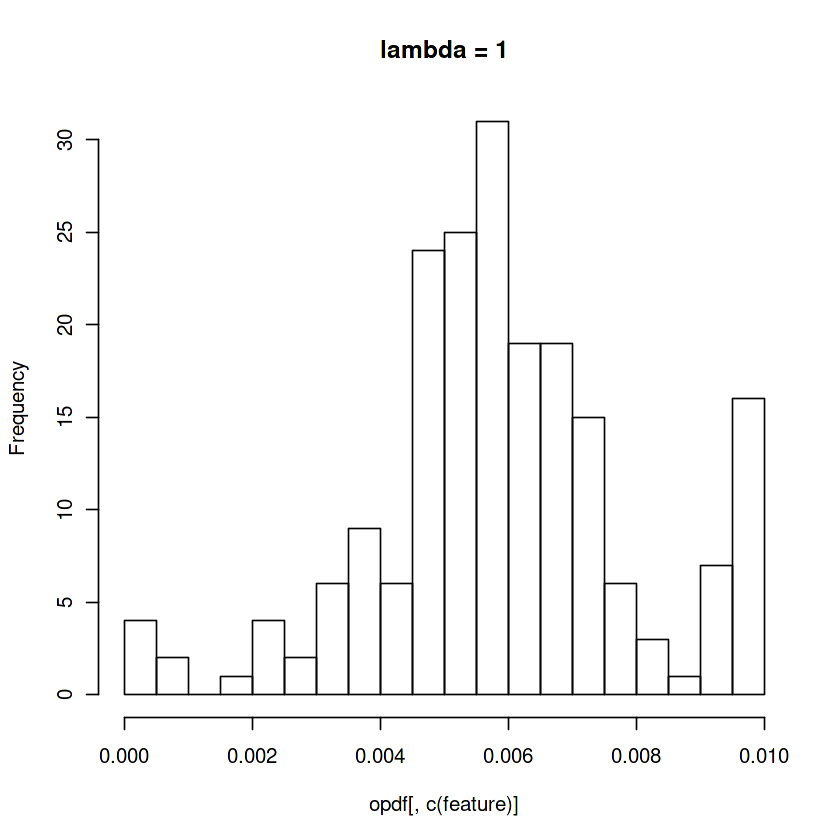

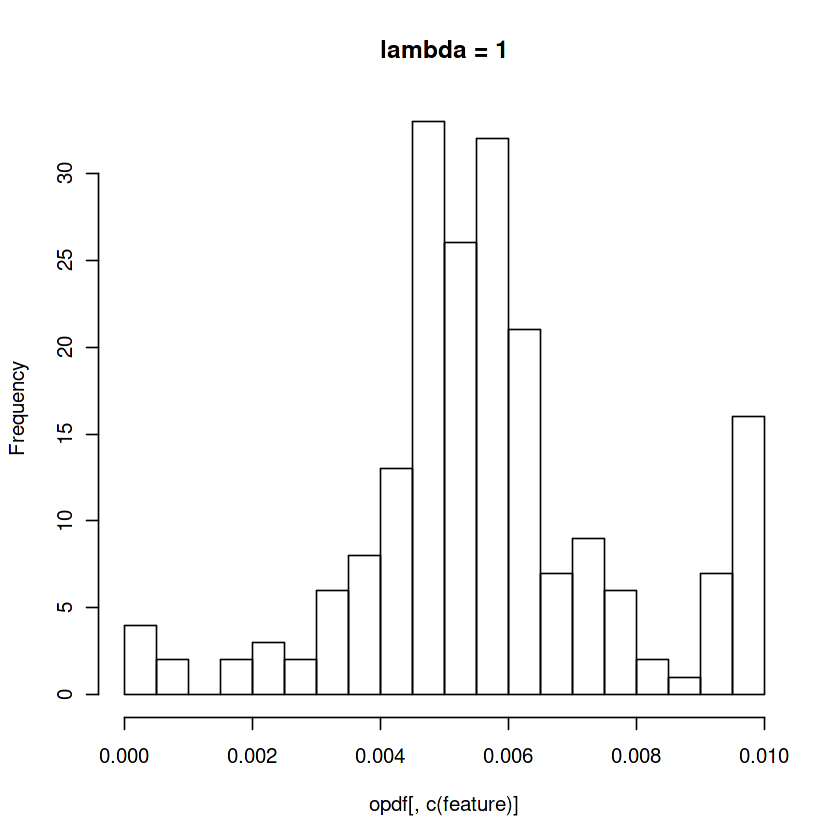

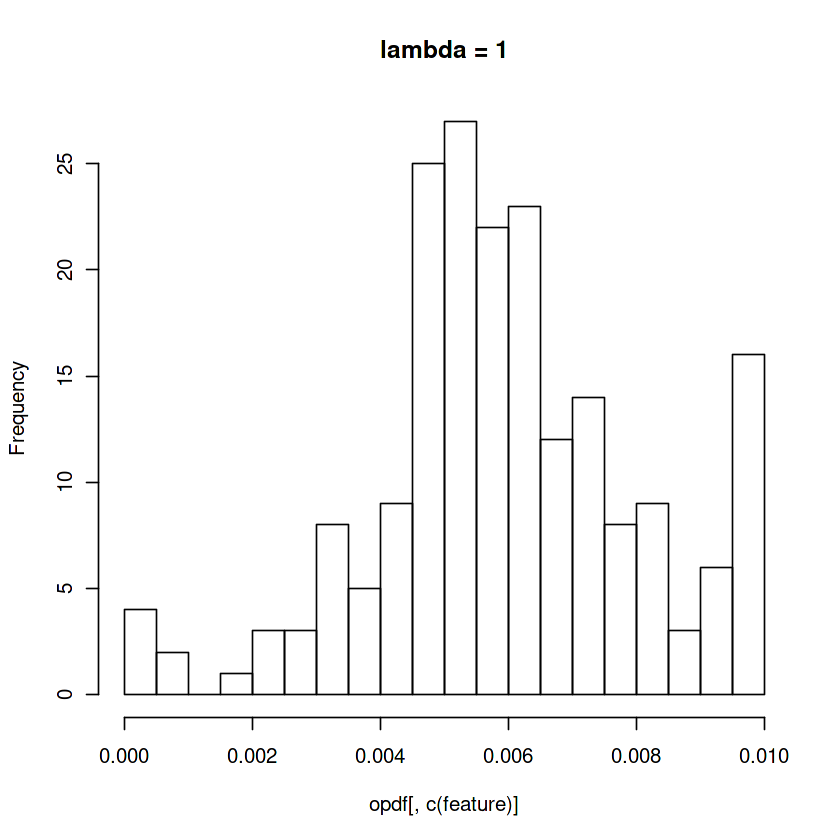

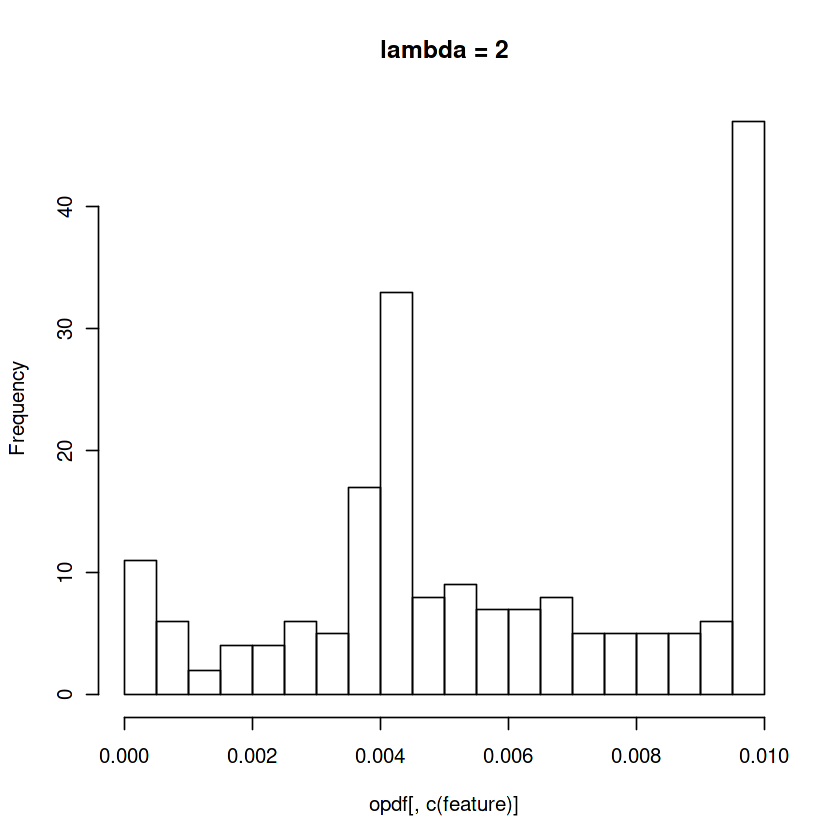

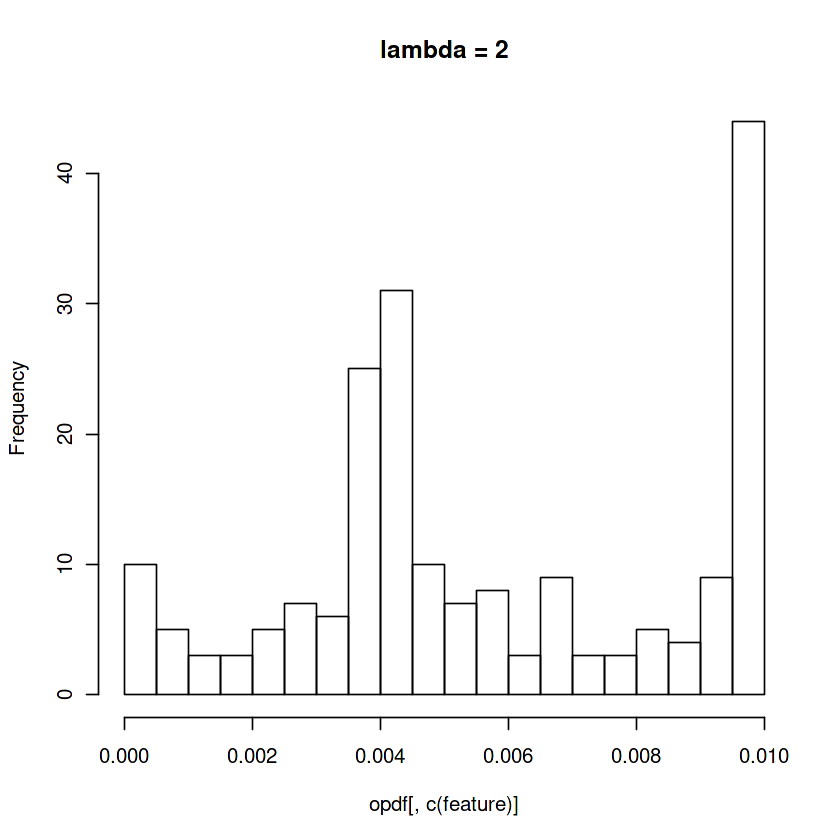

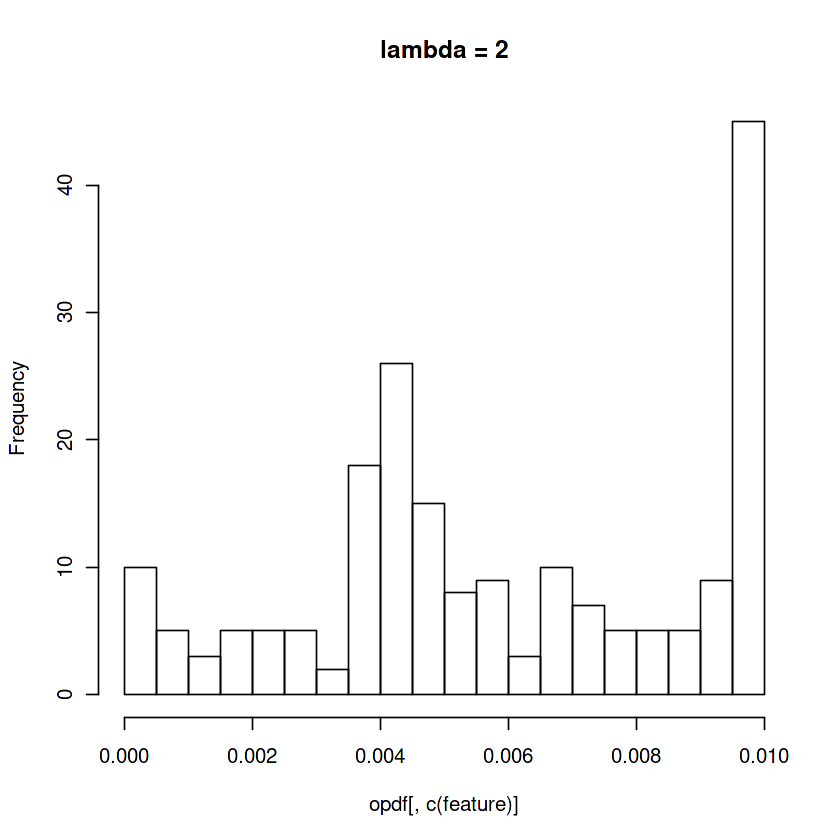

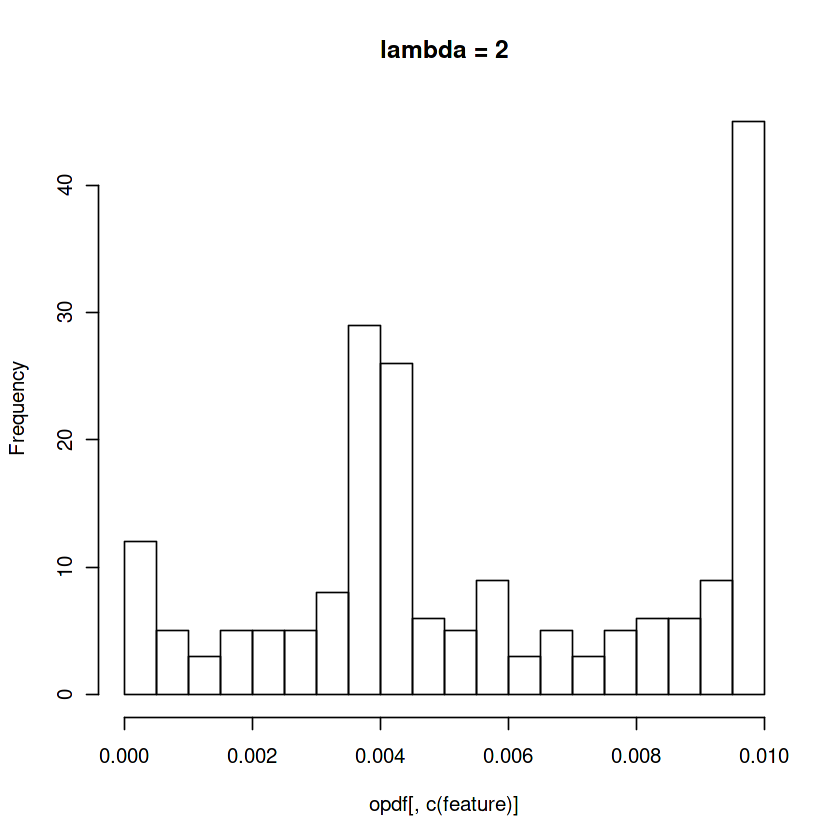

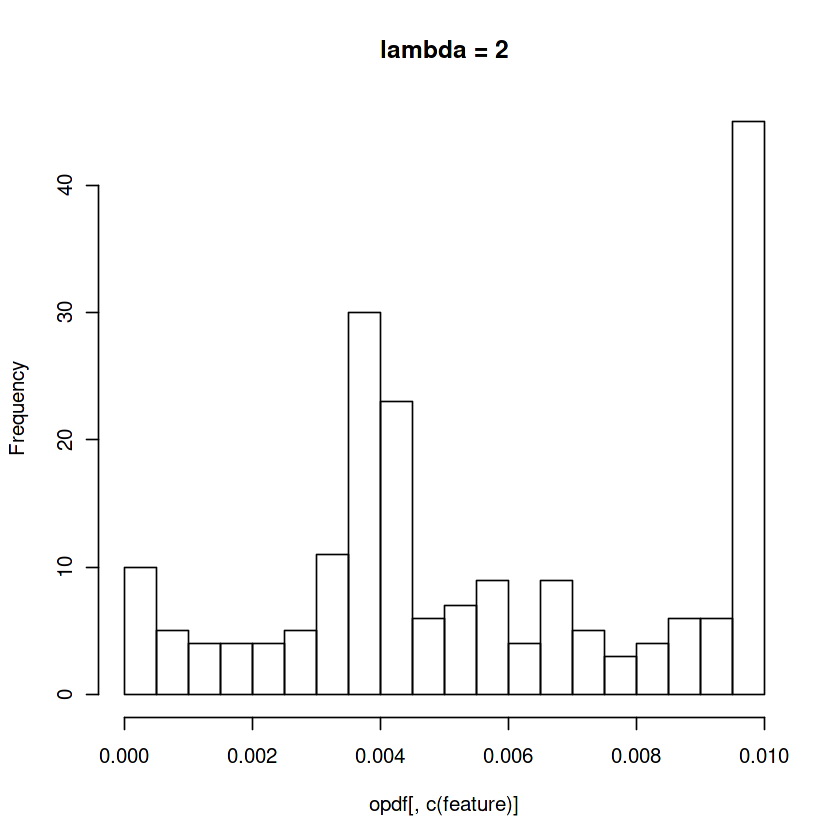

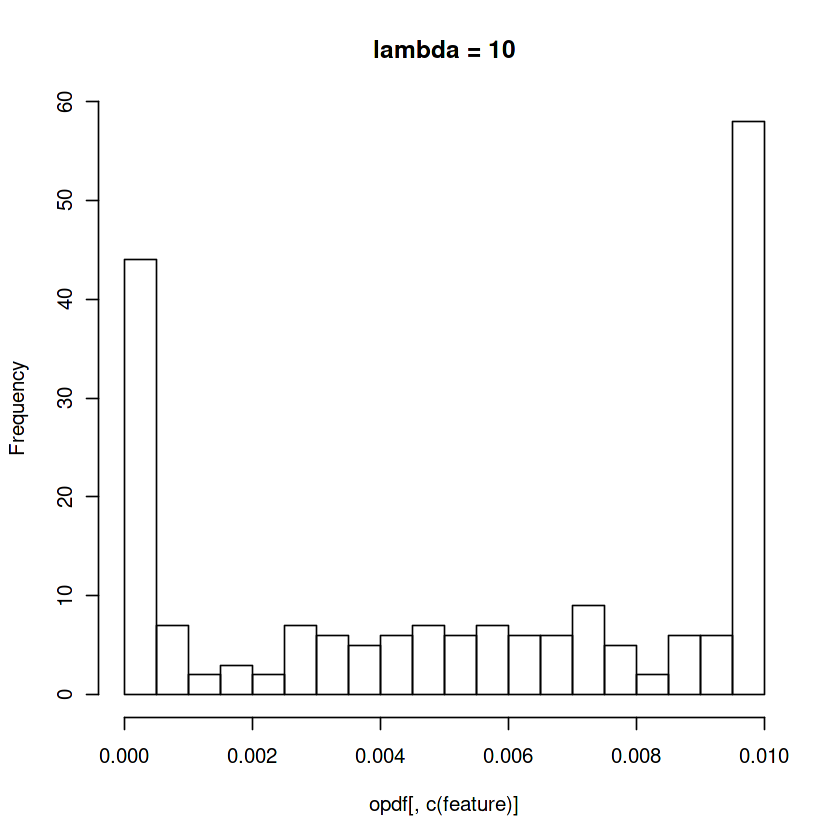

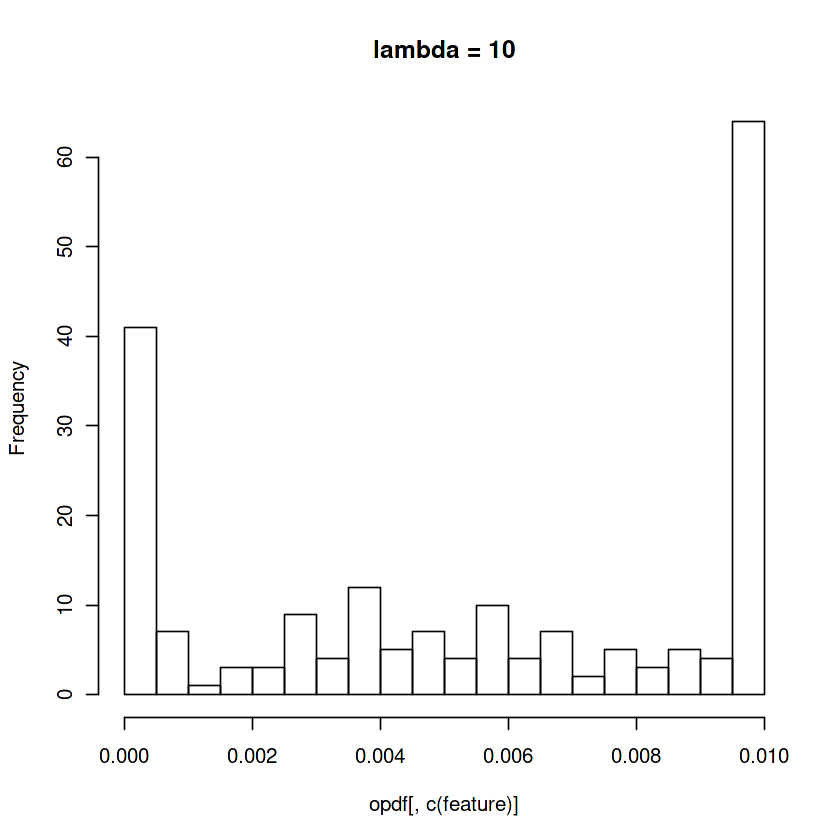

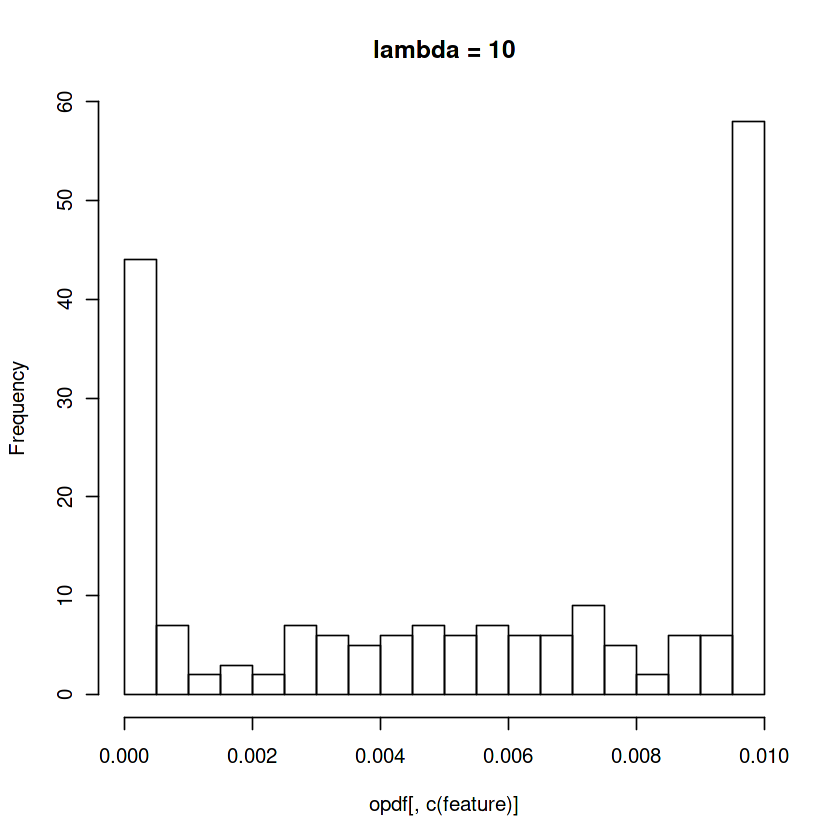

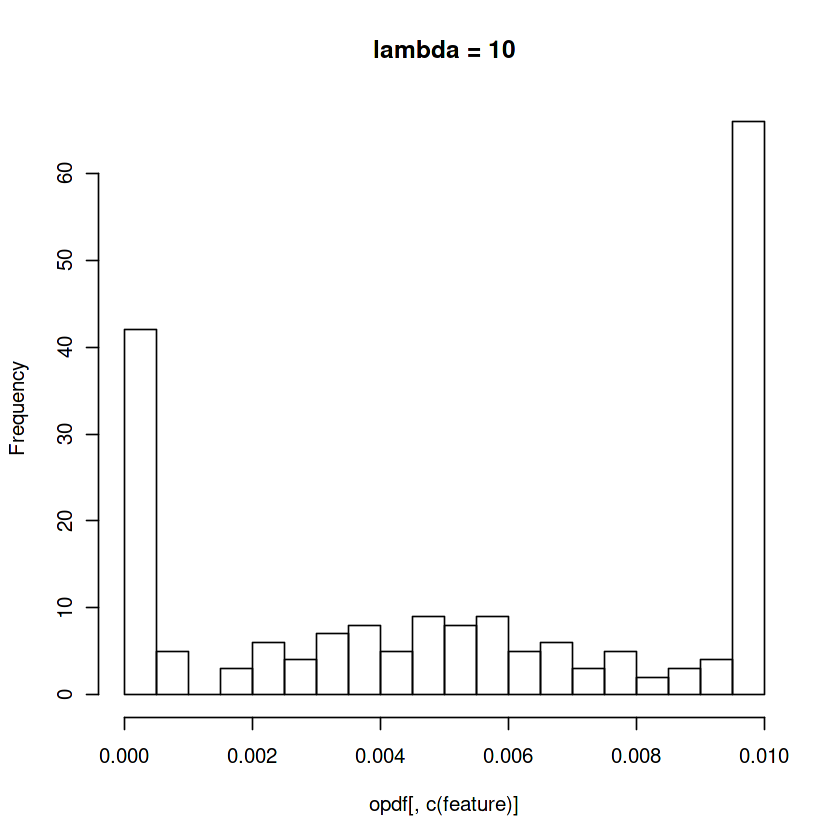

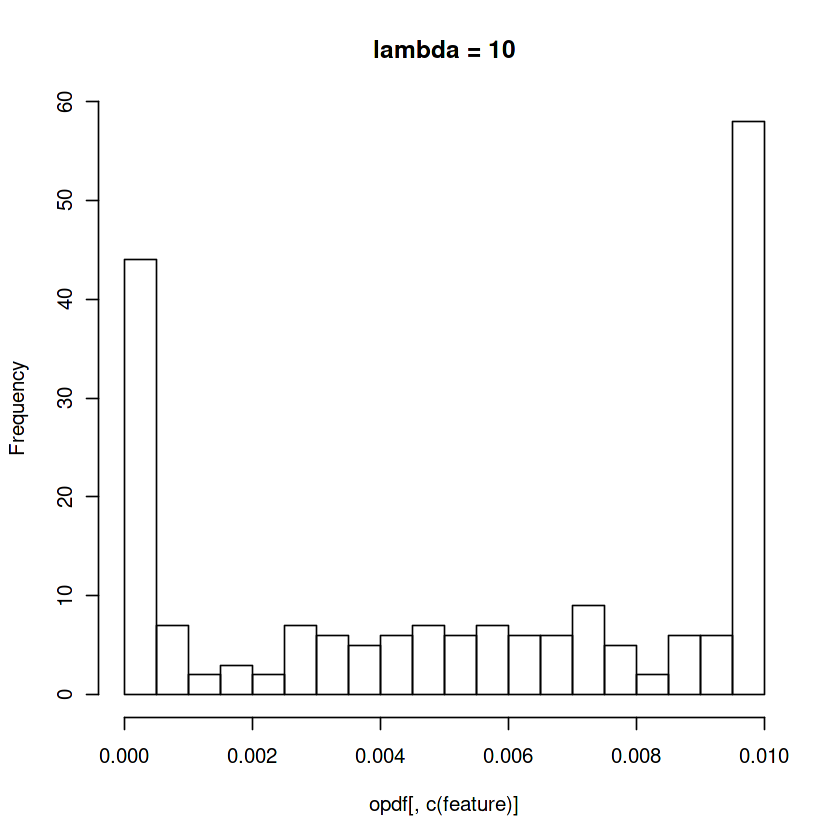

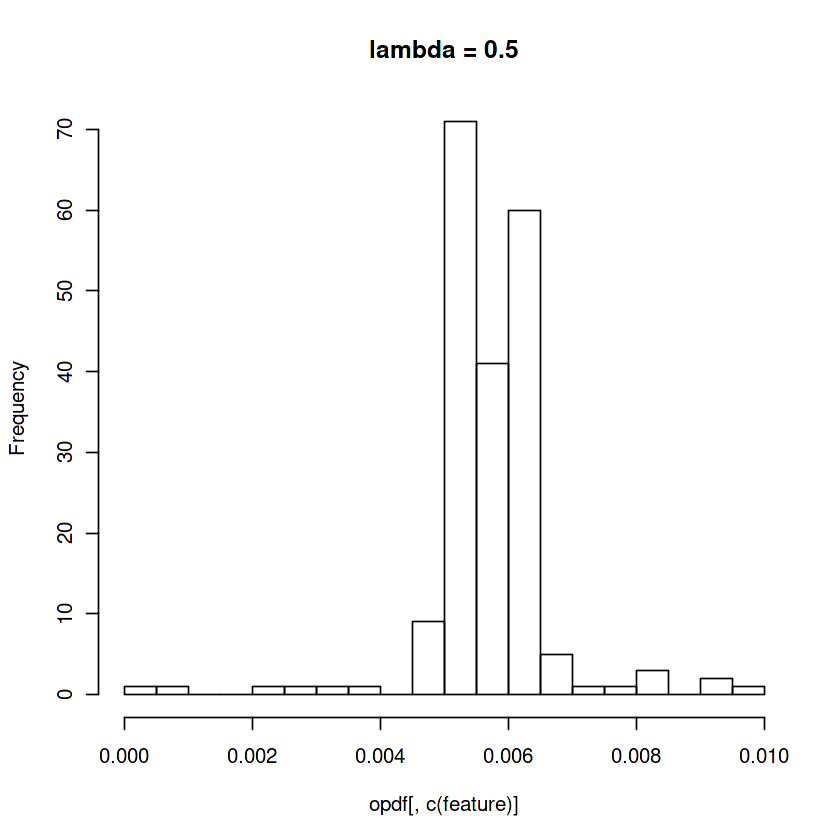

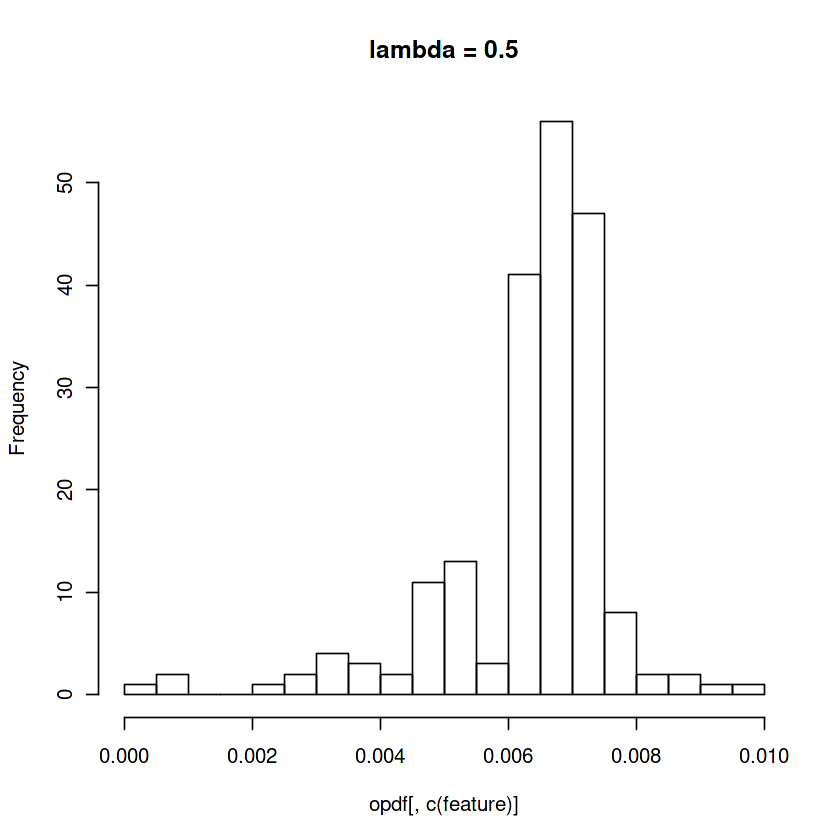

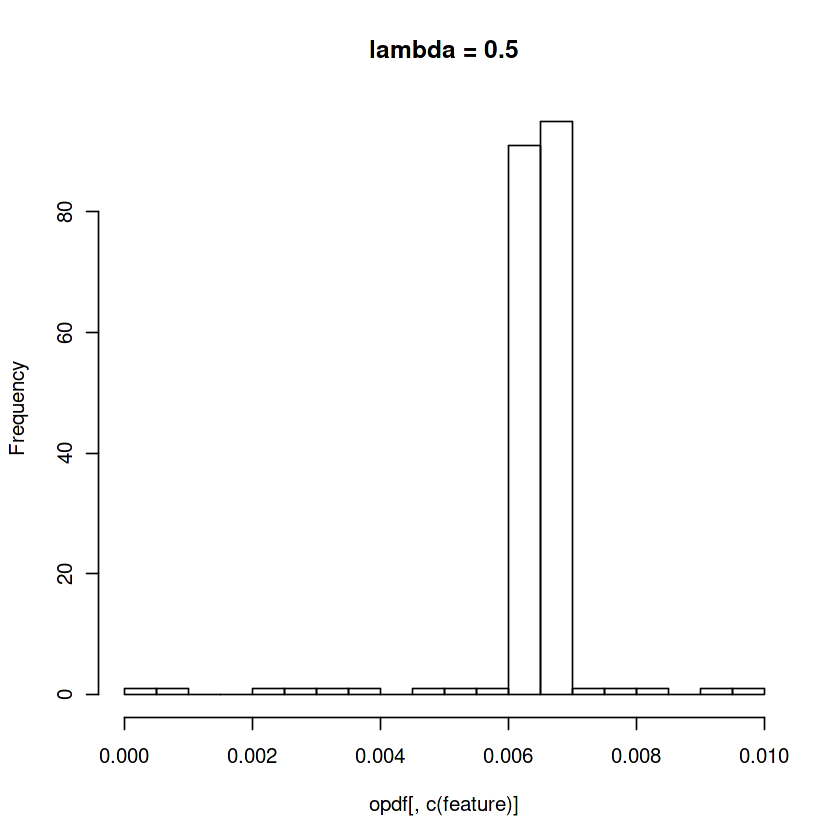

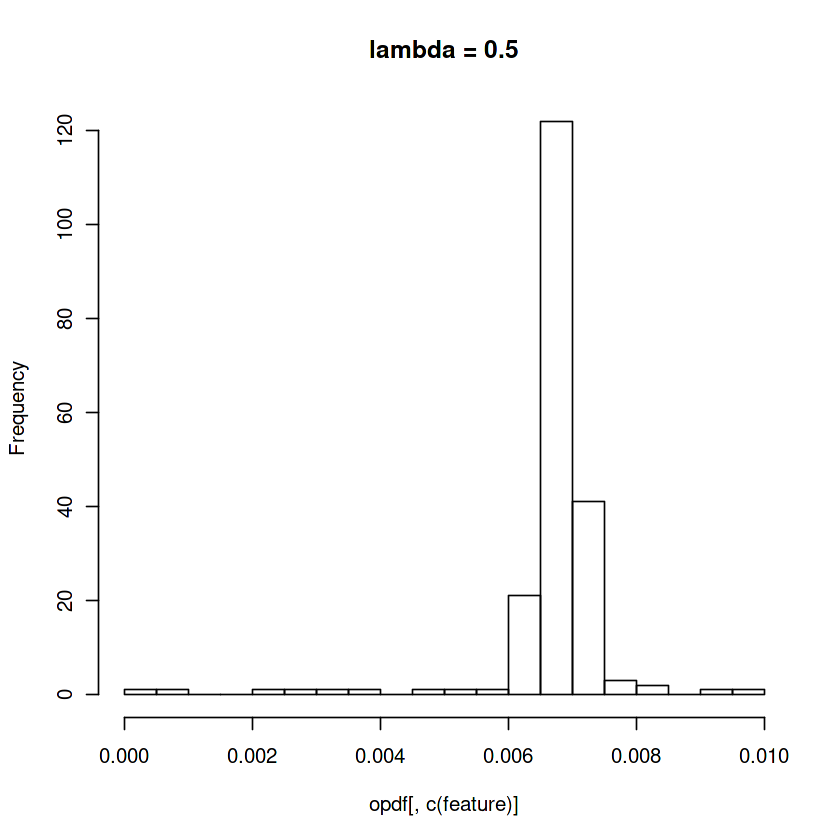

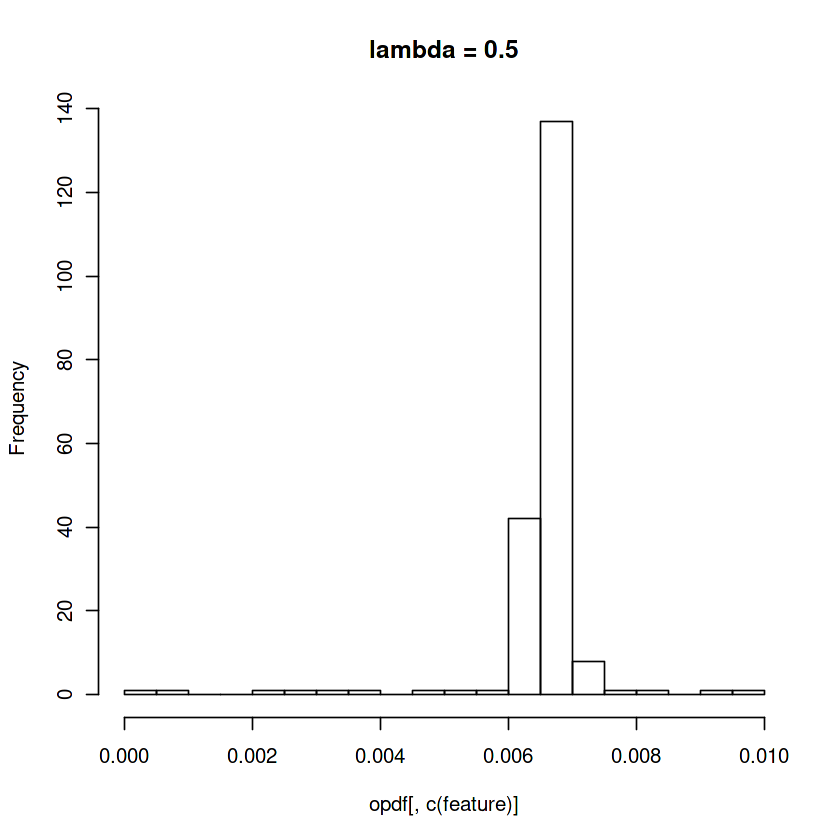

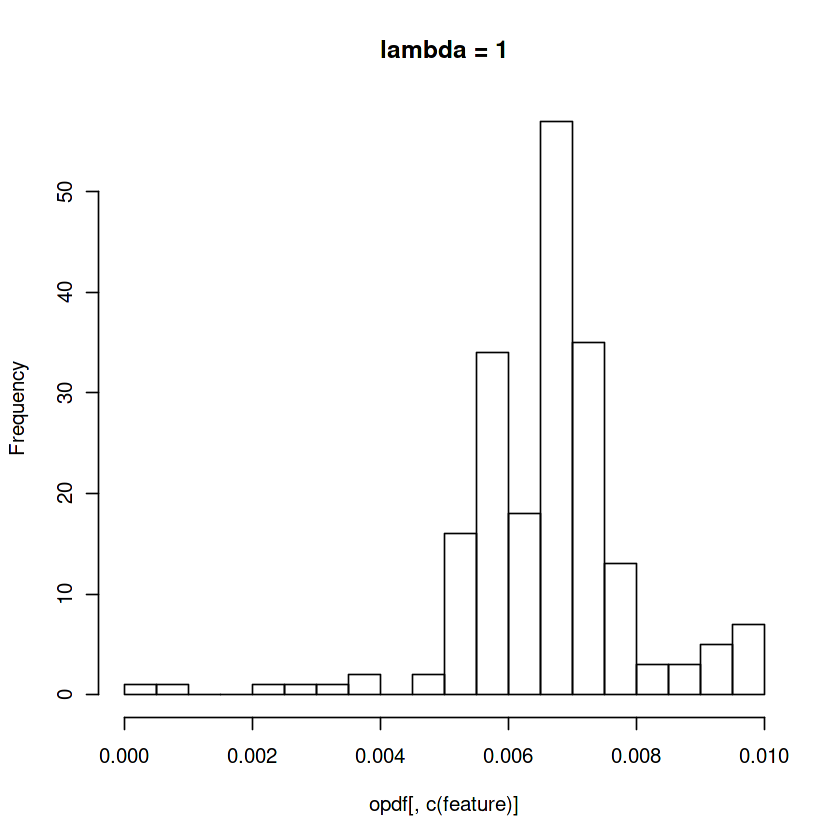

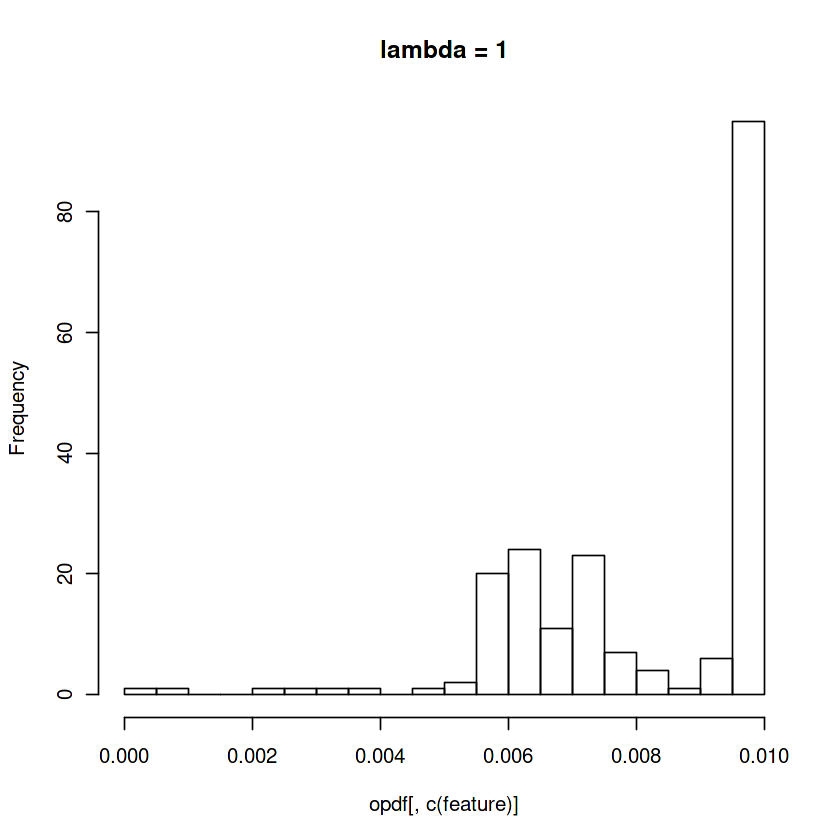

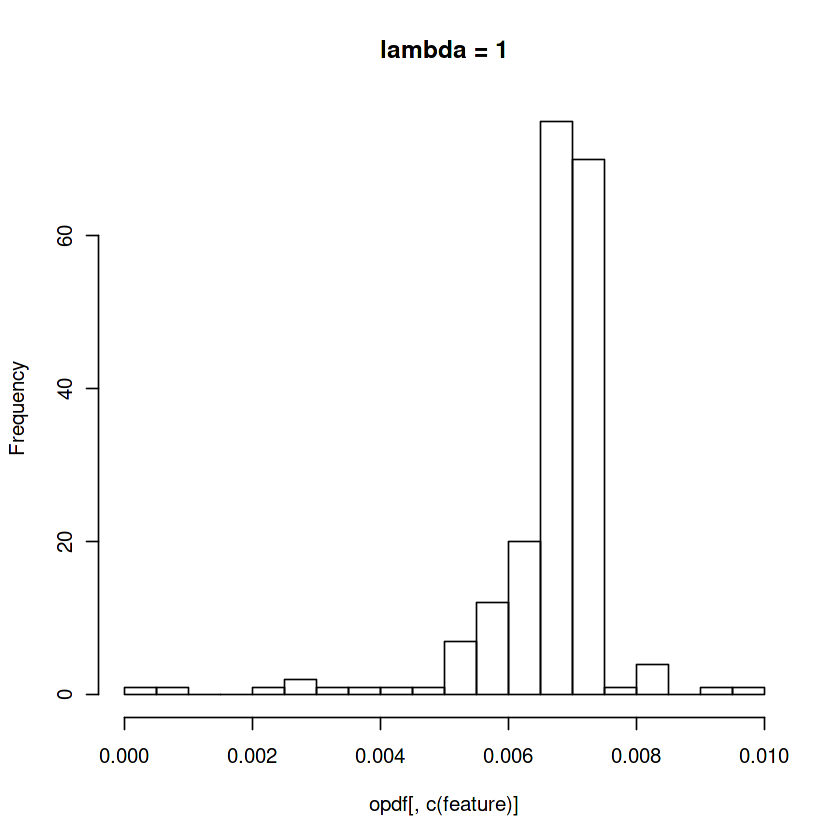

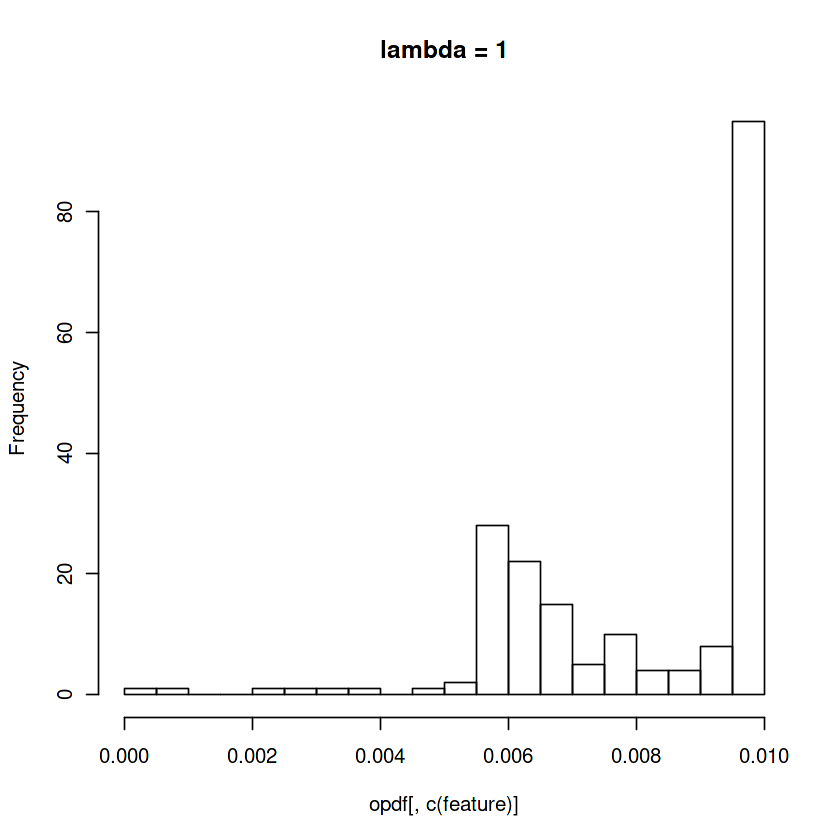

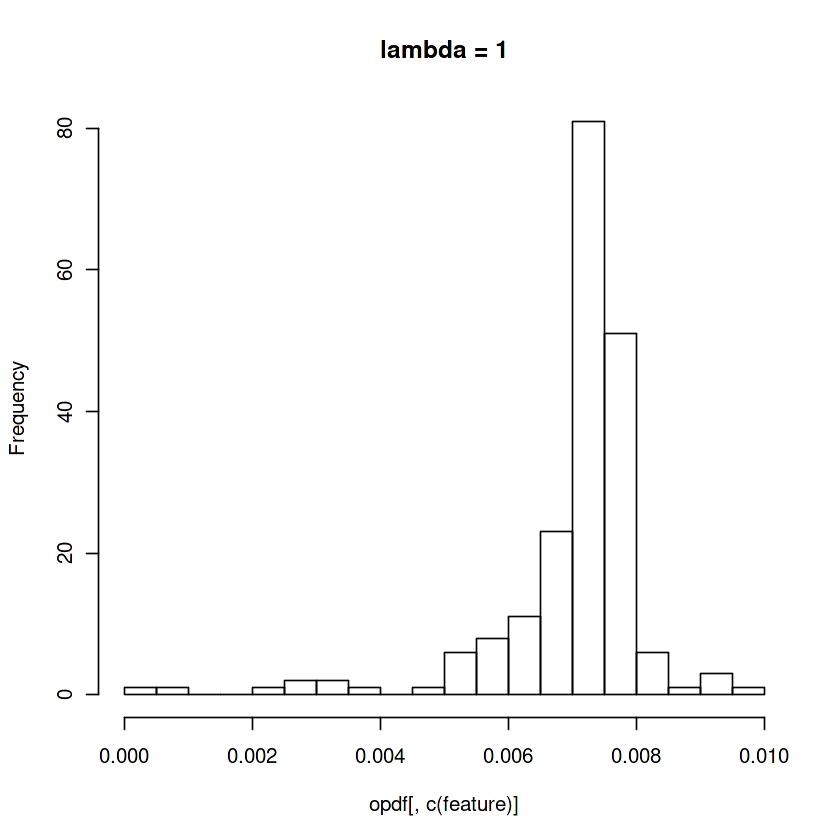

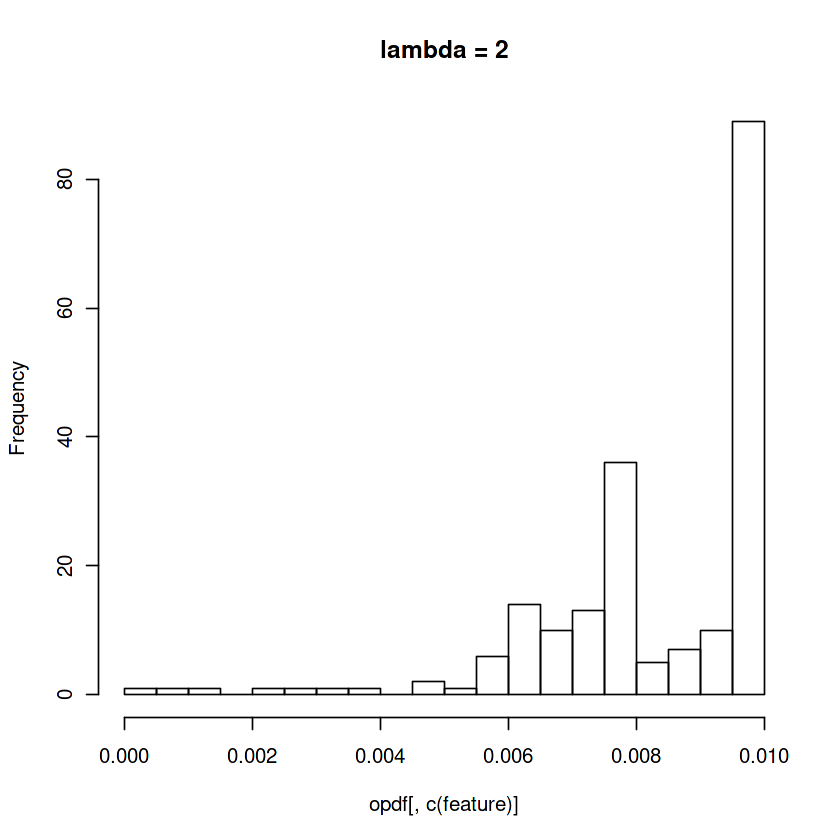

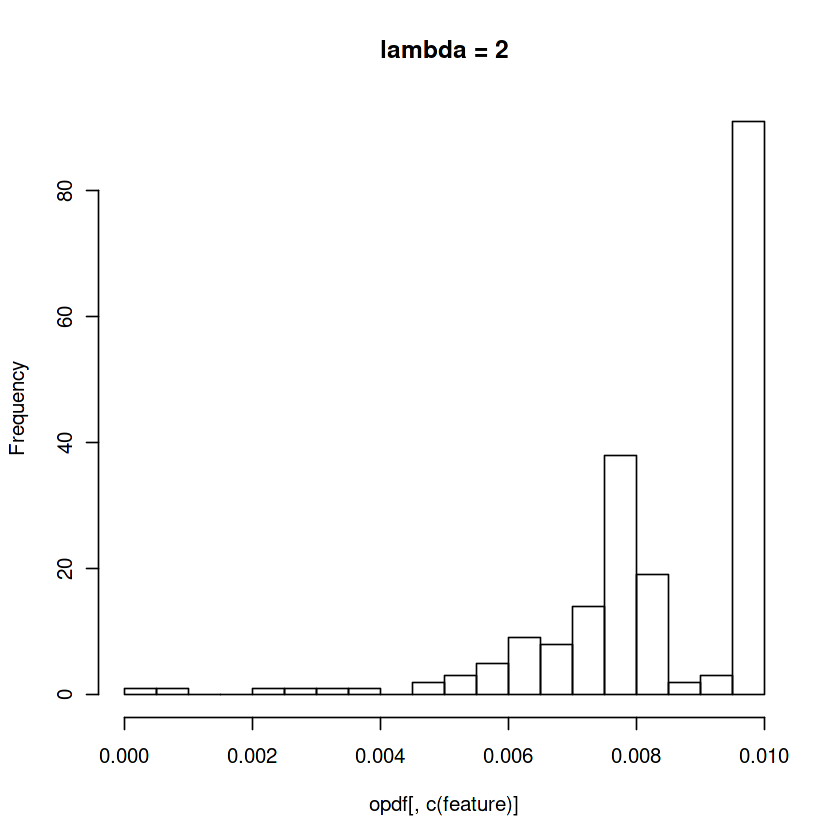

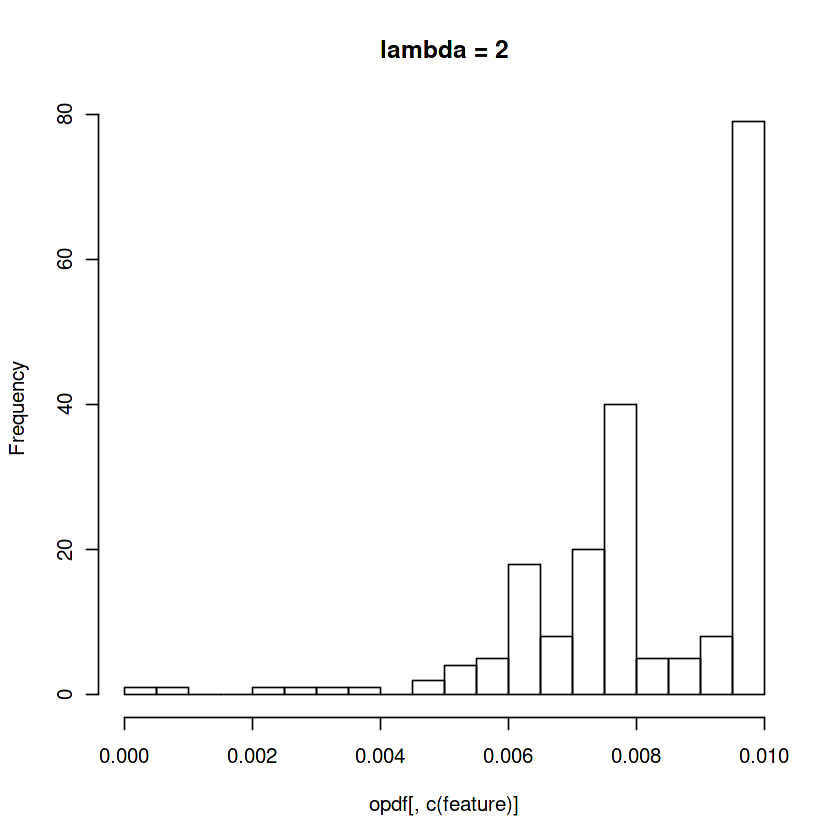

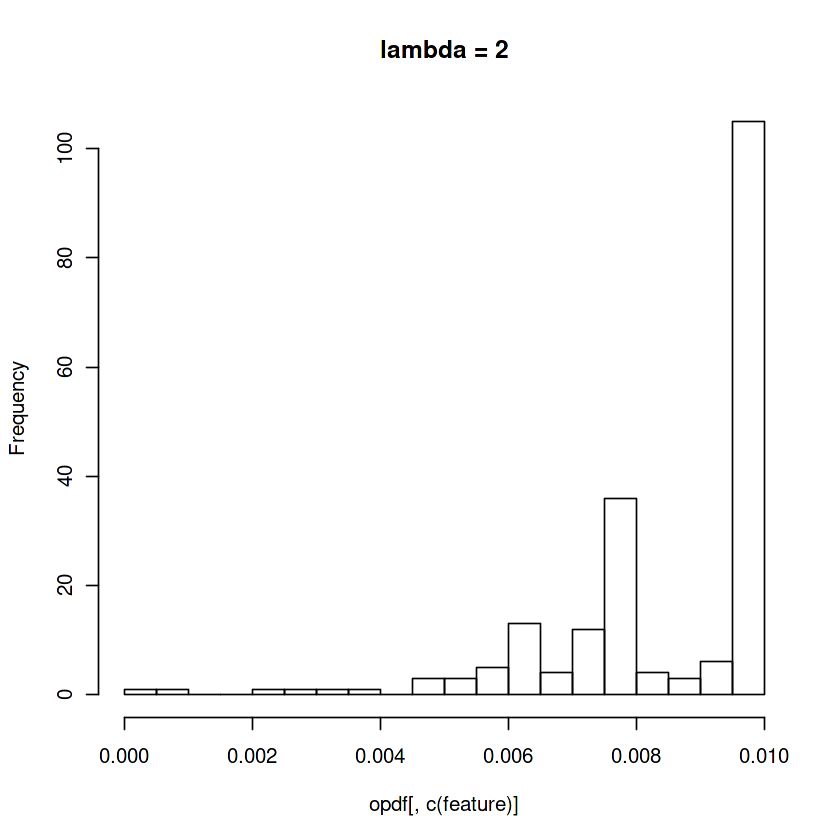

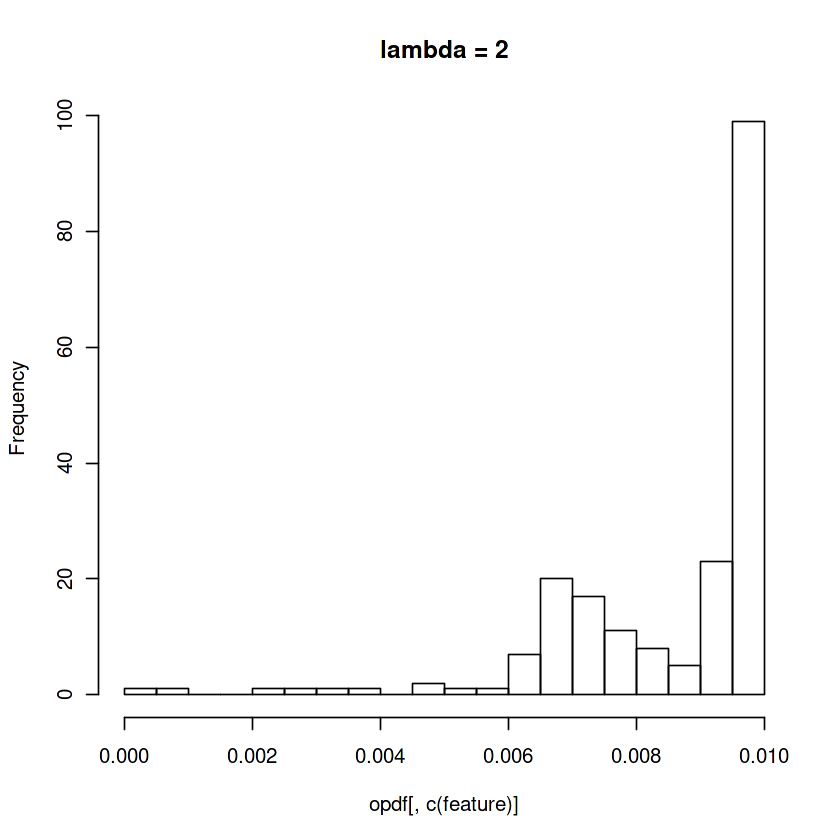

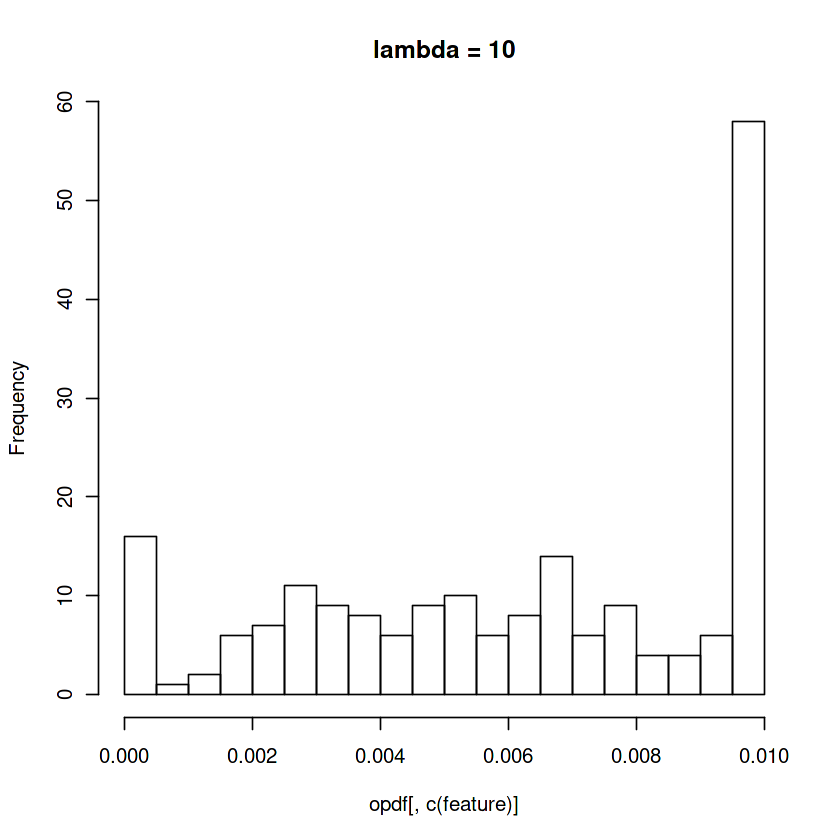

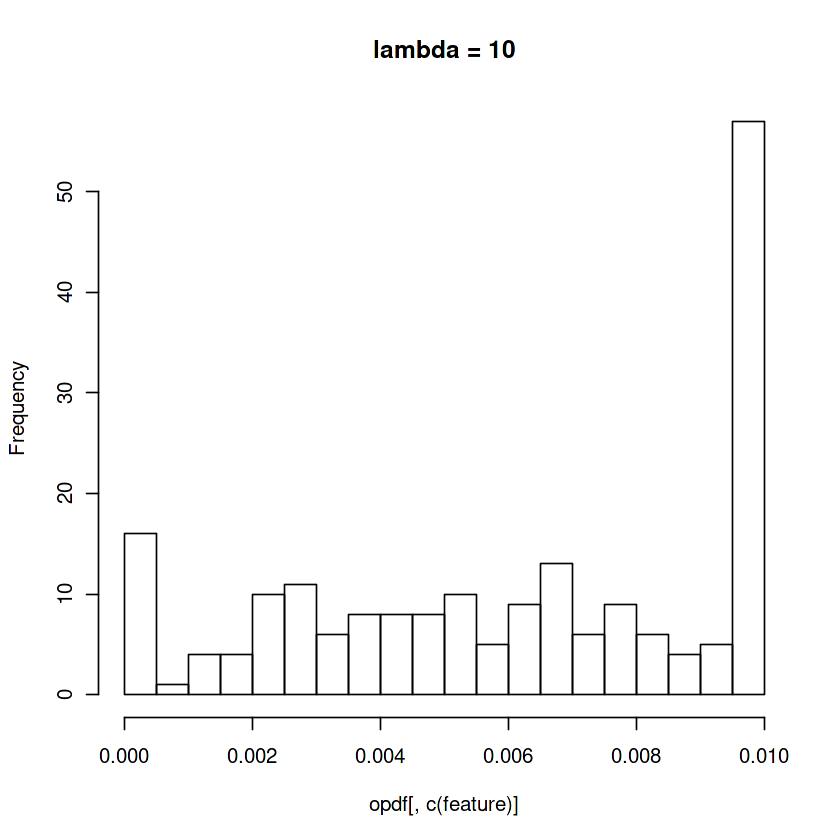

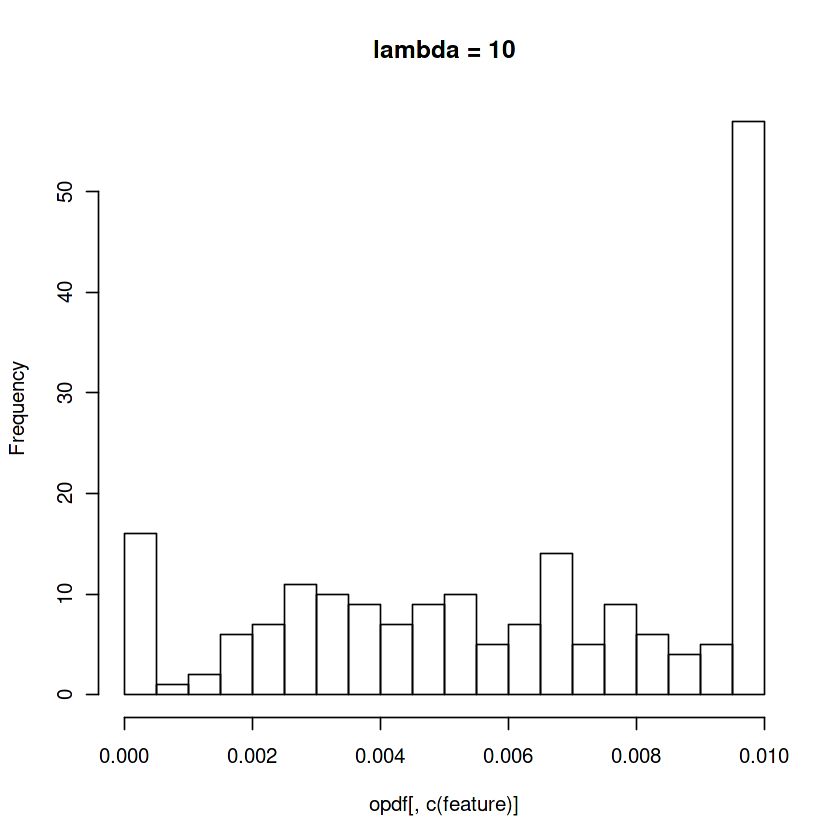

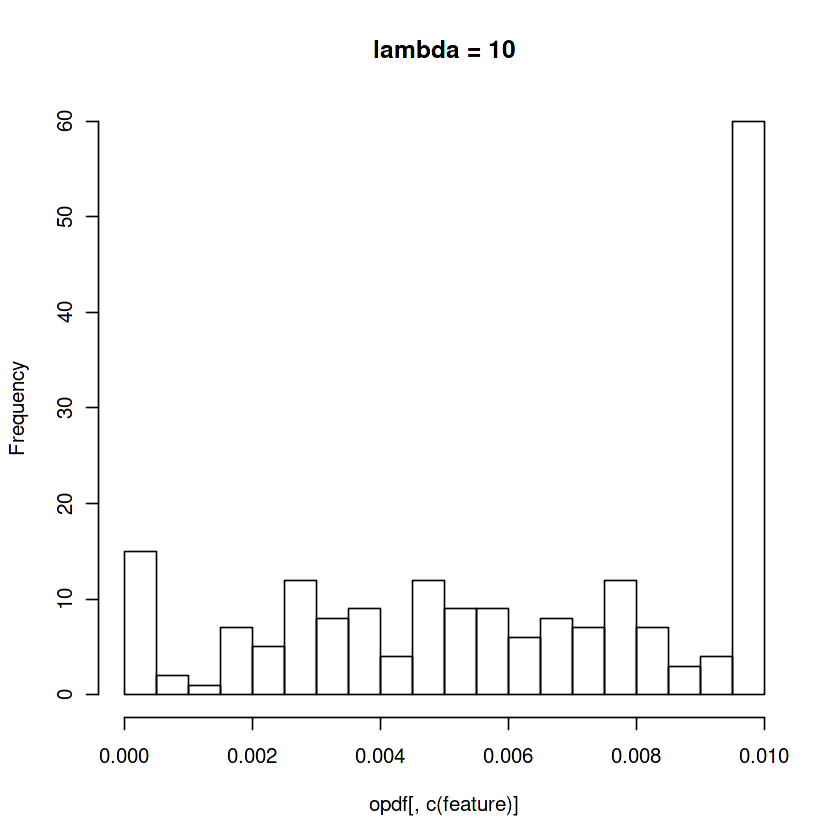

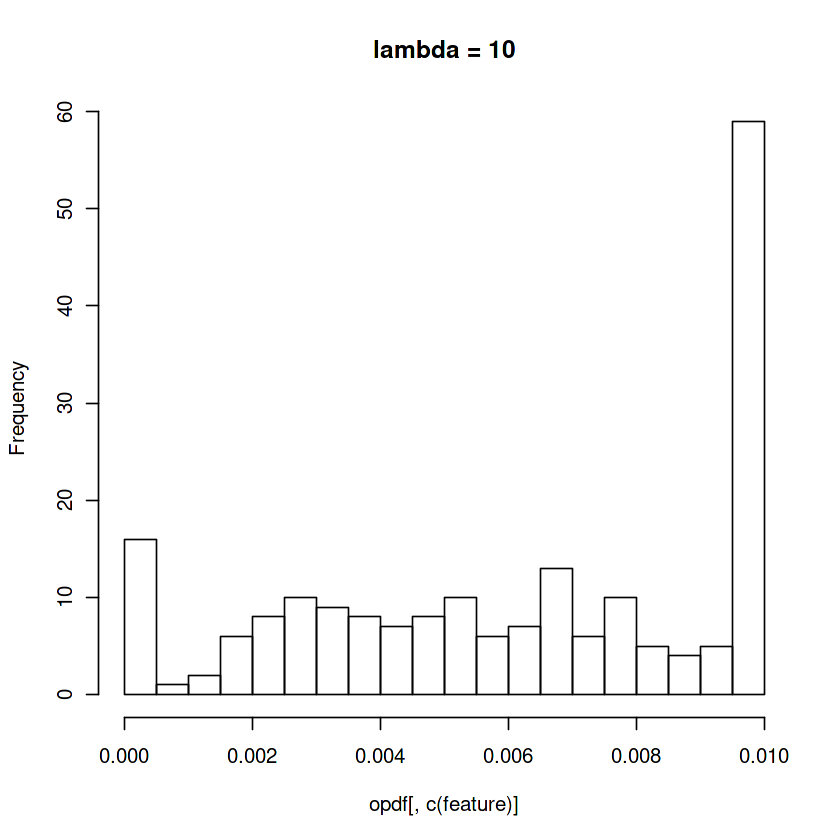

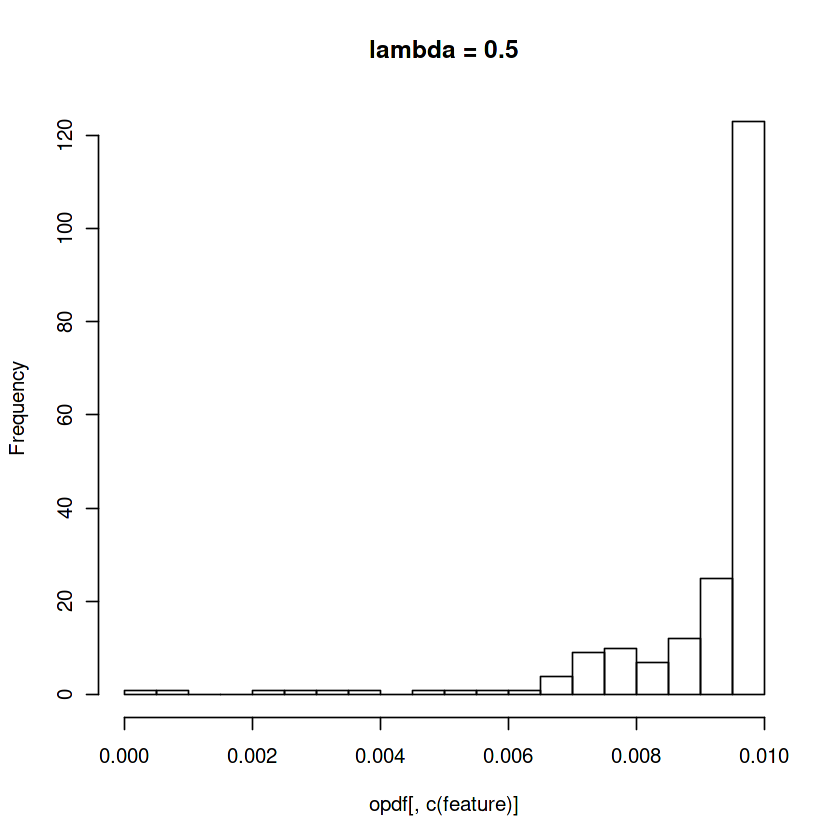

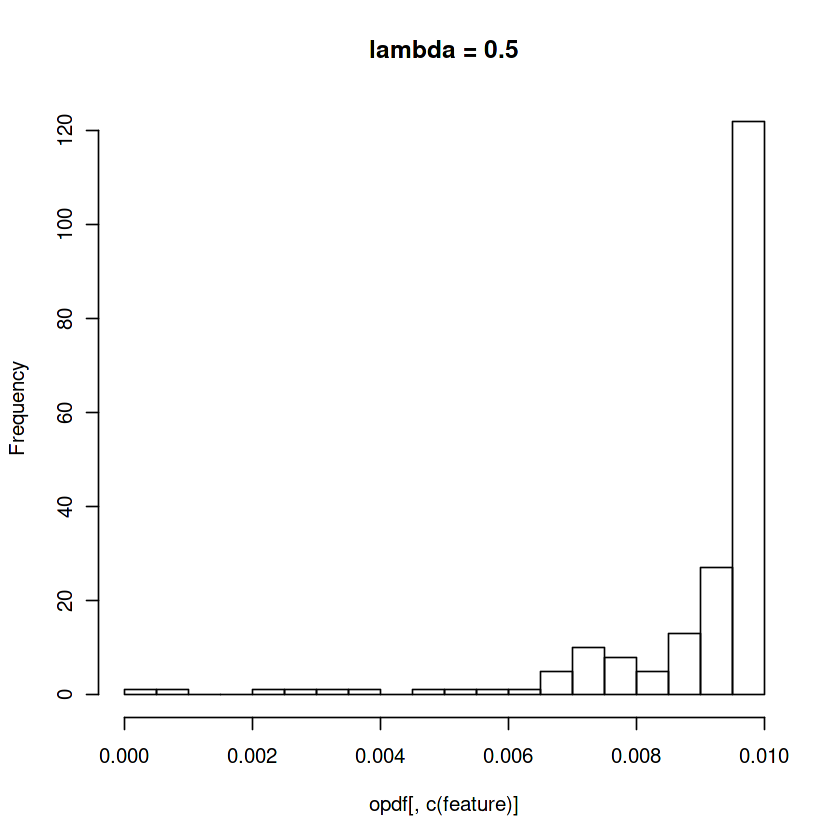

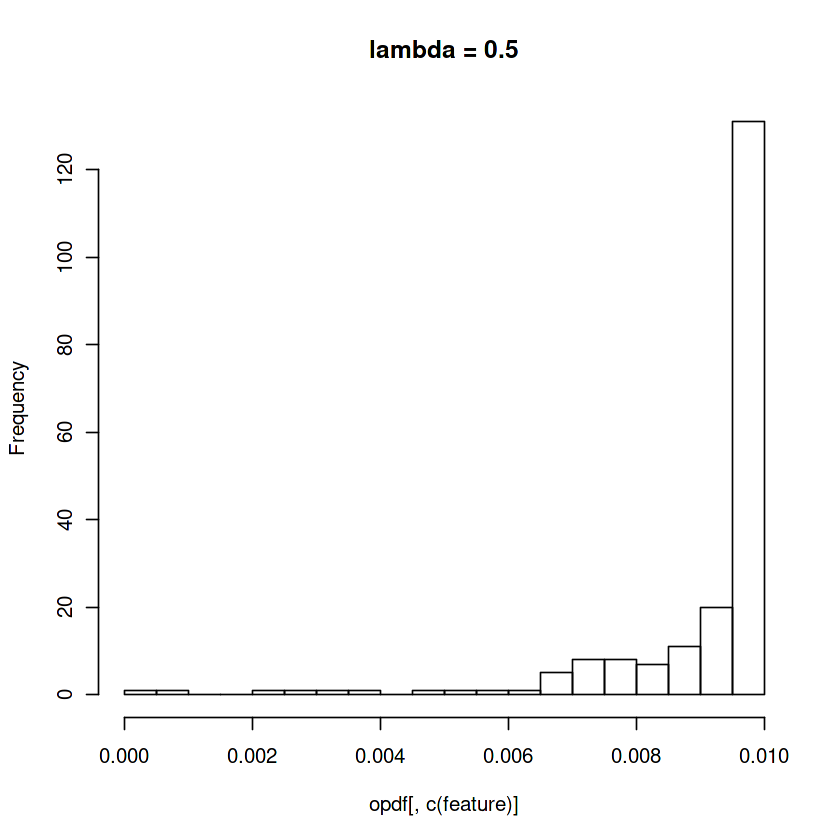

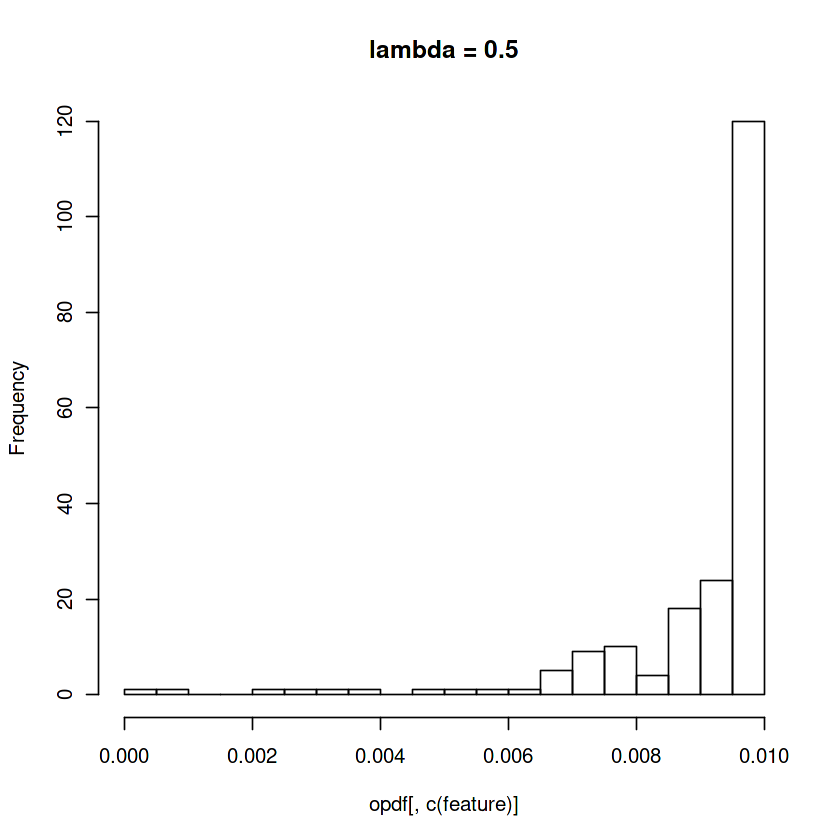

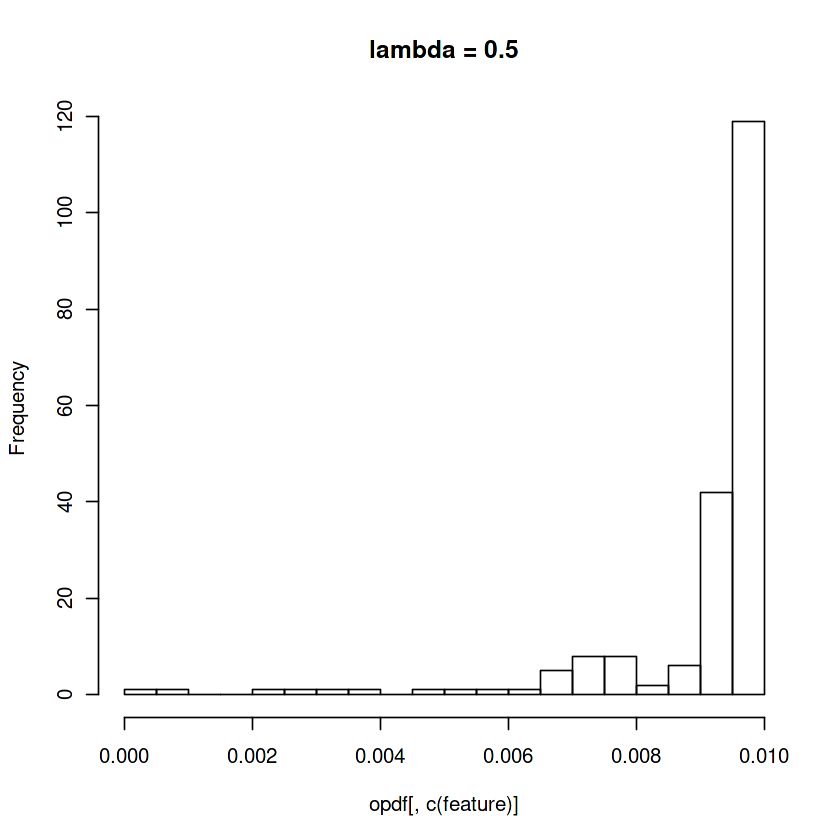

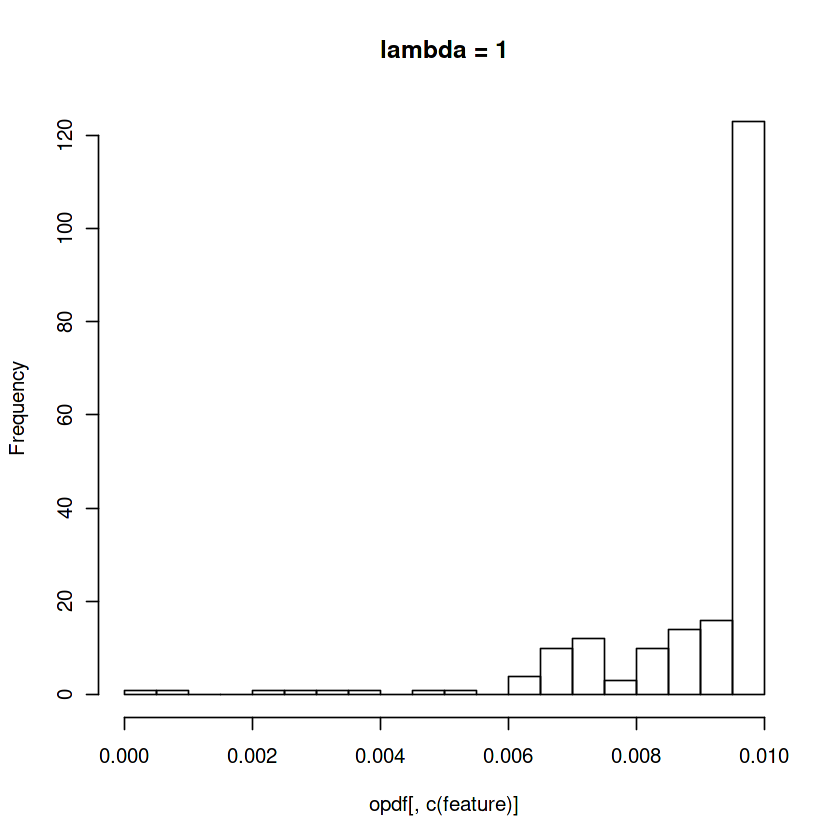

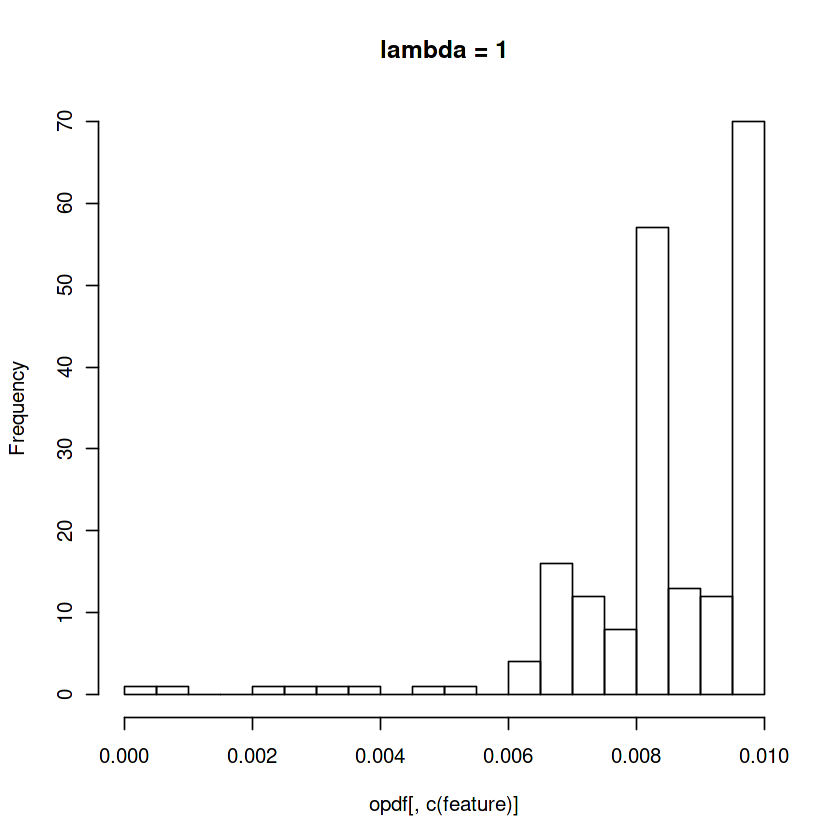

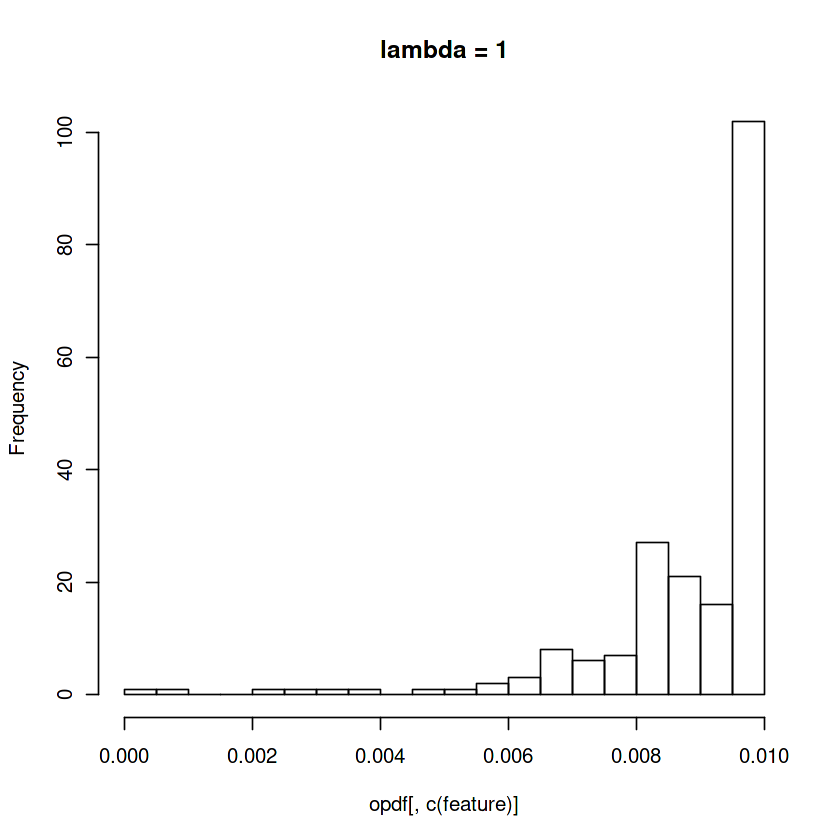

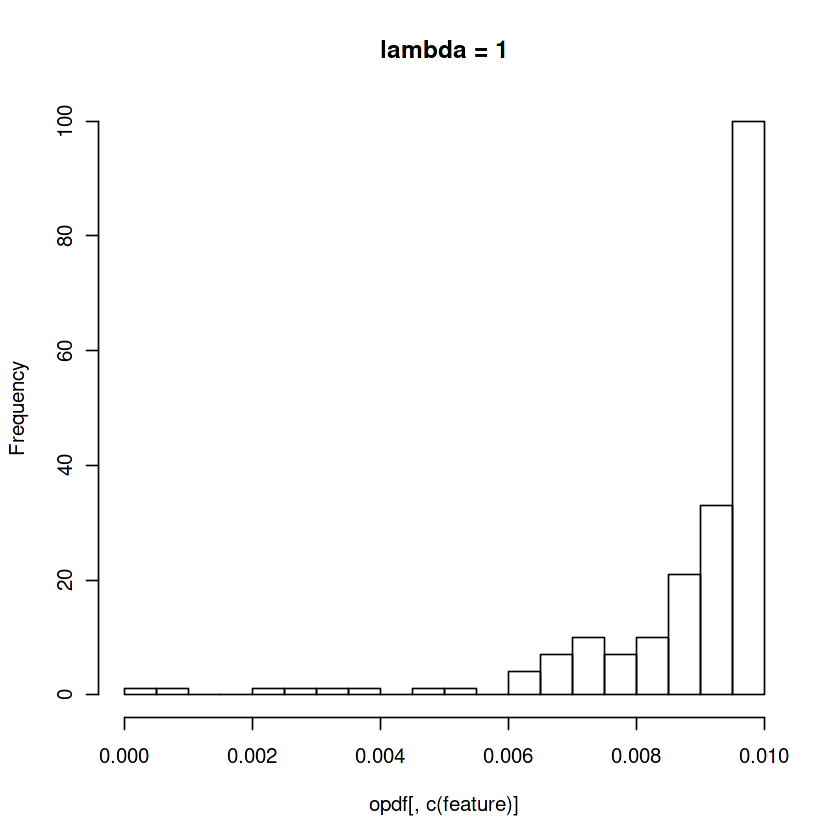

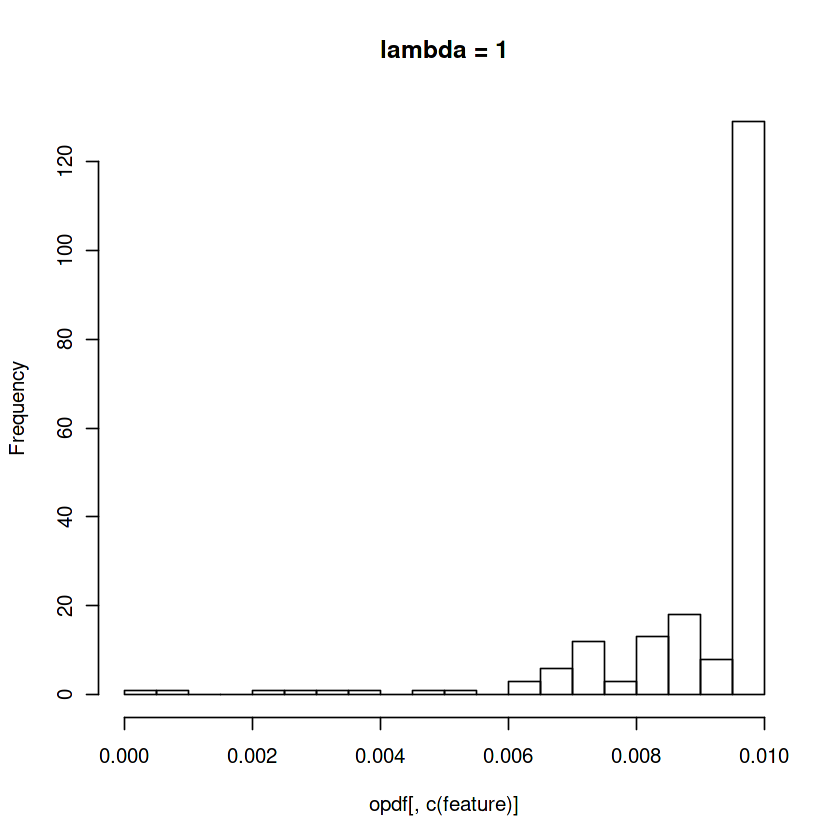

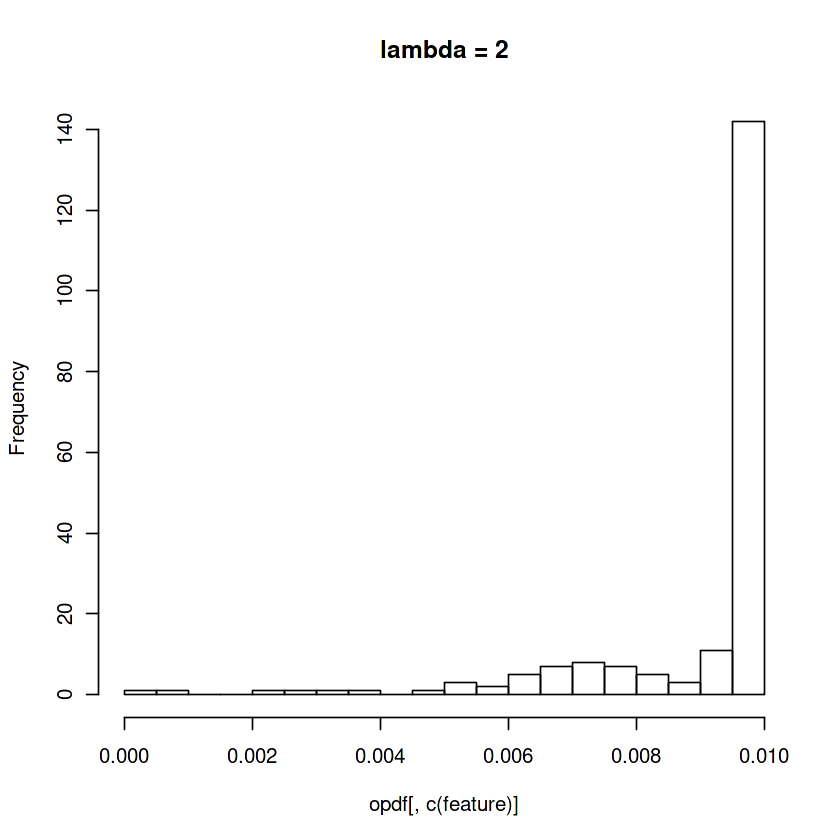

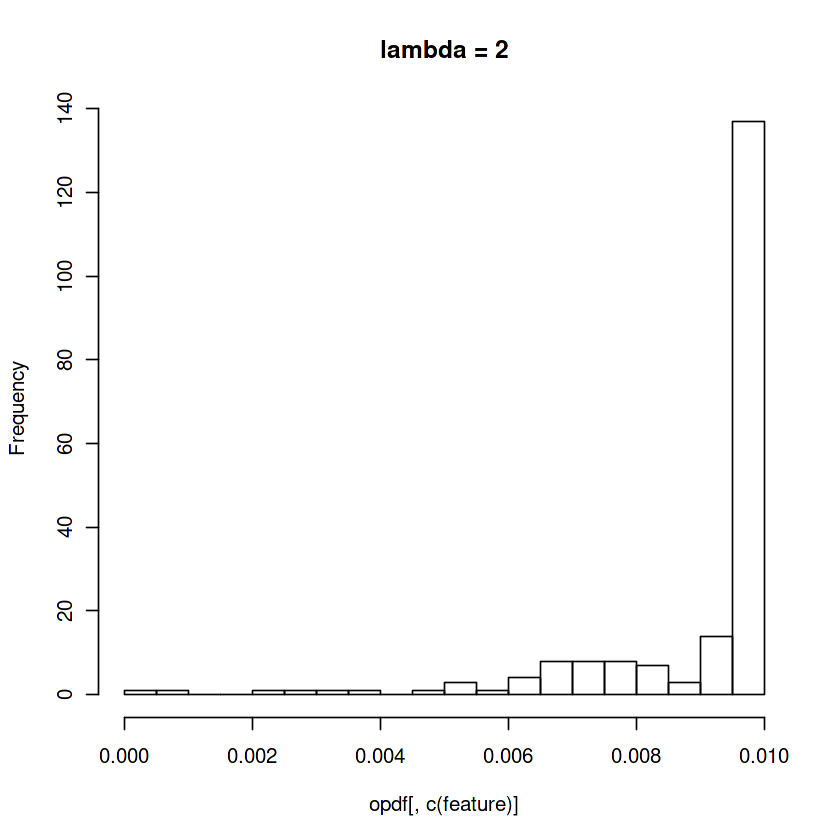

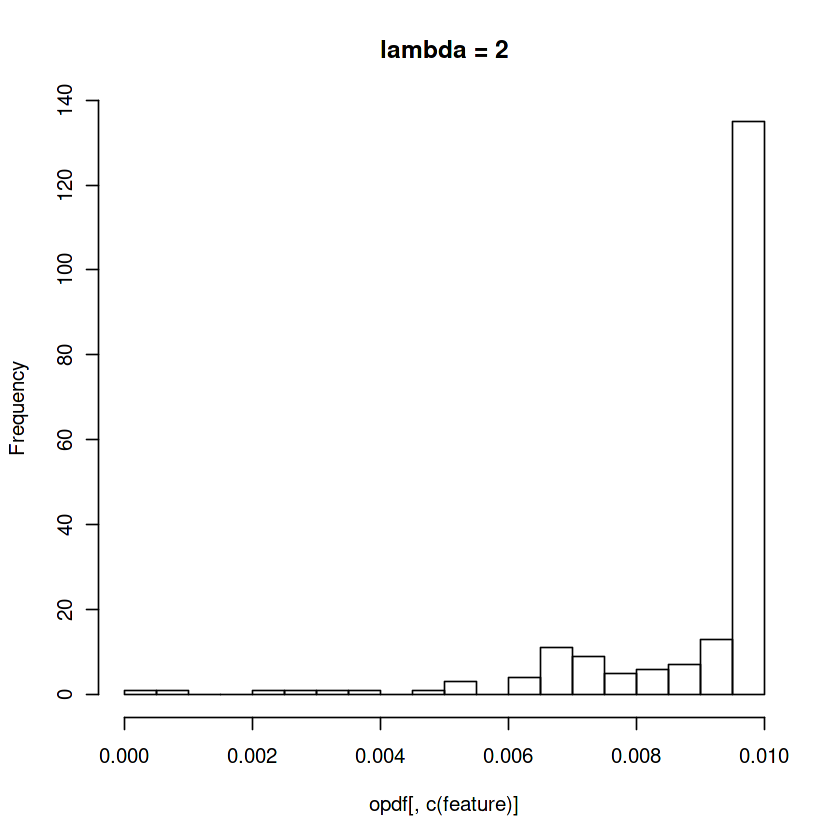

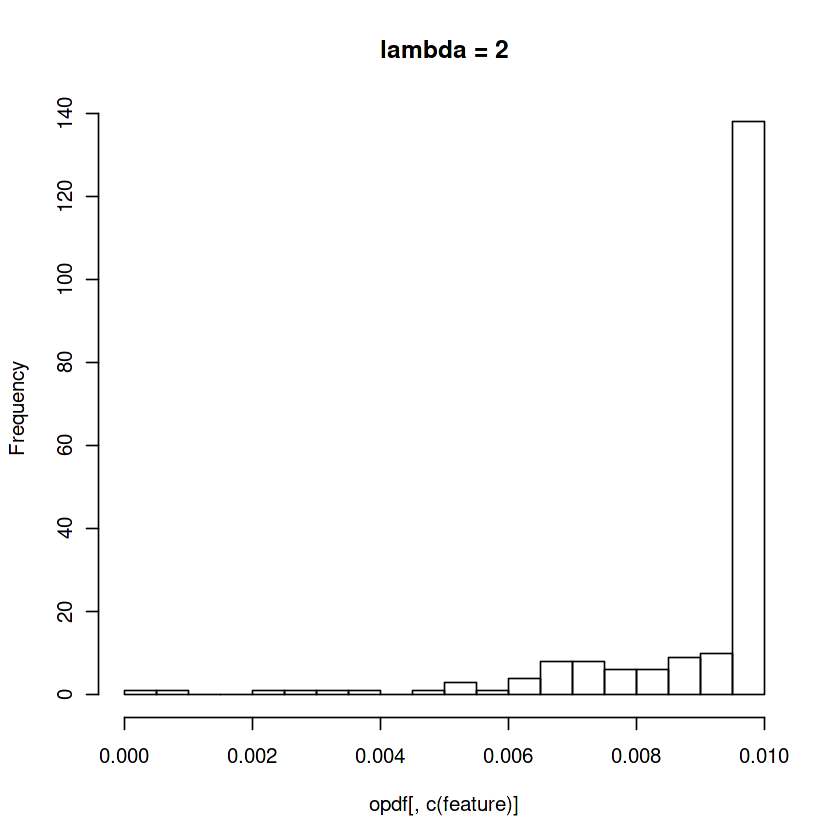

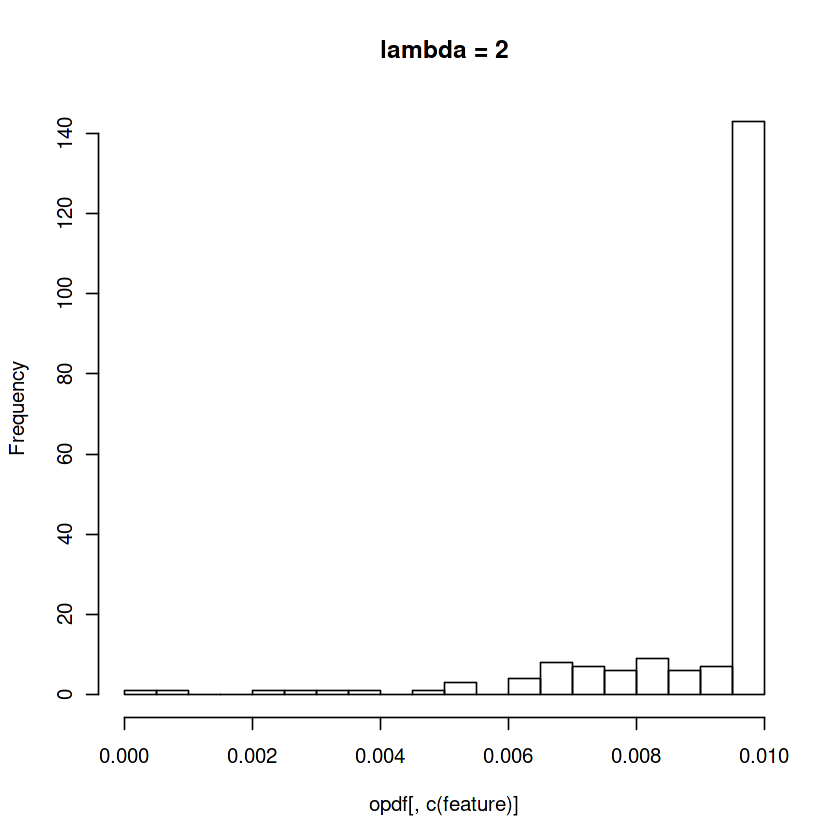

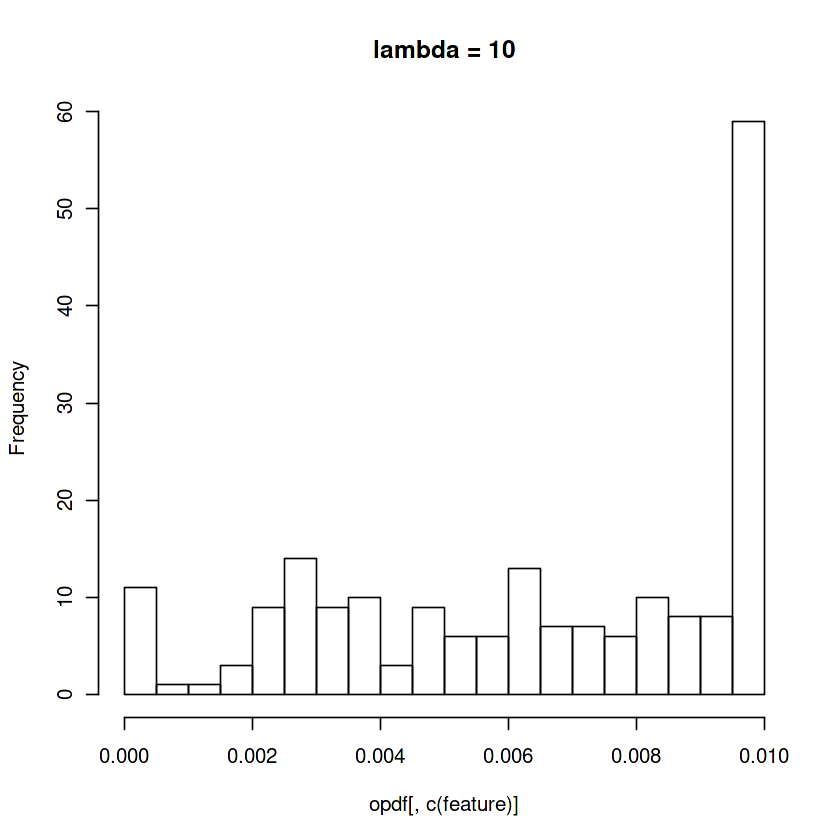

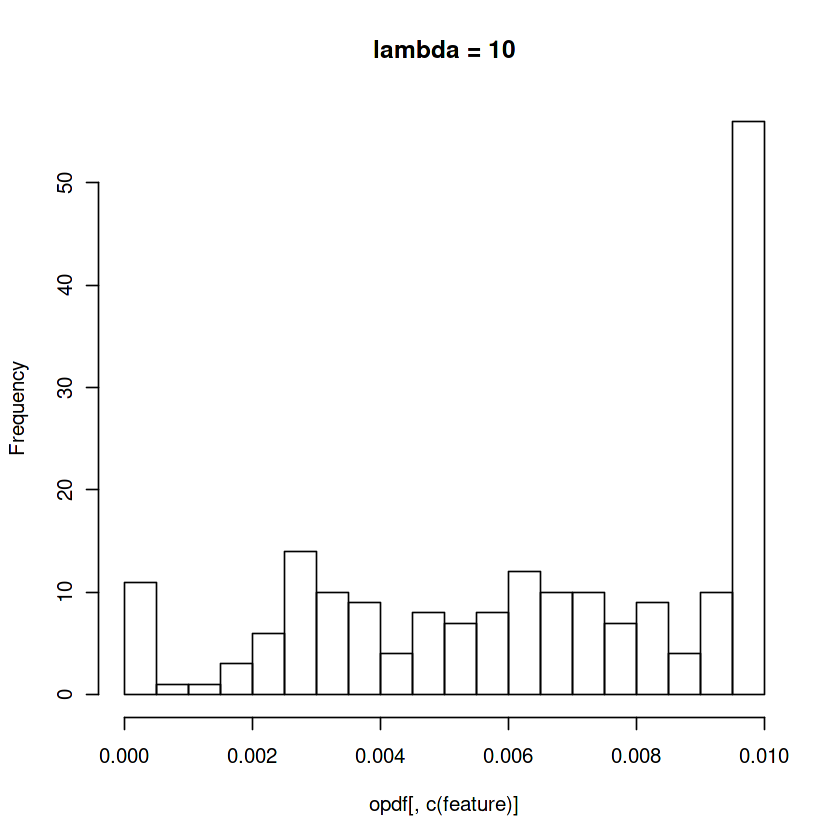

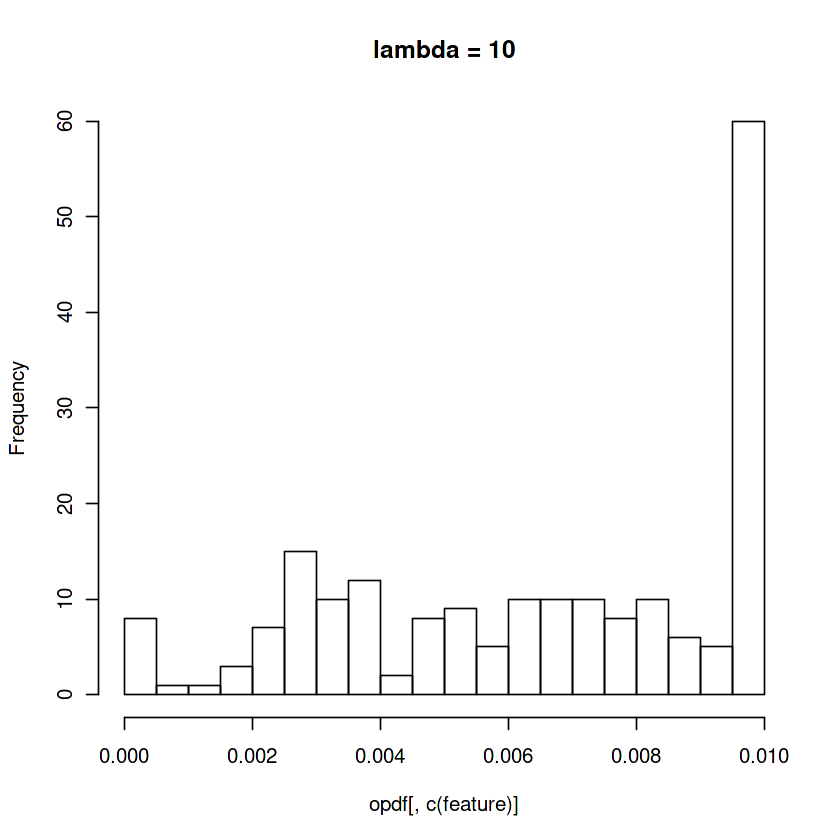

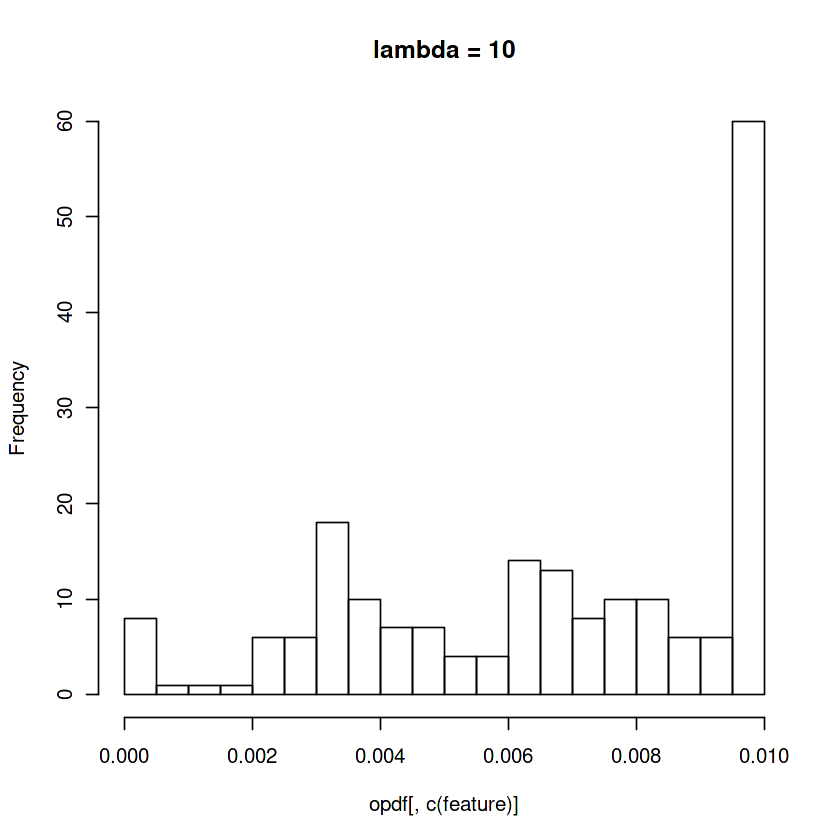

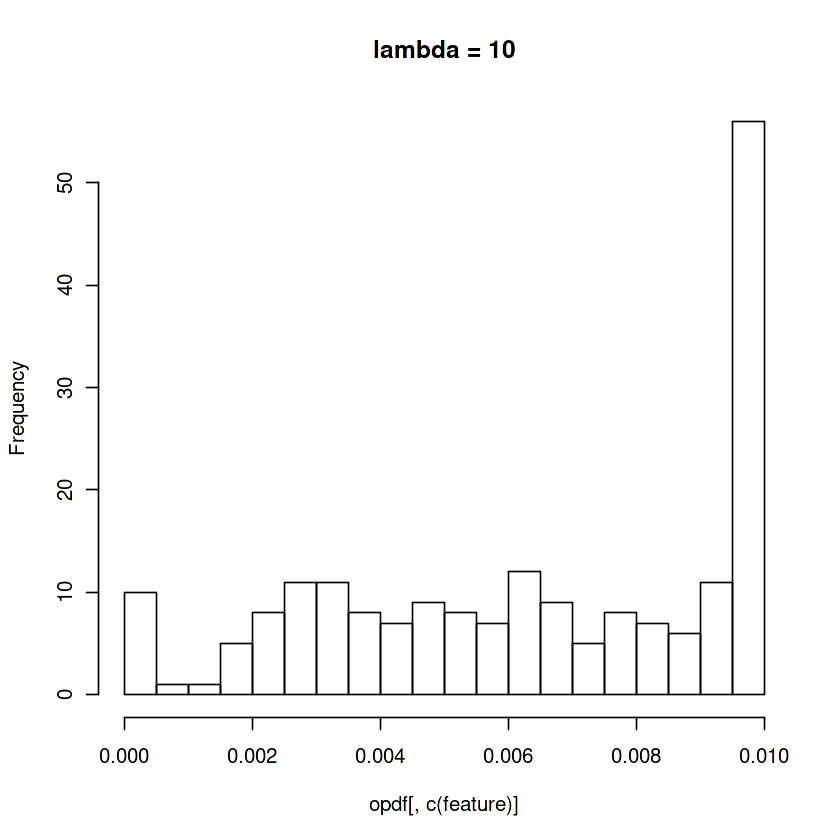

In [180]:
res = lapply(c("blood-transfusion-service-center", "kc1", "numerai28.6", "phoneme", "sylvine"), function(data) {
    compute_width_ci(data, c(0.5, 1, 2, 10), breaks = 20, "learning_rate")
})

In [181]:
res_mod = do.call(rbind, res)
res_mod = setDT(res_mod)
res_mod$md = as.numeric(res_mod$md)
res_mod$kld = as.numeric(res_mod$kld)

In [182]:
res_mod_sum = res_mod[, .("mean_md" = mean(md), "mean_kld" = mean(kld)), by = c("lambda", "dataset")]

In [183]:
res_mod_sum

lambda dataset                          mean_md     mean_kld 
1  0.5    blood-transfusion-service-center 0.137354571 0.7417508
2  1      blood-transfusion-service-center 0.139598795 0.8548044
3  2      blood-transfusion-service-center 0.123801340 0.8326584
4  10     blood-transfusion-service-center 0.143868995 0.4465260
5  0.5    kc1                              0.007167882 0.9298810
6  1      kc1                              0.006620579 0.4596391
7  2      kc1                              0.005359269 0.3175013
8  10     kc1                              0.005853094 0.1494112
9  0.5    numerai28.6                      0.217615985 0.5705312
10 1      numerai28.6                      0.217825185 0.3259442
11 2      numerai28.6                      0.217484728 0.3284676
12 10     numerai28.6                      0.217728866 0.4739491
13 0.5    phoneme                          0.013444011 1.1230664
14 1      phoneme                          0.012643574 0.8392815
15 2      phoneme                          0.012426235 0.8084575
16 10     phoneme                          0.013038209 0.3368229
17 0.5    sylvine                          0.103921755 1.0600151
18 1      sylvine                          0.108899547 0.8340120
19 2      sylvine                          0.106763358 0.9360205
20 10     sylvine                          0.107488716 0.3825536

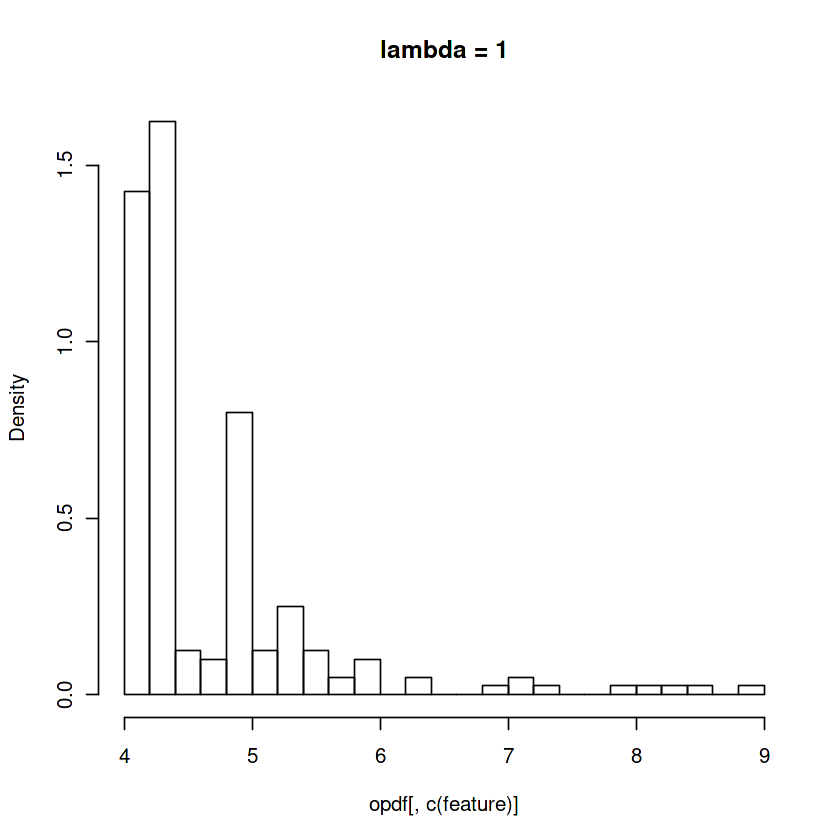

In [157]:
i = 1
breaks = 20
run = runs$result[[i]]
opdf = as.data.frame(run$opt.path)

model = run$models
model = model[[length(model)]] 

pme = marginal_effect_sd_over_mean(model = model, feature = feature, data = df, grid.size = 20, method = "pdp_var_gp")

md = mean(abs(me$mean - pme$mean))
neg_loglik = sum(unlist(lapply(seq_row(pme), function(i) {
    dnorm(me[i, ]$mean, mean = pme[i, ]$mean, sd = pme[i, ]$sd, log = FALSE) 
})))
mean_sd = mean(pme$sd)
sd_upper_q90 = quantile(x = pme$sd, probs = 0.9)
sd_lower_q10 = quantile(x = pme$sd, probs = 0.1)

# compute the kullback-leibler distance 
myhist = hist(opdf[, c(feature)], breaks = breaks, main = paste0("lambda = ", lambda), freq = FALSE)
P = myhist$density
Q = rep(1 / length(myhist$density), length(myhist$density))


In [159]:
P = P * 1 / 5

In [161]:
sum(P)

[1] 1

In [154]:
Q = rep(1 / length(myhist$density), length(myhist$density))
Q

[1] 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04
[16] 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04

In [168]:
bla = Q / P
idx = is.finite(Q / P)
els = Q * log(Q / P)
sum(els[is.finite(els)])

[1] 0.6337314

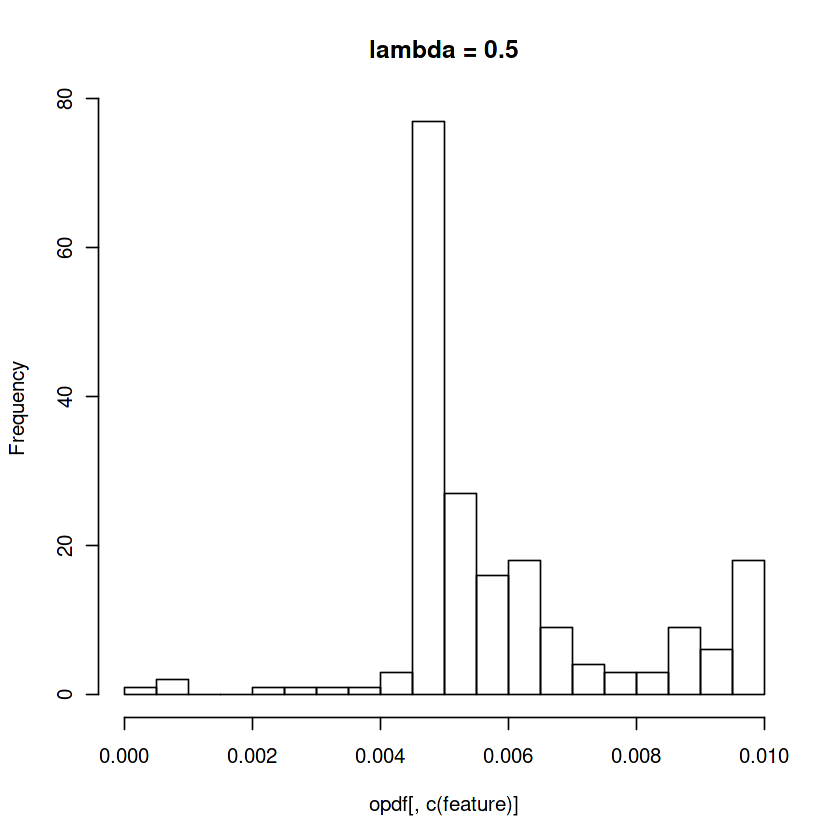

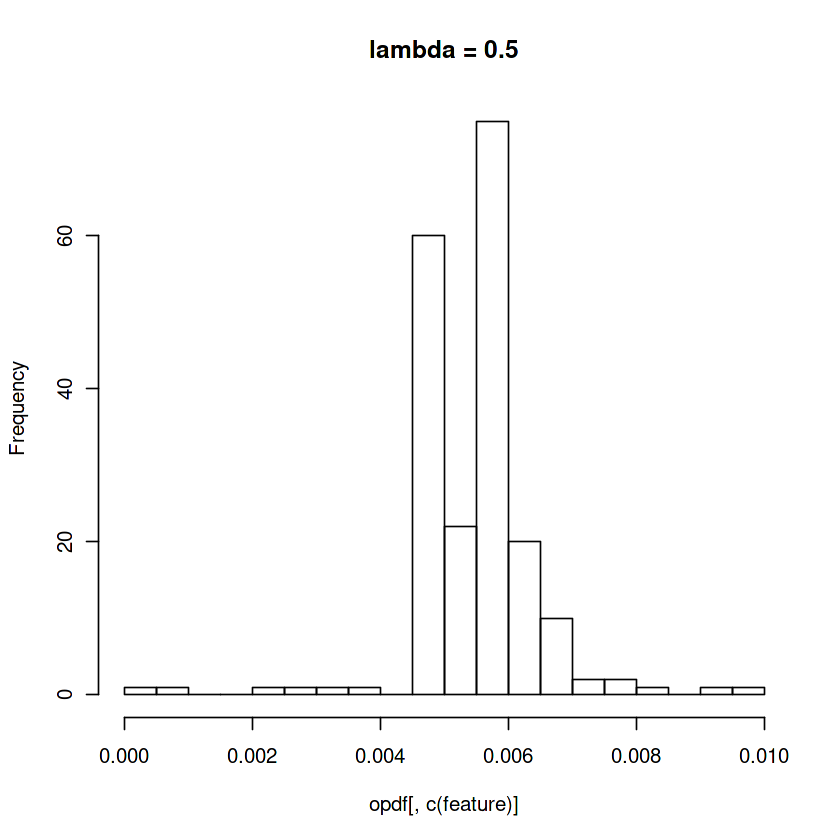

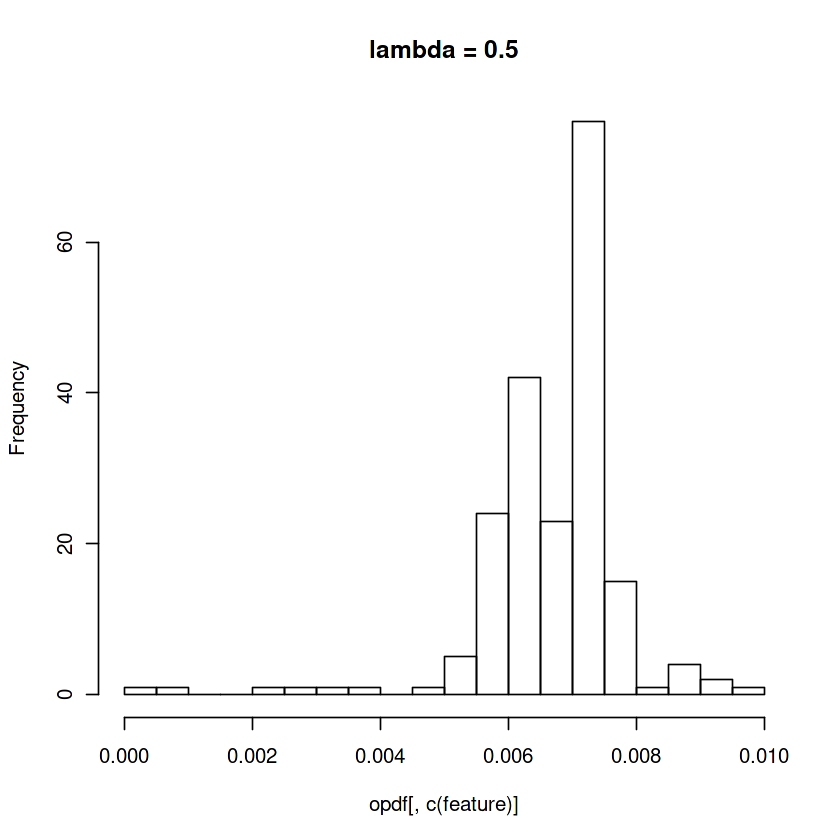

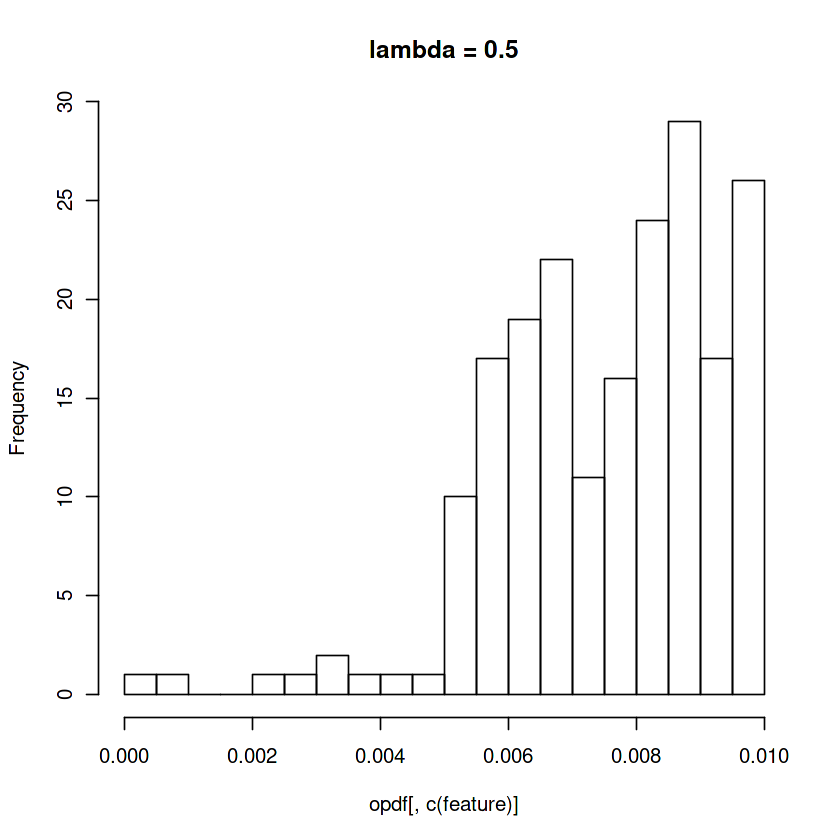

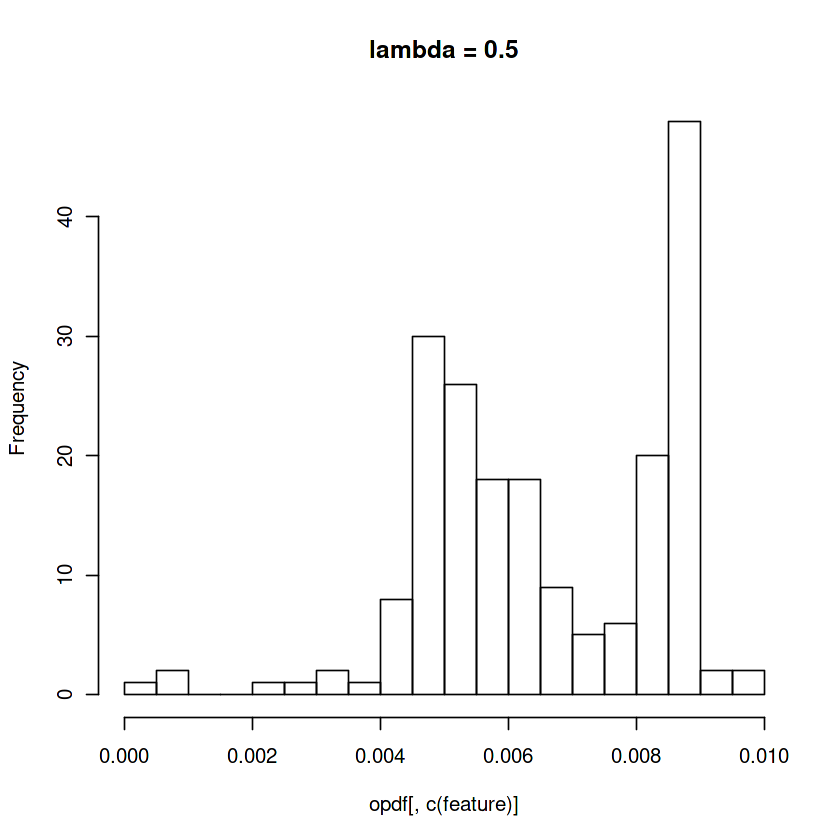

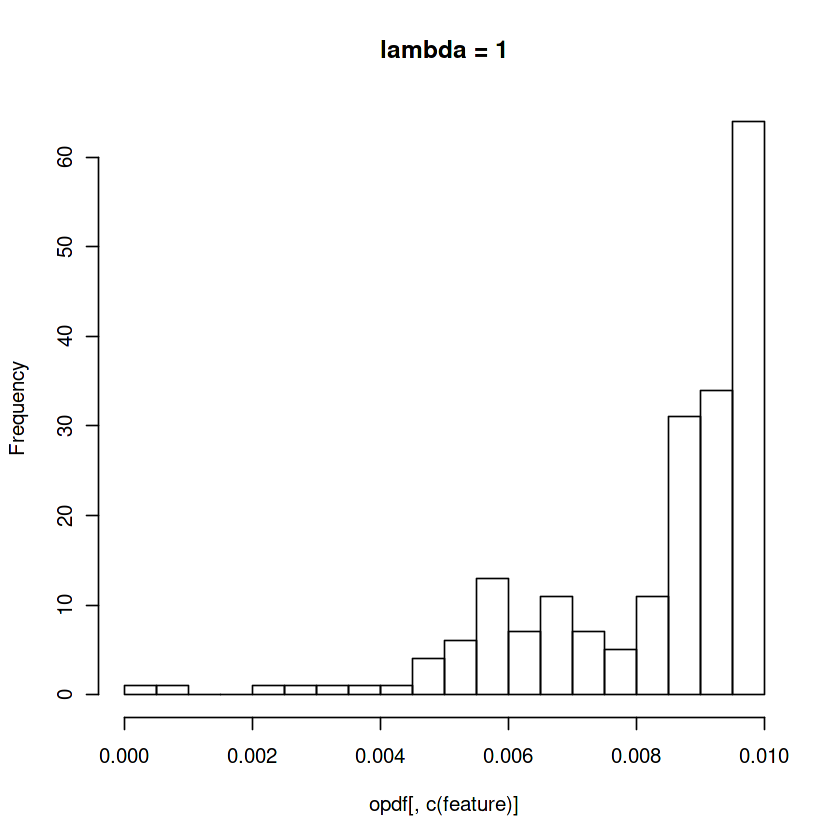

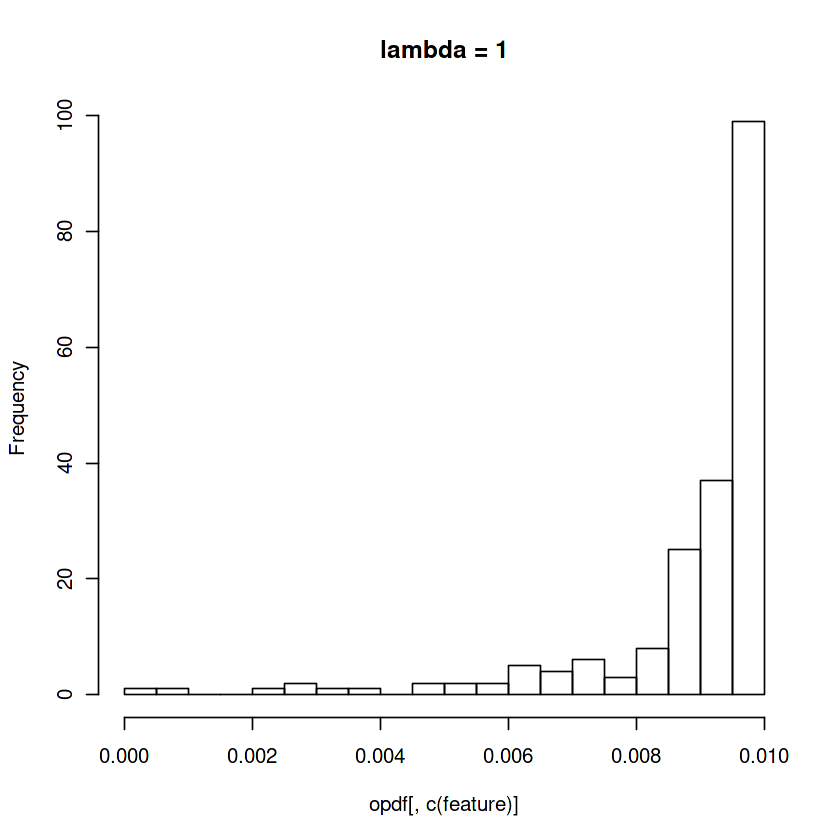

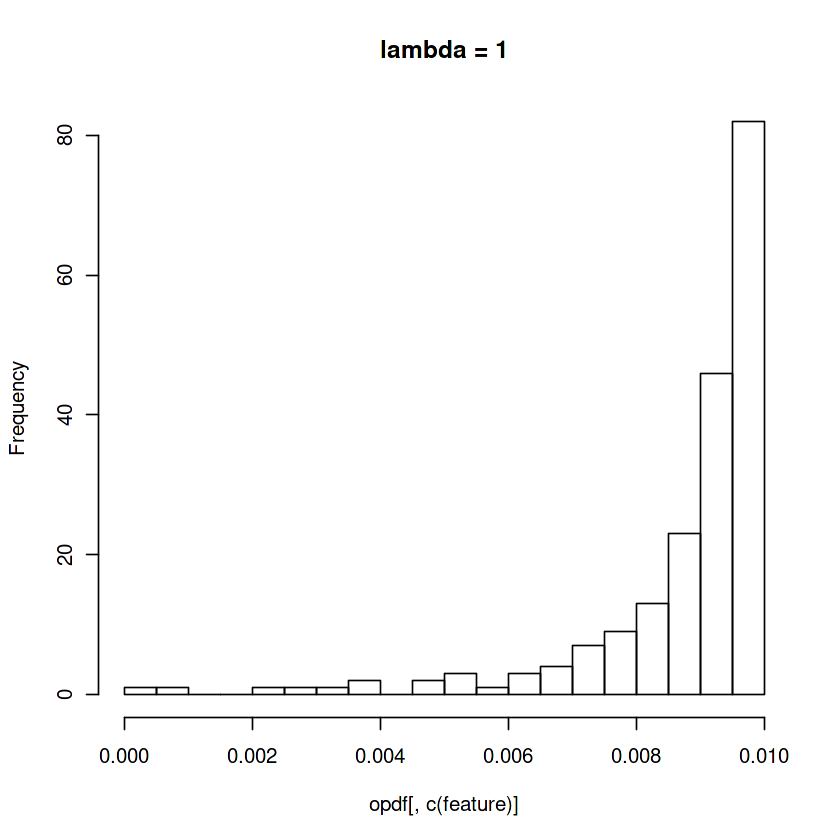

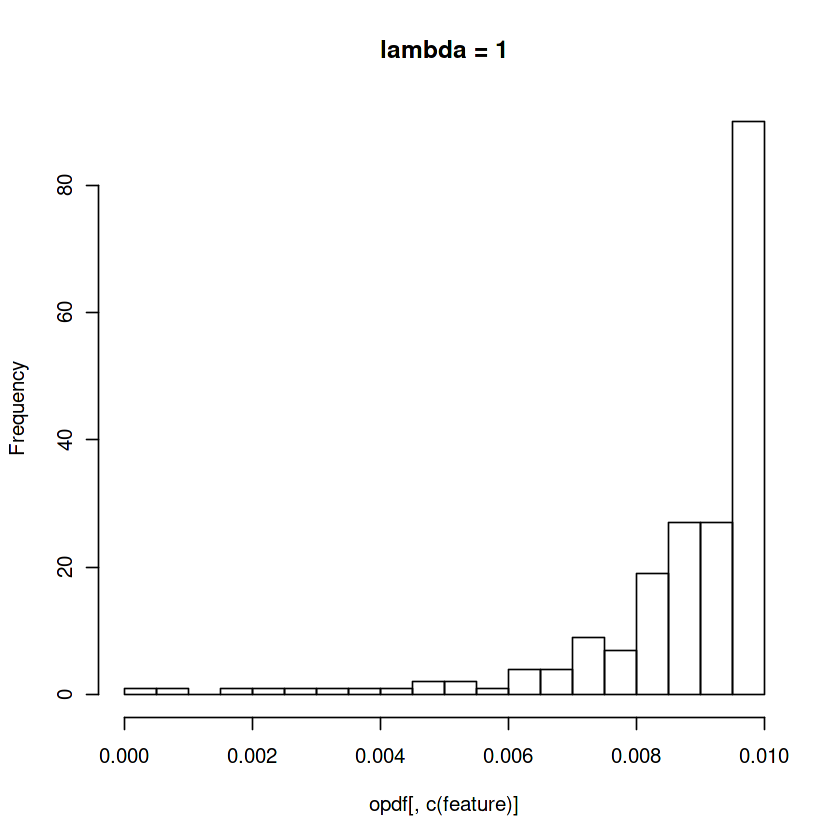

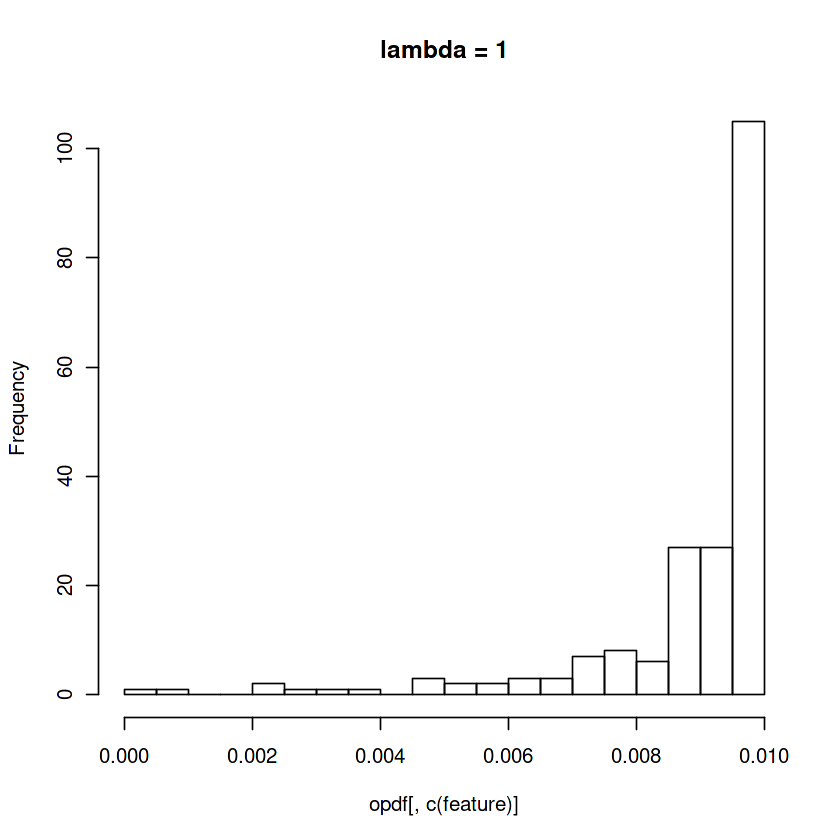

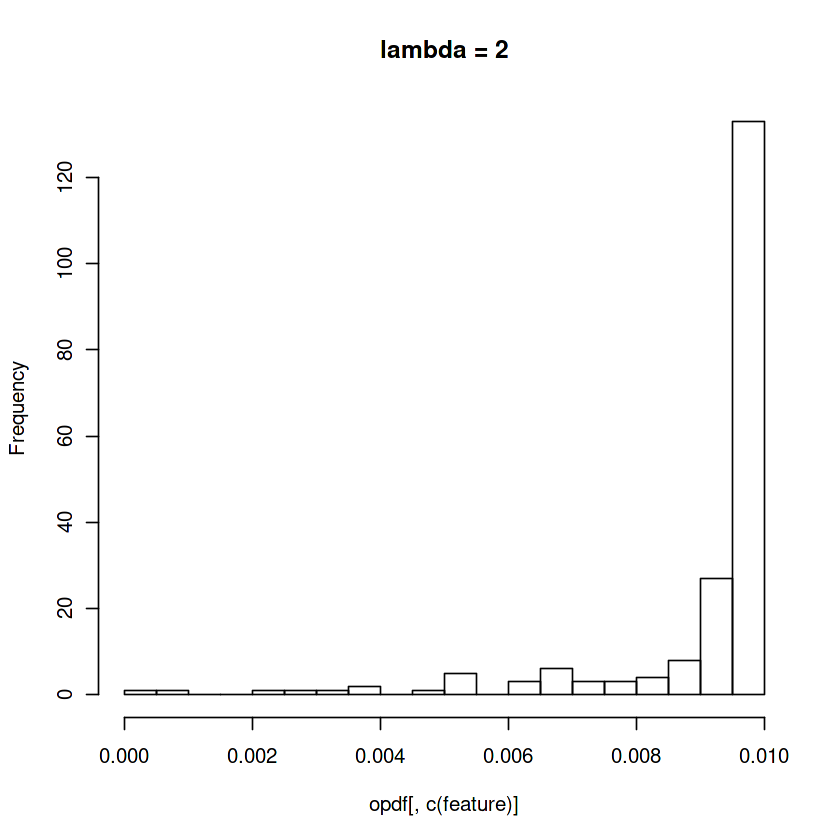

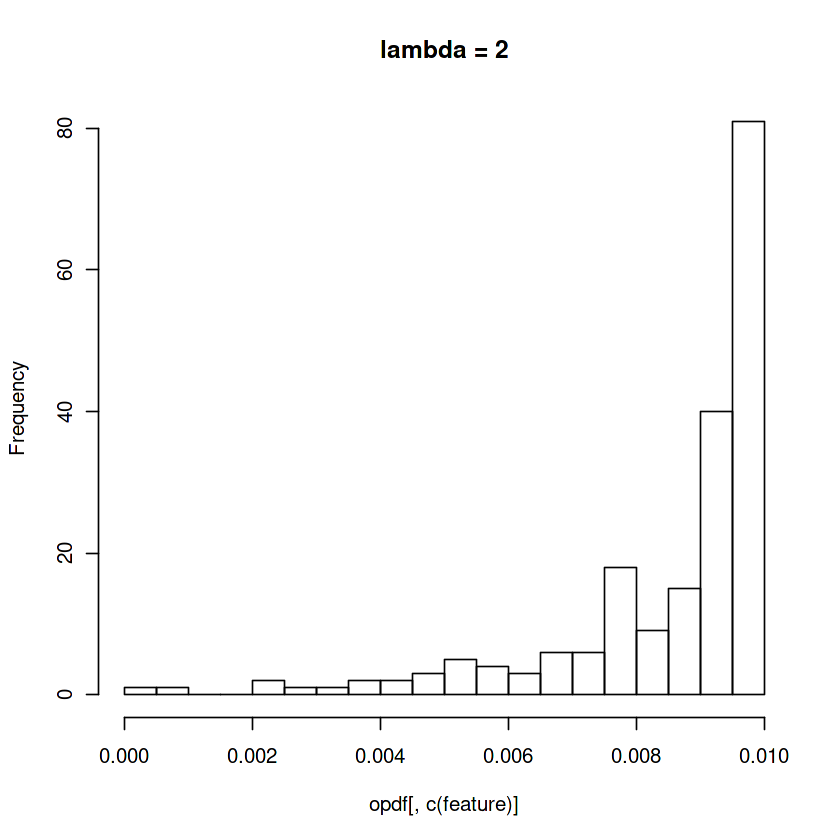

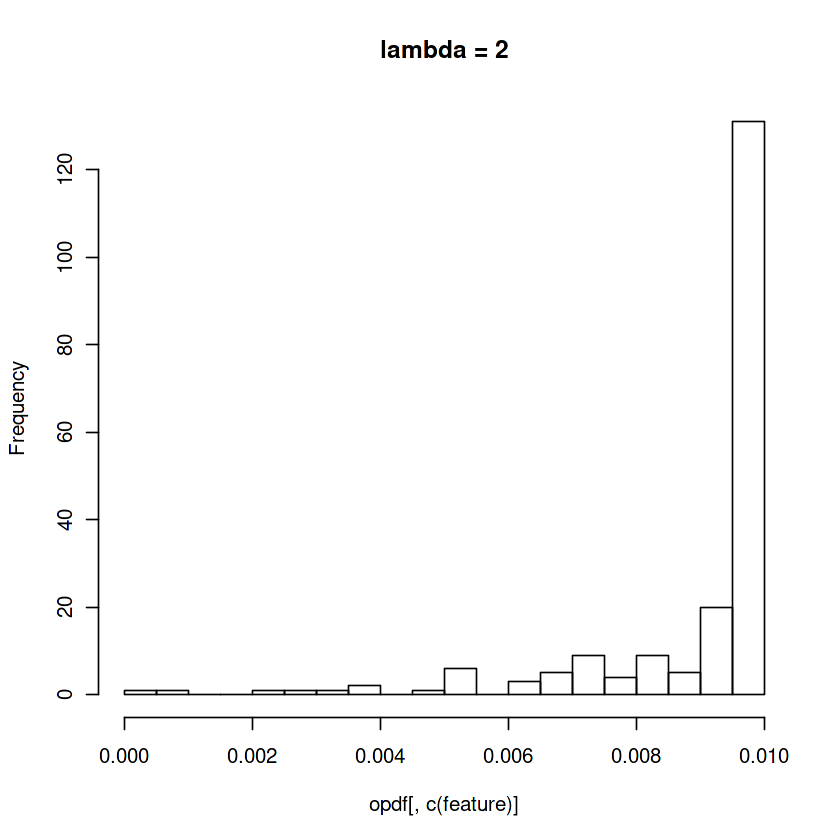

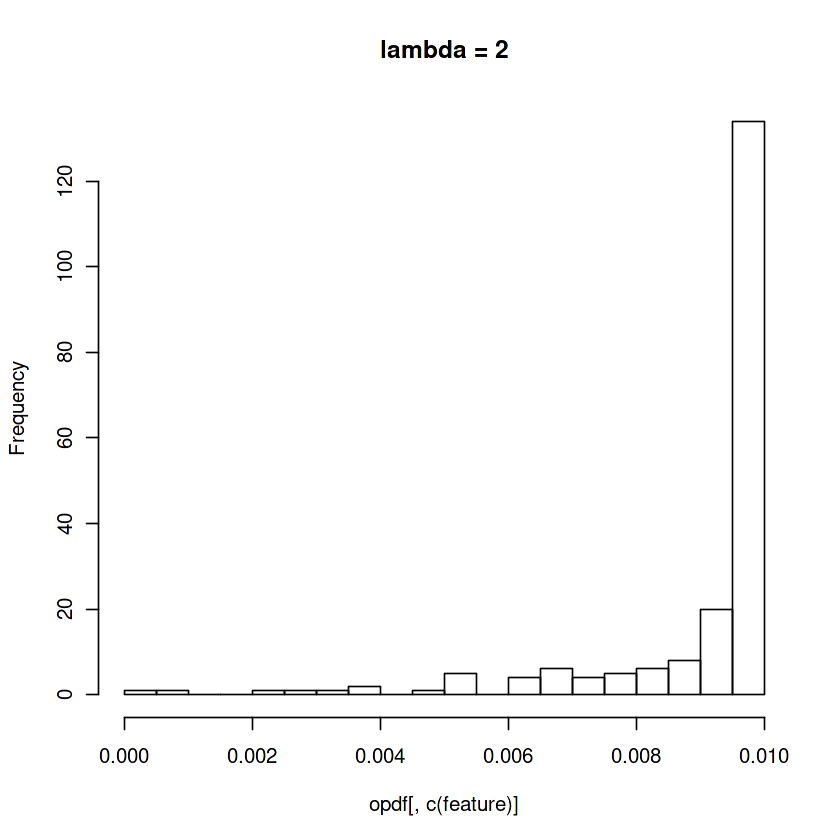

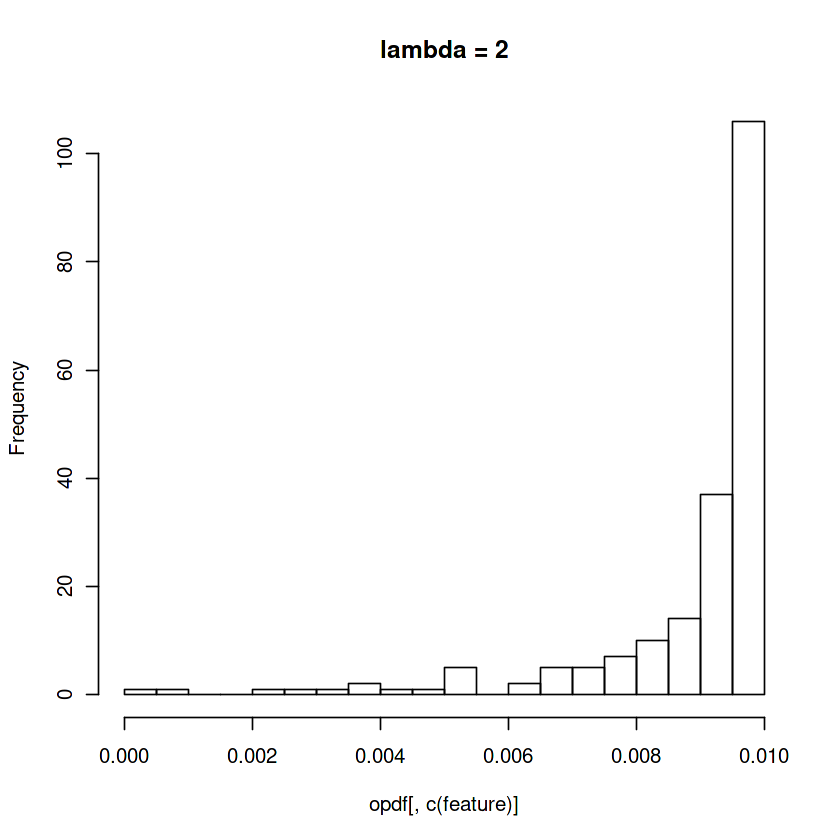

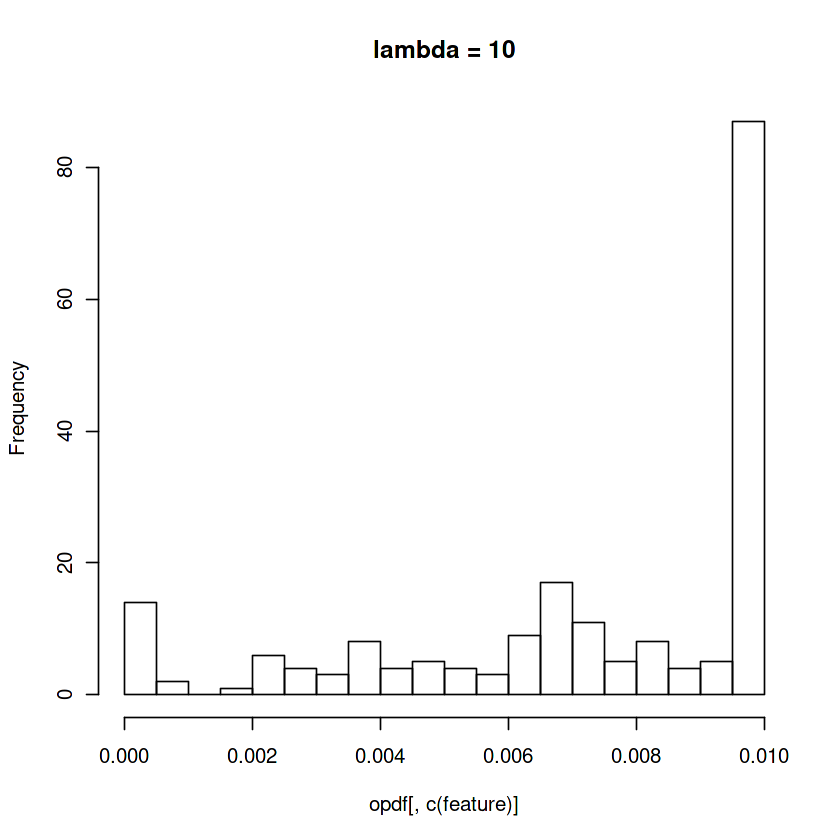

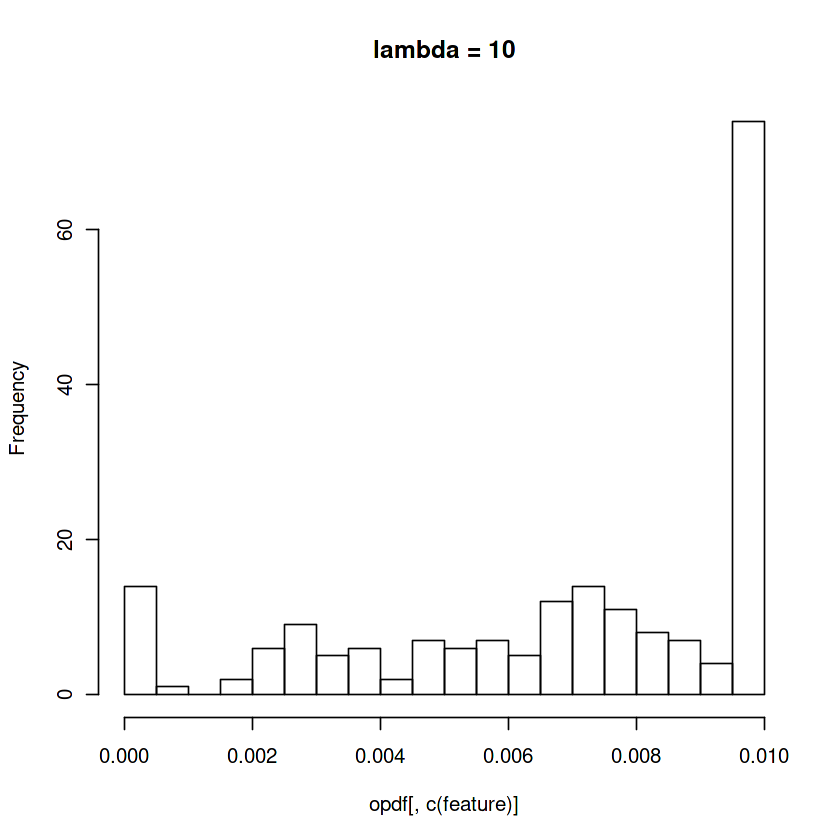

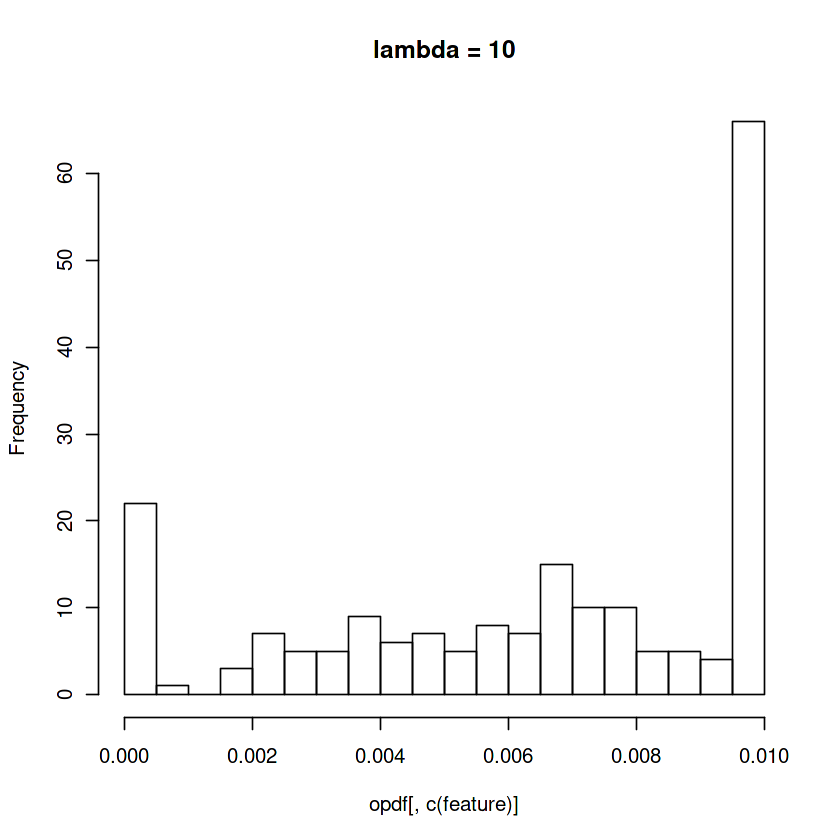

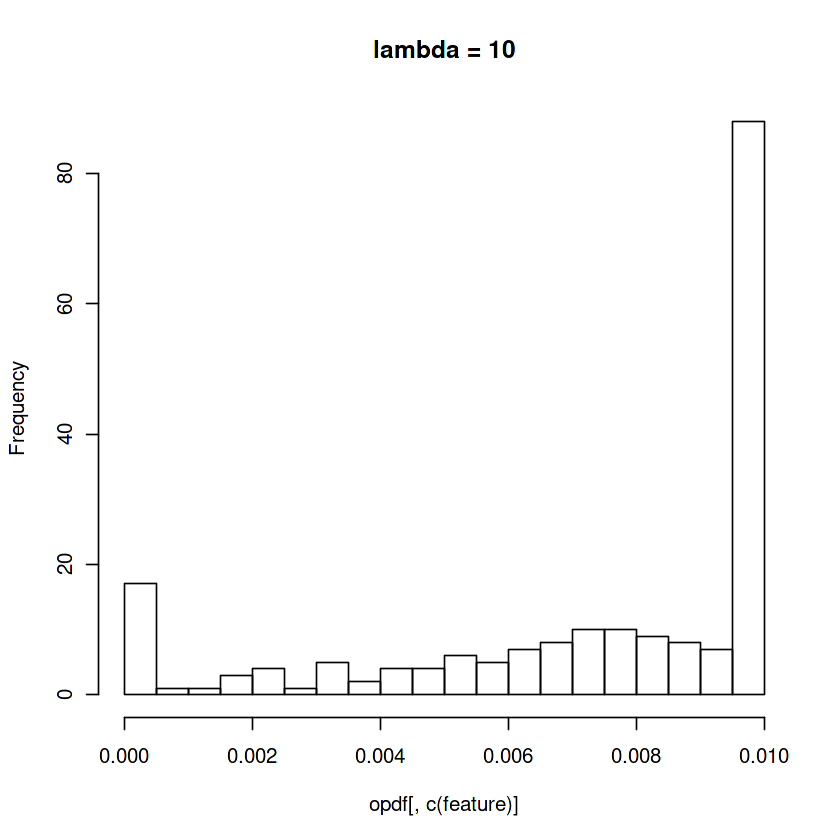

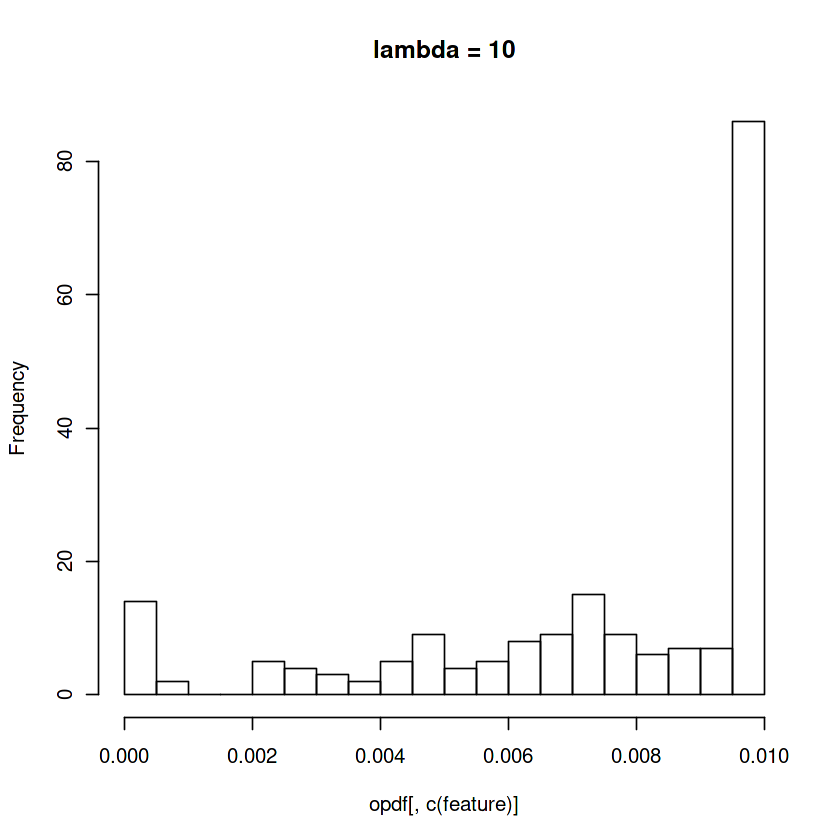

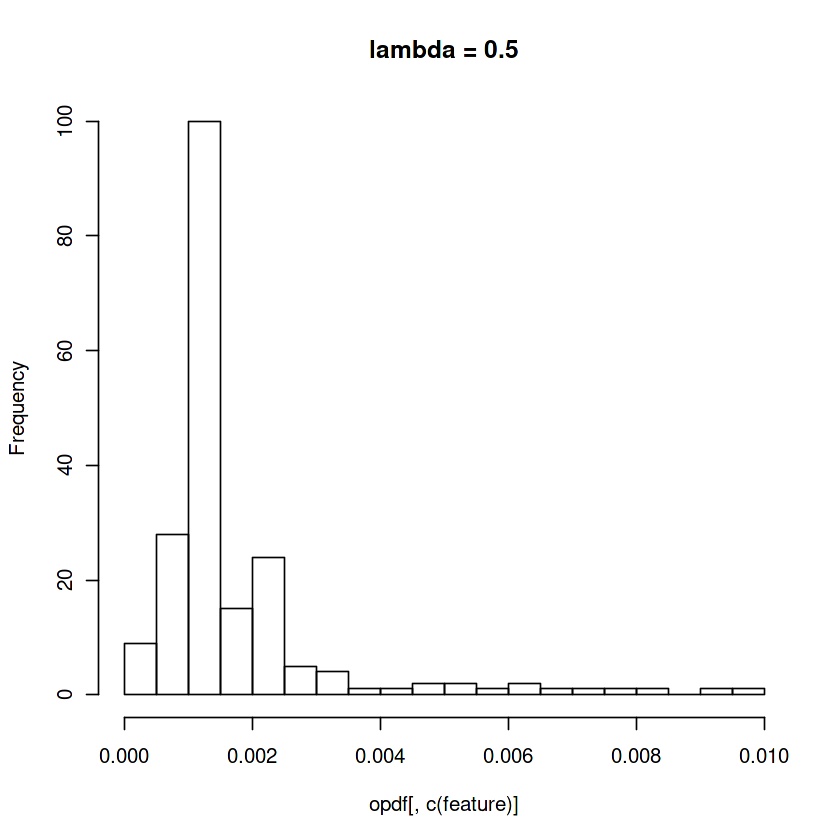

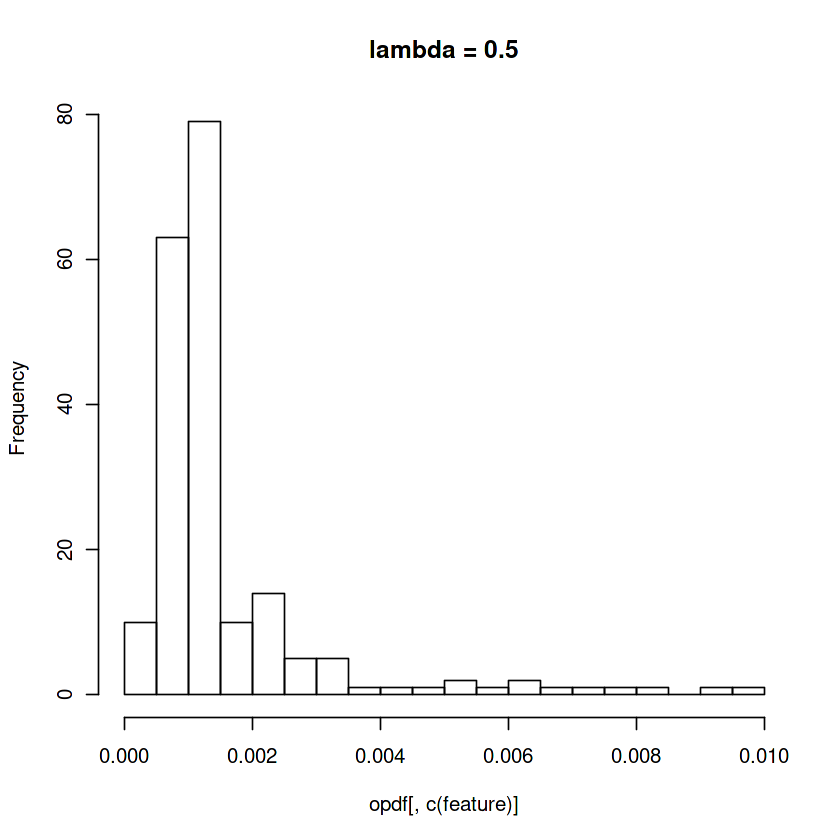

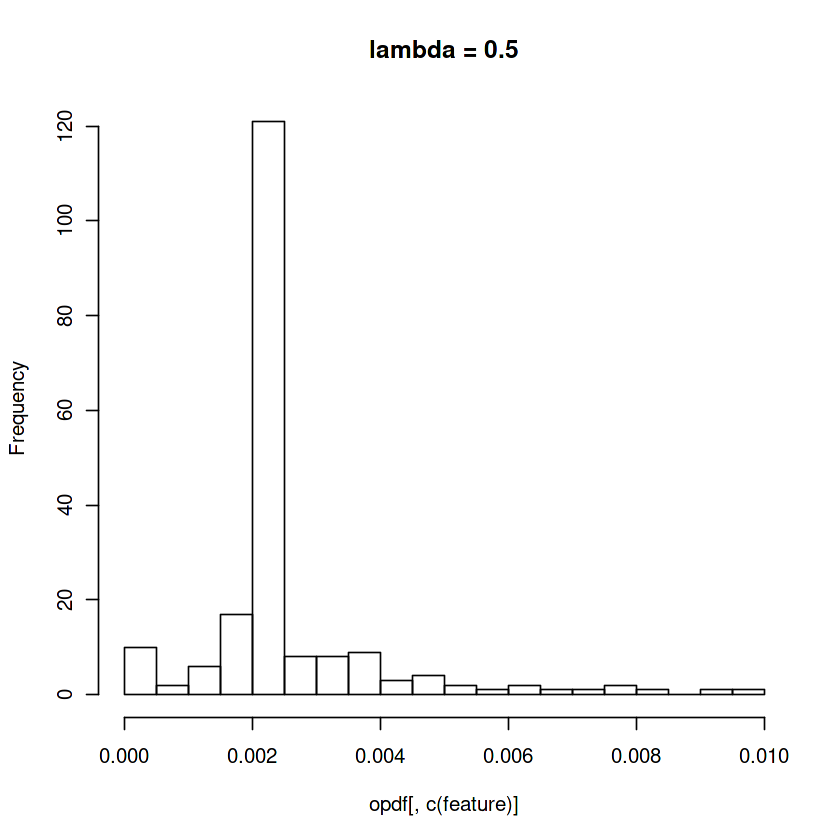

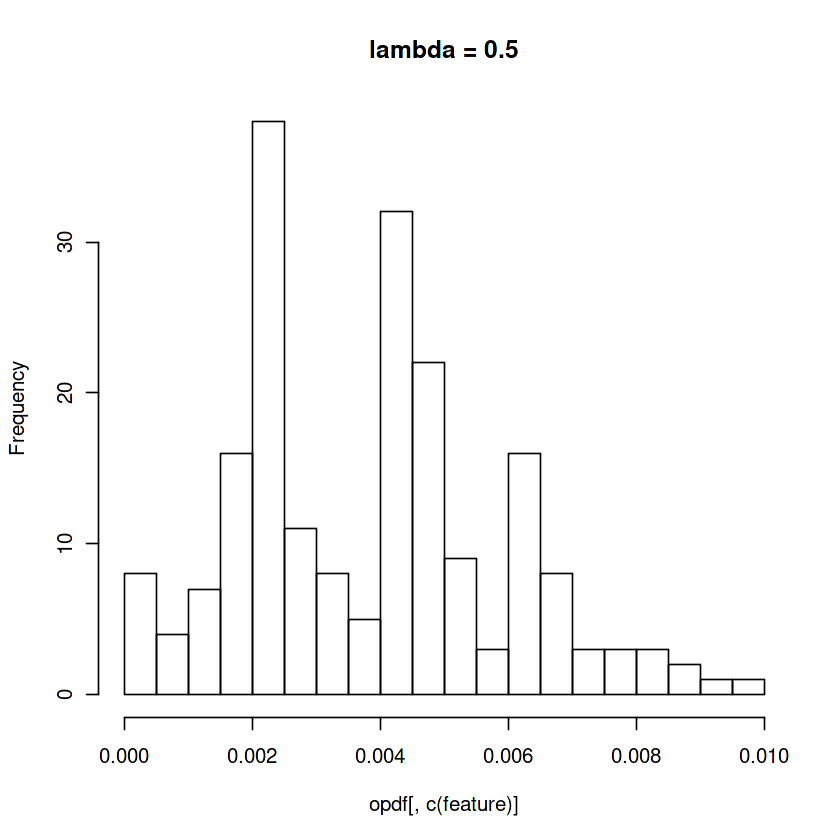

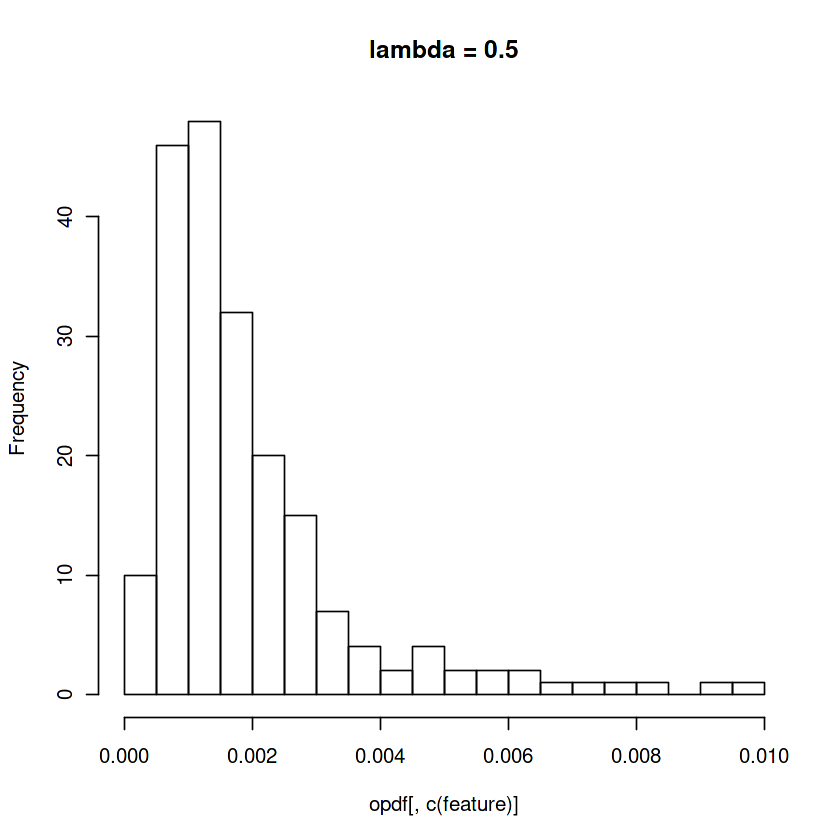

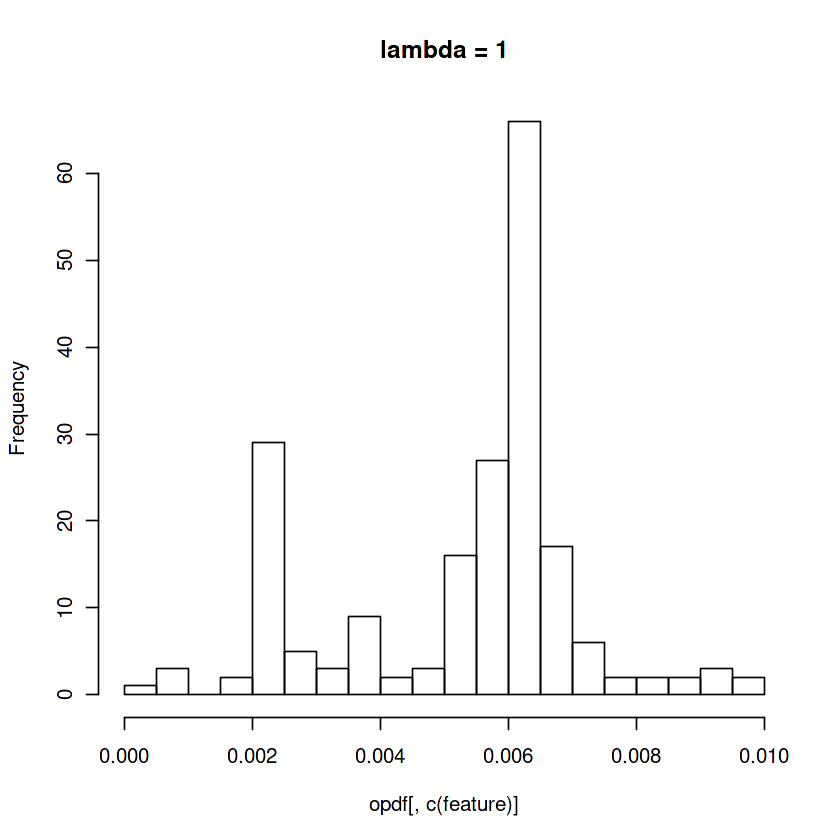

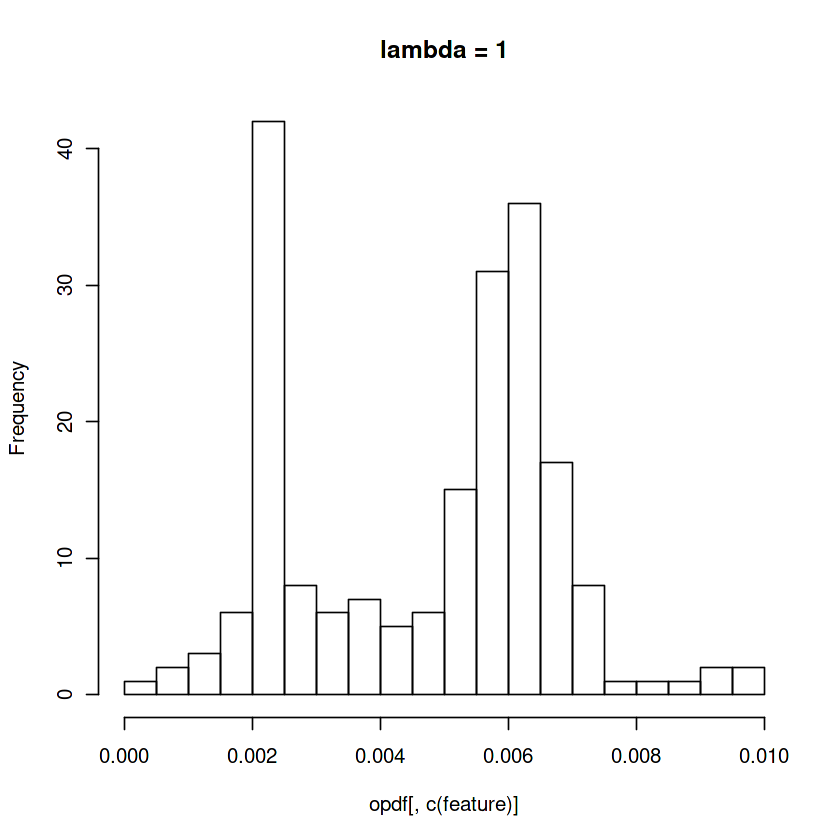

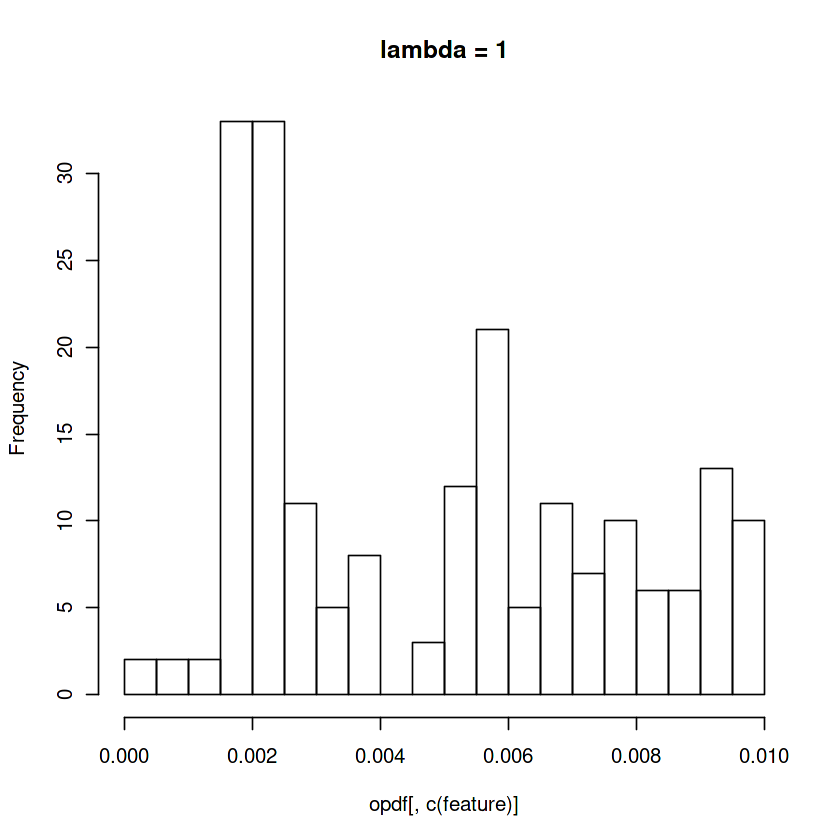

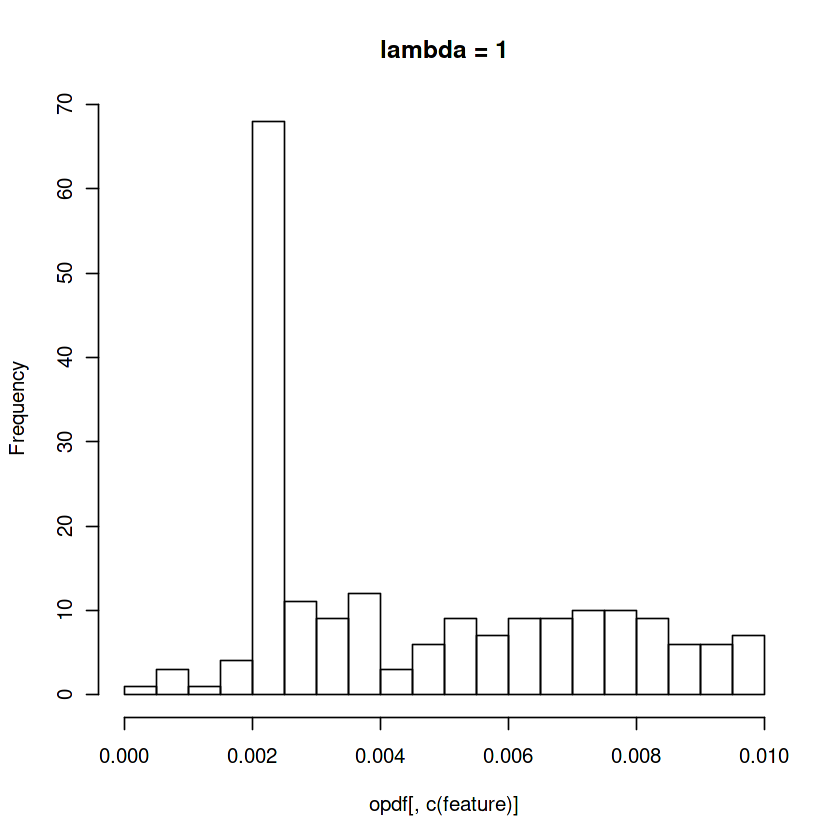

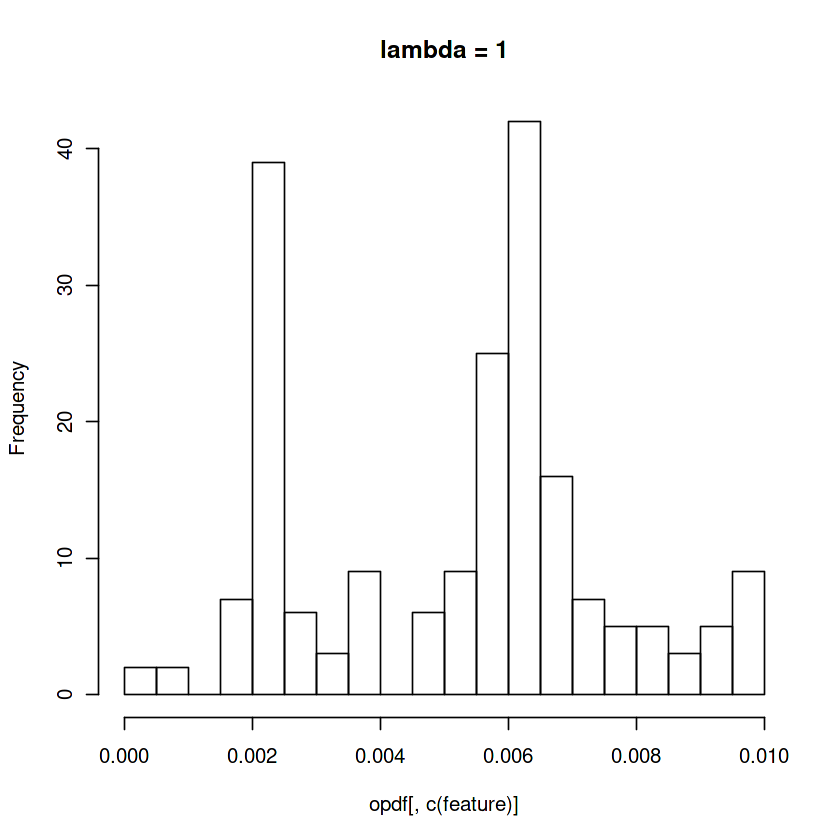

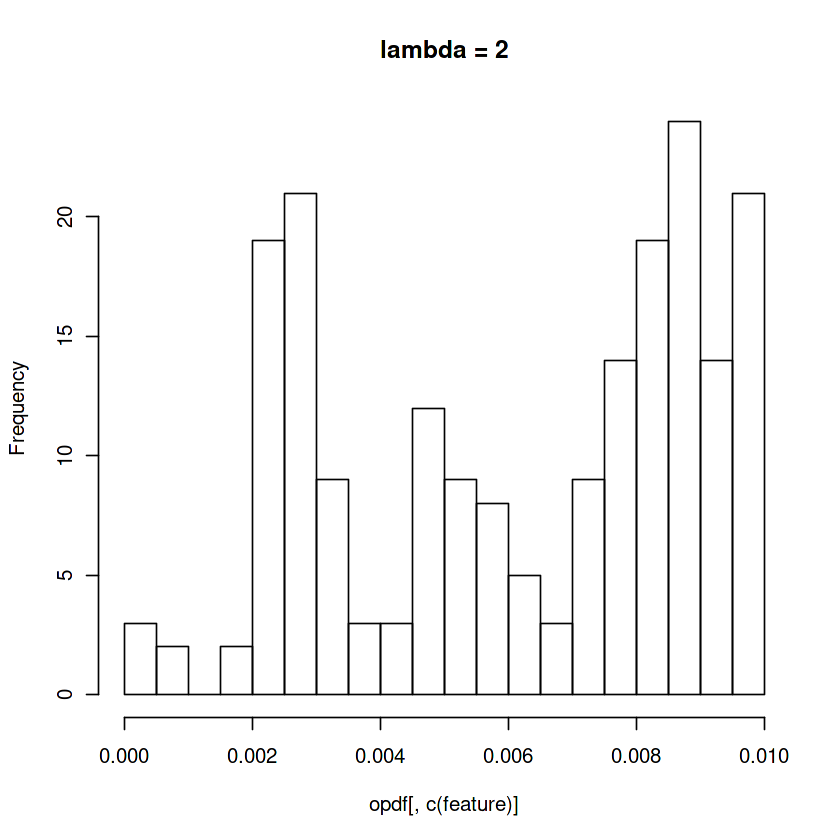

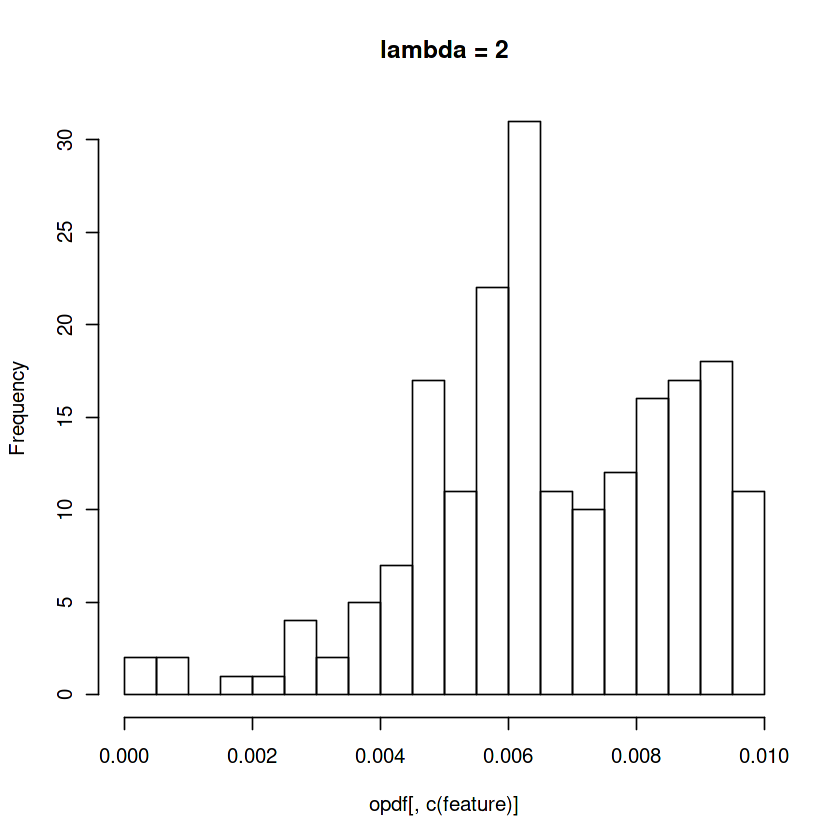

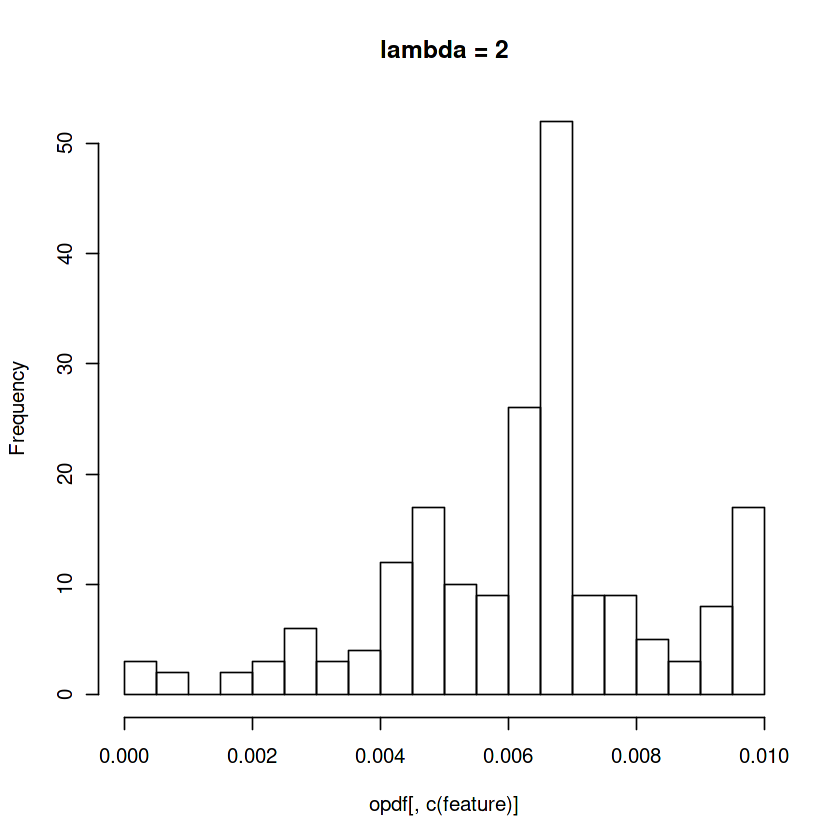

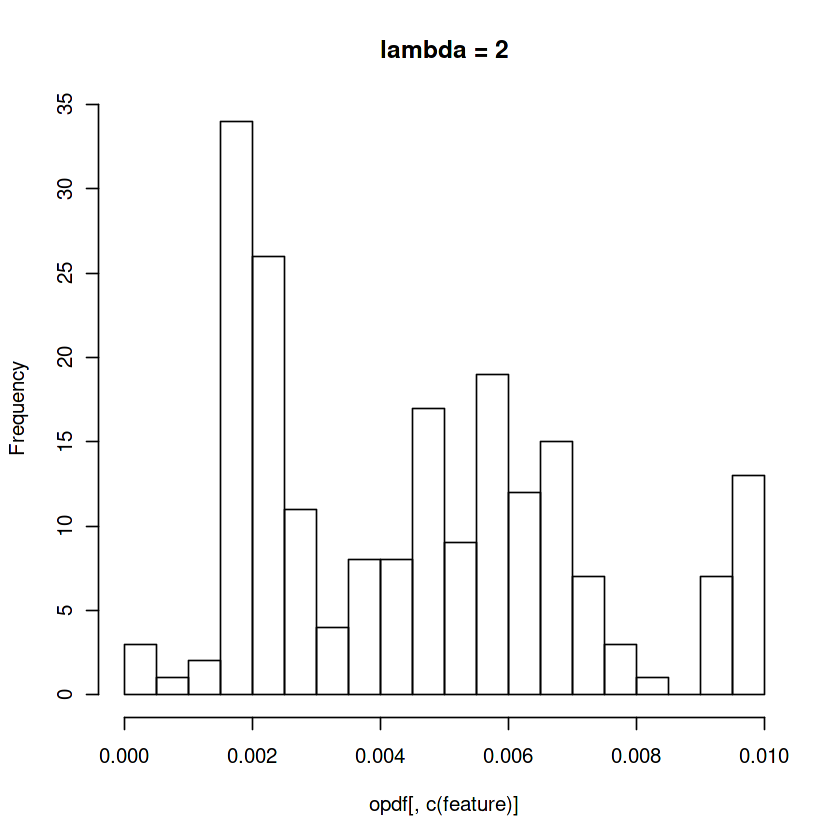

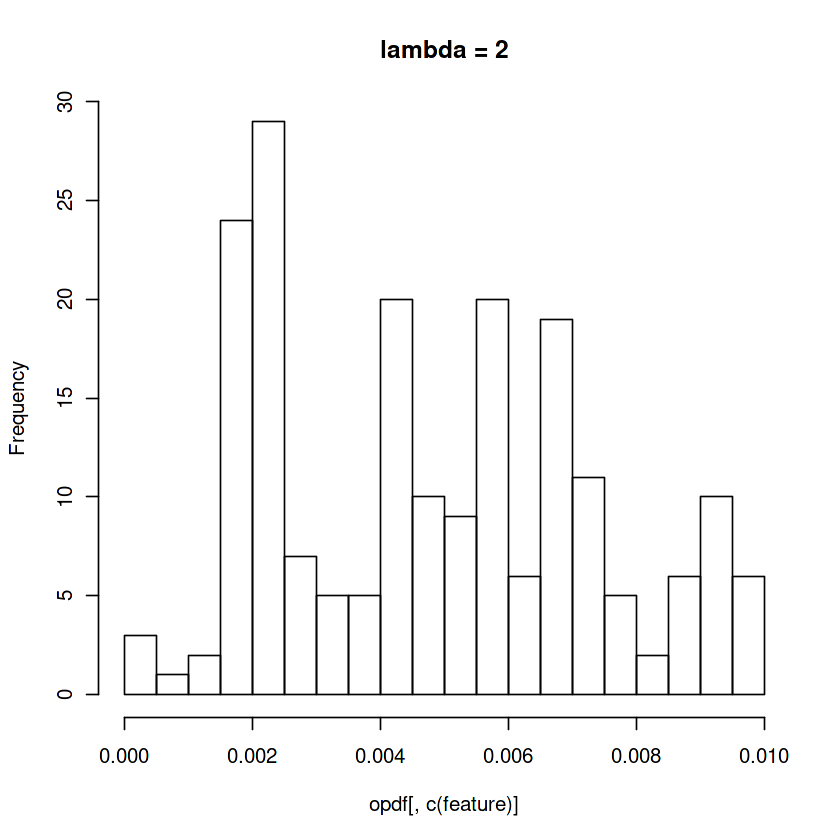

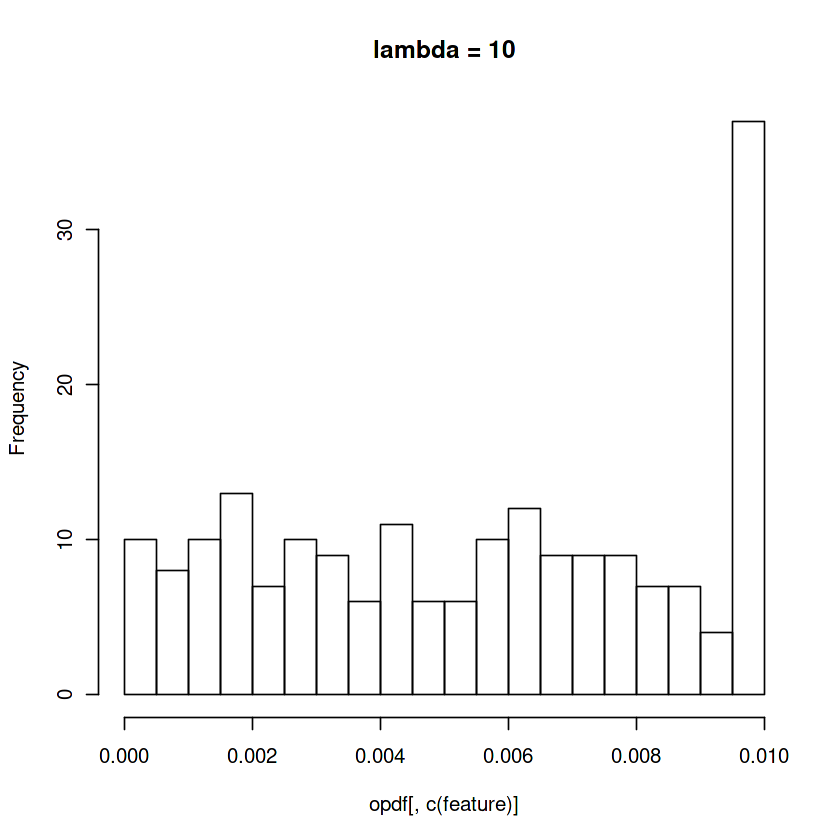

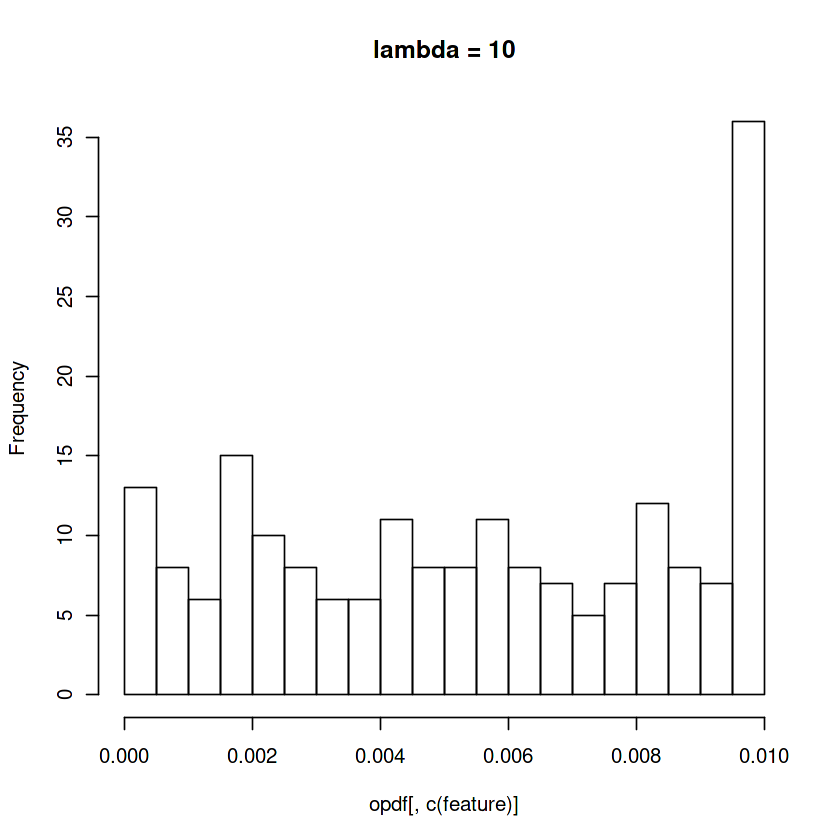

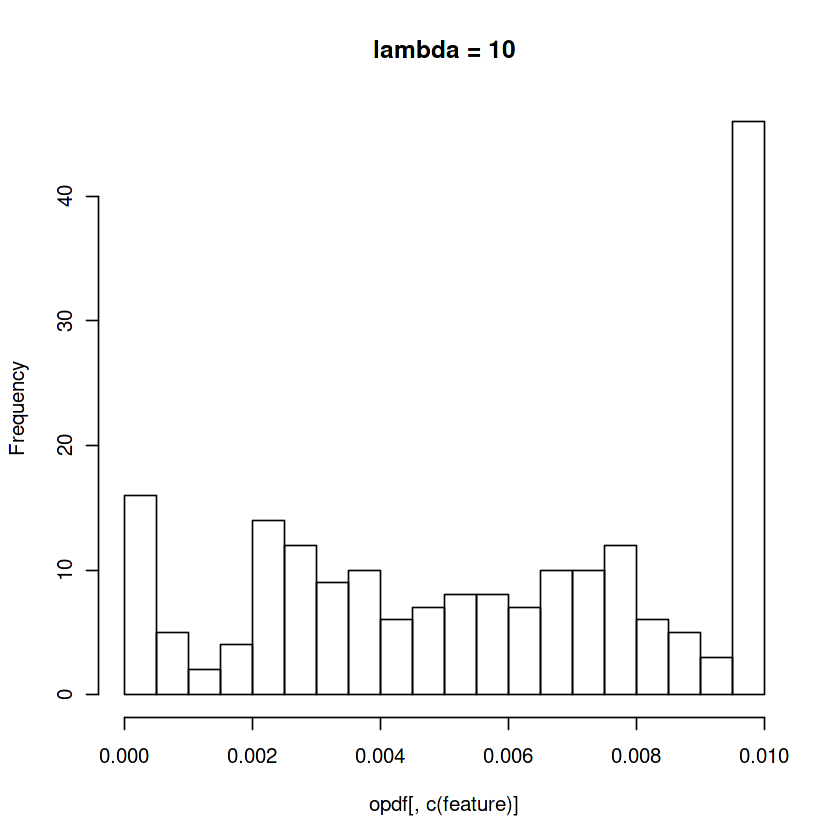

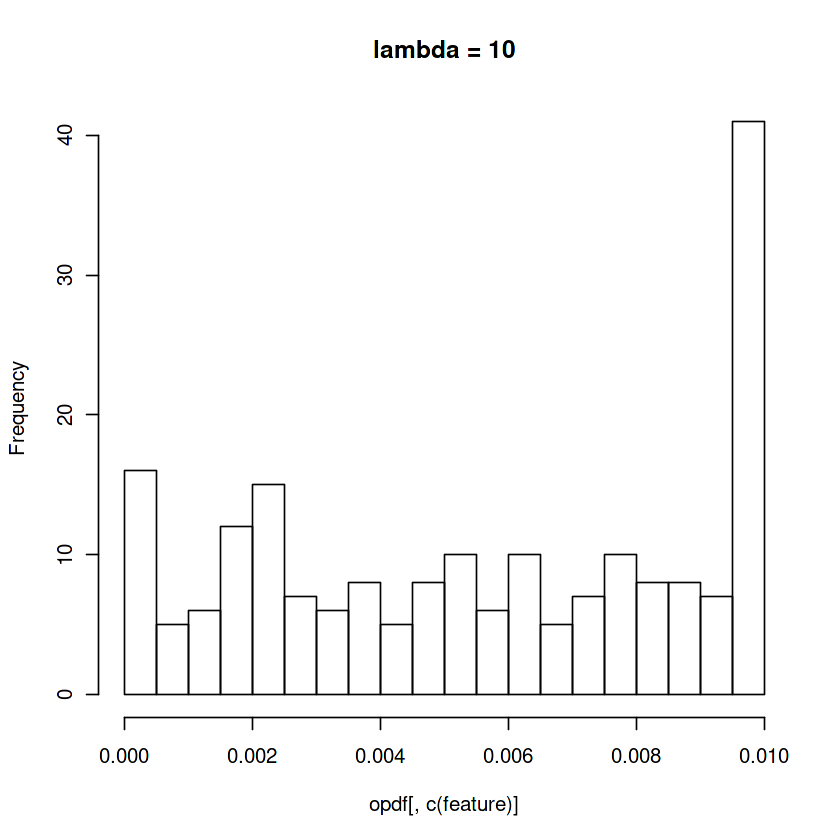

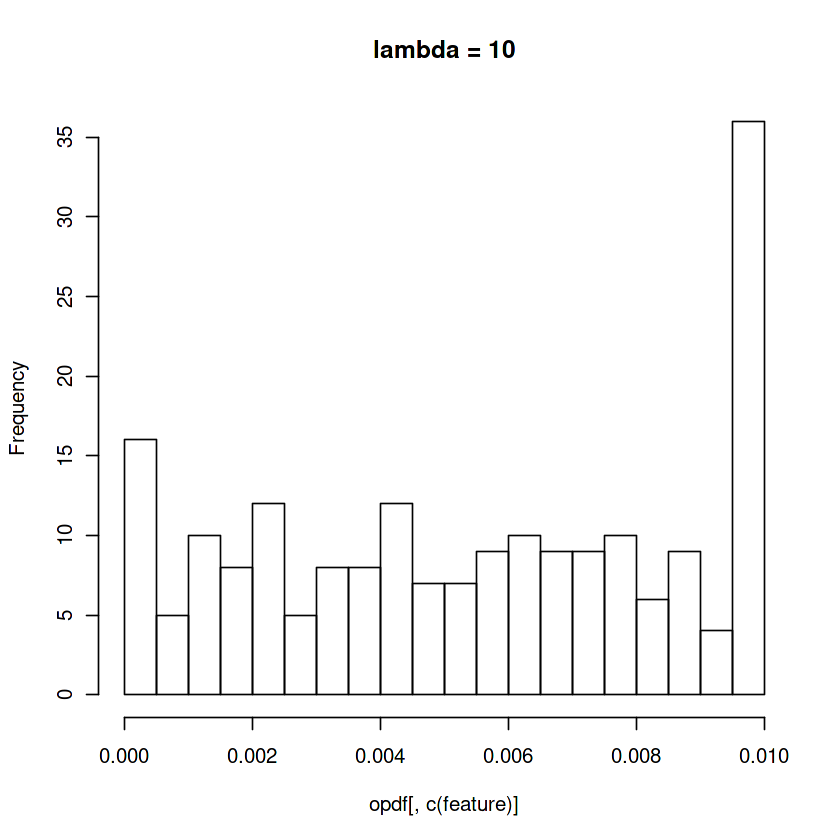

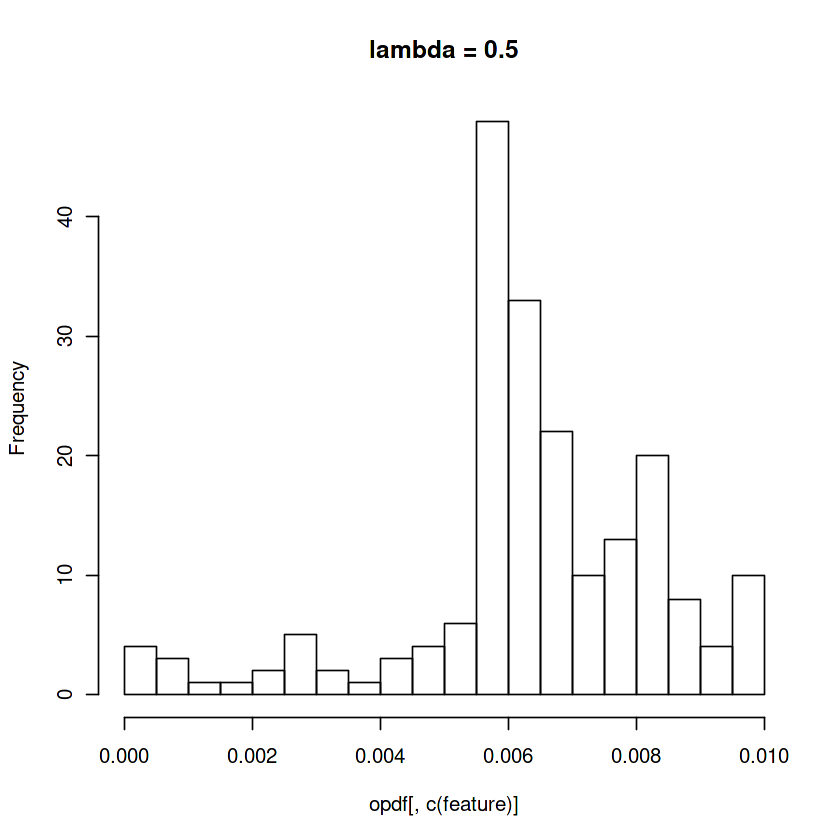

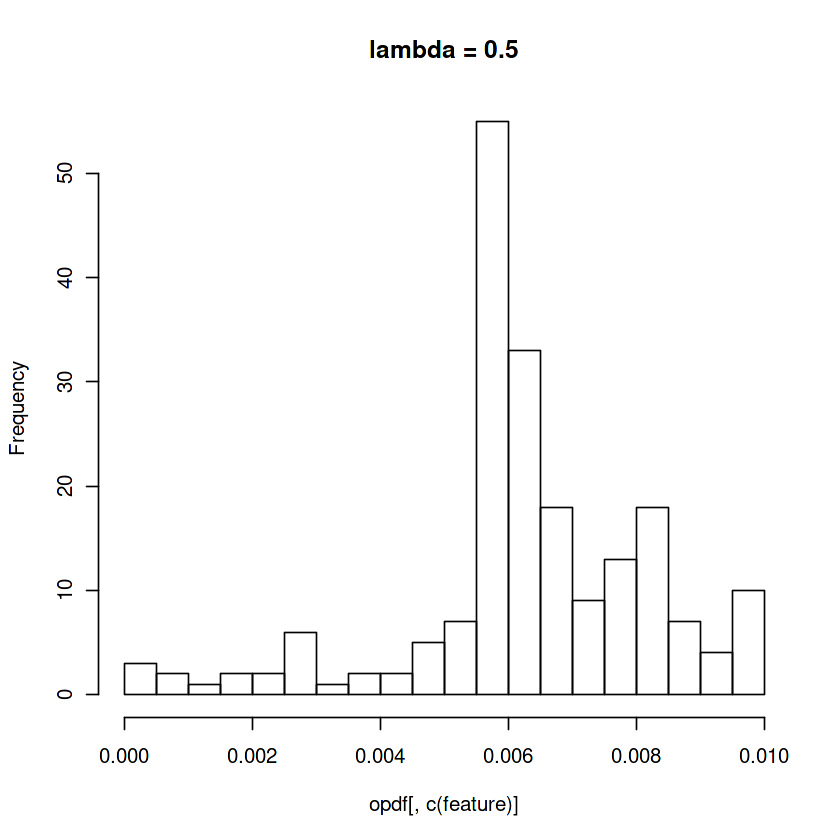

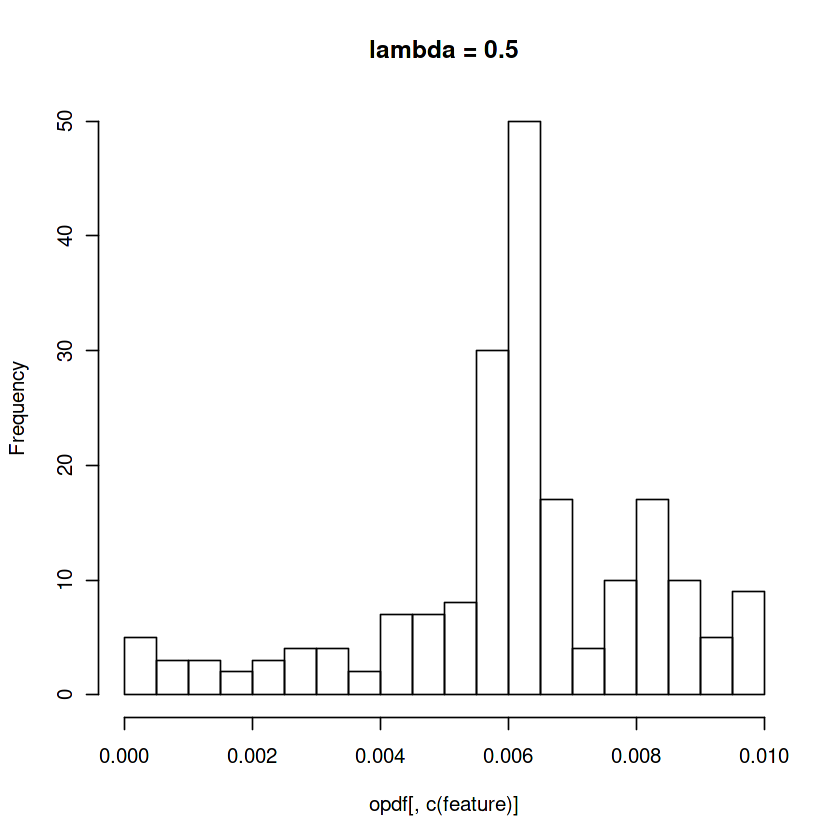

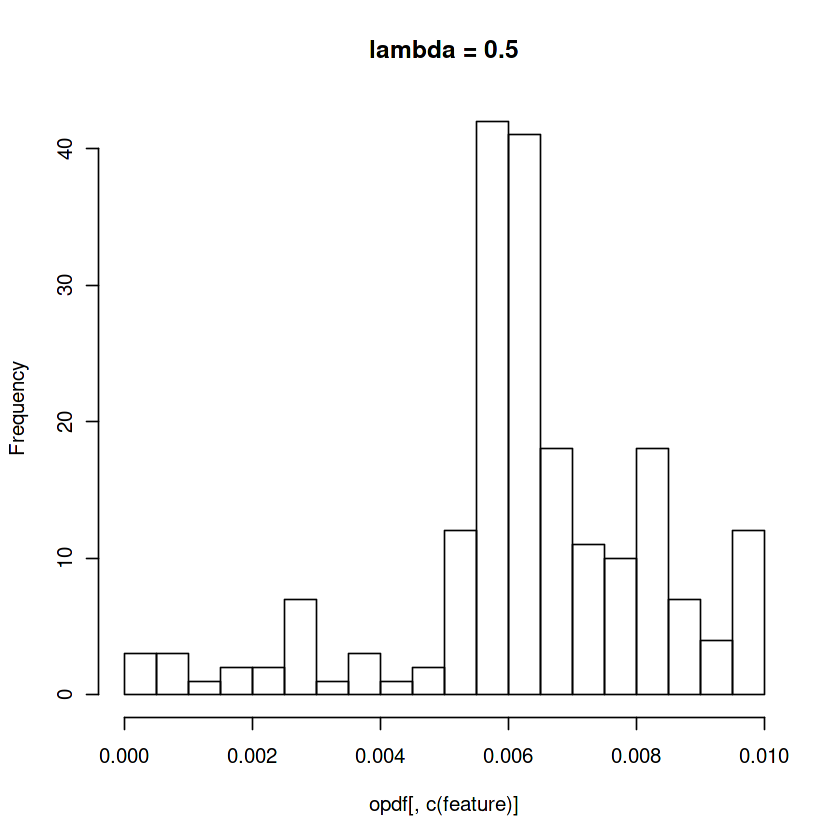

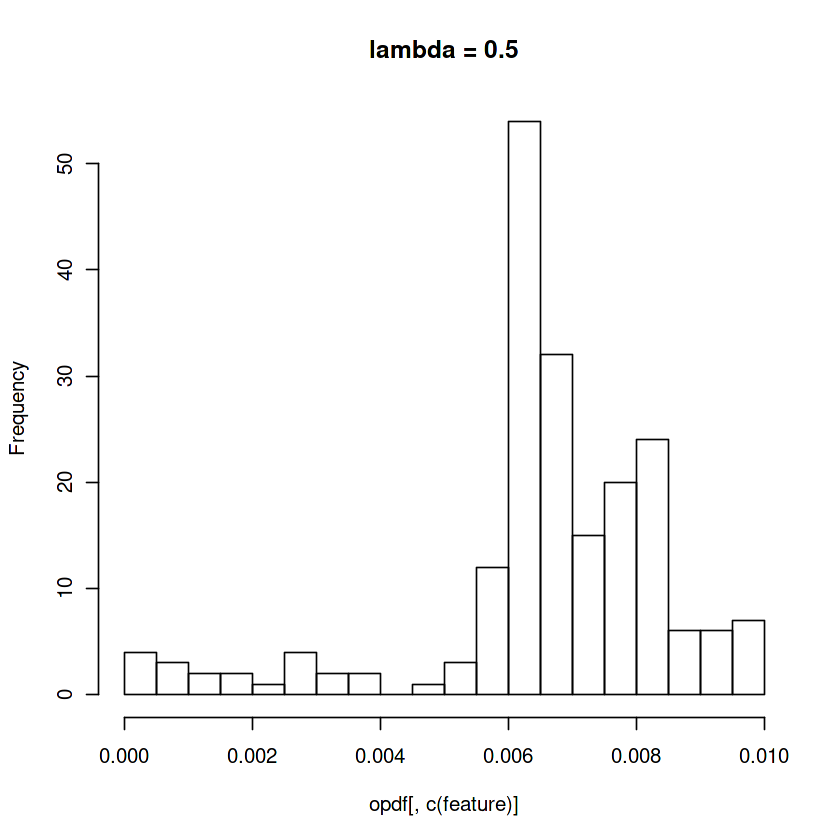

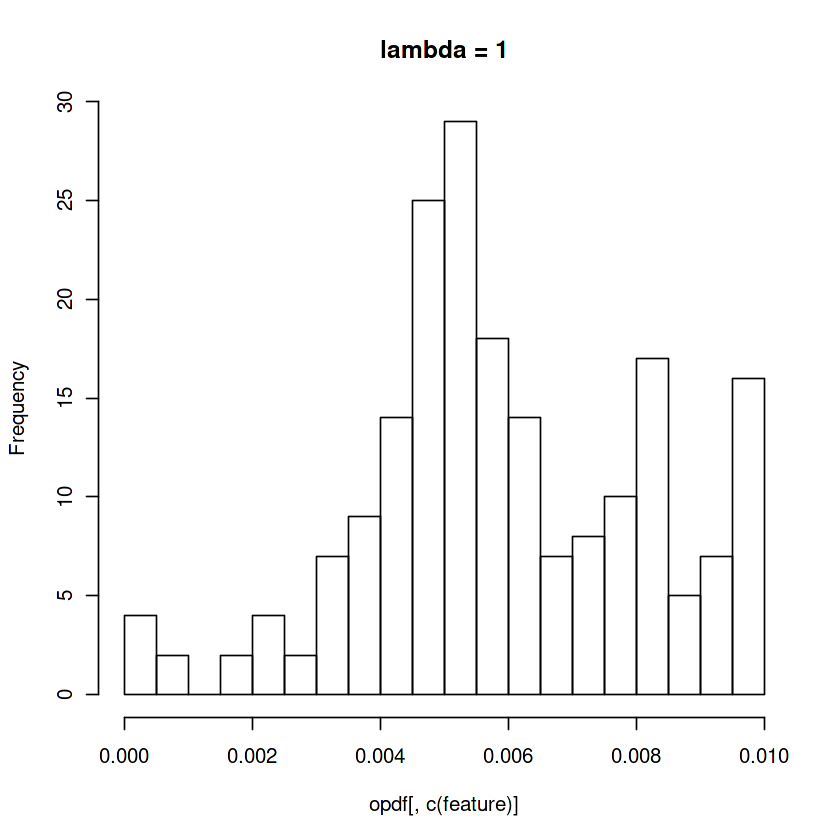

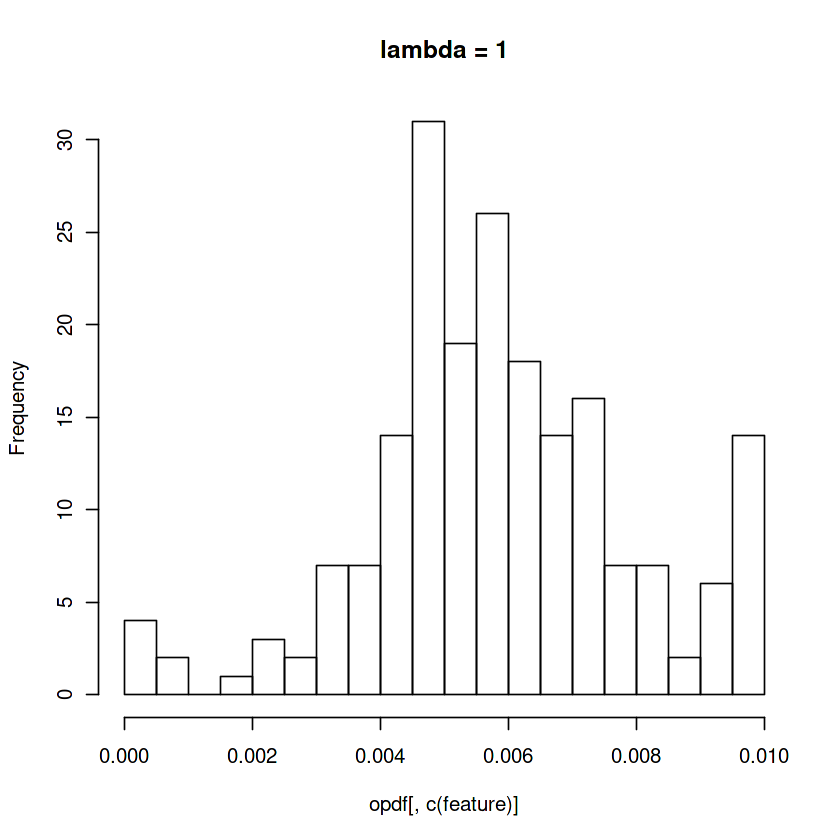

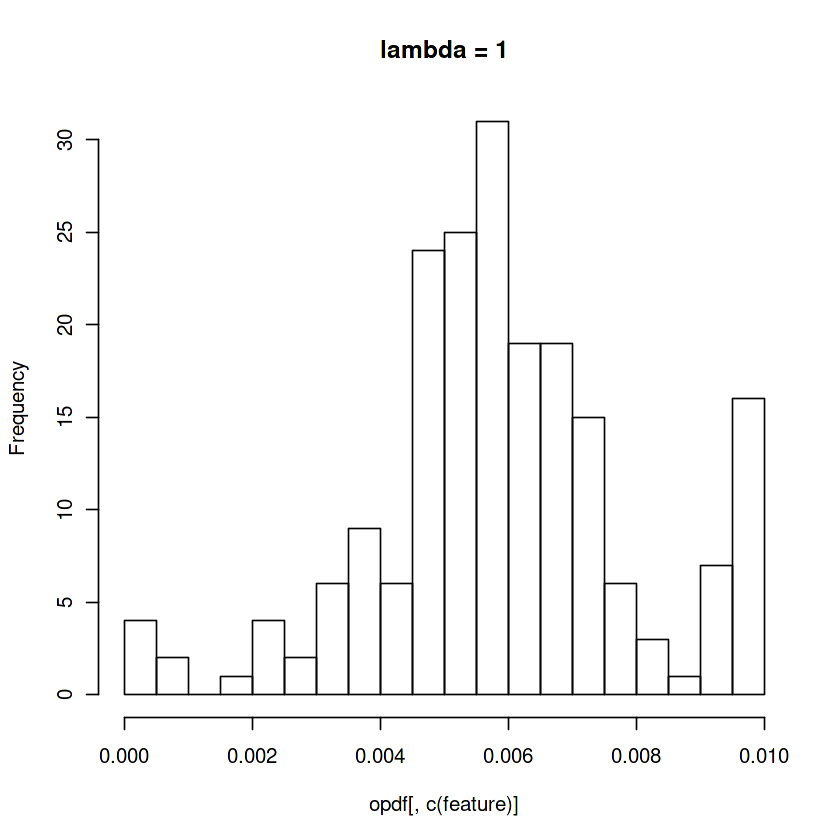

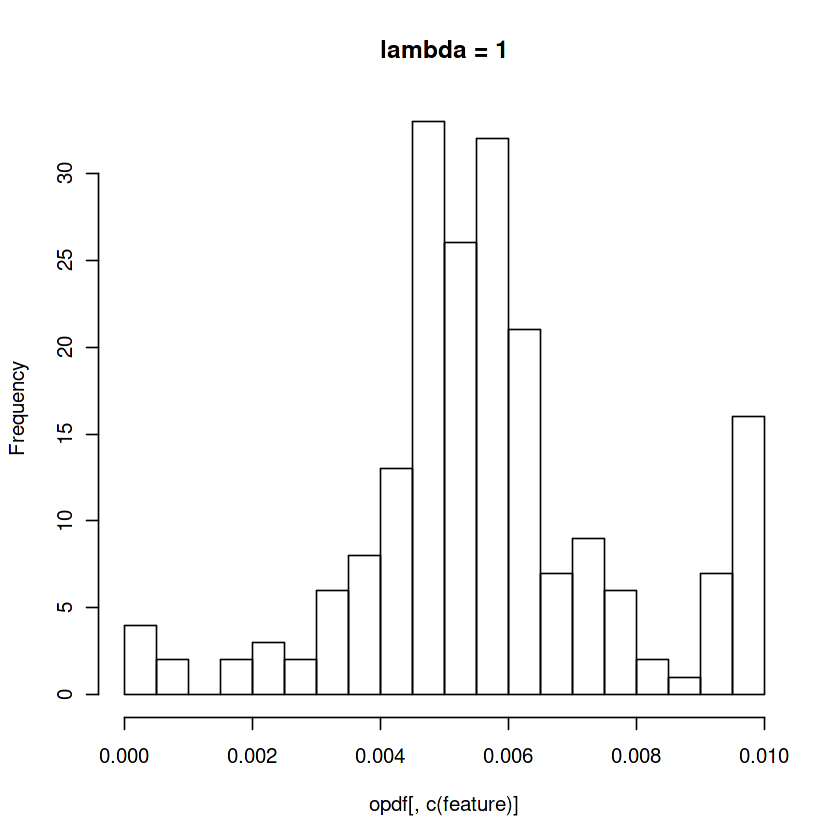

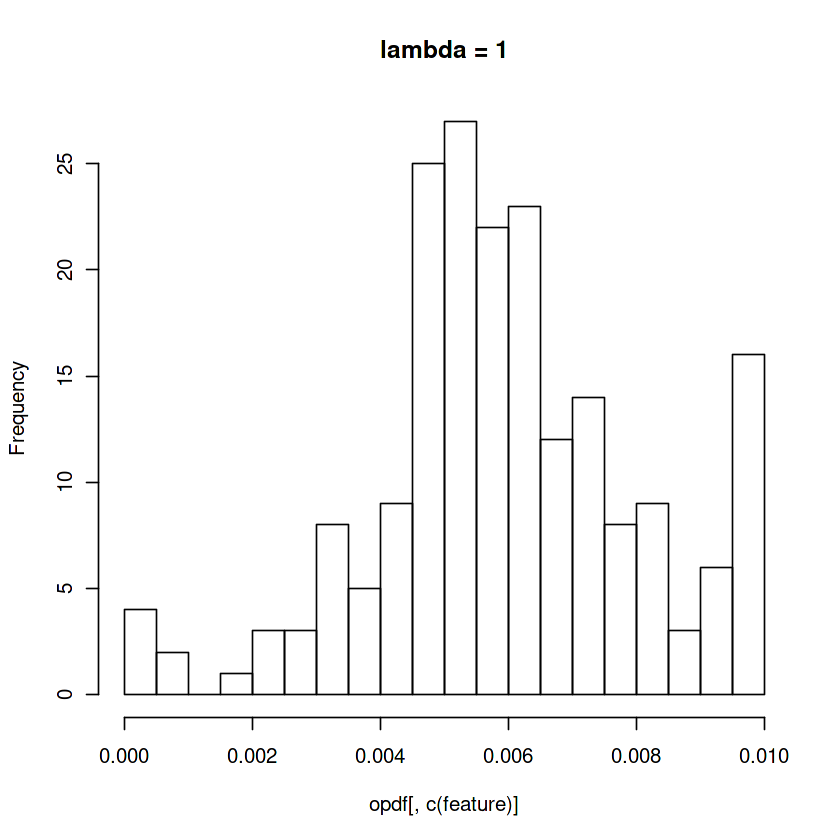

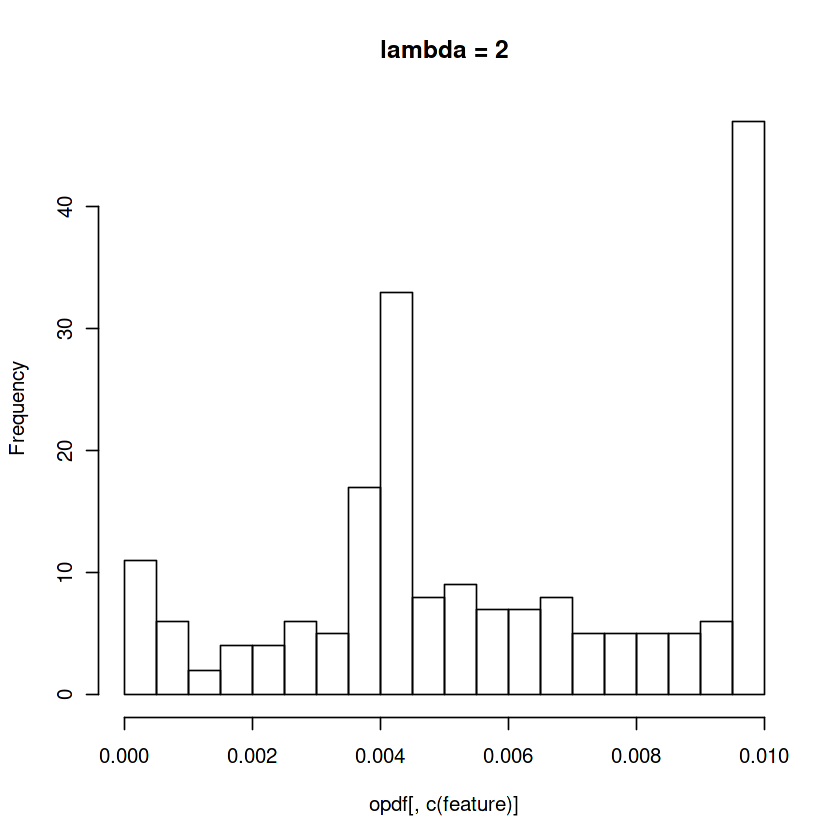

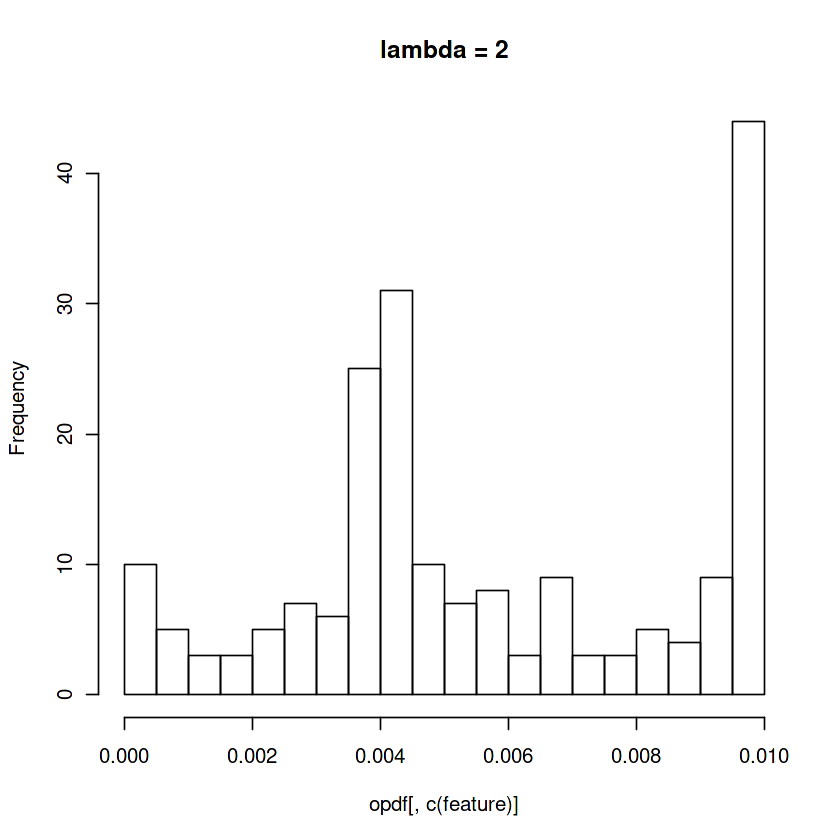

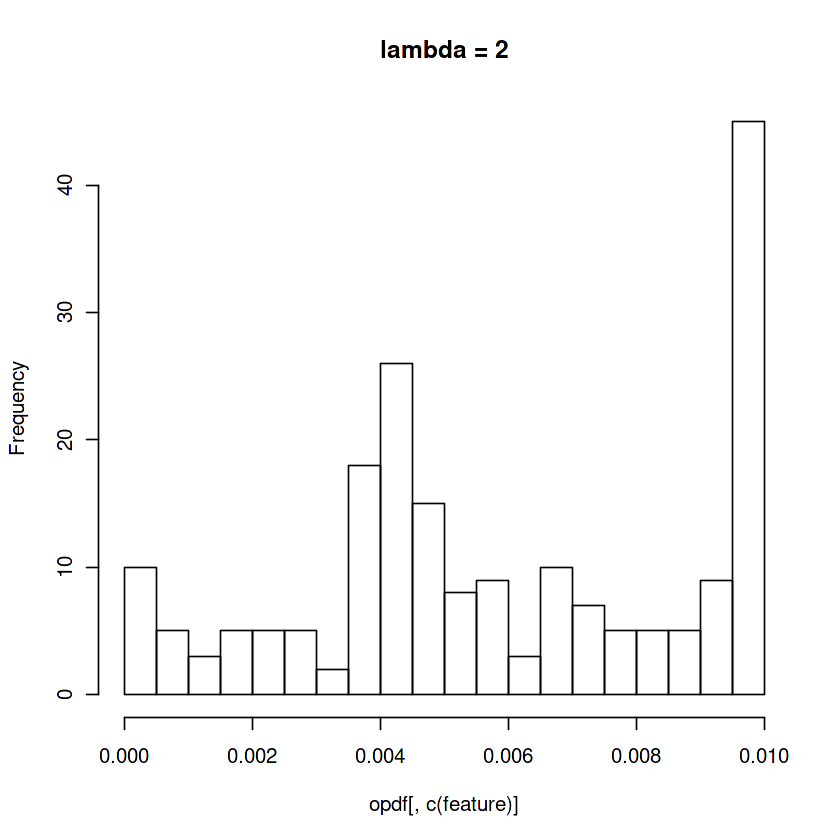

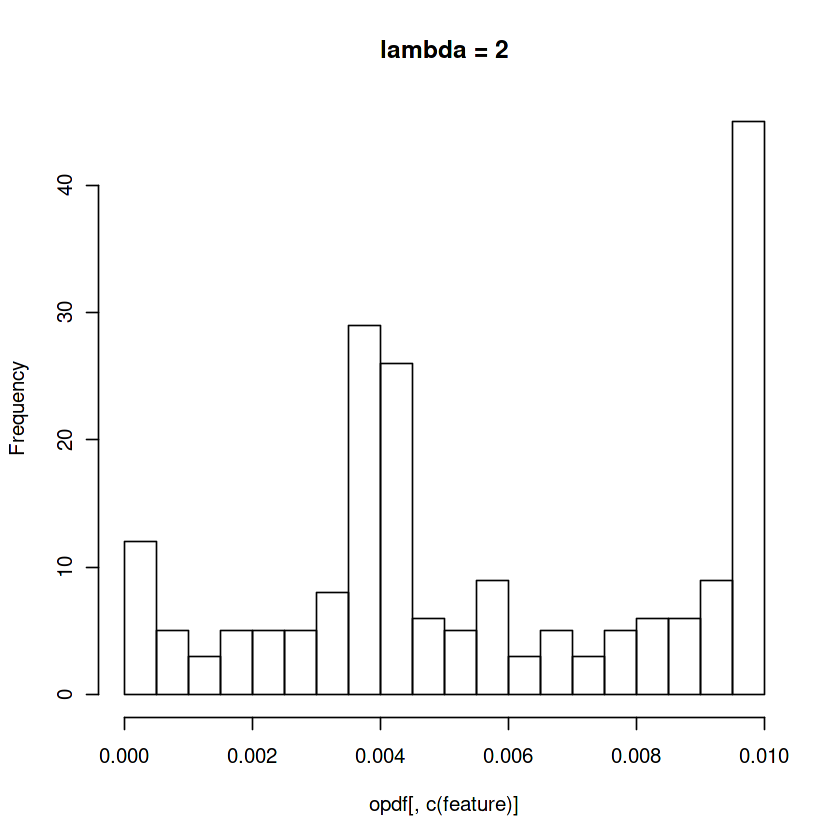

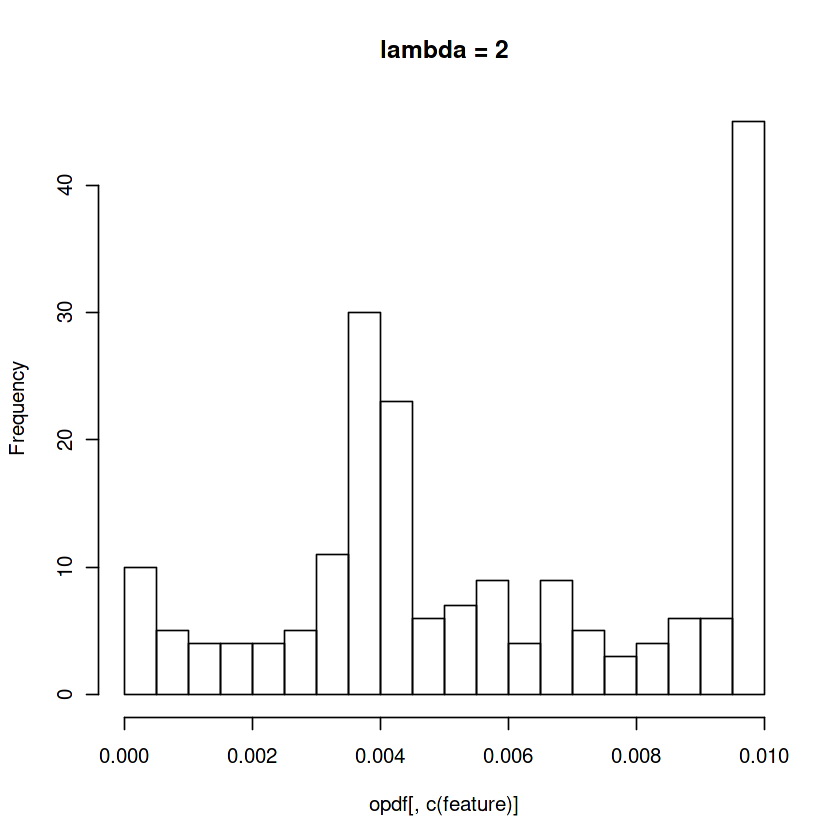

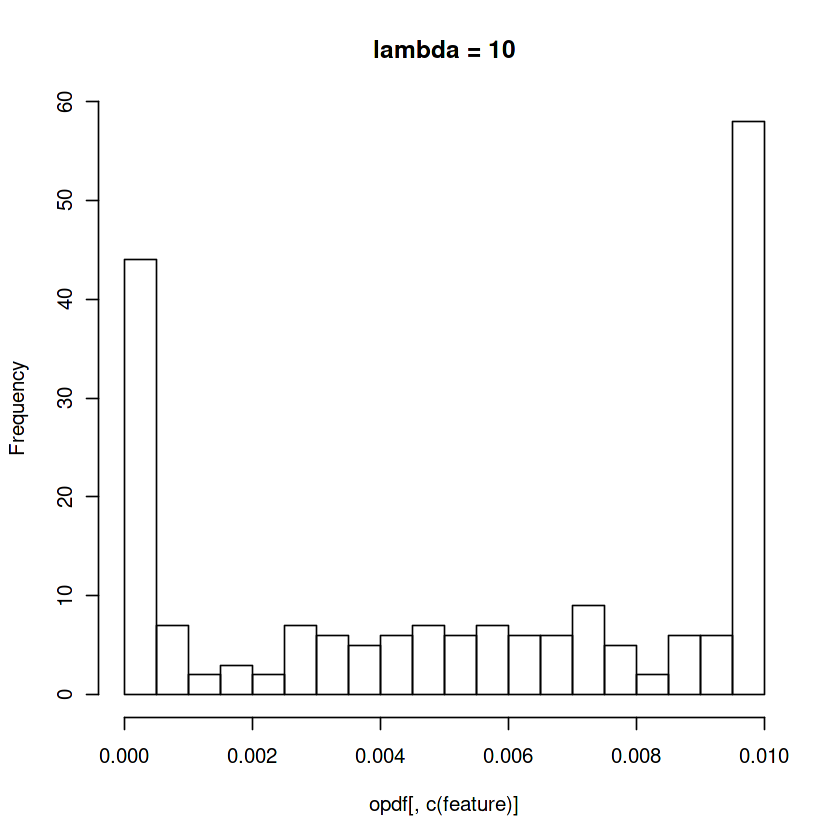

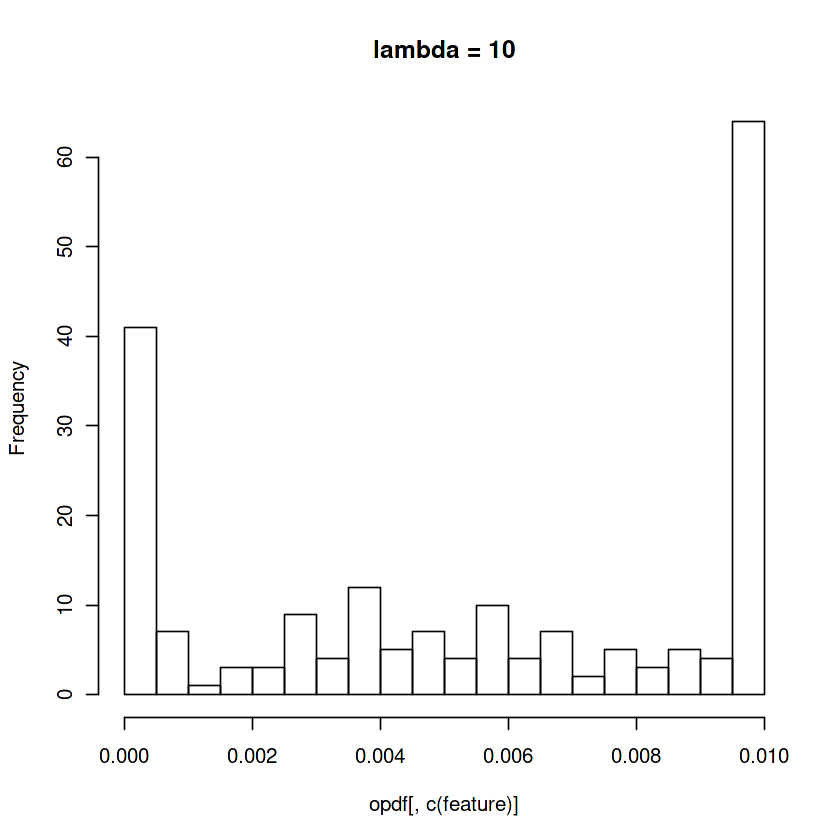

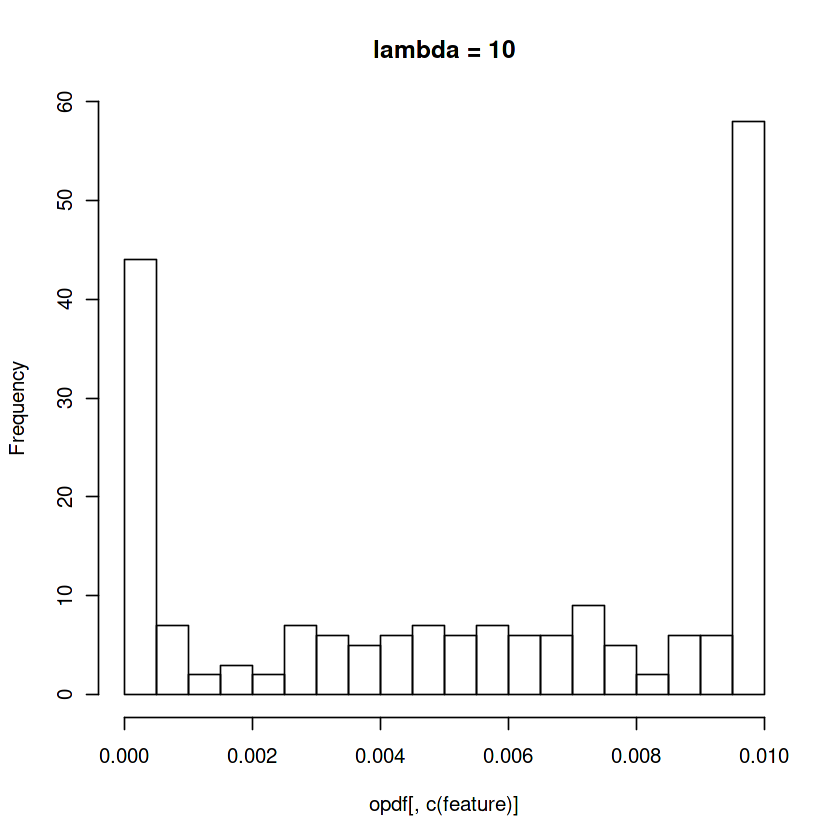

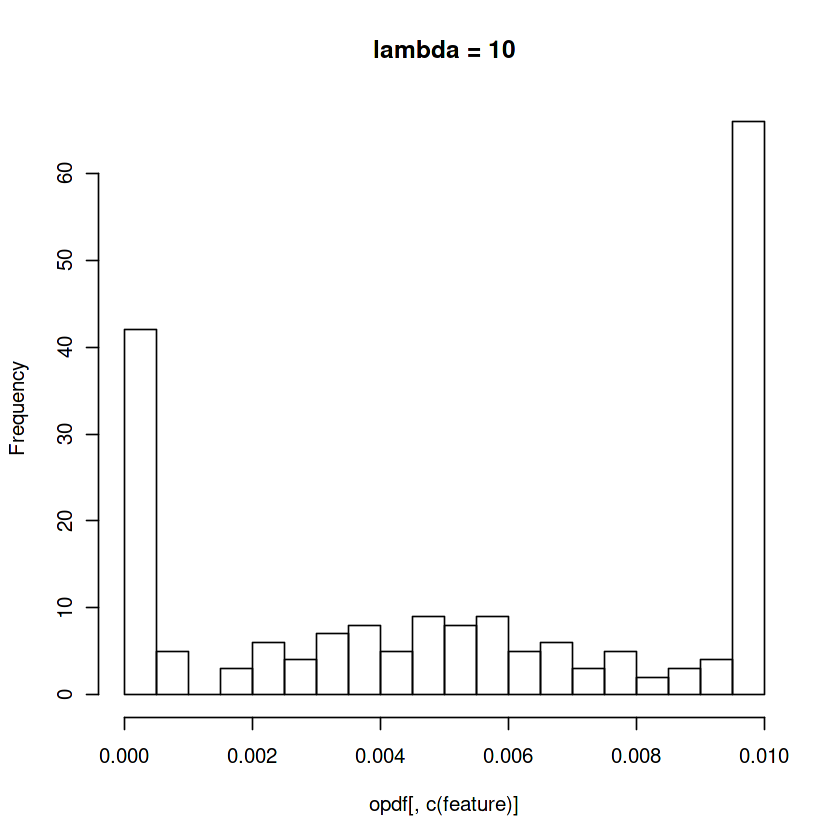

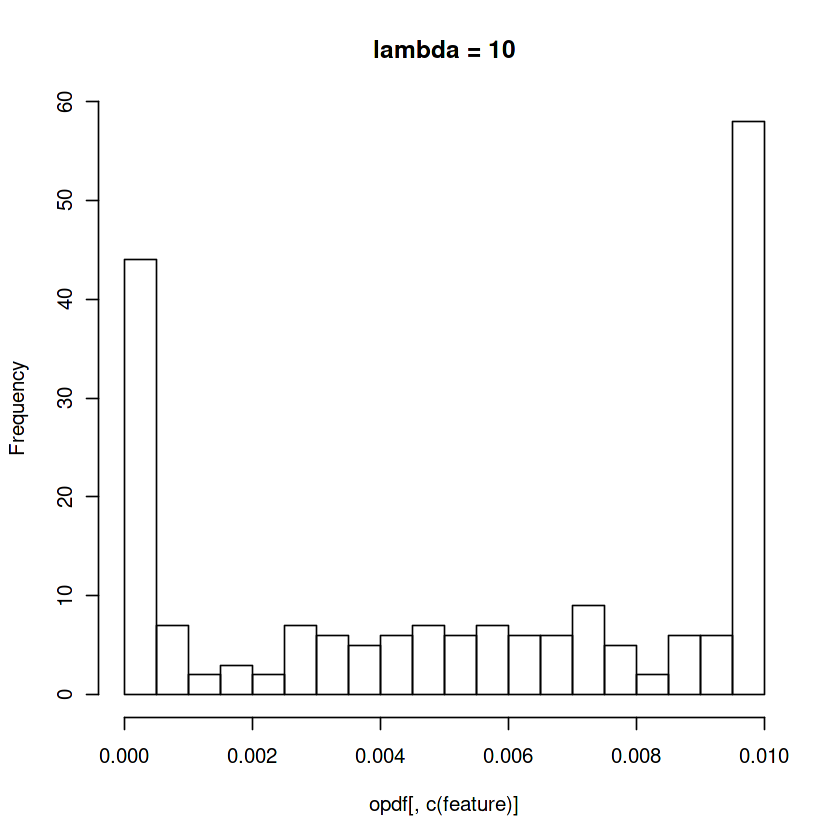

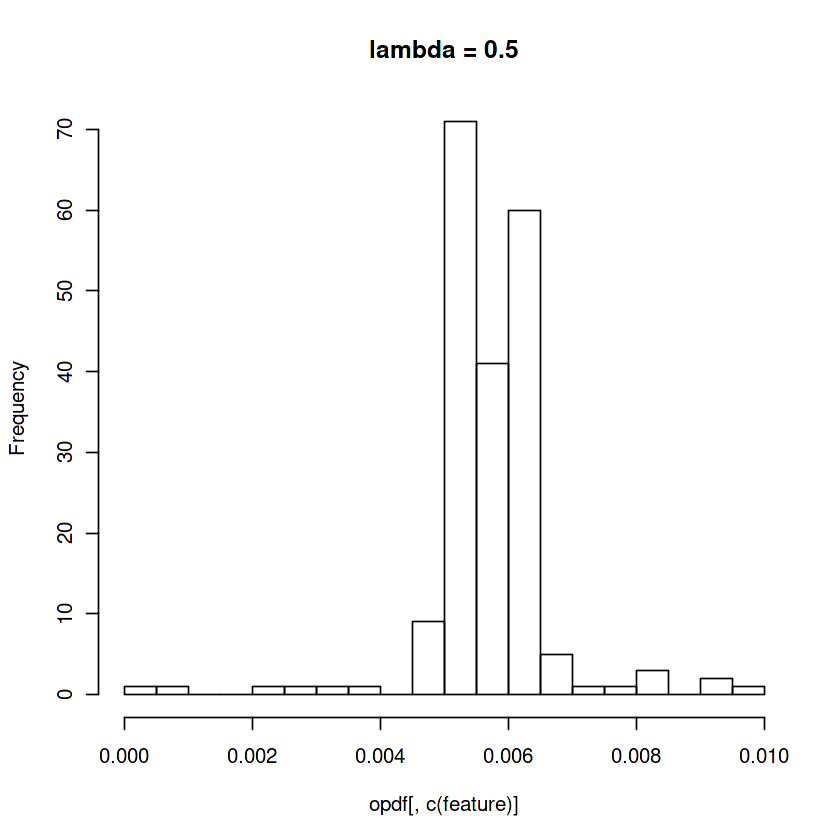

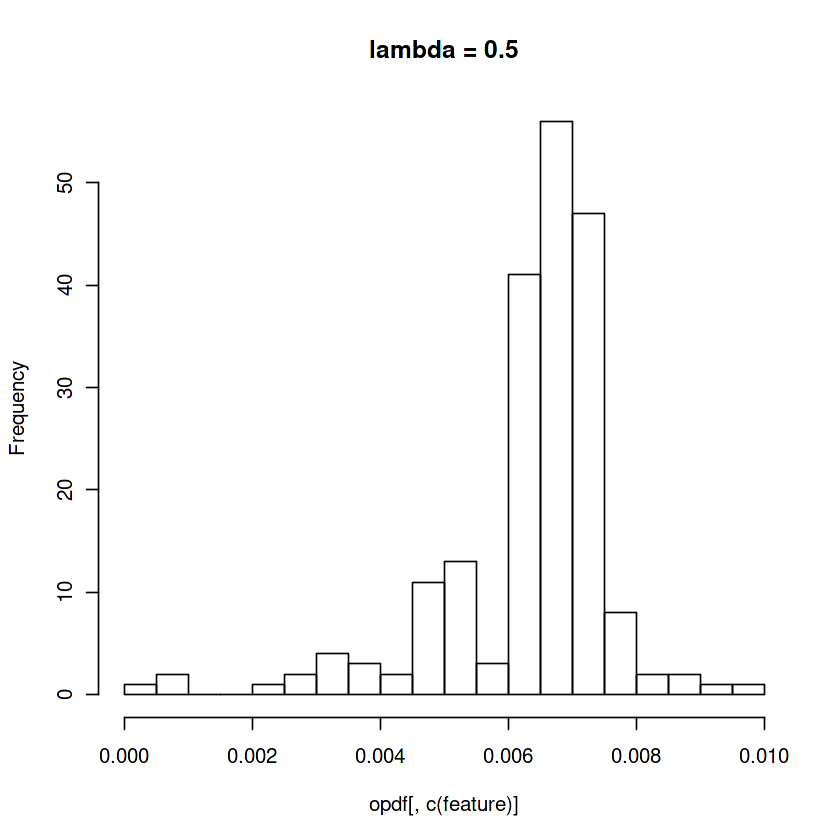

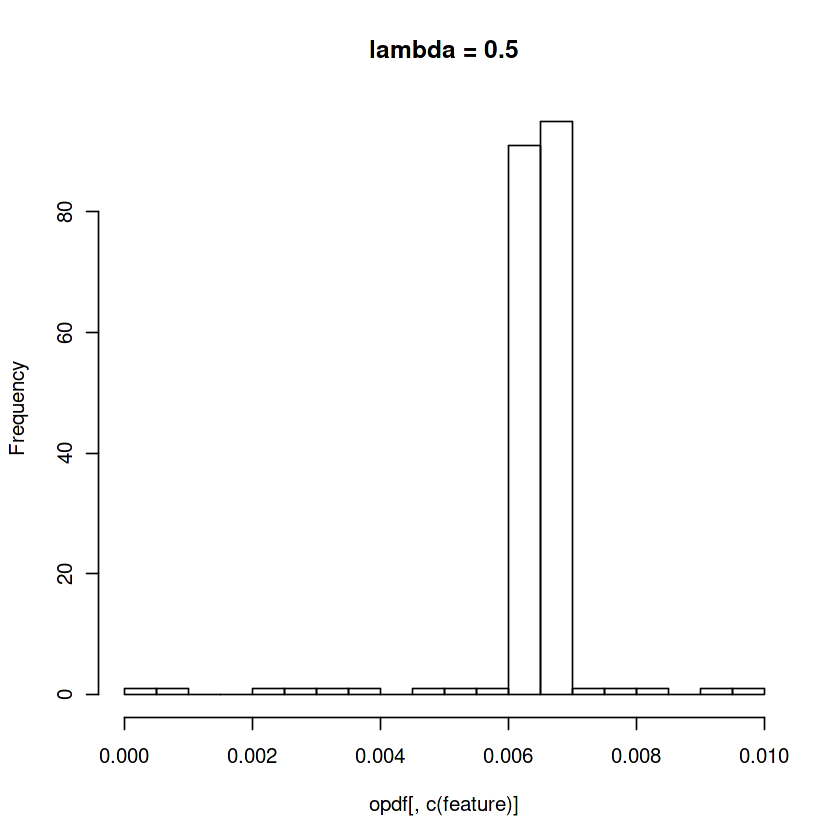

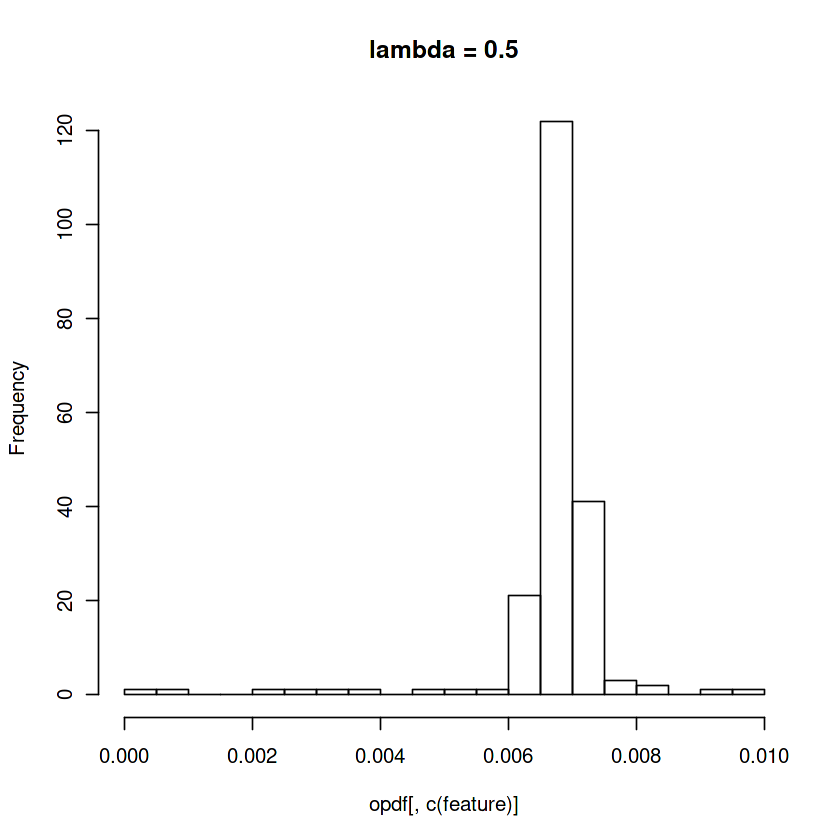

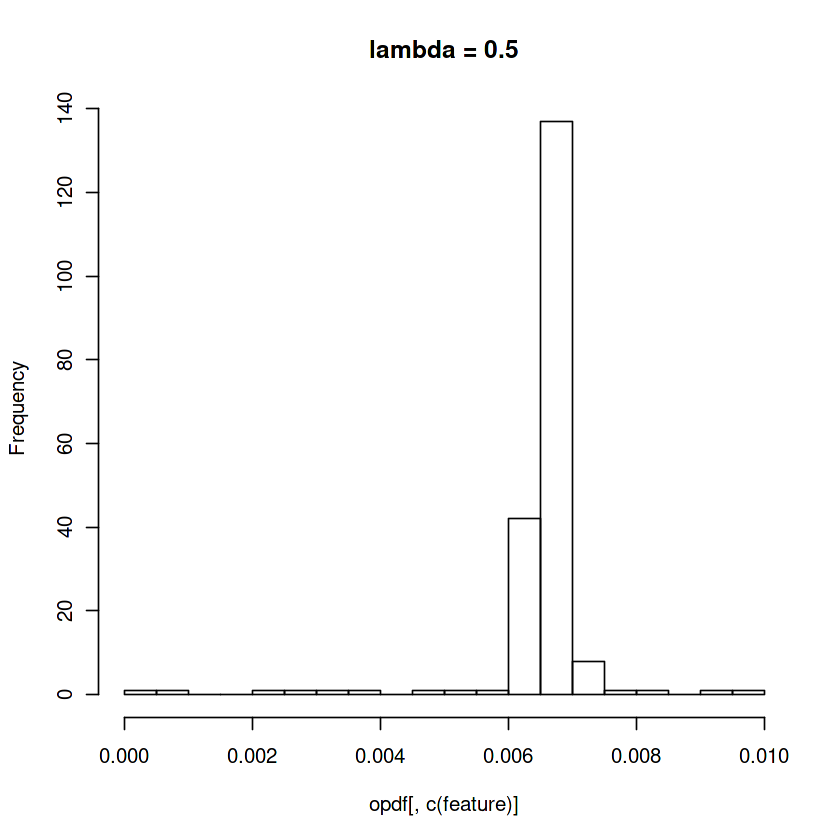

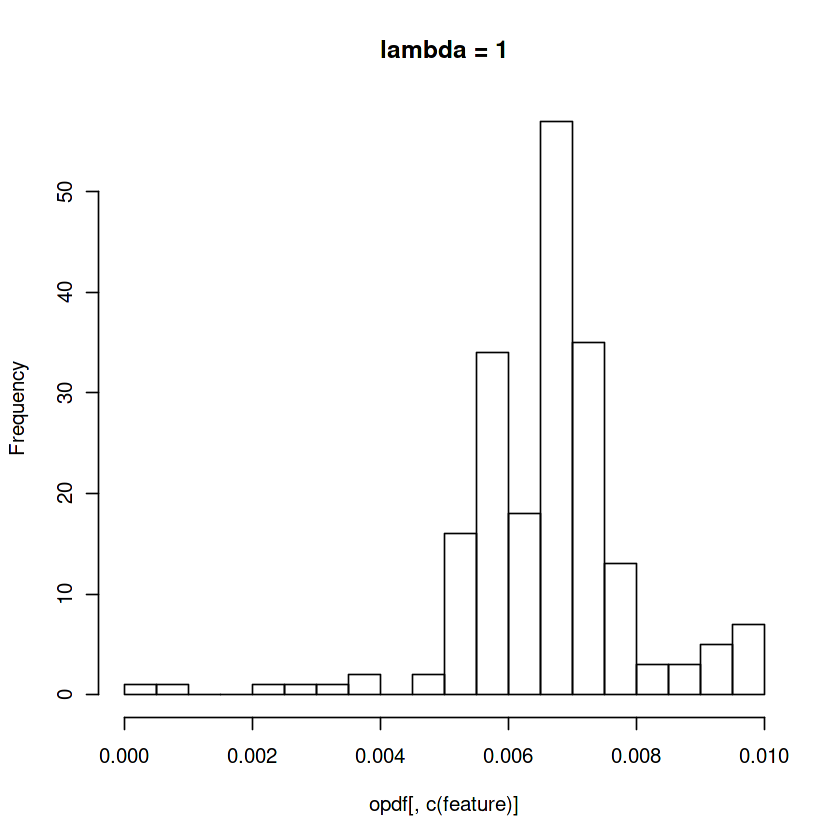

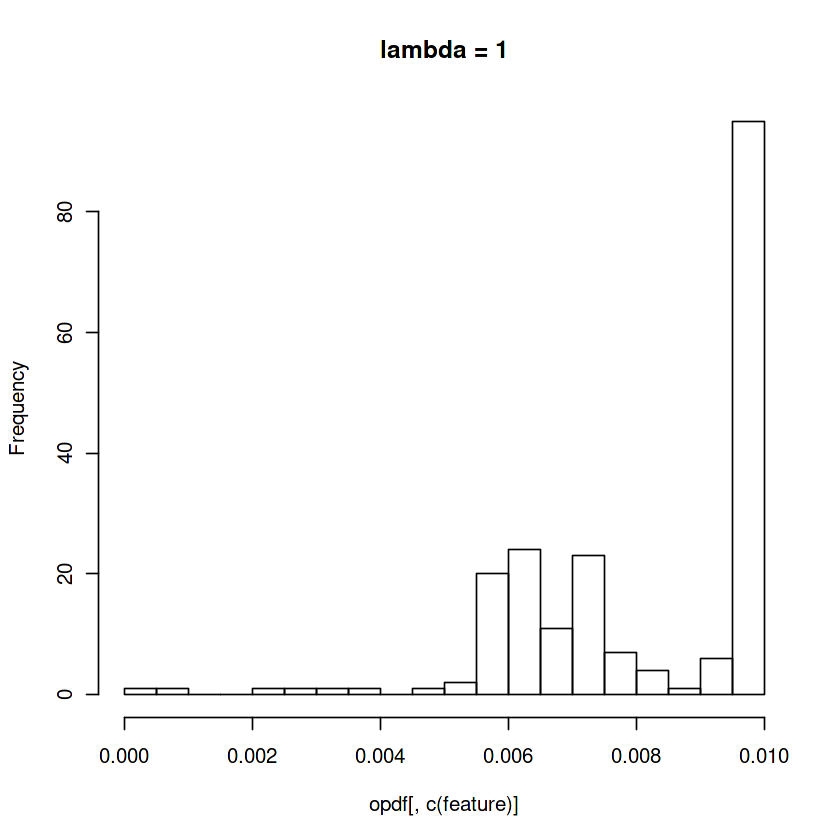

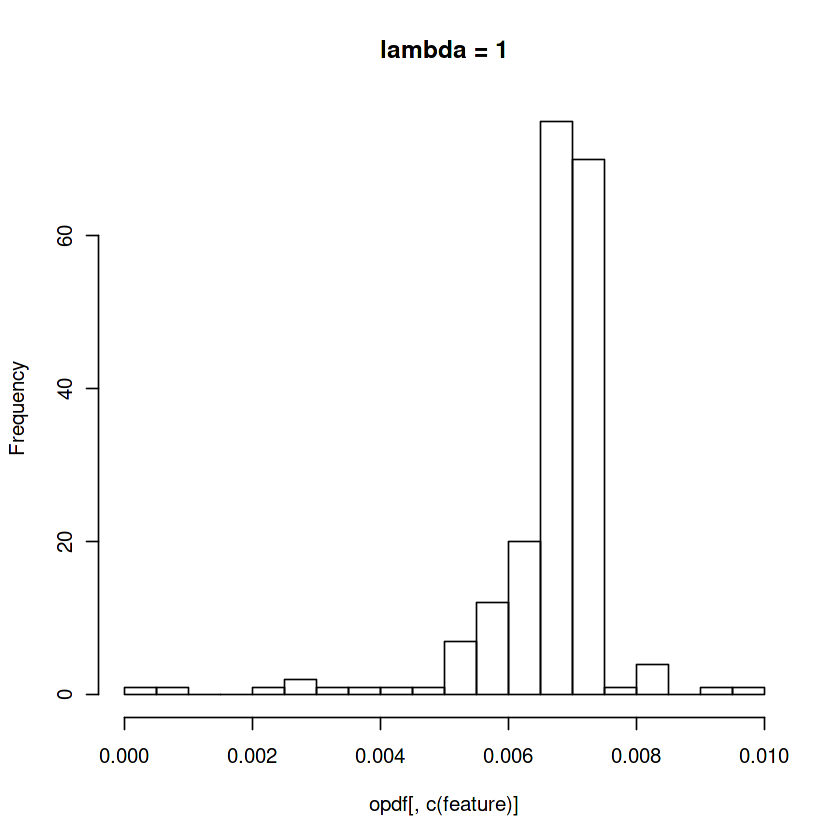

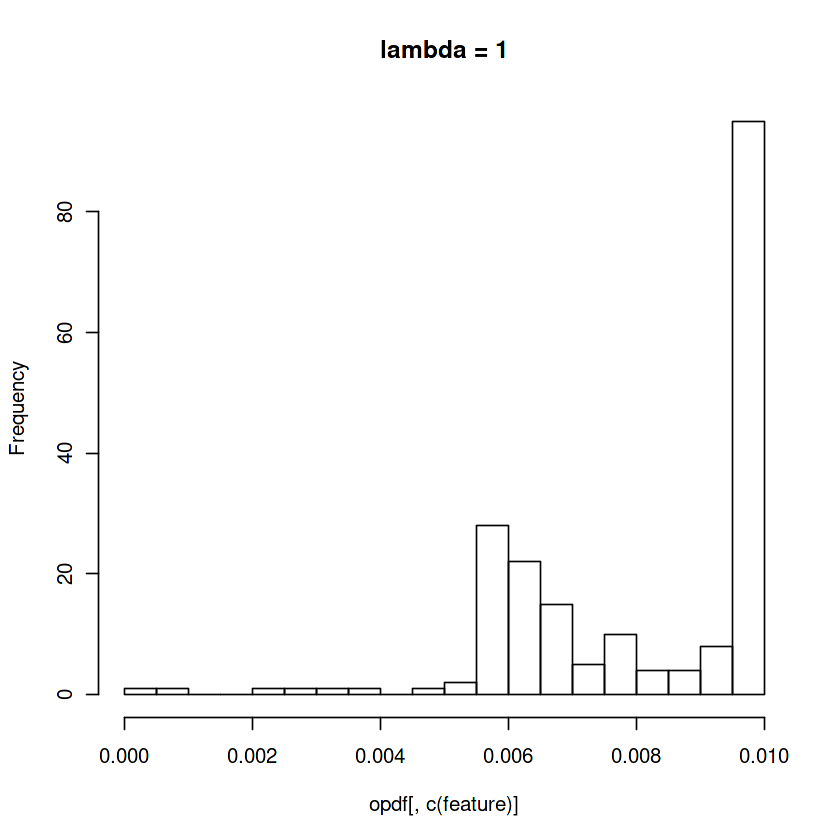

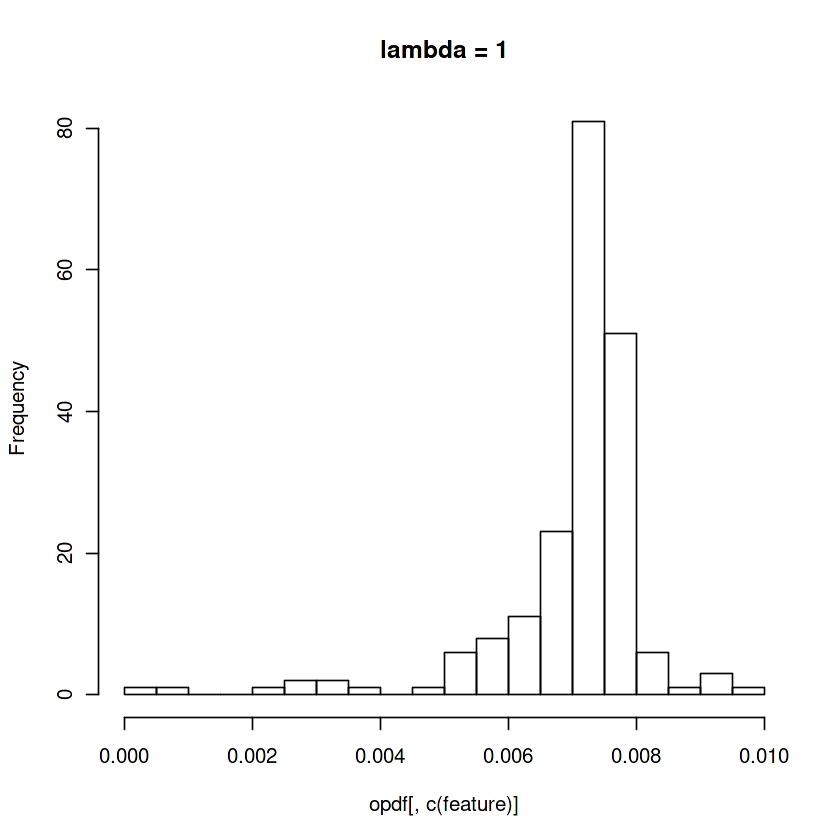

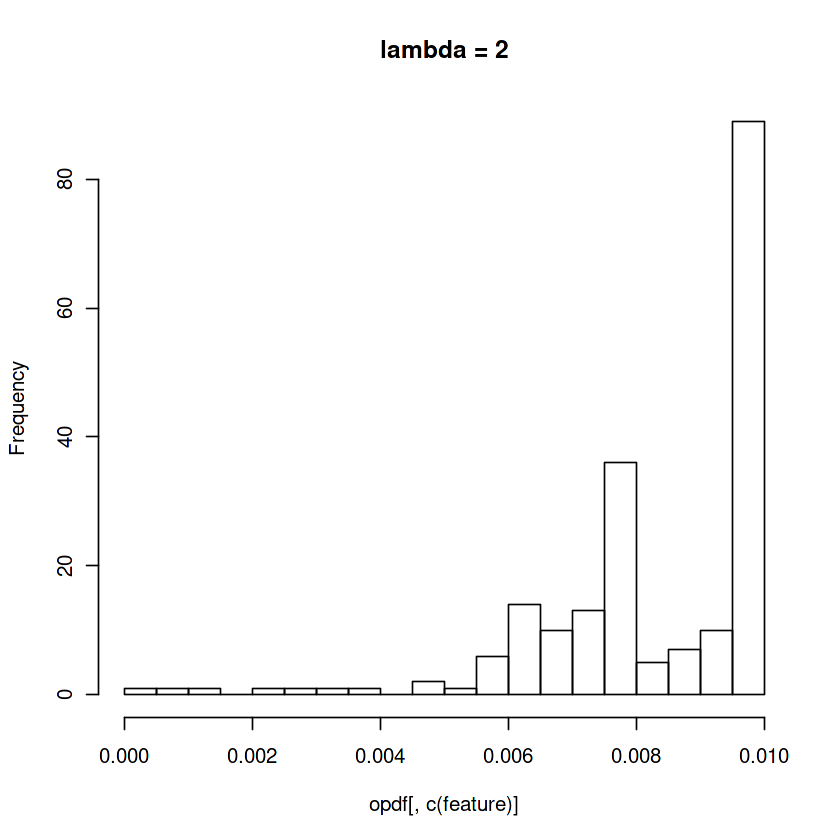

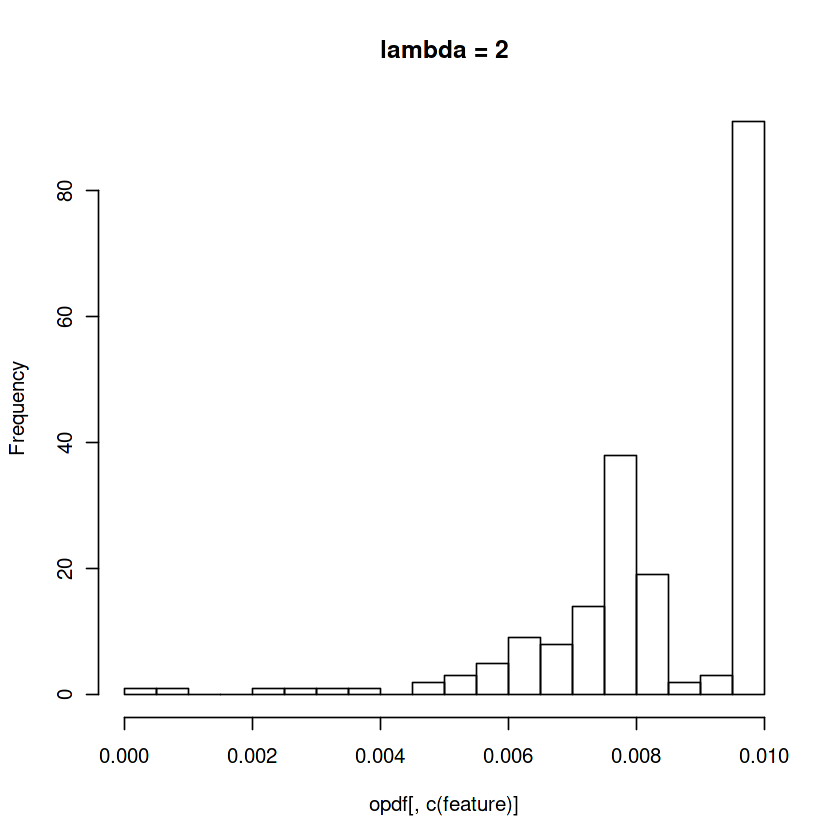

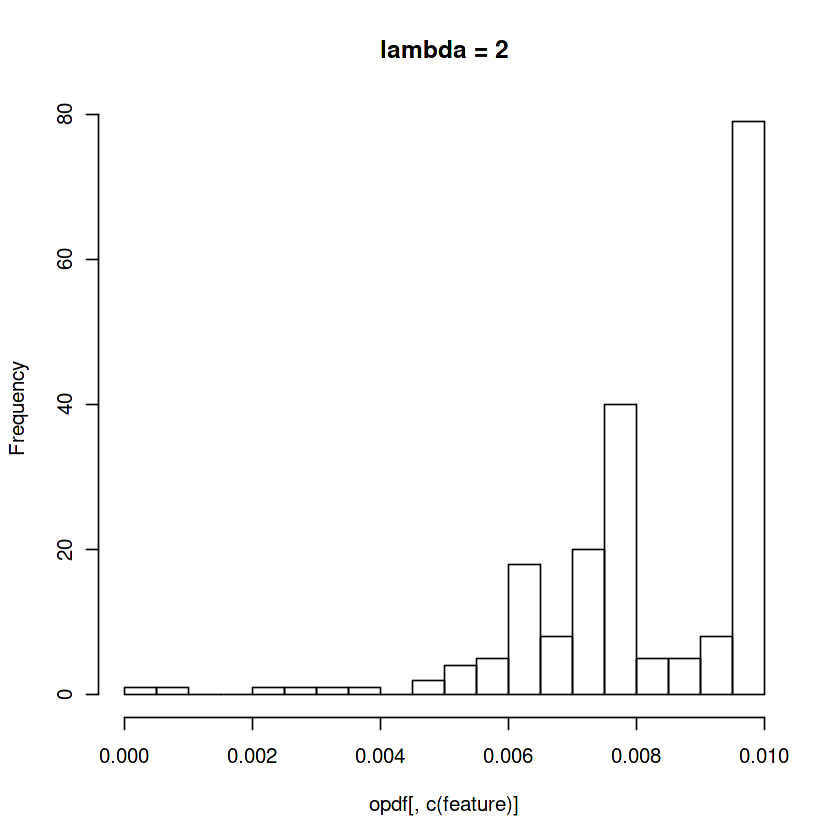

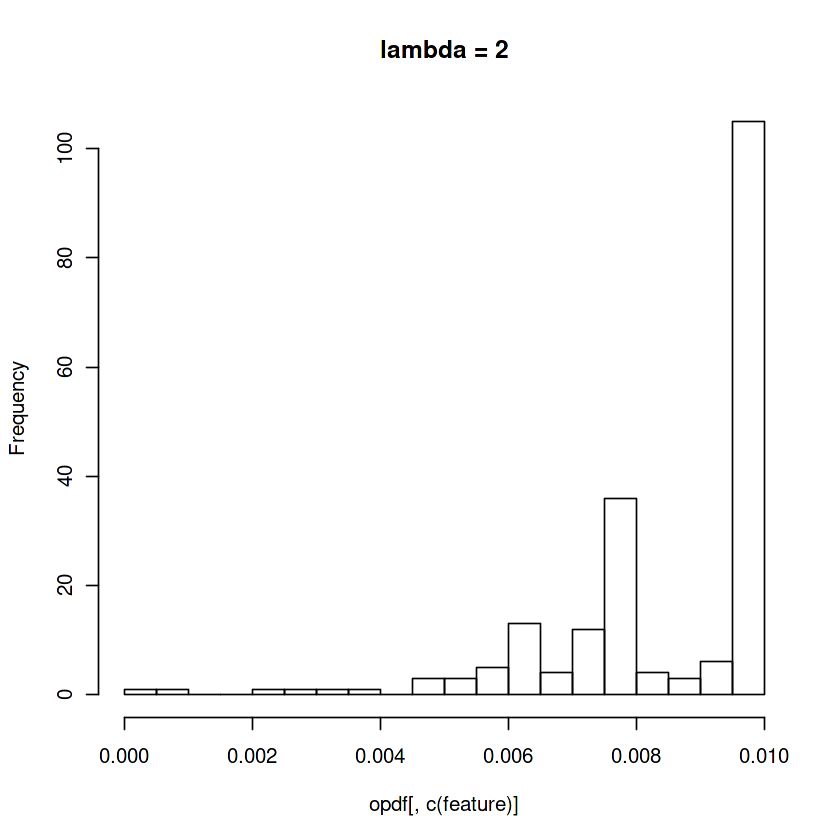

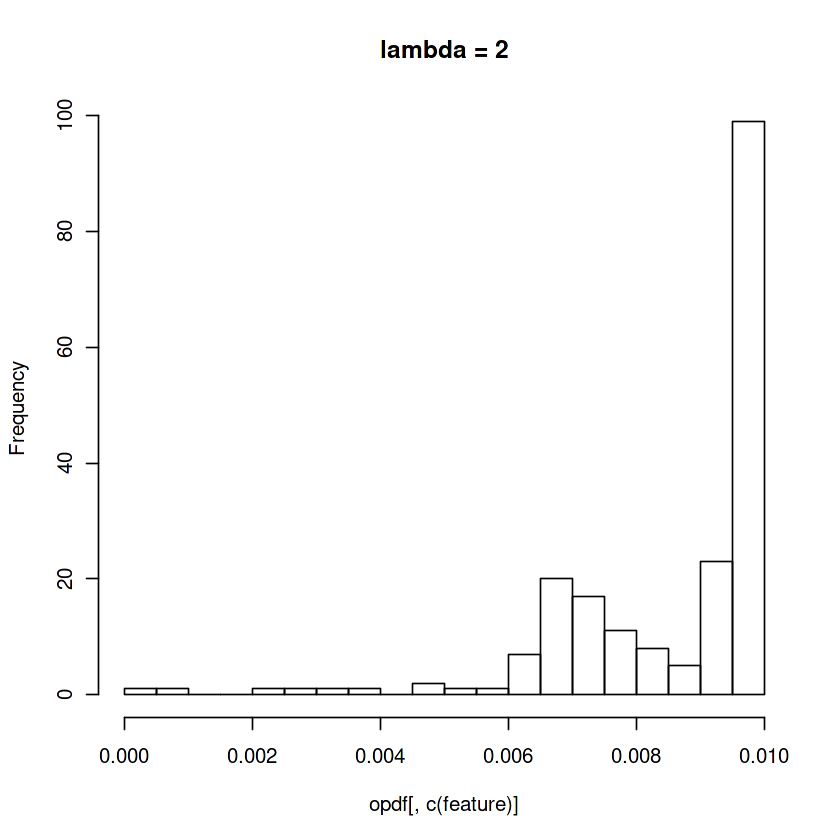

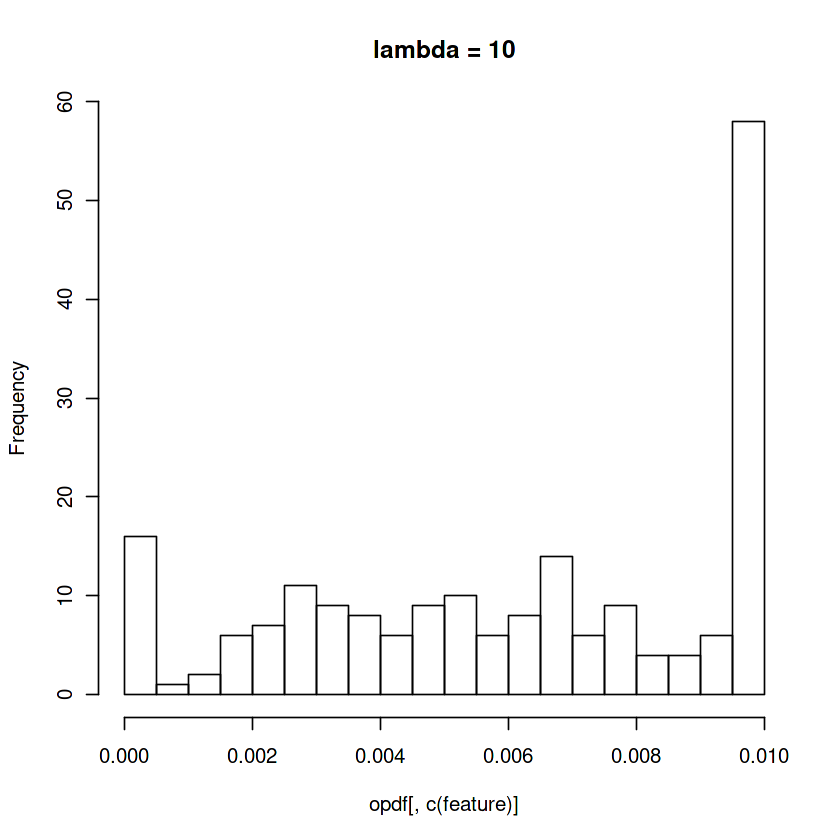

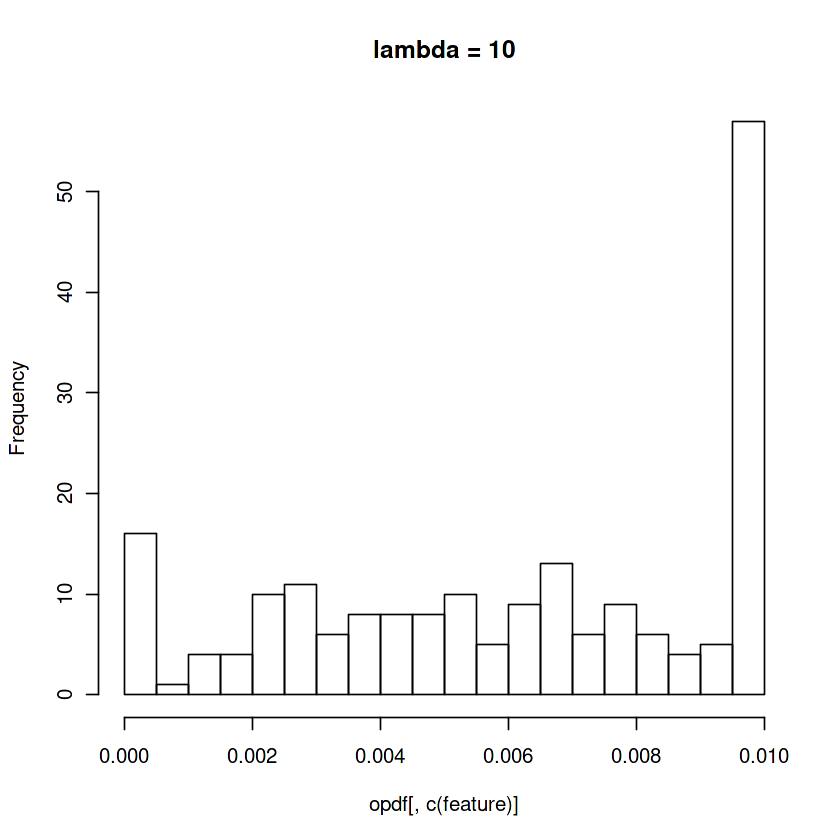

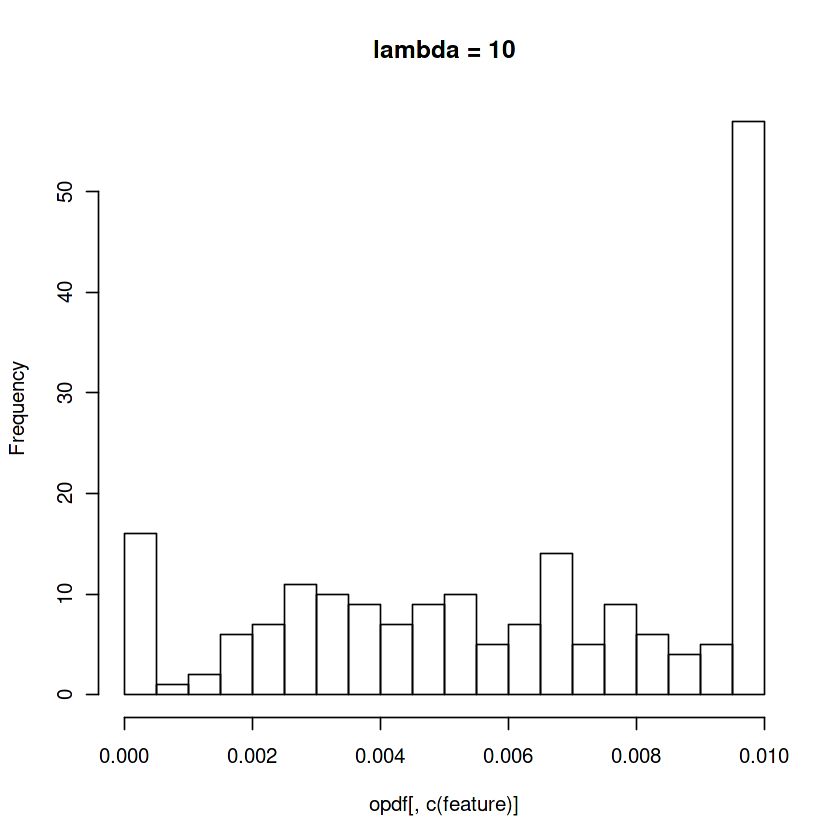

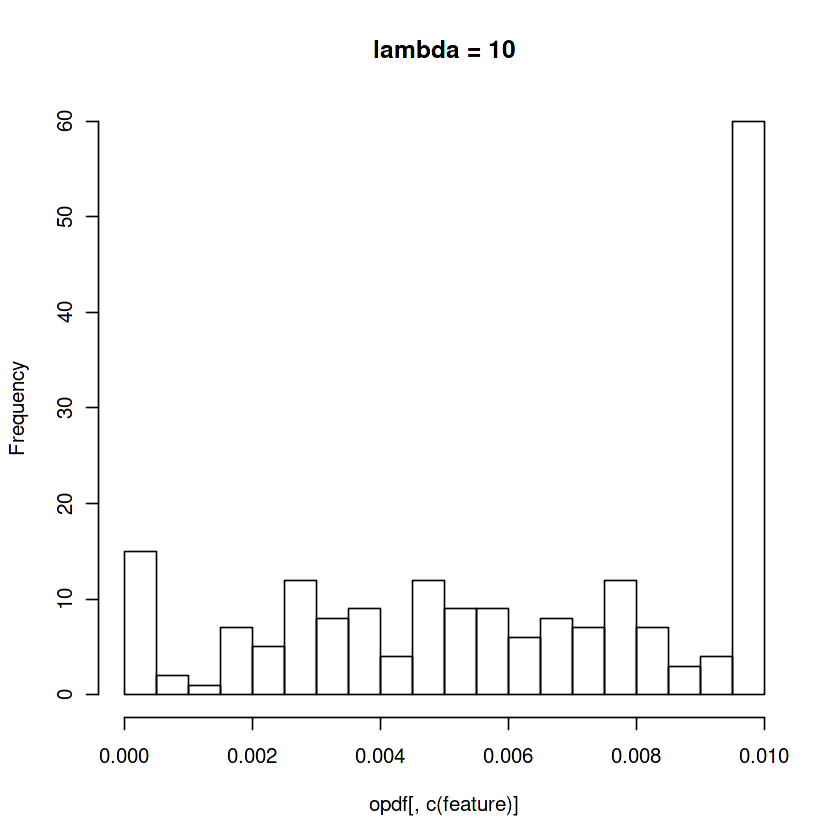

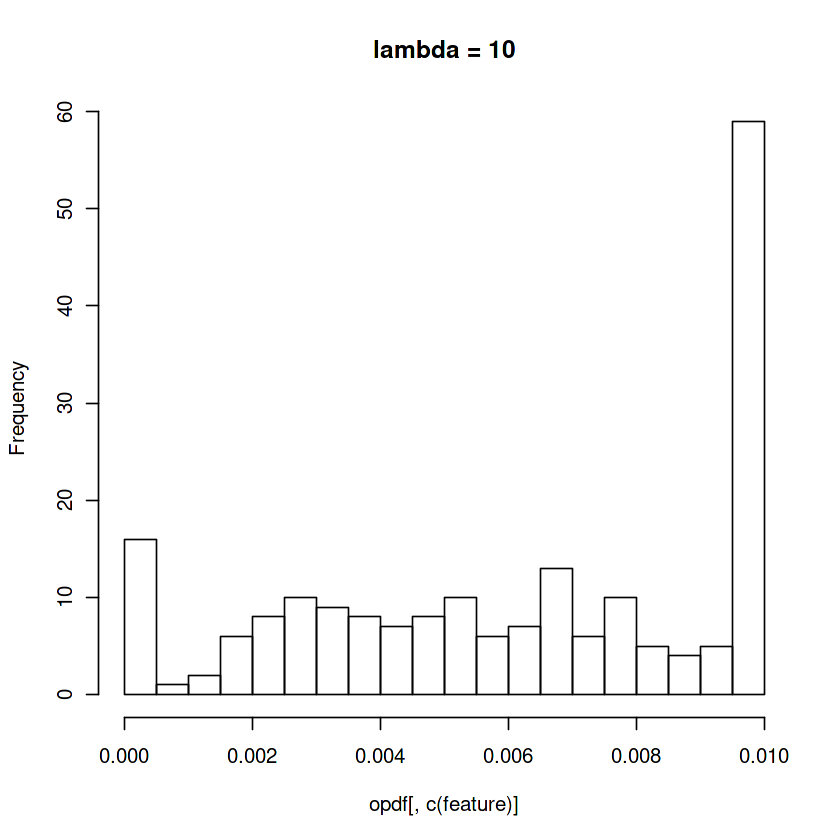

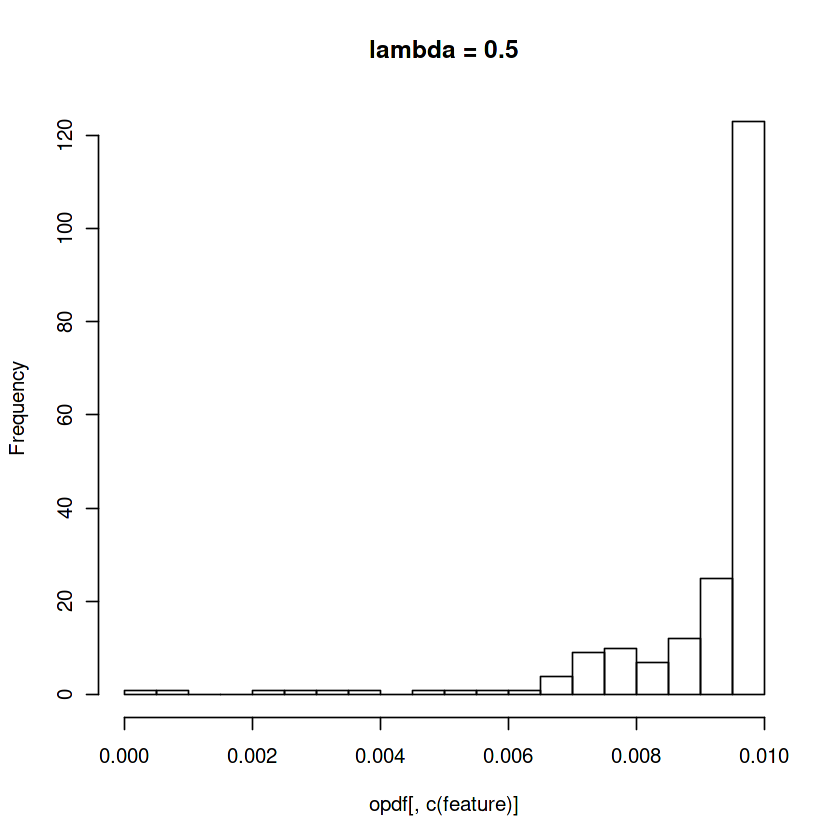

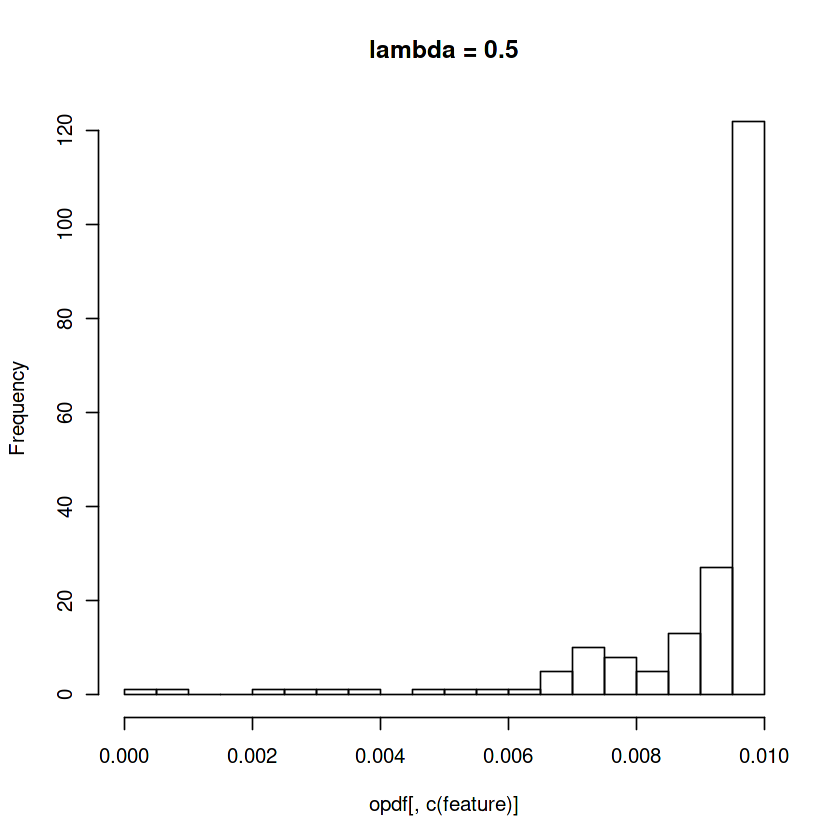

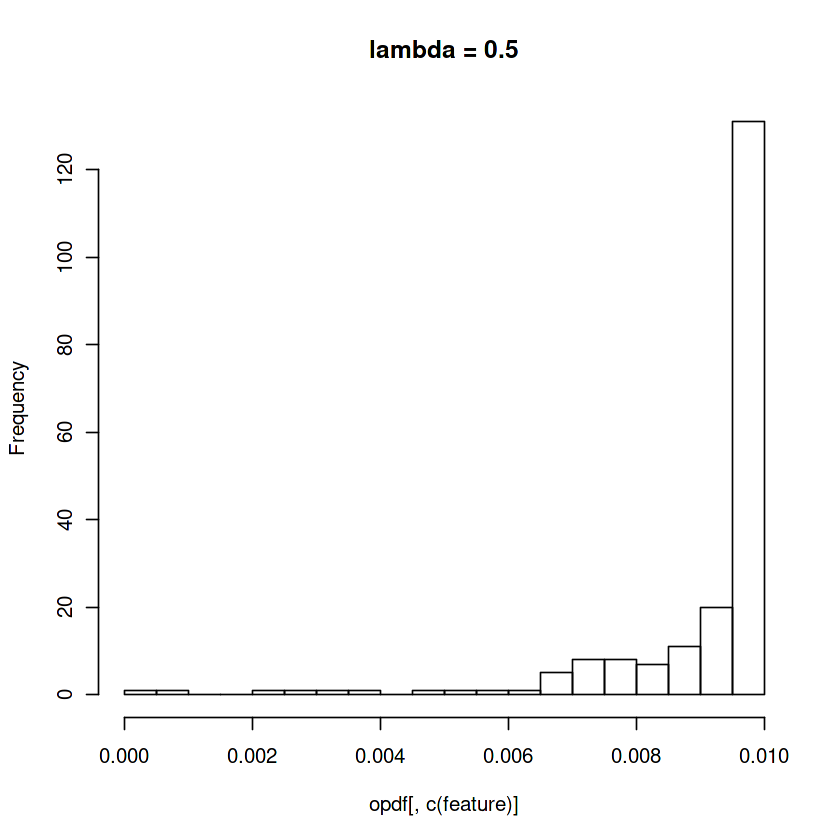

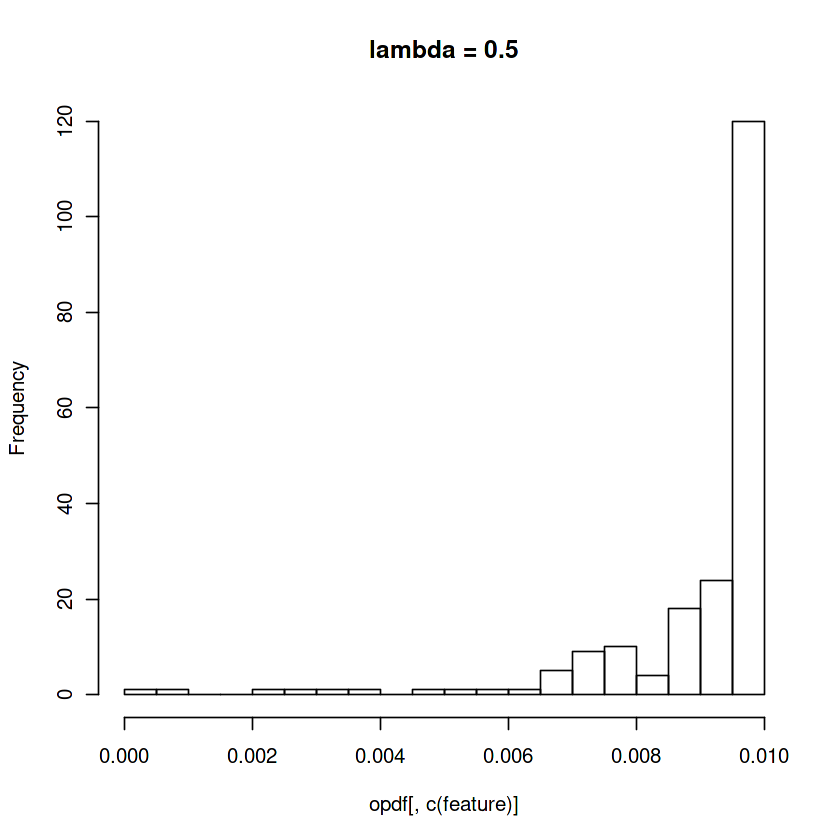

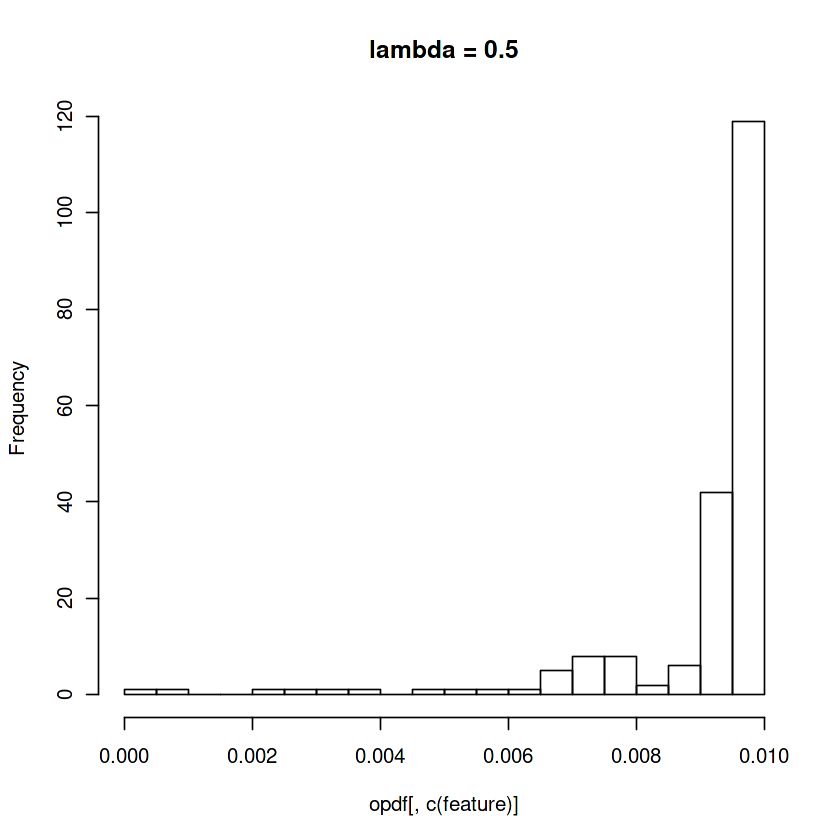

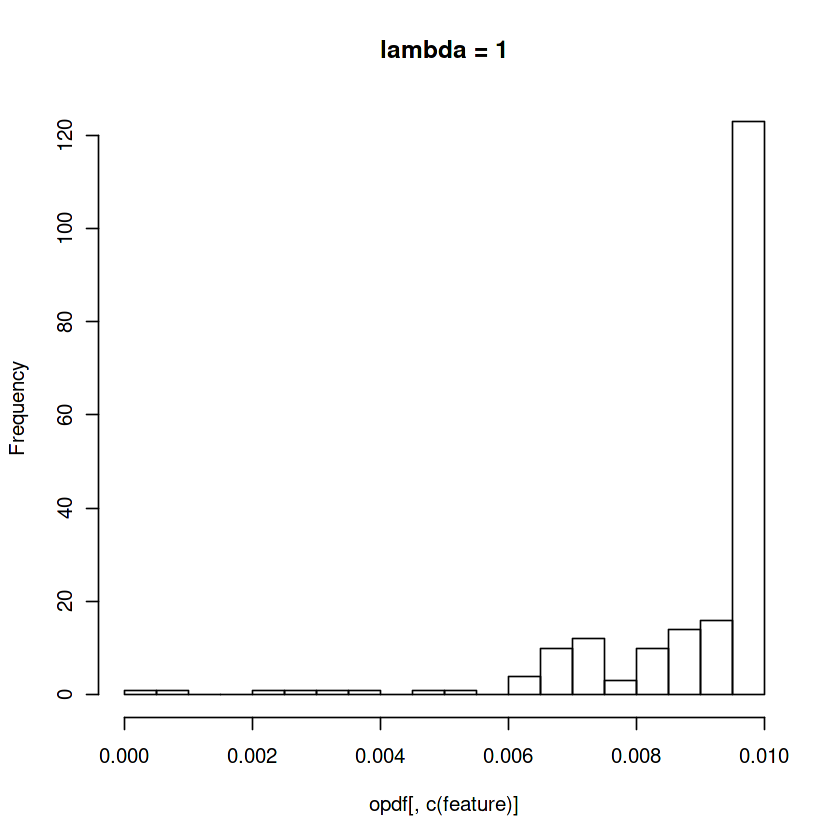

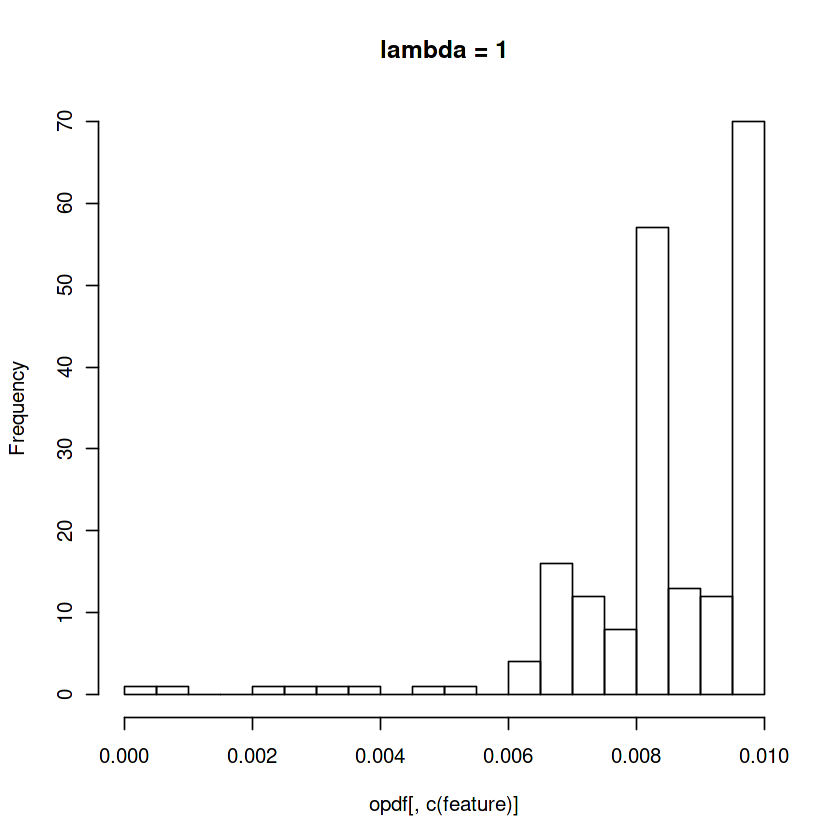

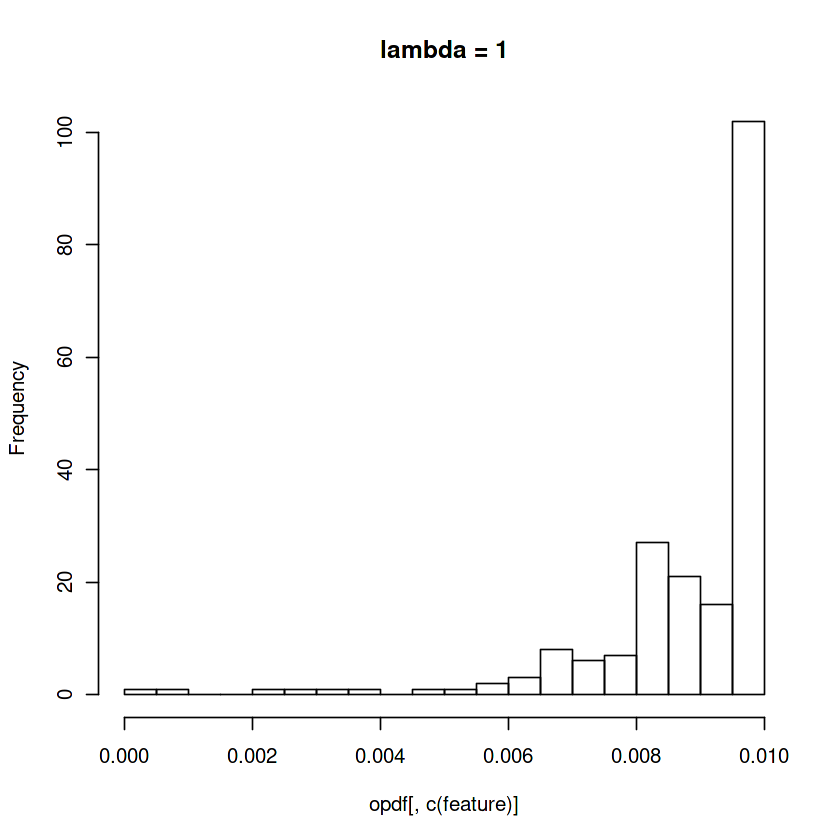

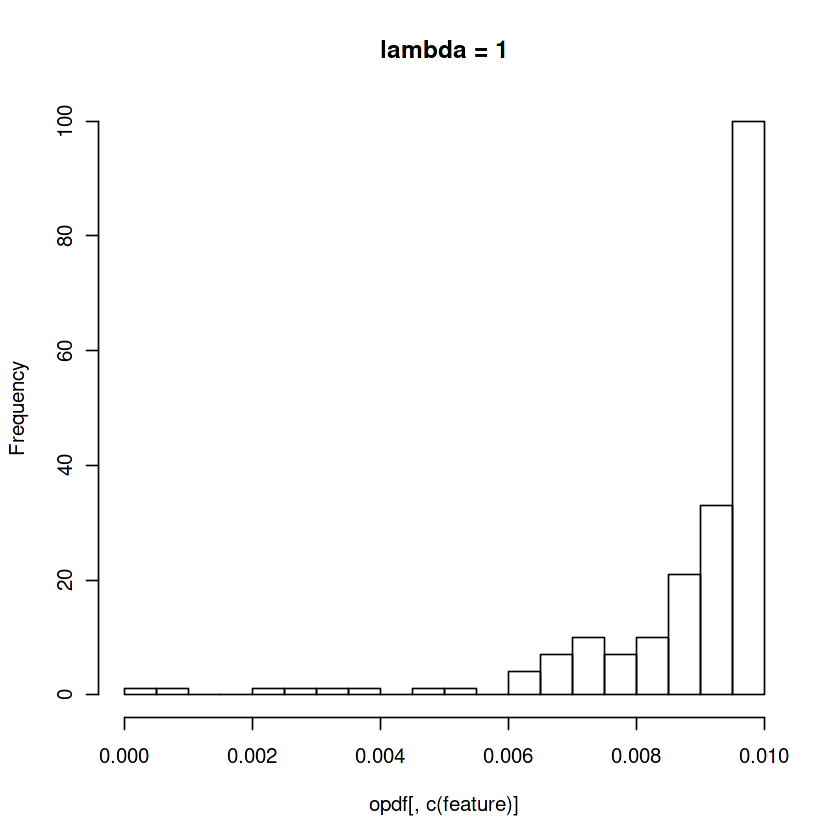

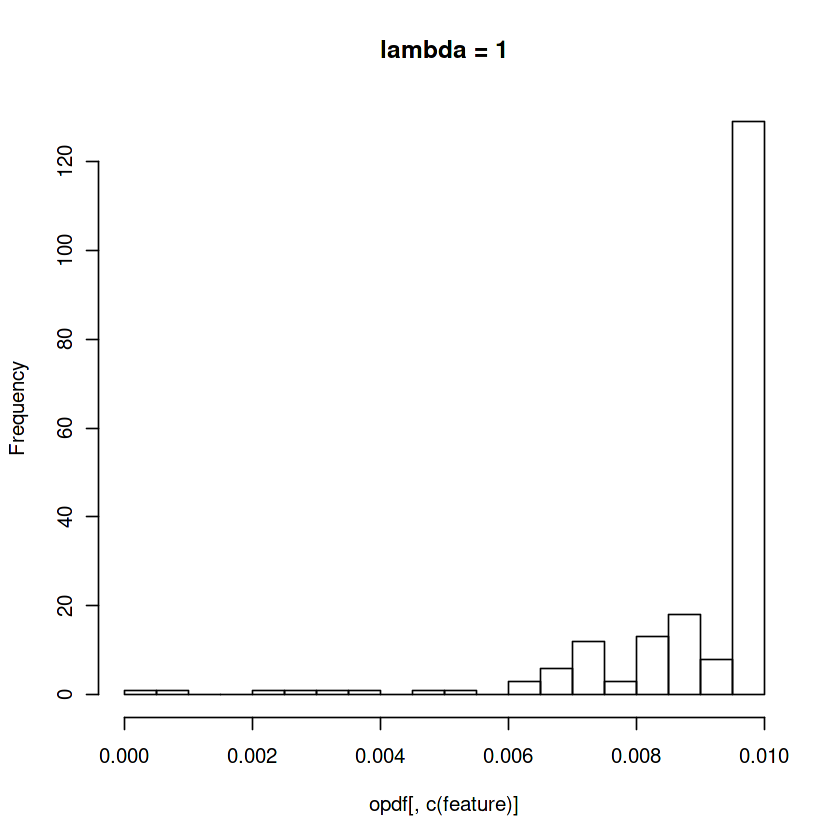

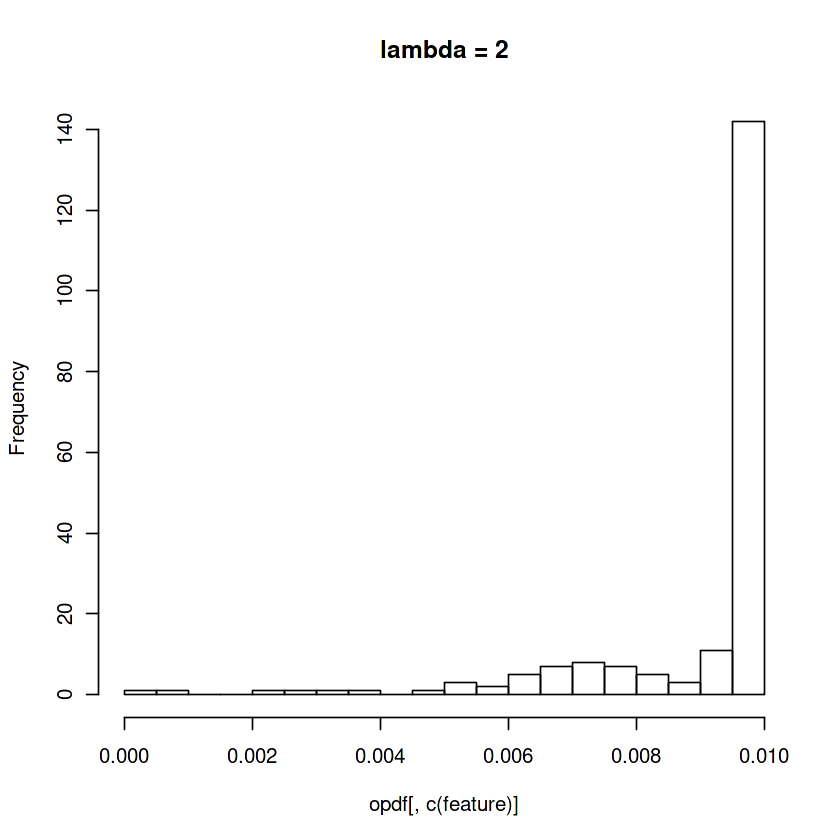

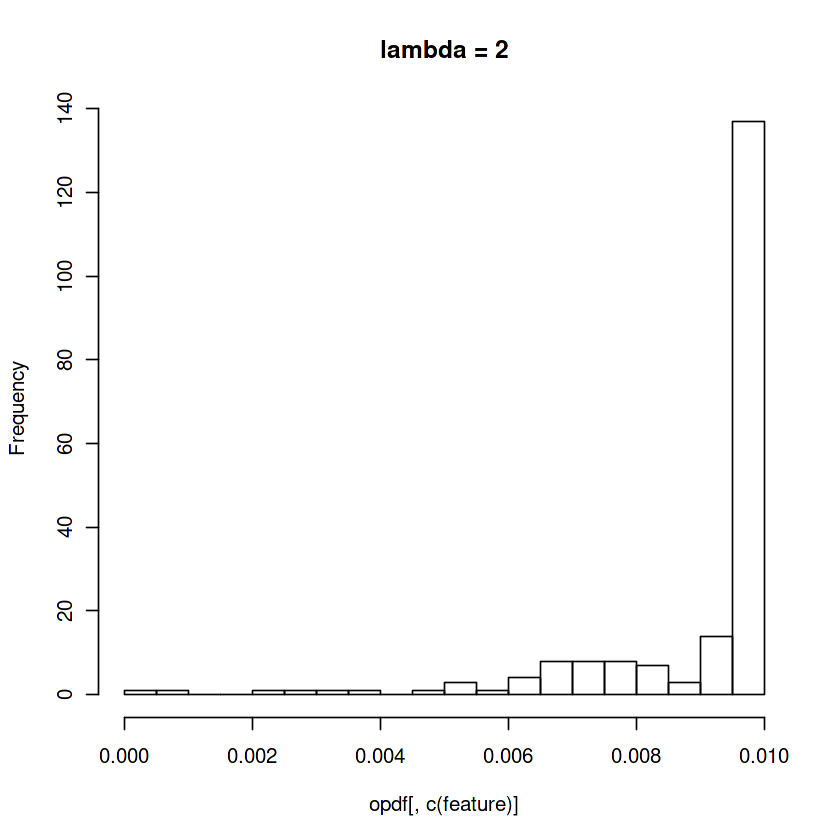

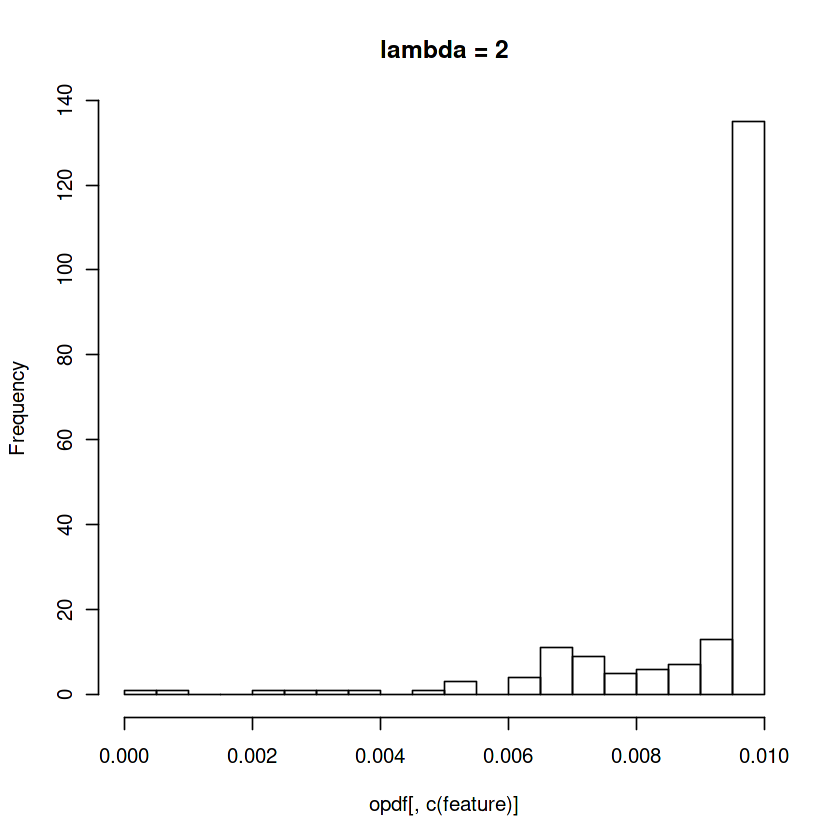

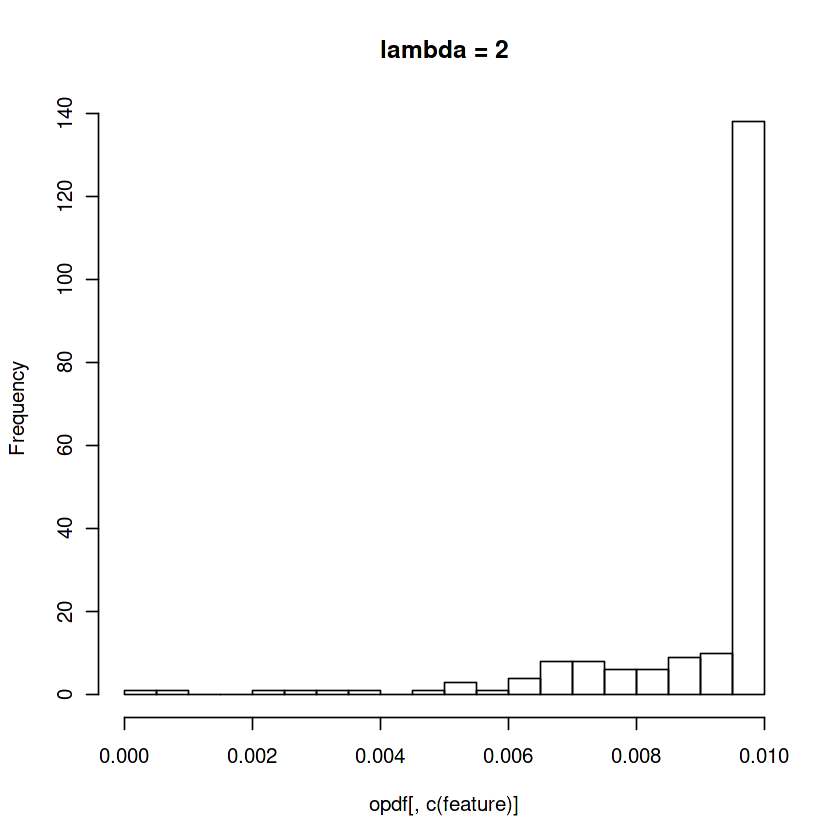

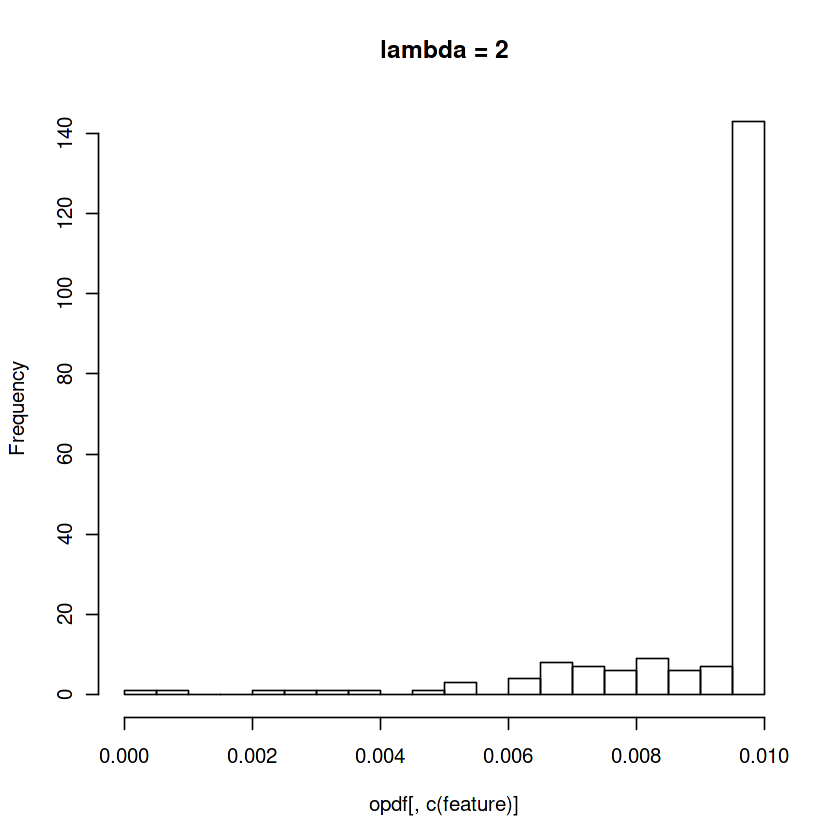

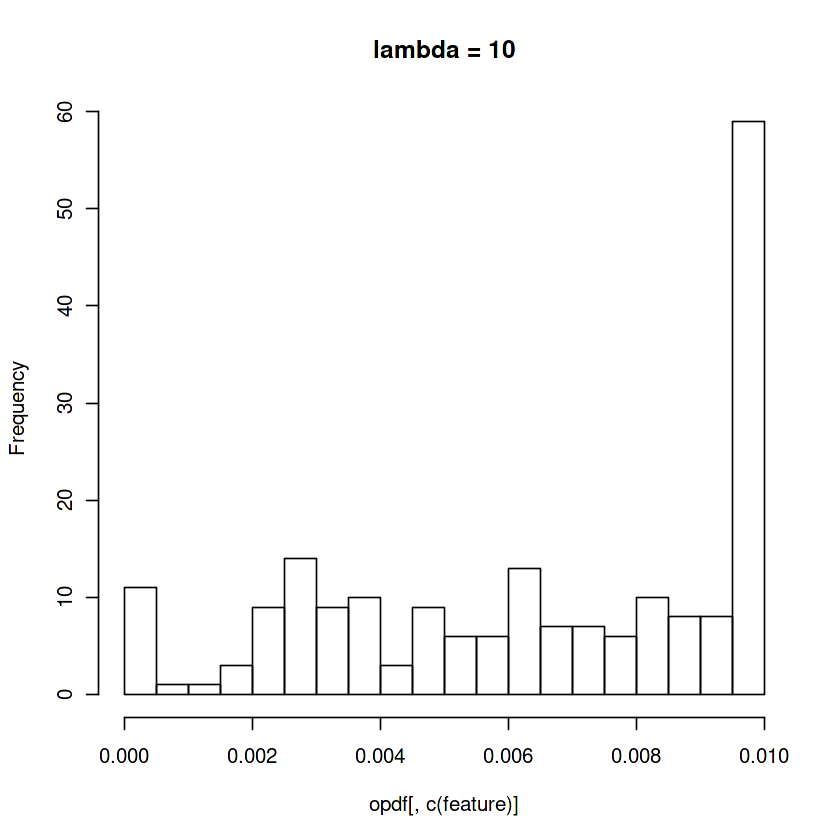

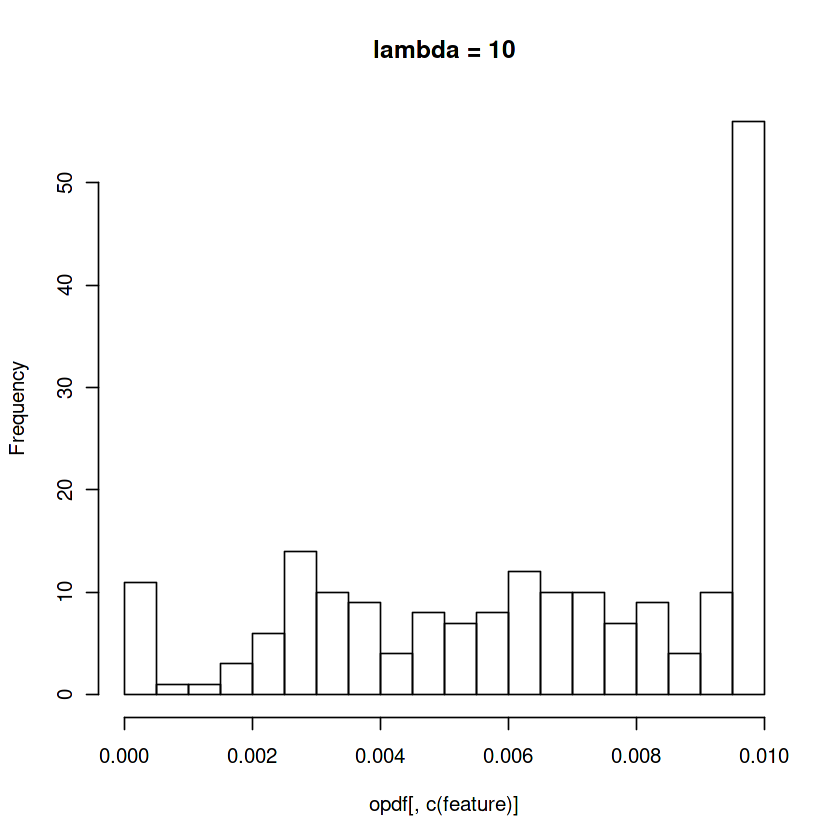

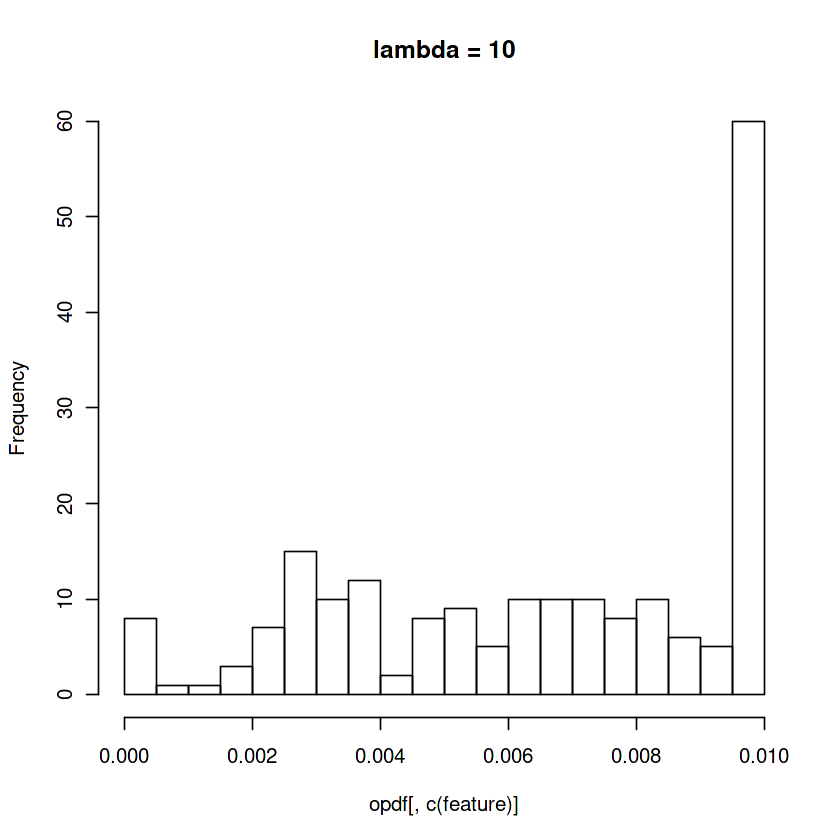

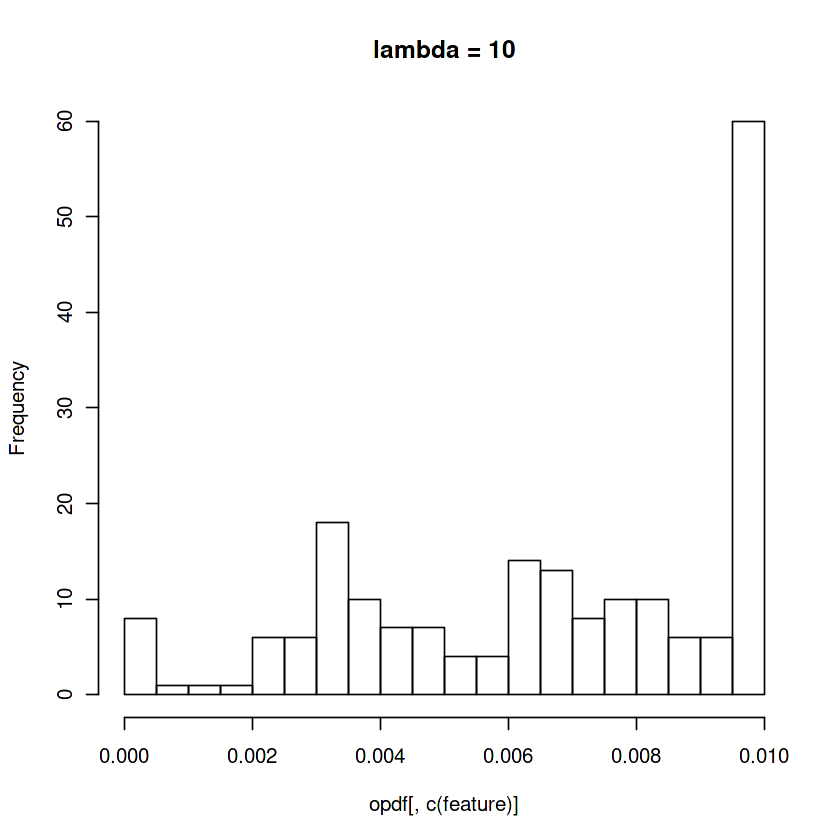

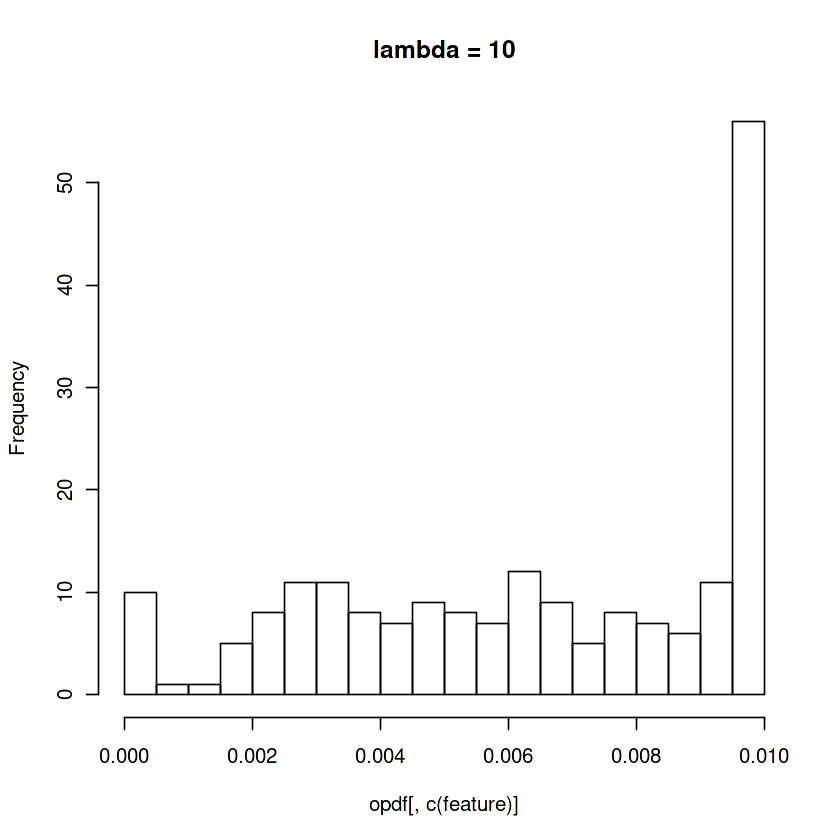

In [108]:
res3 = lapply(c("blood-transfusion-service-center", "kc1", "numerai28.6", "phoneme", "sylvine"), function(data) {
    compute_width_ci(data, c(0.5, 1, 2, 10), breaks = 20, feature = "learning_rate")
})

In [124]:
datasets = c("blood-transfusion-service-center")
res3 = lapply(seq_along(res3), function(i) {
    cbind(res[[i]], dataset = datasets[i], feature = "learning_rate")
})


In [115]:
res3 = do.call(rbind, res3)

In [120]:
res3$md = as.numeric(res3$md)

In [121]:
res3 = res3[, mean(md), by = c("lambda", "dataset")]

In [122]:
res3

lambda dataset                          V1         
1  0.5    blood-transfusion-service-center 0.136597836
2  1      blood-transfusion-service-center 0.135972872
3  2      blood-transfusion-service-center 0.122892295
4  10     blood-transfusion-service-center 0.141687369
5  0.5    kc1                              0.011768465
6  1      kc1                              0.006167972
7  2      kc1                              0.010083822
8  10     kc1                              0.003669521
9  0.5    numerai28.6                      0.222844014
10 1      numerai28.6                      0.222828354
11 2      numerai28.6                      0.222828299
12 10     numerai28.6                      0.223348034
13 0.5    phoneme                          0.011850519
14 1      phoneme                          0.012509444
15 2      phoneme                          0.008869526
16 10     phoneme                          0.008586133
17 0.5    sylvine                          0.096555576
18 1      sylvine                          0.098136176
19 2      sylvine                          0.101774095
20 10     sylvine                          0.100899649